This script would plot the rigidity resolution, beta resolution, mass resolution, using the parameters I find from fitting. 
The beta resolution is plotted againist gamma or Ekin/n, as plotting against $\beta$ does not offer the cleanest visual representation due to the asymptotic behavior.

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


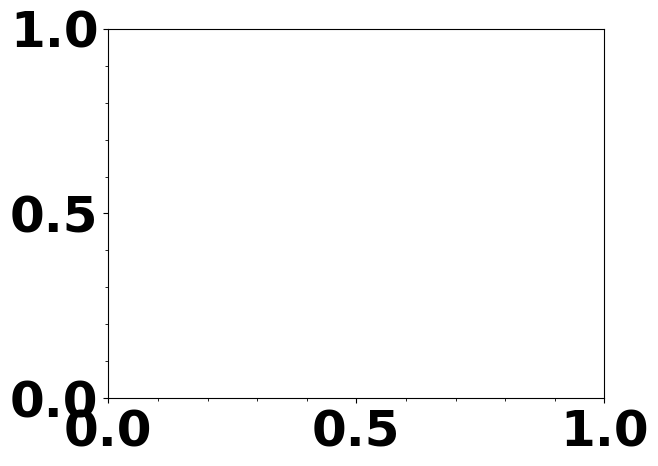

In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center
from tools.calculator import calc_rig_from_ekin
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE, ISOTOPES
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
setplot_defaultstyle()
from tools.jupytertools import *

In [2]:
detectors = ['Tof', 'NaF', 'Agl']
figSize = (22, 15)

nuclei = 'Li'
isotopes = ["Li6", "Li7"]

def get_pull_graph(graph, yfit):
    pull = (graph.yvalues - yfit)/graph.yerrs
    return MGraph(graph.xvalues, pull, np.zeros_like(pull))

#plotdir = '/home/manbing/Documents/Data/data_reso/plots_atdec'
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL'
os.makedirs(plotdir, exist_ok=True) 

In [3]:
mccolor = 'black'
def get_musigma_gausfit(hist2d_mc_tofTrue, minbin, maxbin, guess0, xrange, FigName=None):
    energy_binvalues = hist2d_mc_tofTrue.binnings[0].bin_centers[minbin:maxbin]
    graph_mean_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_sigma_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin, maxbin)):
   
        lowbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin]
        upbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin + 1]
        hist1d_mc = hist2d_mc_tofTrue.project(ibin) 
        hist1d_mc = hist1d_mc * (1/np.sum(hist1d_mc.values))
    

        xbinrange = hist1d_mc.binnings[0].get_indices(xrange)
    
        xedges_mc = hist1d_mc.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue_mc = hist1d_mc.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue_mc = hist1d_mc.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(hist1d_mc.squared_values[xbinrange[0]:xbinrange[1]])
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
   
       
        guess_gaus_mc = guess0
        
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)
        for key in guess_gaus_mc.keys():
            guess_gaus_mc[key] = par_mc[key]
    
        xrange_iter2mc = [guess_gaus_mc['mu'] - 2.0 * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + 2.0 * guess_gaus_mc['sigma']]
        xbinrange2mc = hist1d_mc.binnings[0].get_indices(xrange_iter2mc)
    
        xedges_mc = hist1d_mc.binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
        xvalue_mc = hist1d_mc.binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalue_mc = hist1d_mc.values[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalueserr_mc = np.sqrt(hist1d_mc.squared_values[xbinrange2mc[0]:xbinrange2mc[1]])
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
    
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)

        graph_mean_mcTofTrueReso.yvalues[ip] = par_mc['mu']
        graph_mean_mcTofTrueReso.yerrs[ip] = parerr_mc['mu']
        graph_sigma_mcTofTrueReso.yvalues[ip] = par_mc['sigma']
        graph_sigma_mcTofTrueReso.yerrs[ip] = parerr_mc['sigma']
                                                                                                                                                            
        fit_y_mc = normalized_gaussian(xvalue_mc, *par_mc) 
        draw = False
        plotp = [2, 10]
        if ip in plotp:
            figure, ax1 = plt.subplots(1, 1, figsize=(17, 14))
            plot_histogram_1d(ax1, hist1d_mc, style="mc", color='black', label=None, scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False) 
            #ax1.legend()
            ax1.plot(xvalue_mc, fit_y_mc, '-', linewidth=3, color='blue')
            ax1.text(0.6, 0.98, f"[{lowbinedge:.2f}, {upbinedge:.2f}] GeV/n", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
       
            ax1.set_ylim([0.0001, 0.1])
        
            ax1.text(0.03, 0.8, f'{nuclei} {FigName}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black', weight='normal')  
            ax1.text(0.03, 0.75, f"$\\mu:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.text(0.03, 0.7, f"$\\sigma:$ {par_mc['sigma']:.4f}$\\pm$ {parerr_mc['sigma']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.set_ylabel('Normalized events')
            ax1.set_xlabel(r'$\mathrm{\beta_{tof}-\beta_{naf}}$')
            #ax1.set_xlim([-0.4, 0.4])
            ax1.set_yscale('log')
            #savefig_tofile(figure, plotfile, f"hist1d_{figsuffix}_Compare_{ibin}_{nuclei}", show=True) 
    return graph_mean_mcTofTrueReso, graph_sigma_mcTofTrueReso 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


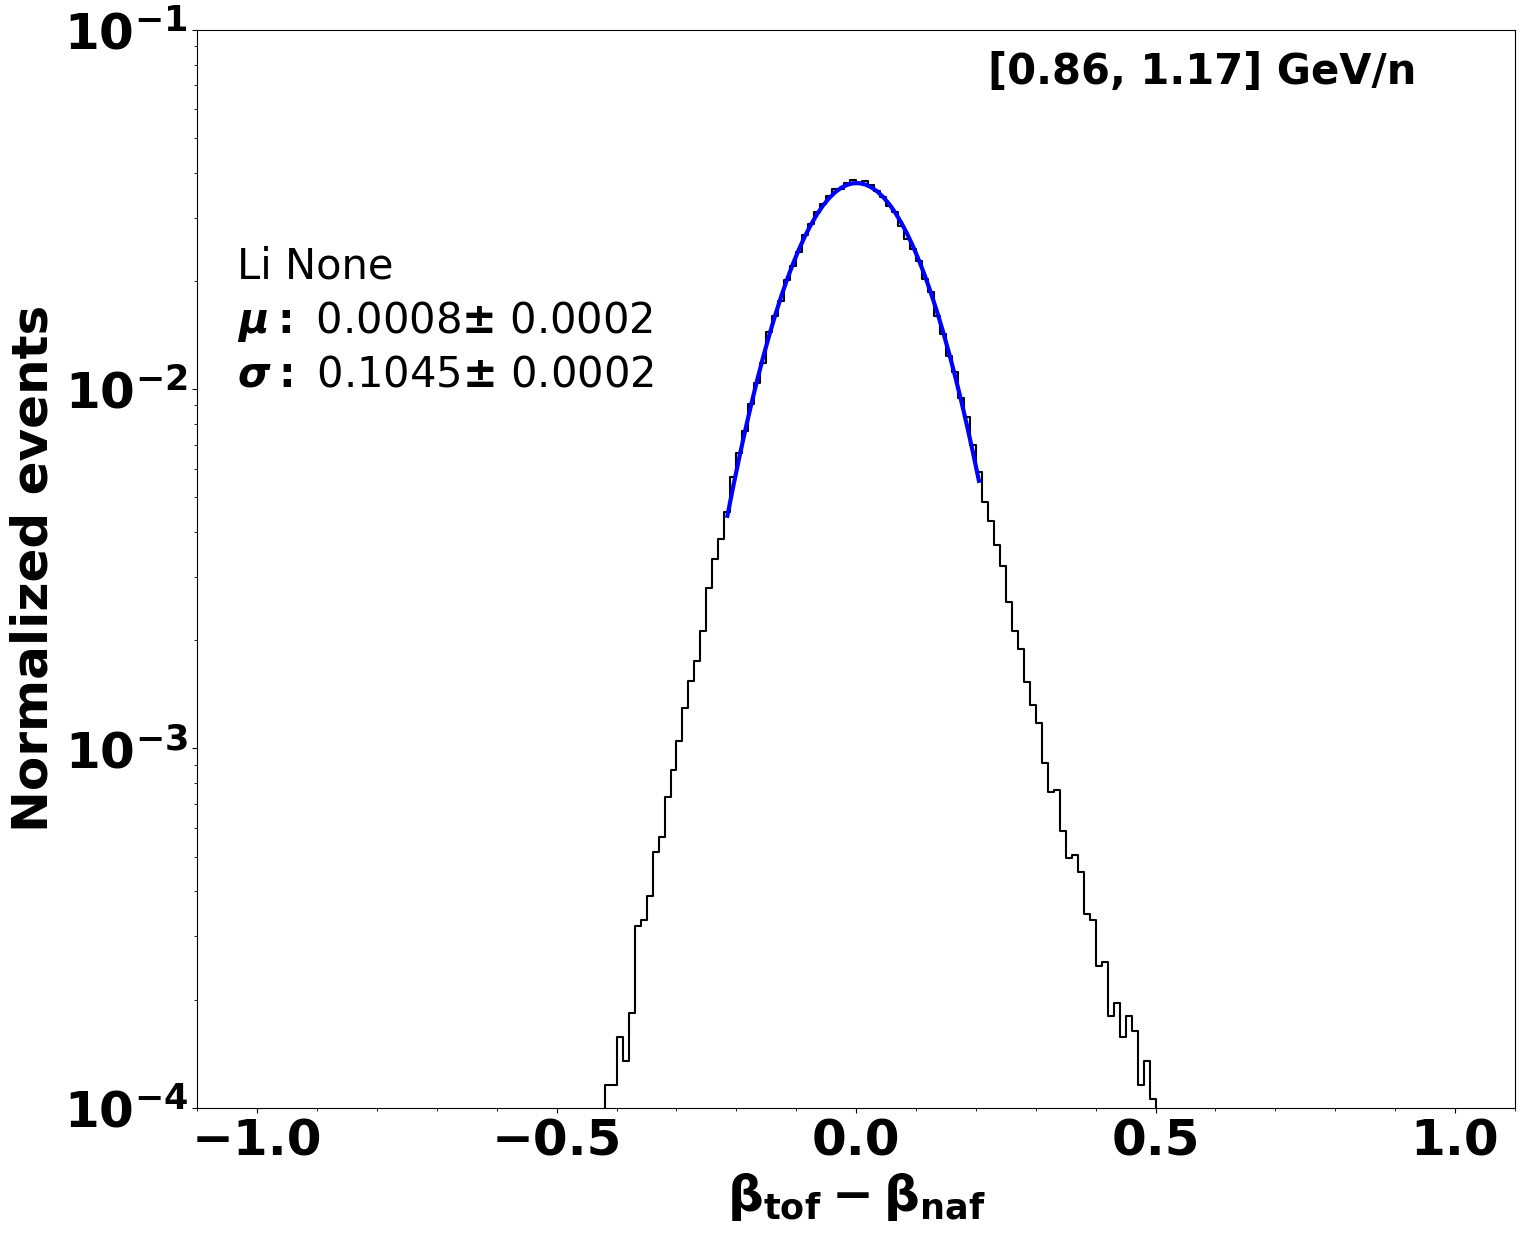

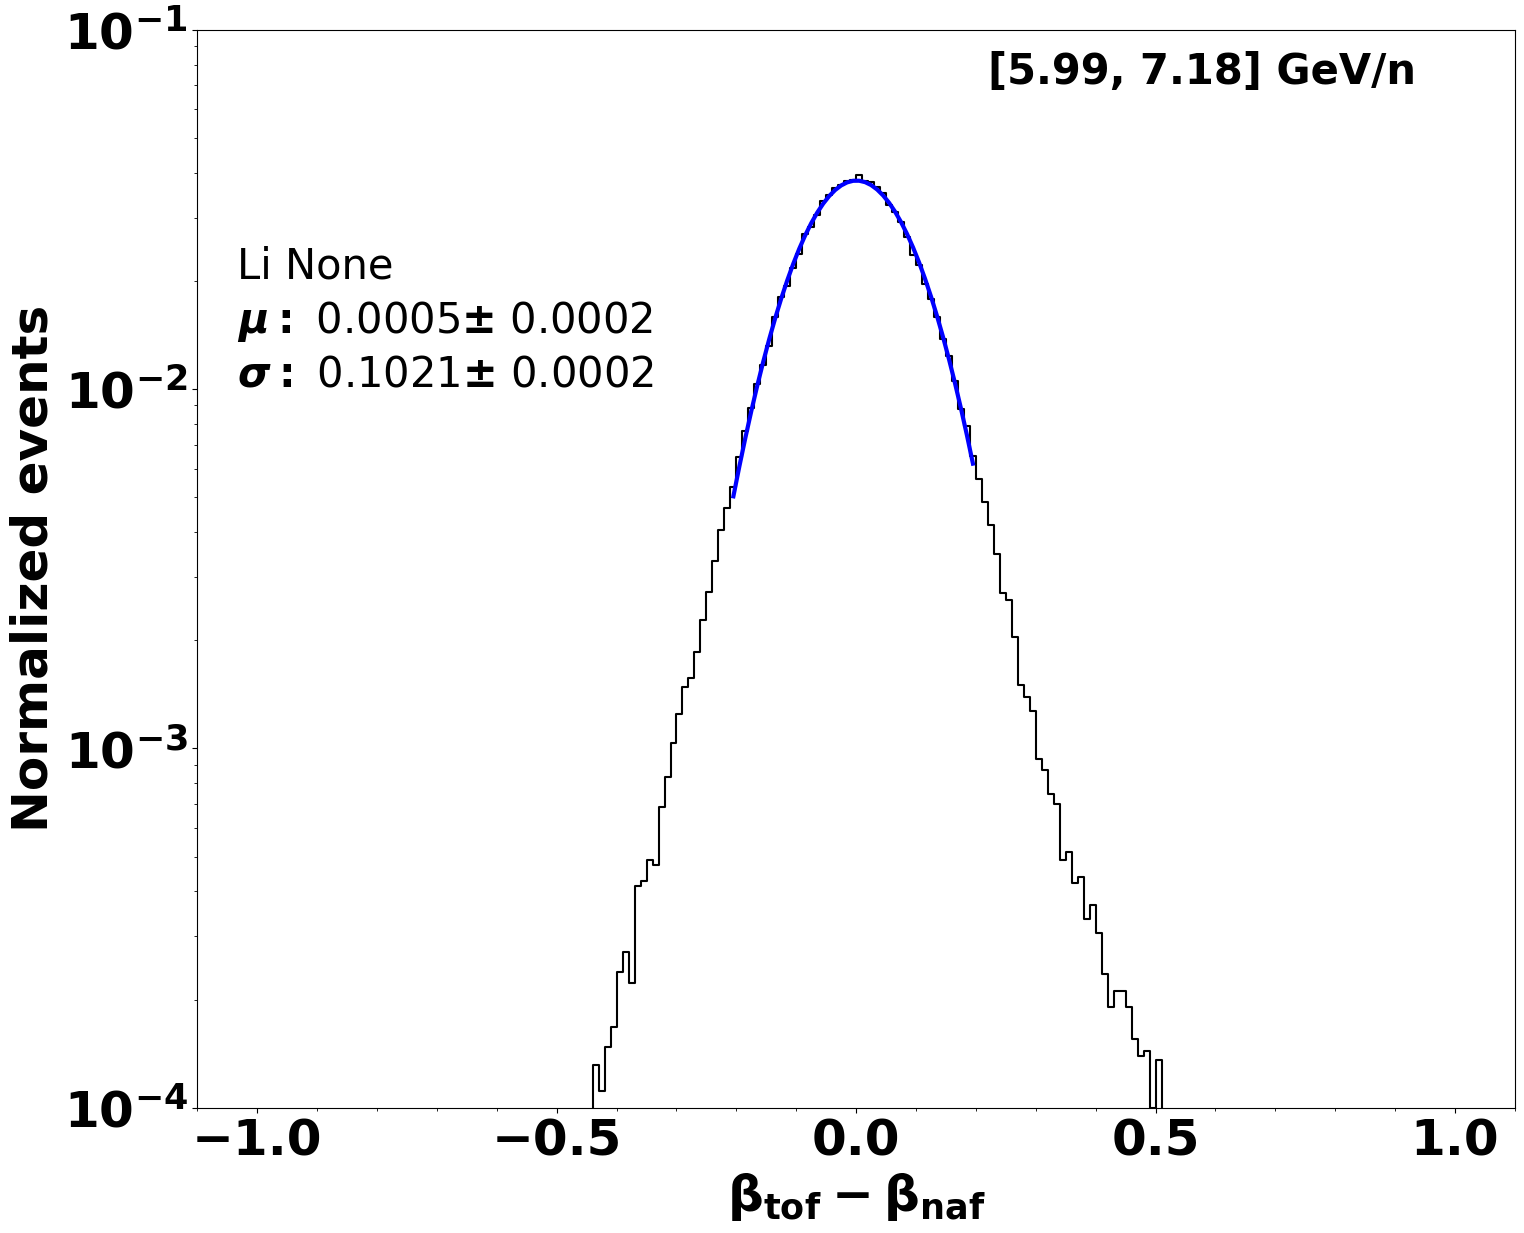

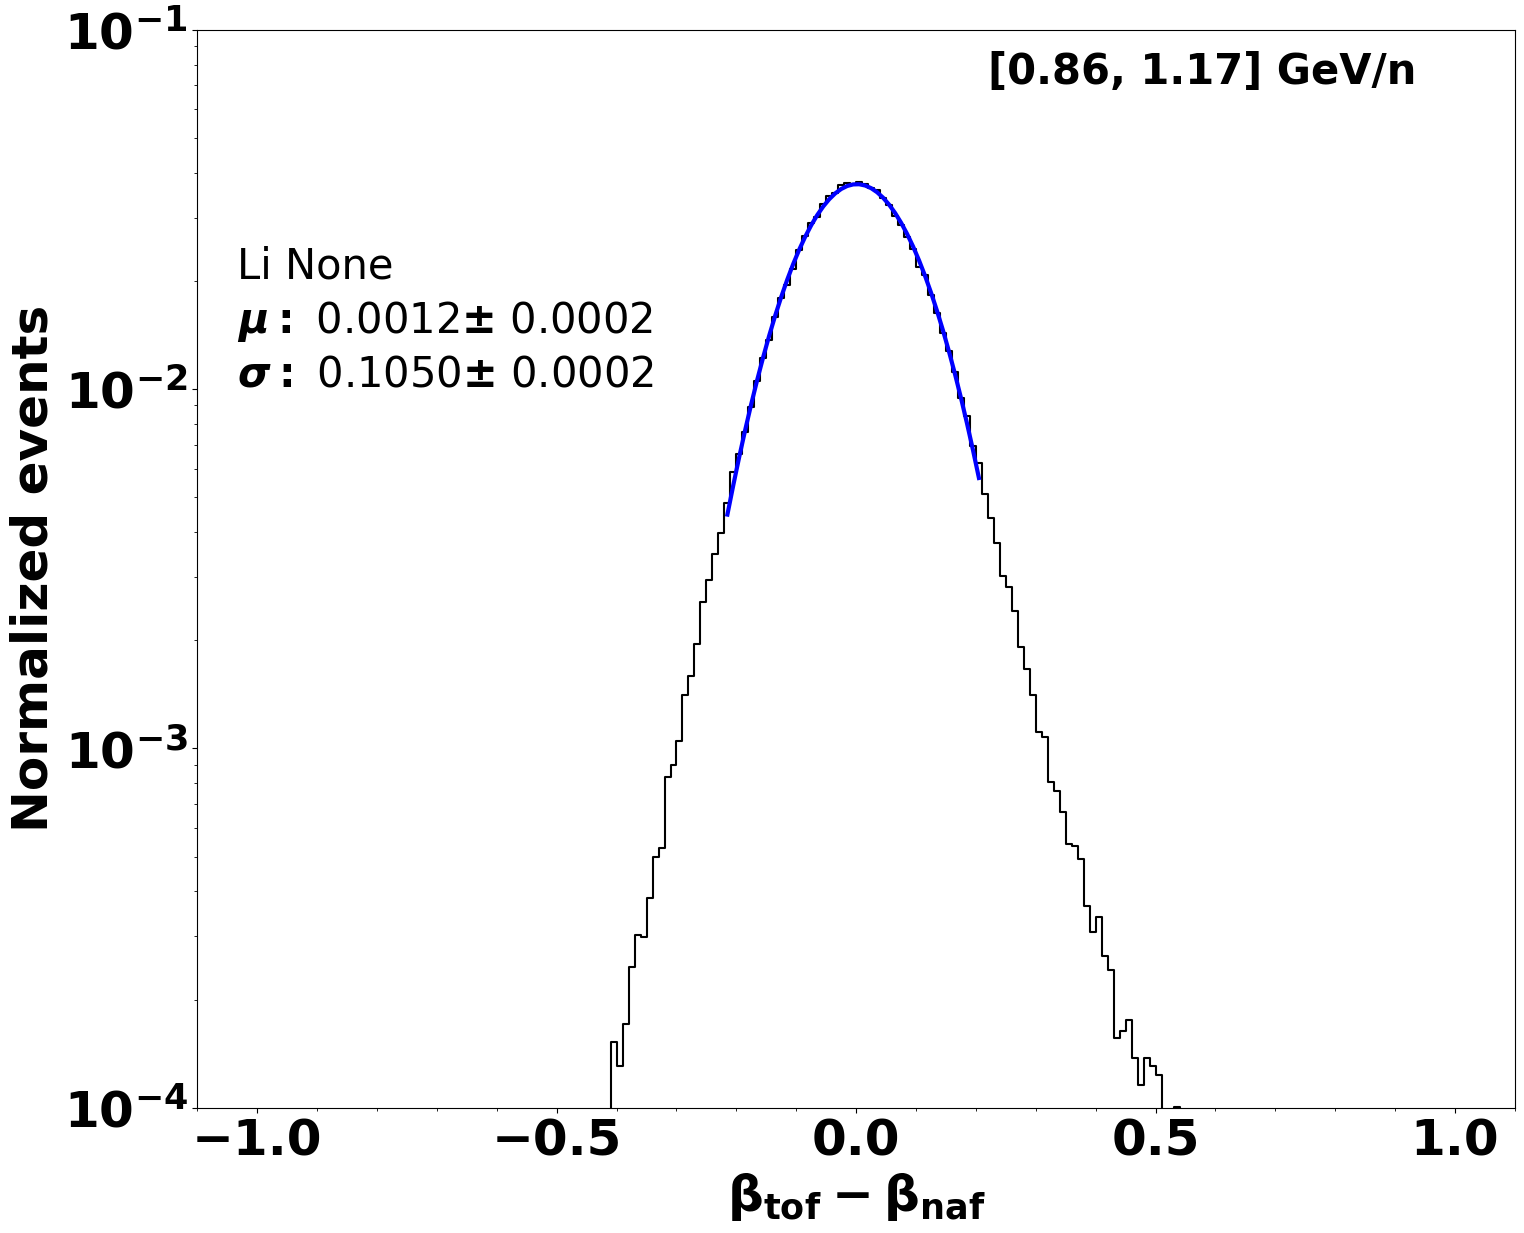

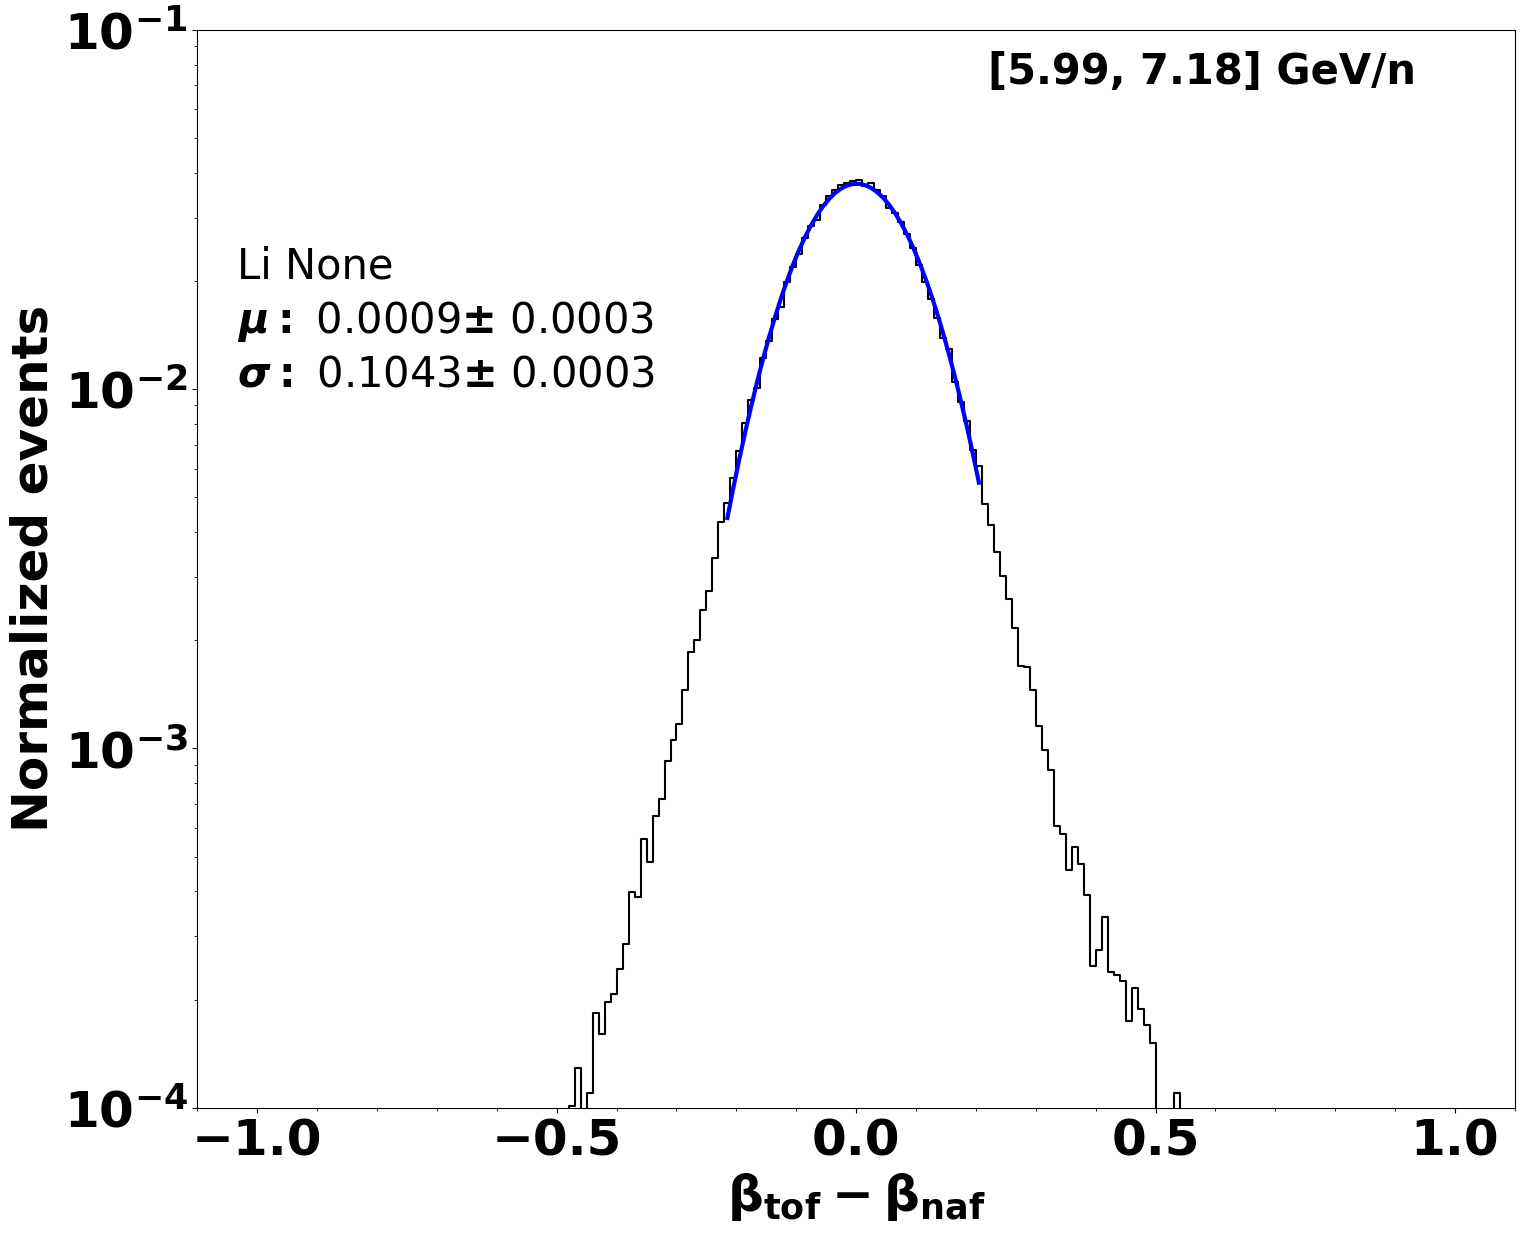

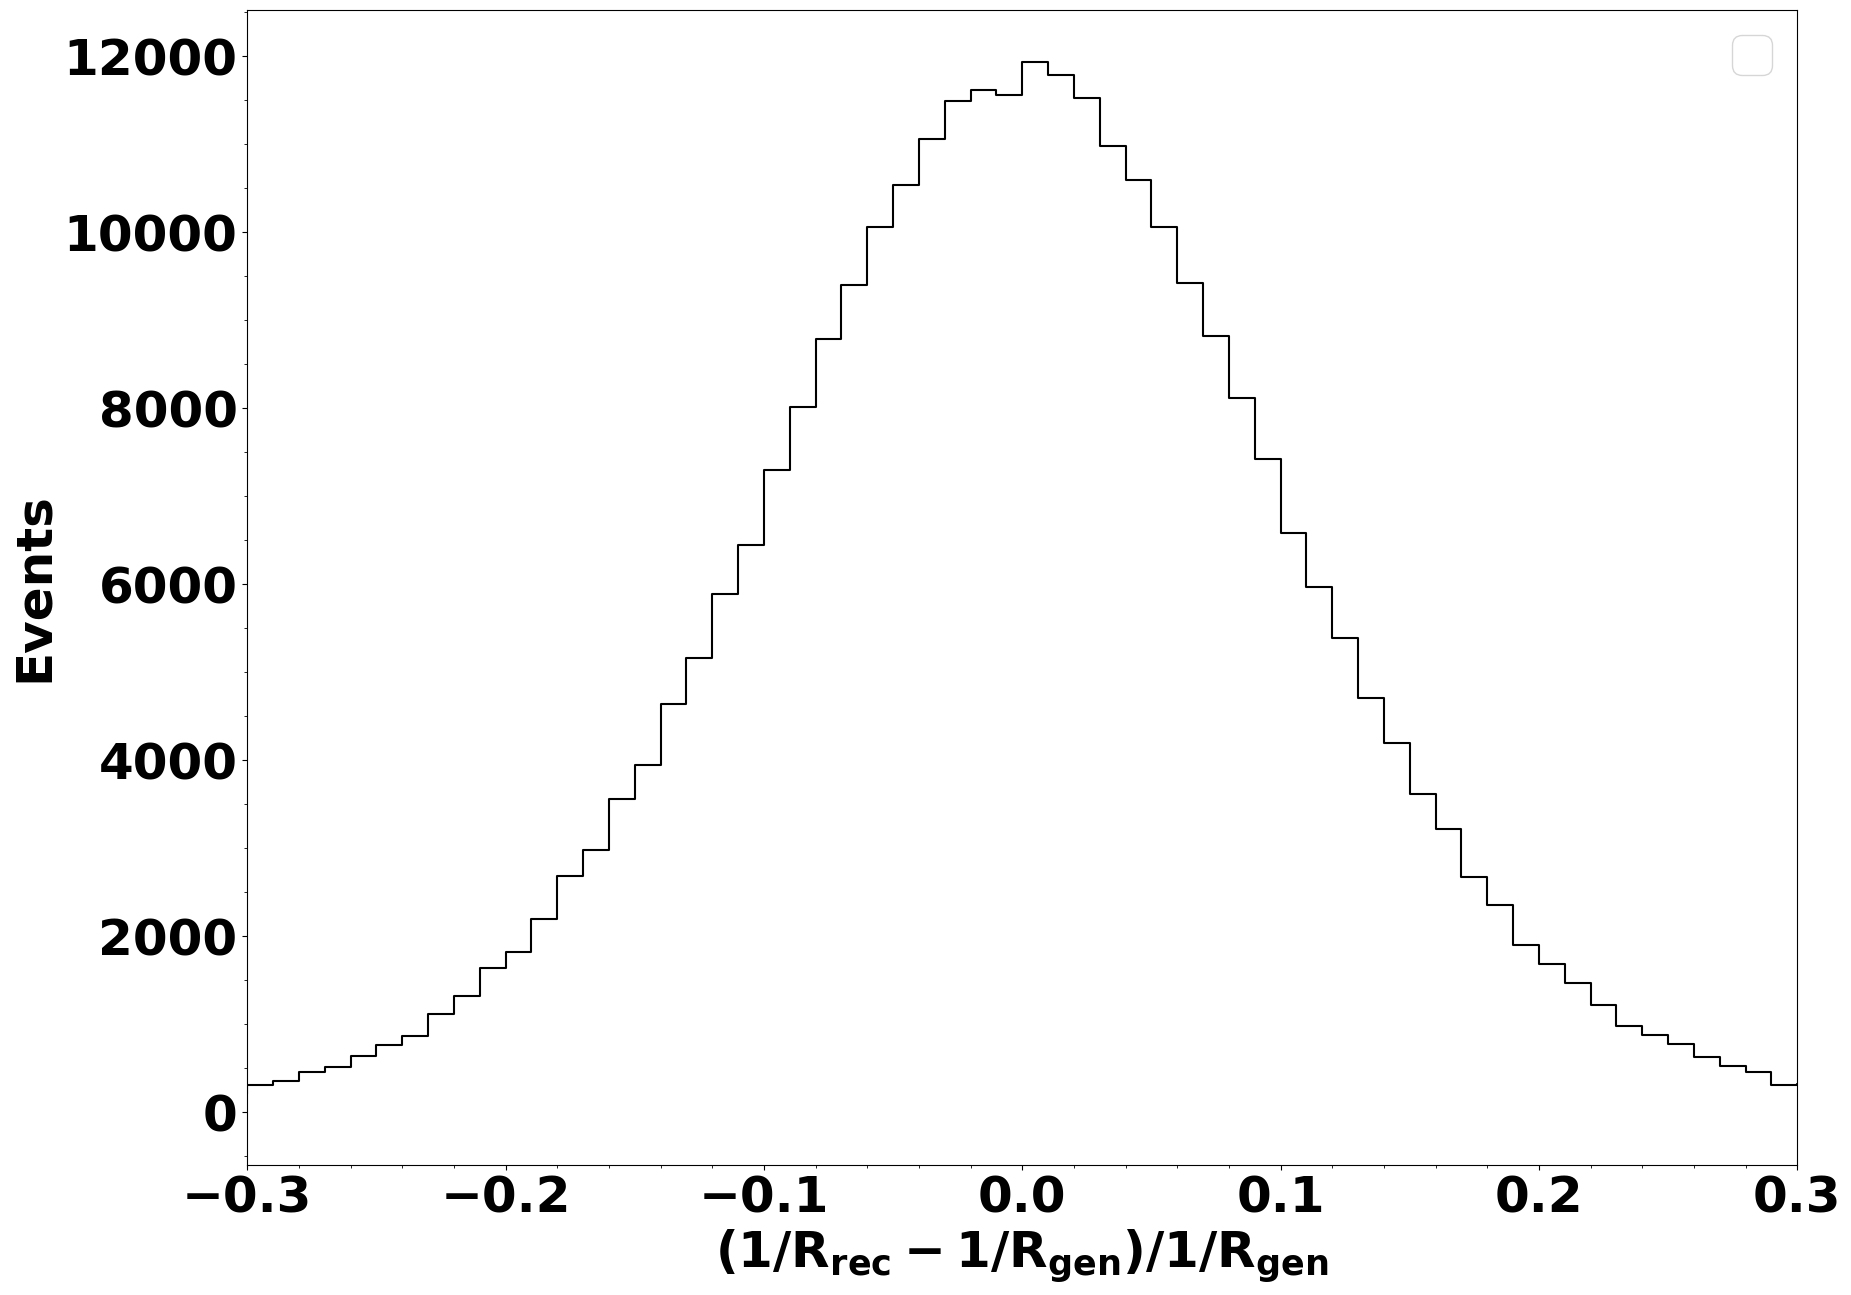

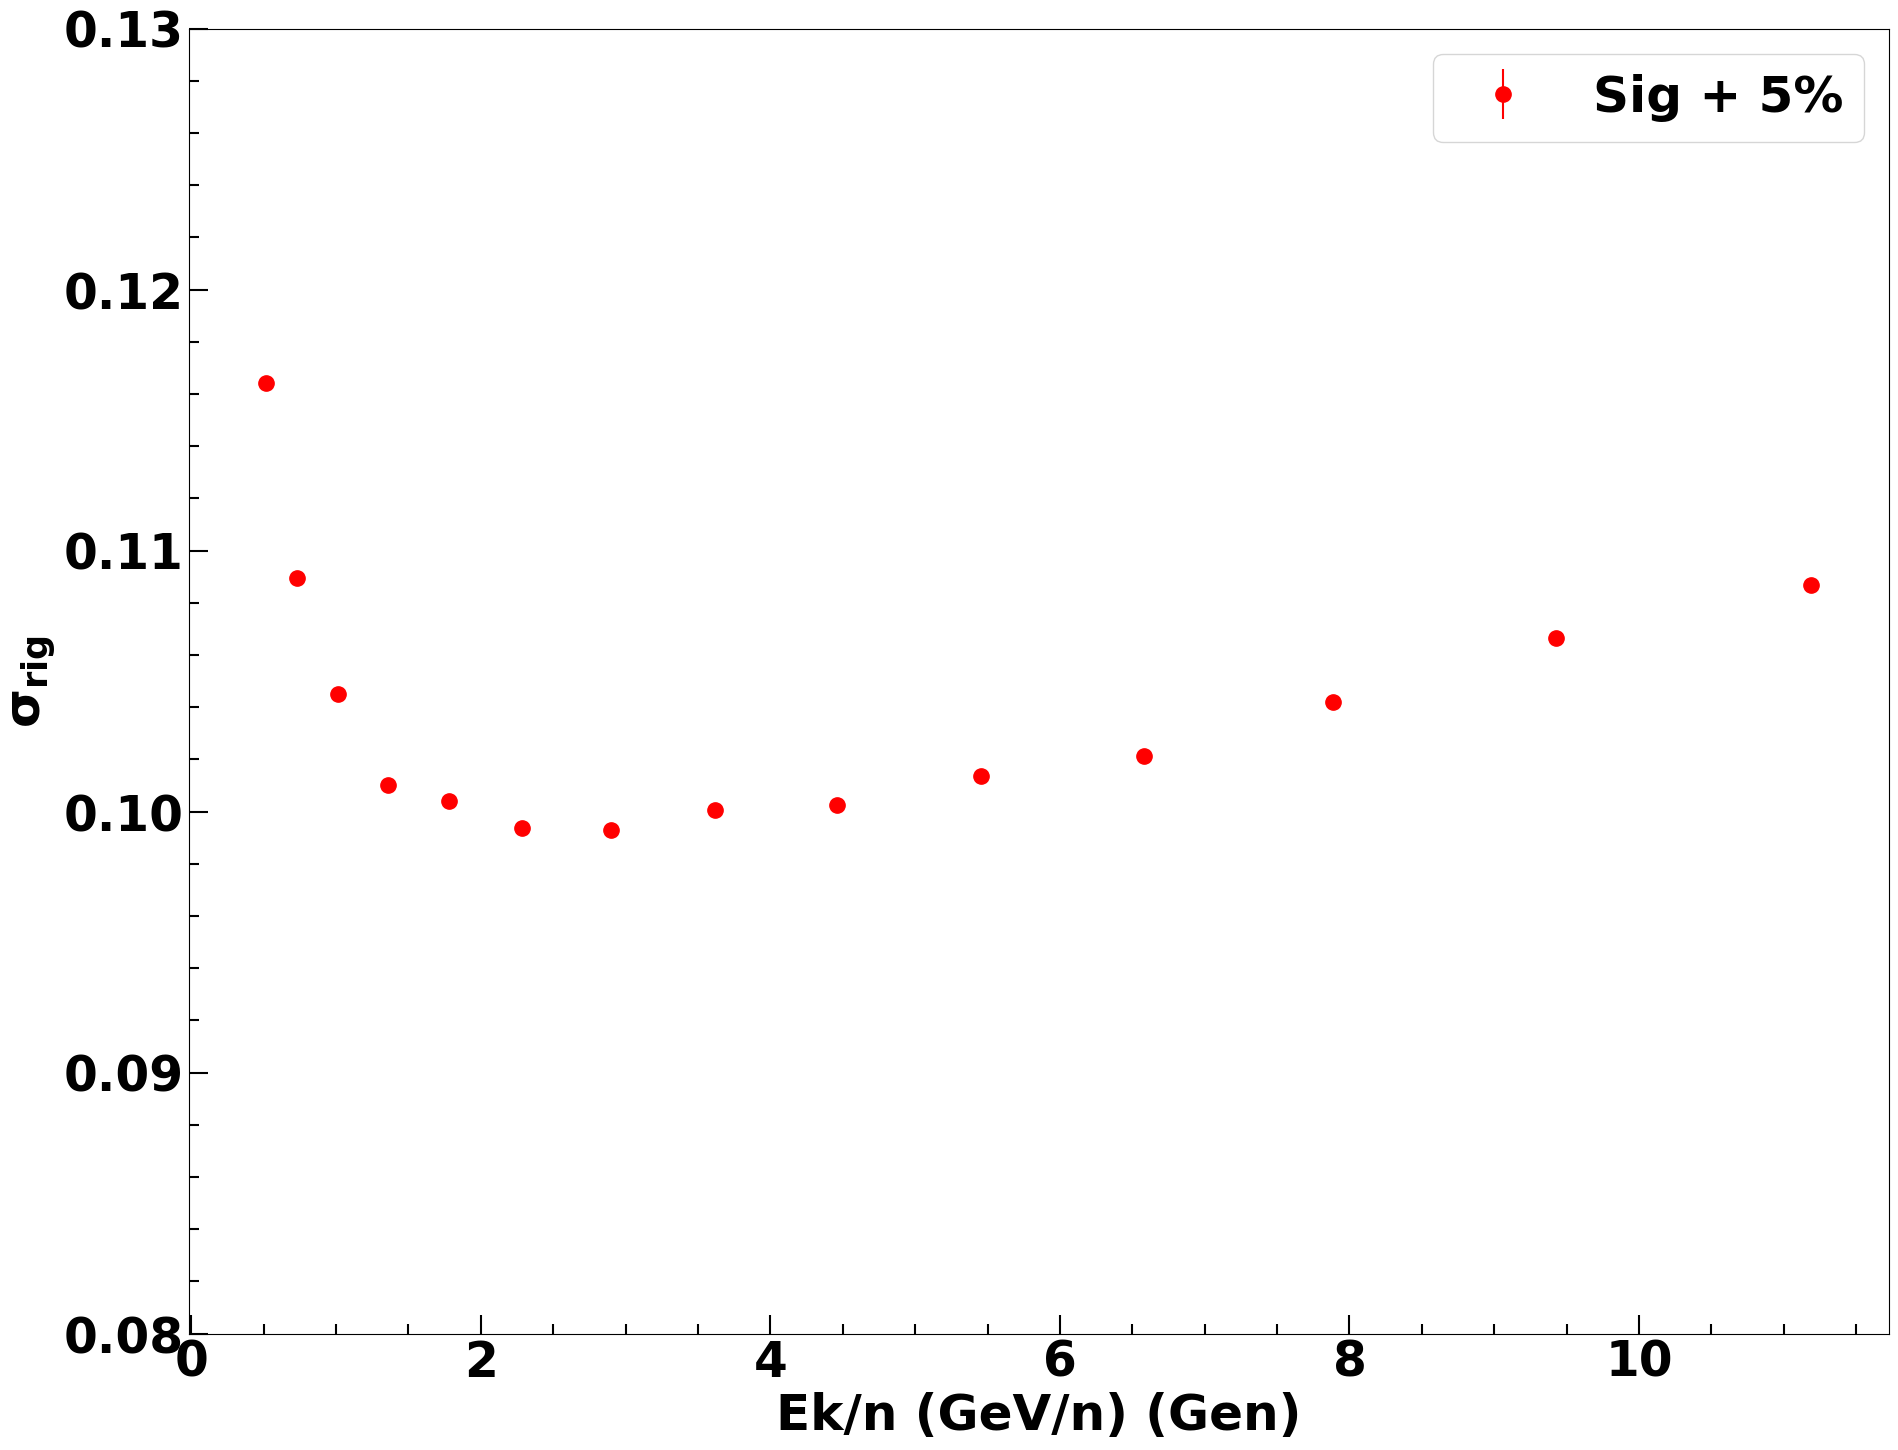

In [4]:
file_beta = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_hist_MassRig.npz'
 
hist2d_rig = {dec: {} for dec in detectors}
gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}
with np.load(file_beta) as npzfile:
    for dec in detectors:
        for iso in isotopes:
            hist2d_rig[dec][iso] = WeightedHistogram.from_file(npzfile, f"hist_rig_resolution_{dec}{iso}")                                                                                               

            

ibin = 4
hist_ibin = hist2d_rig['Tof']['Li6'].project(ibin)
graph_mean_rig = {}
graph_sigma_rig = {}
guessRig = dict(norm=1000, mu=0.001, sigma=0.1)
binrange = {'Tof': [1, 15], 'NaF': [4, 10], 'Agl': [8, 15]}
fitRangeRig = [-0.25, 0.25]
for iso in isotopes:
    
    graph_mean_rig[iso], graph_sigma_rig[iso] = get_musigma_gausfit(hist2d_rig['Tof'][iso], binrange['Tof'][0],  binrange['Tof'][1], guessRig, fitRangeRig)

fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1) 
plot_histogram_1d(plot, hist_ibin, style="mc", color="black", label="", scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False)

plot.legend()
plot.set_xlim([-0.3, 0.3])
savefig_tofile(fig, plotdir, f"Compare_RigReso_Onebin", show=True) 

fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
plot_graph(fig, ax1, graph_sigma_rig['Li6'], color='red',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Sig + 5%')  
#plot_graph(fig, ax1, graph_sigma_rigTailPlus, color='blue',  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'Be7 MC')  
ax1.set_ylim([0.08, 0.13])
ax1.set_xlabel('Ek/n (GeV/n) (Gen)')
ax1.set_ylabel(r'$\mathrm{\sigma_{rig}}$')
ax1.legend()
savefig_tofile(fig, plotdir, f"Compare_RigSigma", show=True) 

/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


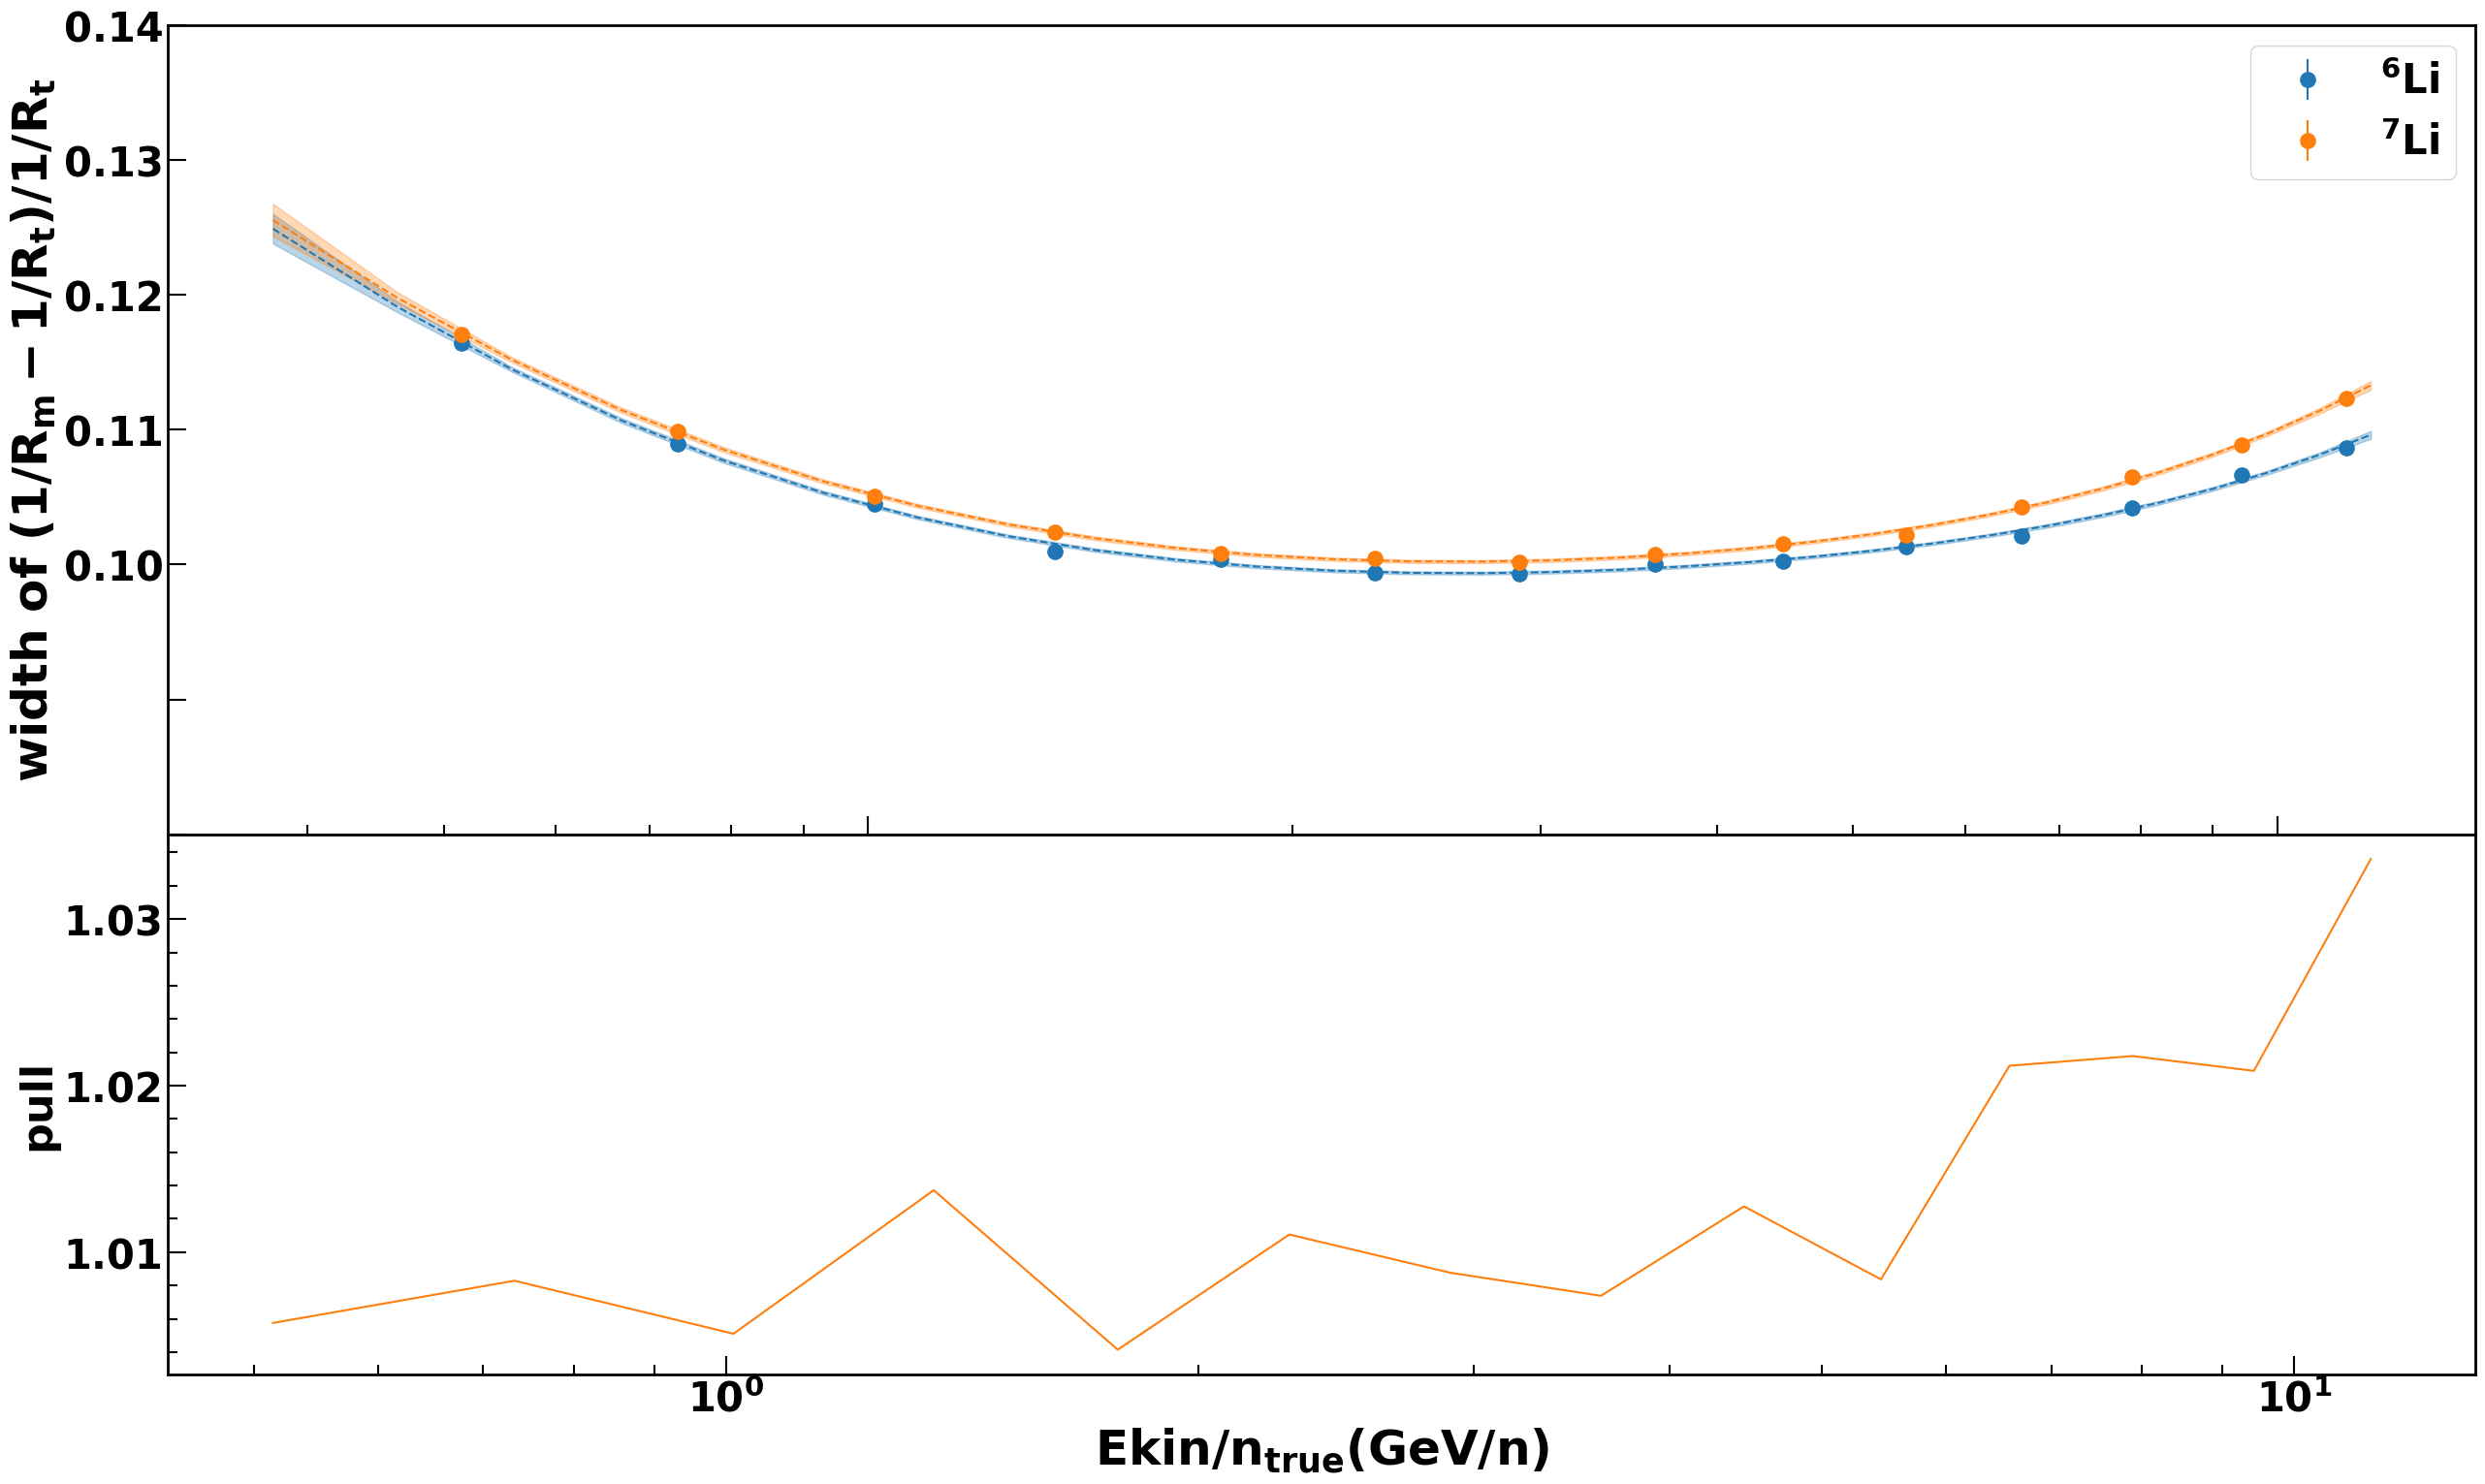

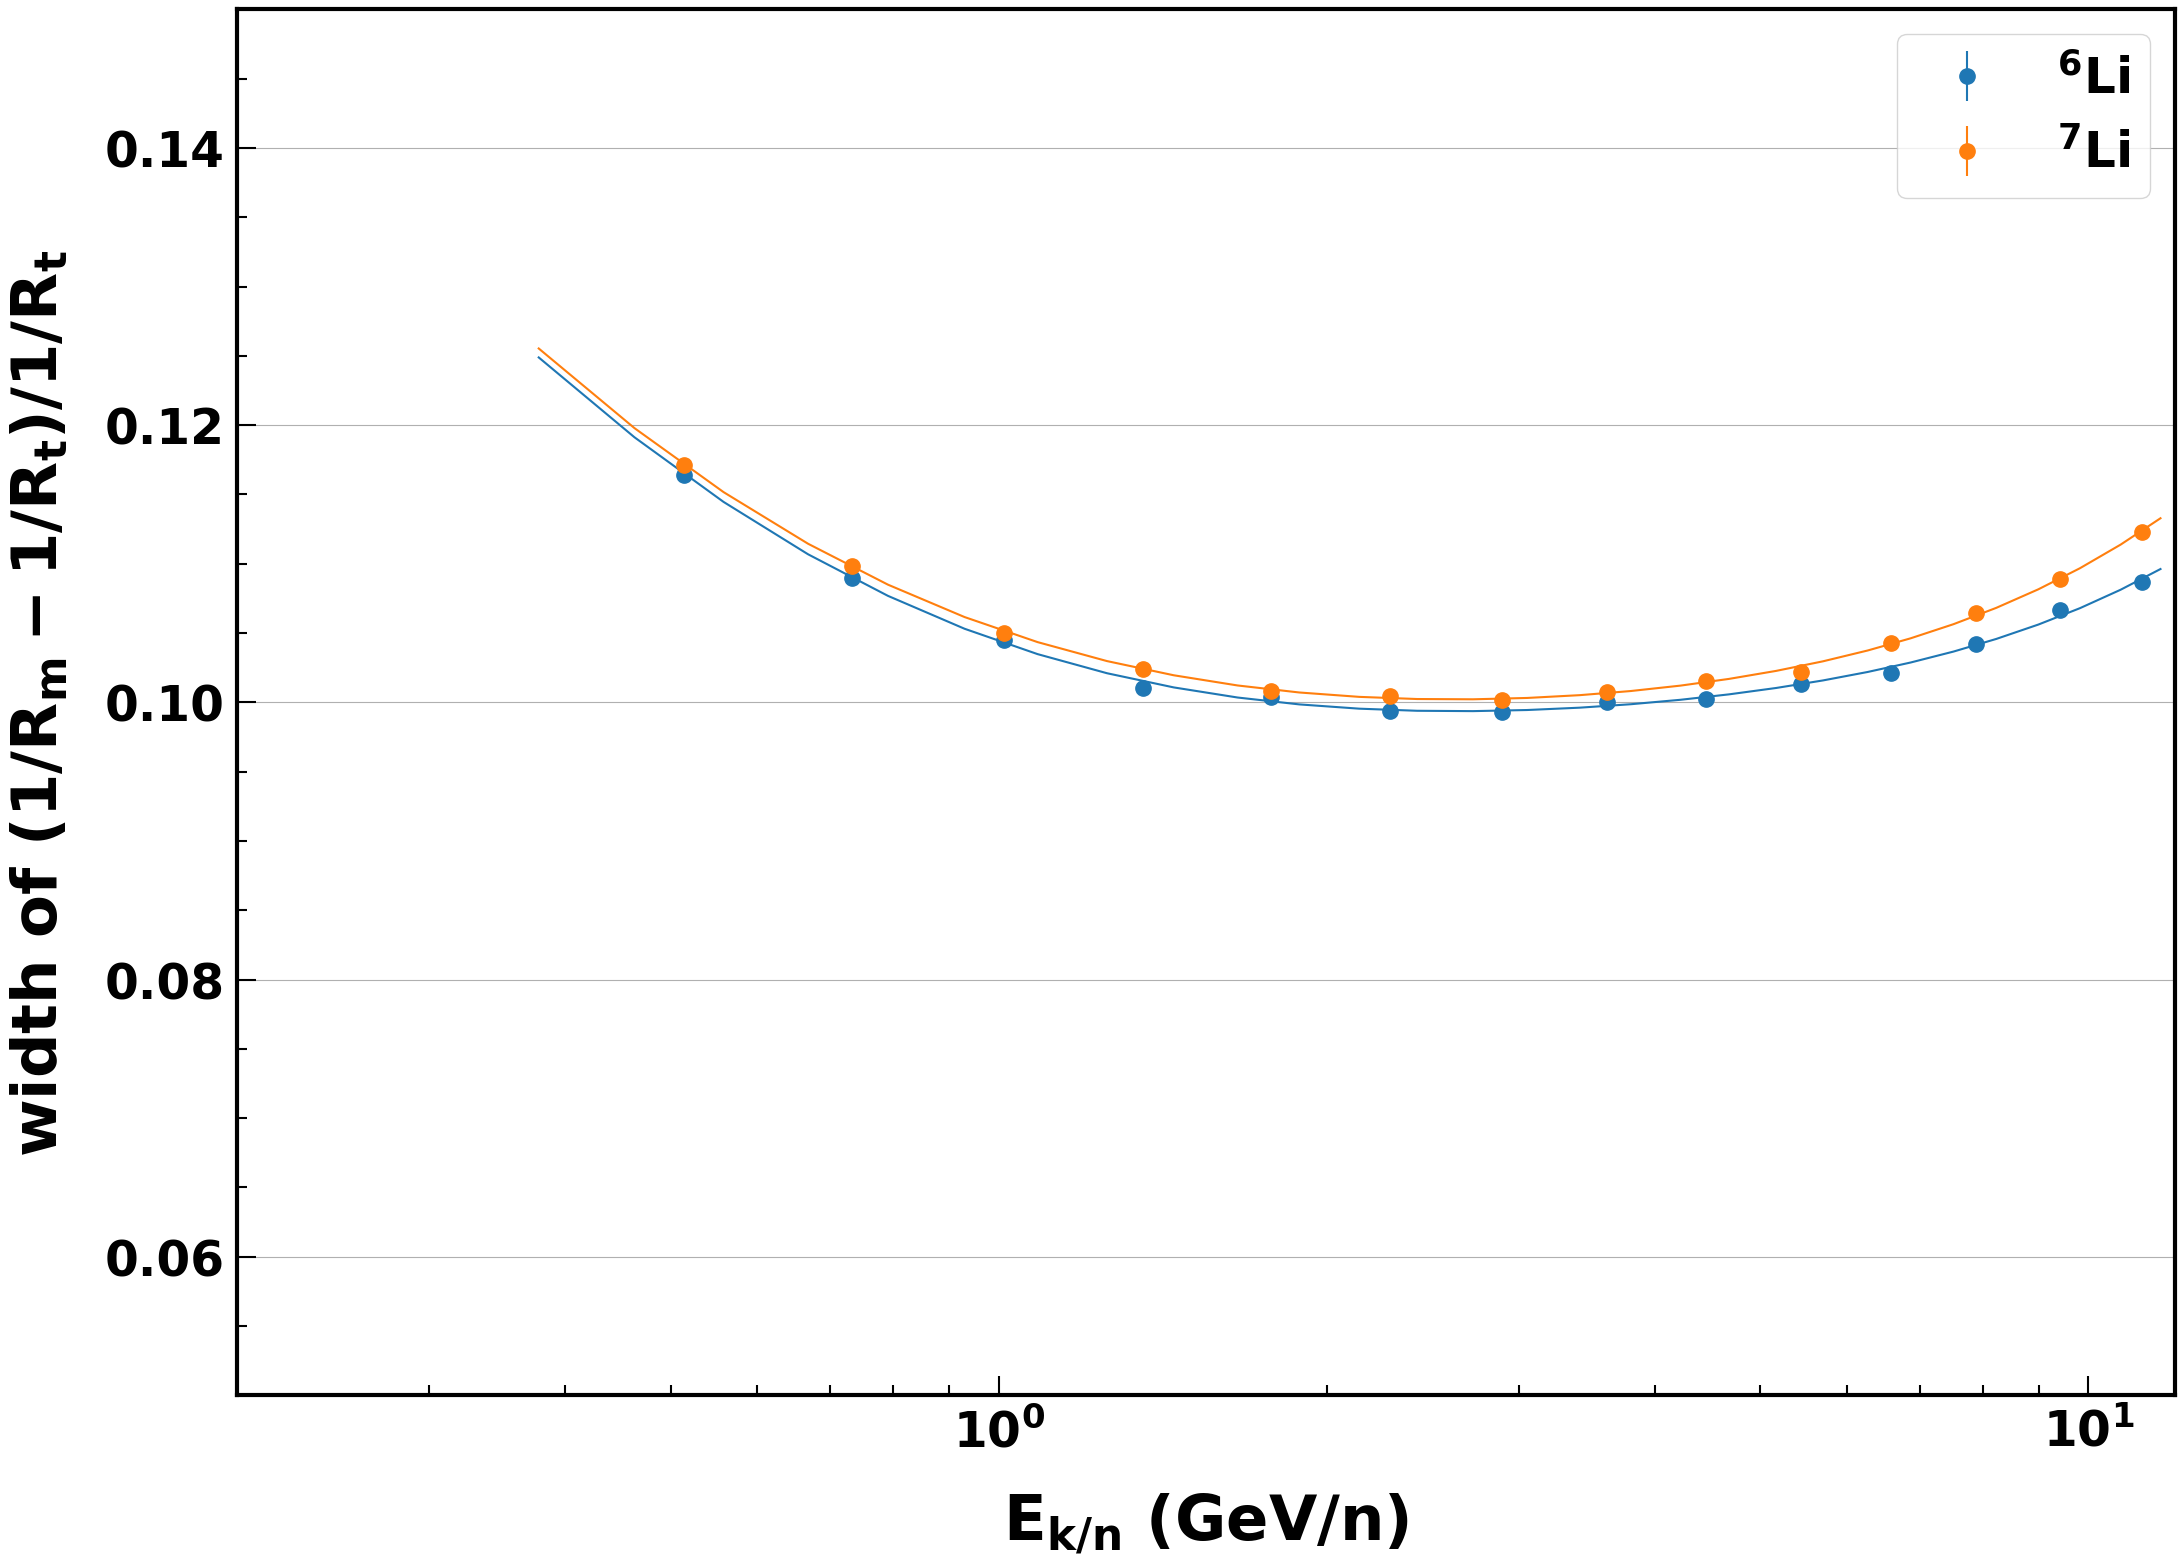

In [52]:
#filename_rigreso = '/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin9/df_reso_sigma.npz'
#filename_rigreso = f'/home/manbing/Documents/lithiumanalysis/scripts/plots/{nuclei}P8/GBLRig/df_reso_sigma.npz'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_vsEkin9/'

def get_pull_graph(graph, yfit):
    pull = (graph.yvalues - yfit)/ (2 * graph.yerrs)
    return MGraph(graph.xvalues, pull, np.zeros_like(pull))


#df_sigma = np.load(f'{filename_rigreso}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_rigreso_sigma = dict()
graphfitted_rigreso_sigma = dict()
dict_polypar = dict()

for iso in isotopes:
    #graph_rigreso_sigma[iso] = MGraph.from_file(df_sigma, f"graph_sigma_Tof_{iso}")
    graph_rigreso_sigma[iso] = graph_sigma_rig[iso]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(28, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_rigreso_sigma[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_rigreso_sigma[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_rigreso_sigma[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 7)), sigma=graph_rigreso_sigma[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar[iso] = polypars
    
    rig_xvalue_finebin = get_bin_center(fbinning_energy())
    yfit, yfit_err = get_fitpdf_witherr(np.log(rig_xvalue_finebin), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(rig_xvalue_finebin), polypars, upoly) 
    
    
    graphfitted_rigreso_sigma[iso] = MGraph(rig_xvalue_finebin, yfit, yfit_err)
    ax1.plot(rig_xvalue_finebin, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(rig_xvalue_finebin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    
    #graphpull = get_pull_graph(graph_rigreso_sigma[iso], yfit)
    #plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
    
graph_ratio = graph_rigreso_sigma['Li7']/graph_rigreso_sigma['Li6']

plot_graph(fig, ax2, graph_ratio, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22)
#ax2.set_xlabel('Rigidity (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylabel(r'$\mathrm{width~of~(1/R_{m} - 1/R_{t})/1/R_{t}}$')
ax2.set_xlabel(r'$\mathrm{Ekin/n_{true} (GeV/n)}$') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax2.set_ylabel('pull', fontsize=32)
#ax2.set_ylim([-3, 3])
ax1.set_ylim([0.08, 0.14])
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xscale('log')
ax2.set_xscale('log')
#ax2.set_xticks(np.array([2, 4, 10, 20, 40]))
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, f"rigidity_resolutionVsEkin_P8GBL", show=True) 

#savefig_tofile(fig, plotfile, f"rigidity_resolution_vs_ekin_v1", show=True) 
################################################################
#Plot only ax1
fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))    
set_plot_style(ax1)  
for iso in isotopes: 
    plot_graph(fig, ax1, graph_rigreso_sigma[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    plot_graph(fig, ax1, graphfitted_rigreso_sigma[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=None)  
ax1.legend()
SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV/n)}$', r'$\mathrm{width~of~(1/R_{m} - 1/R_{t})/1/R_{t}}$', TEXTSIZE+5, xlimrange=[0.2, 12], ylimrange=[0.05, 0.15], 
           custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=True, setylog=False, setxlog=True)

print(plotdir)
savefig_tofile(fig, plotdir, f"Li_rigidity_resolutionVsEkin_P8GBL", show=True) 

plot gamma

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.9738693672272483


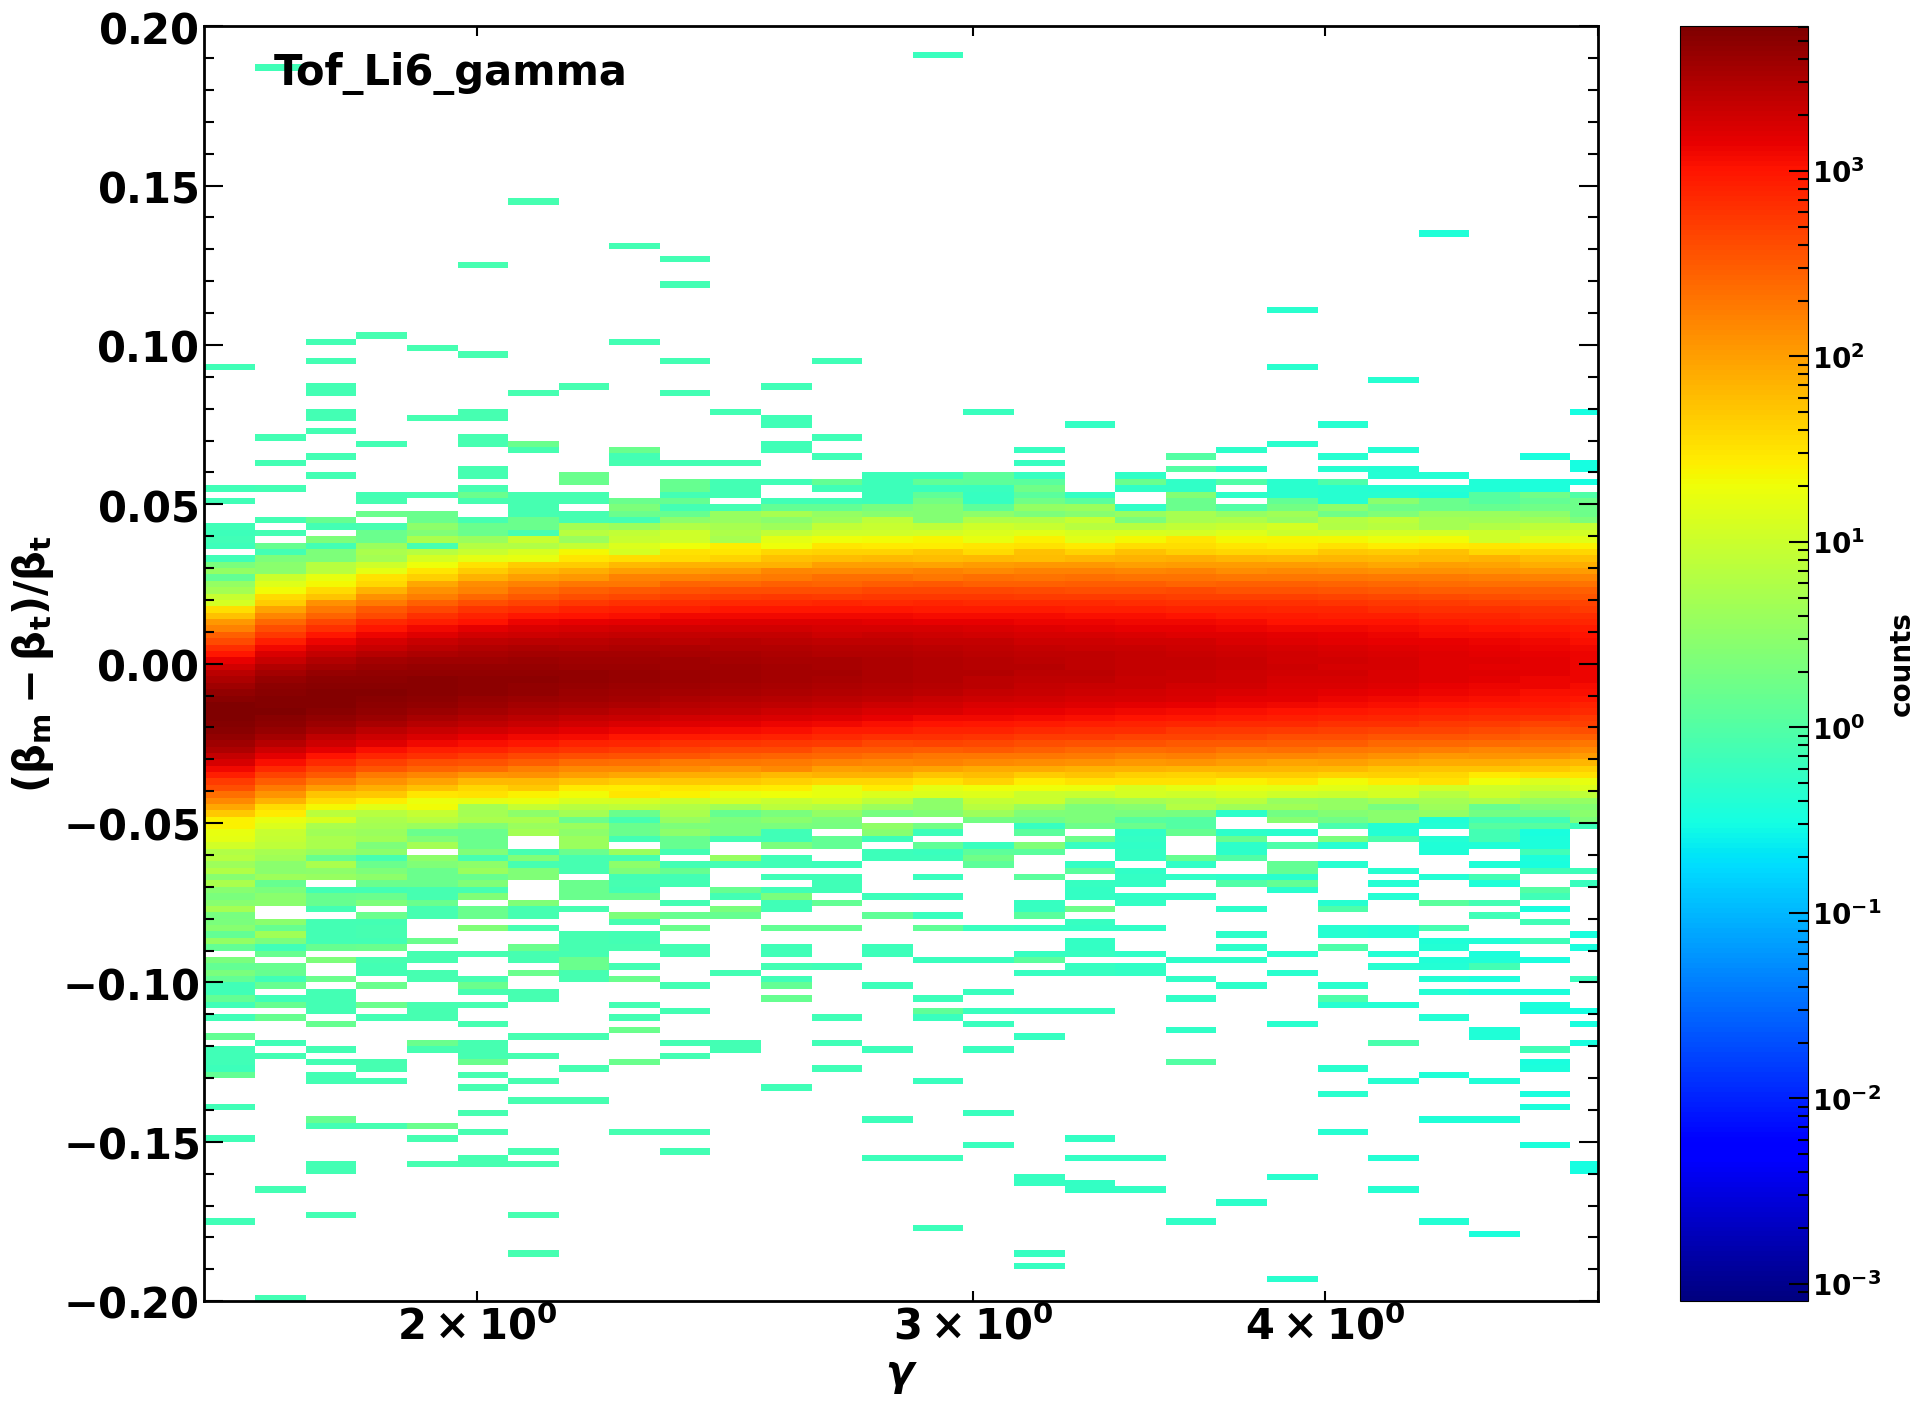

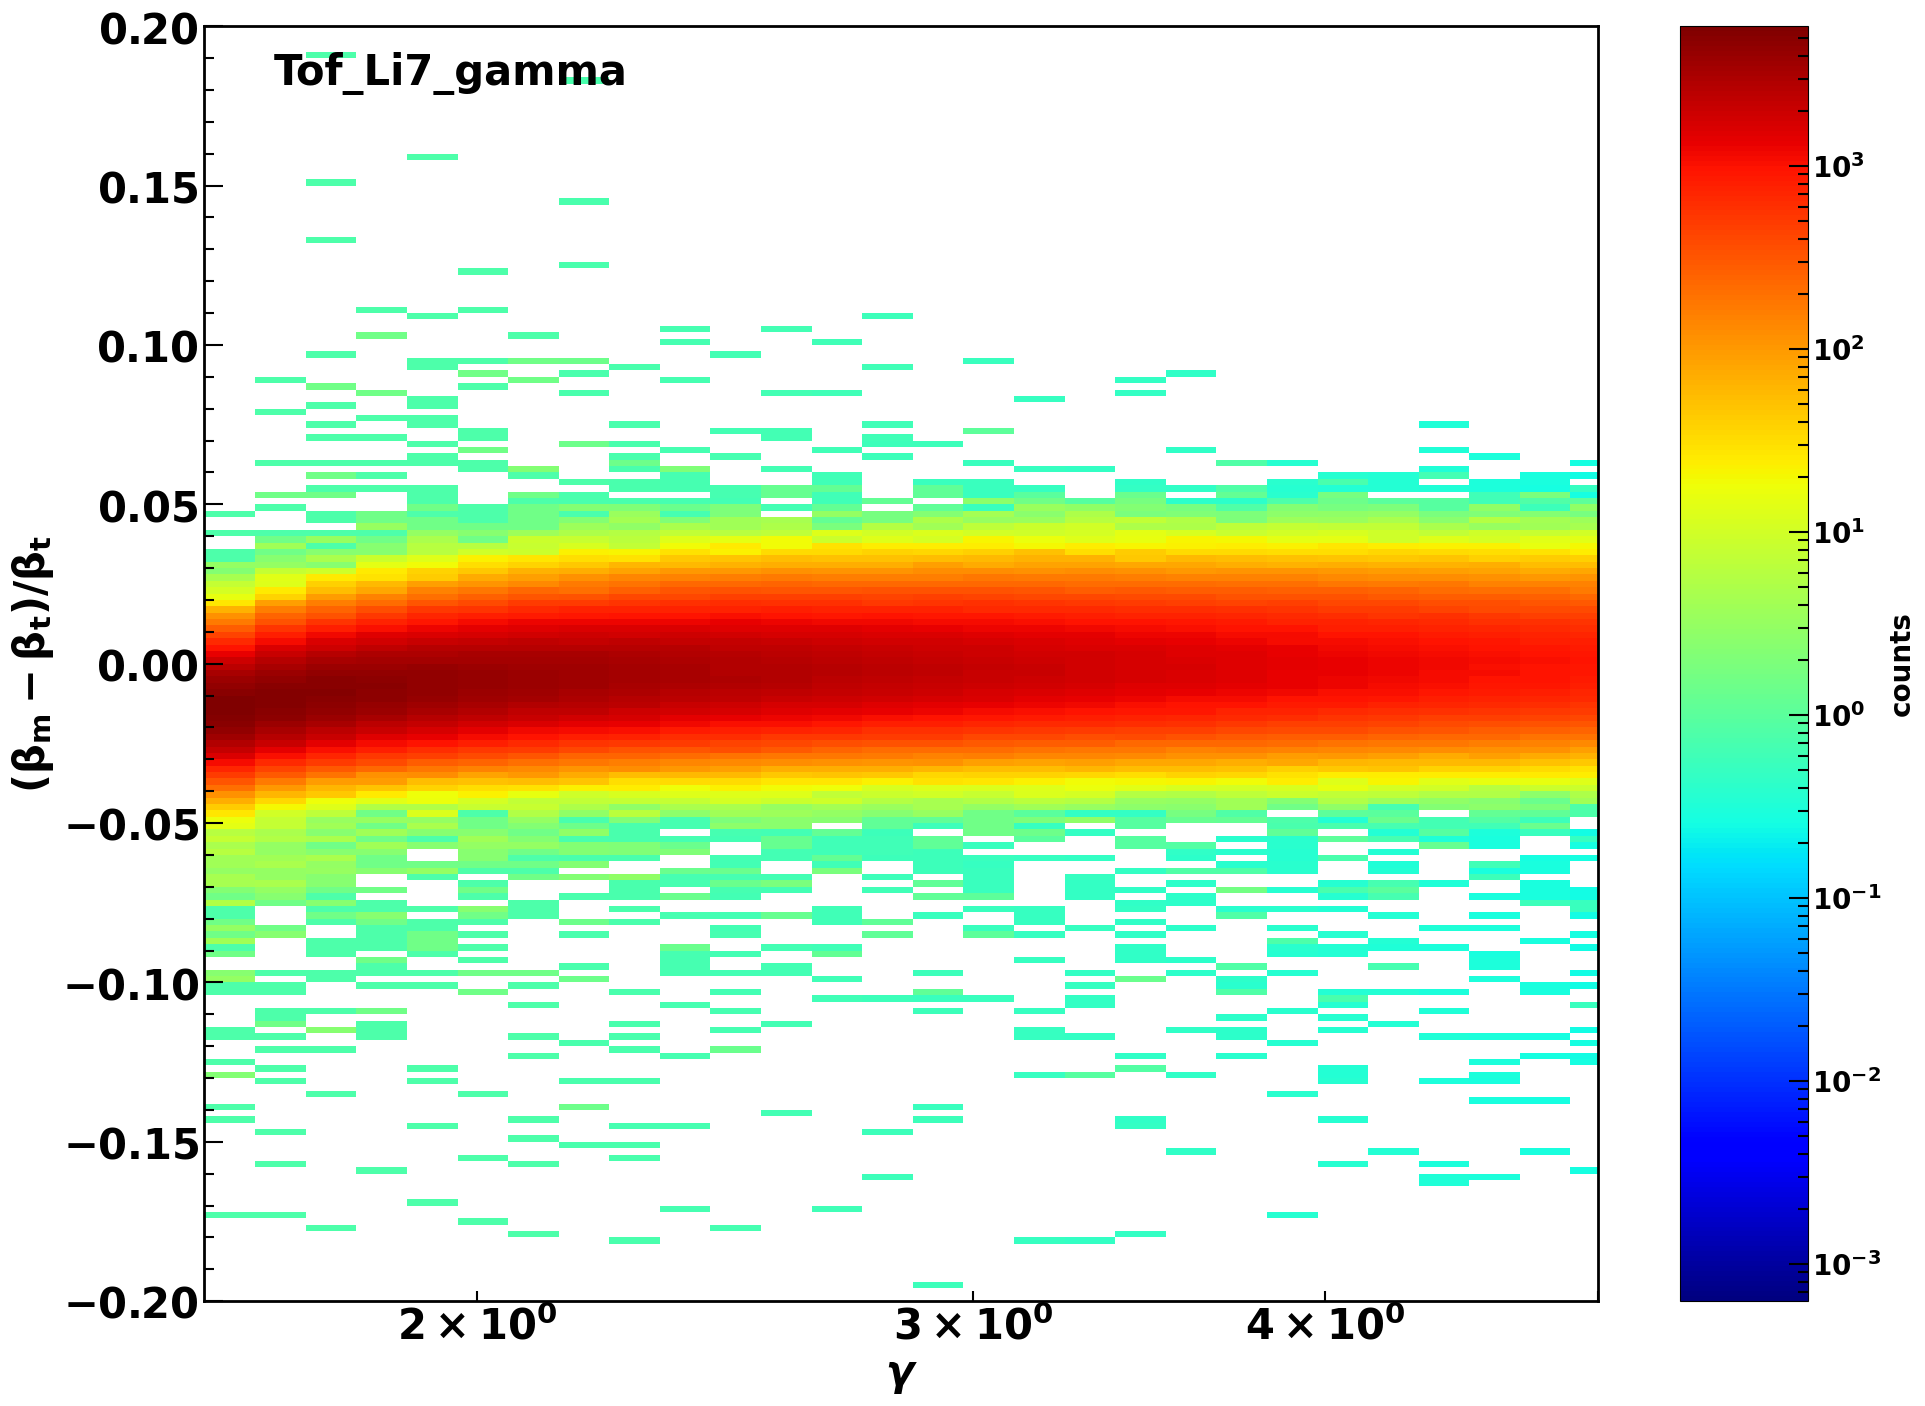

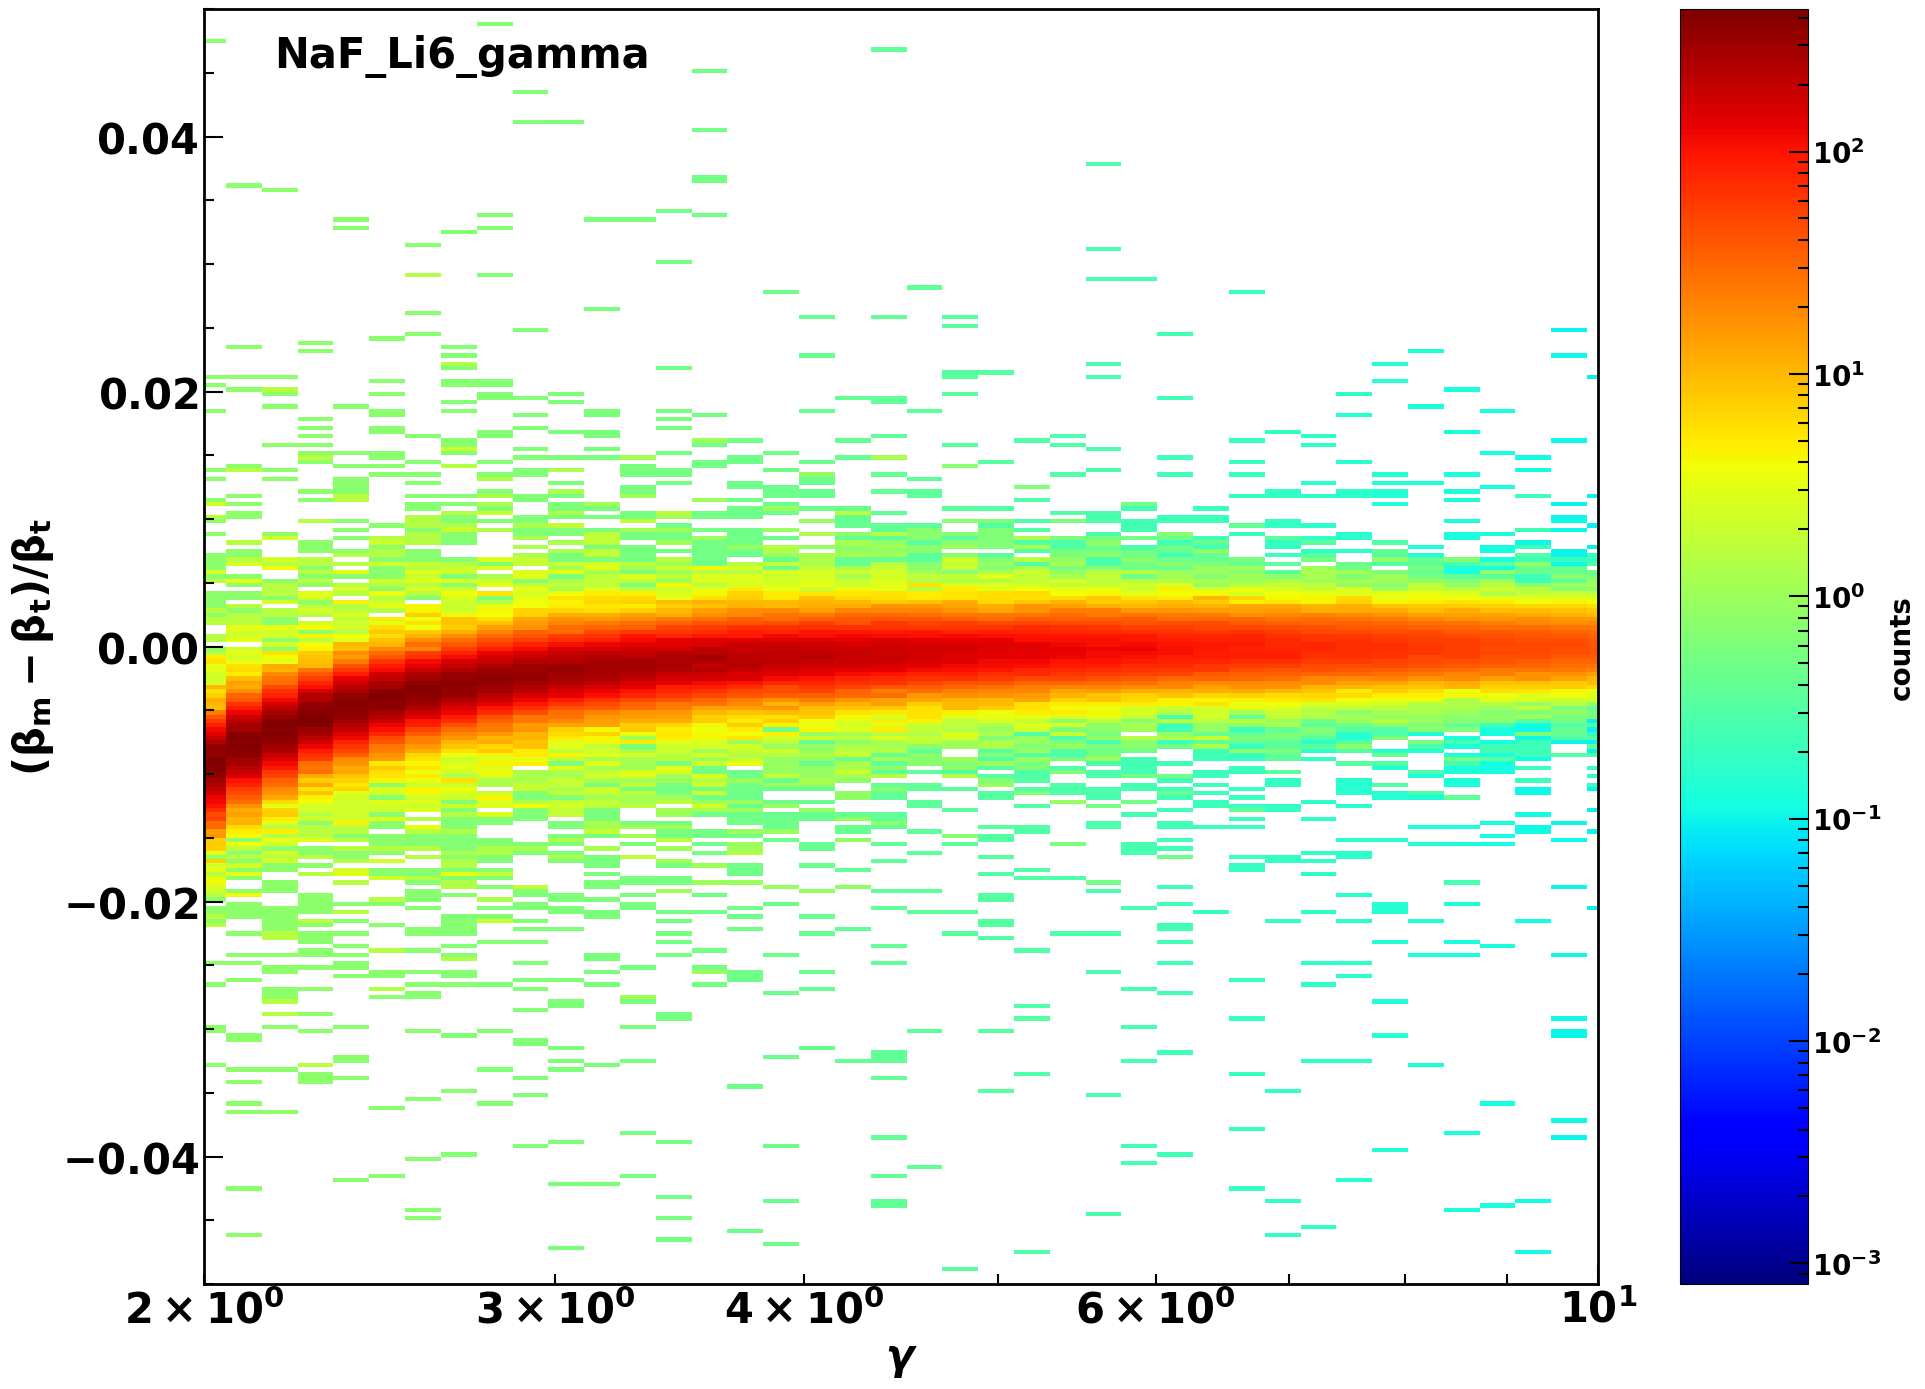

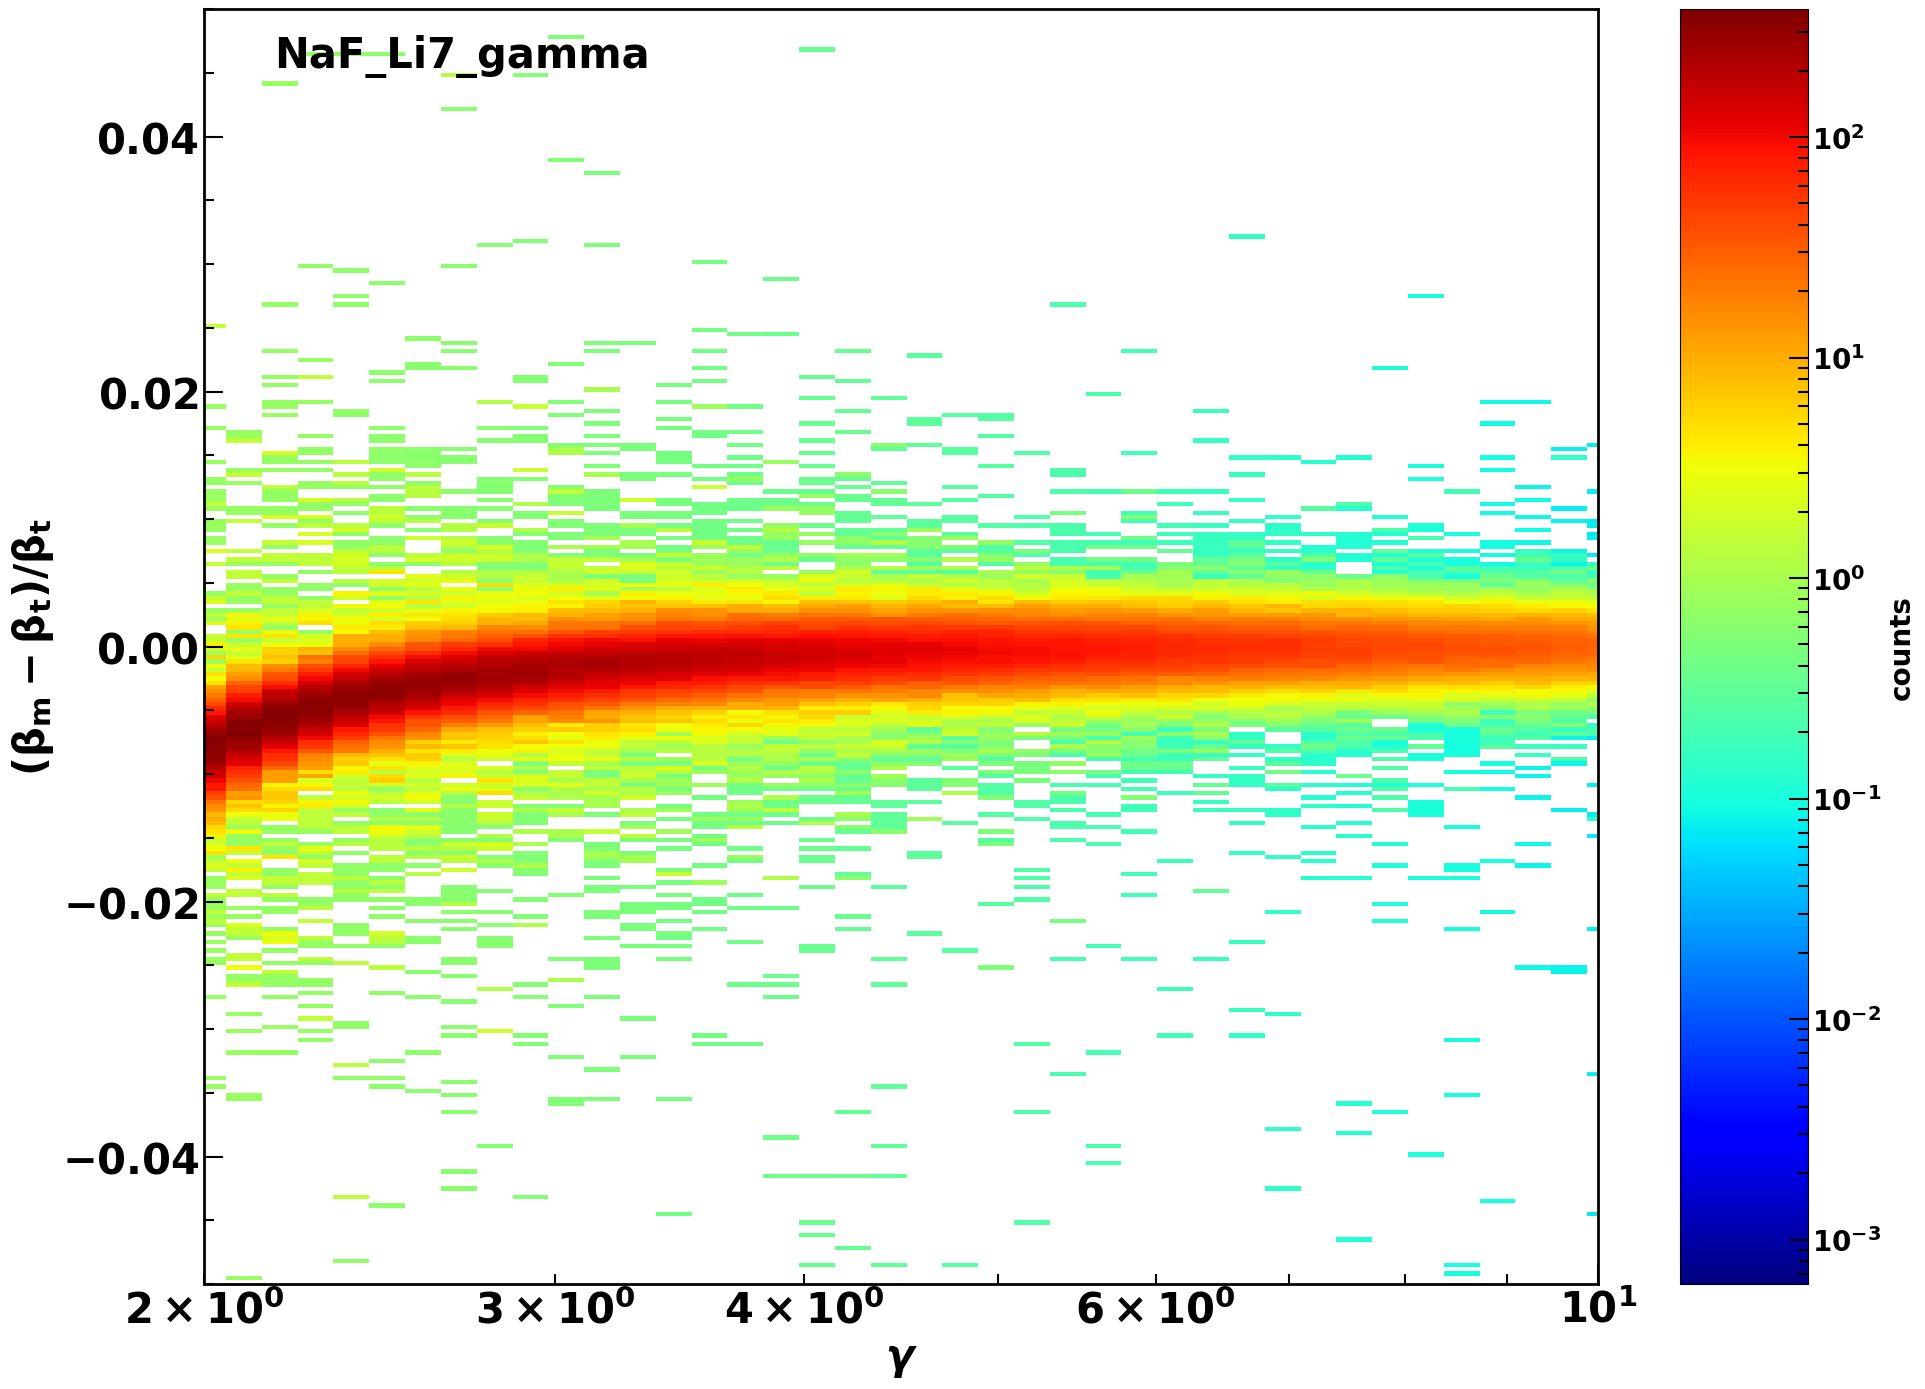

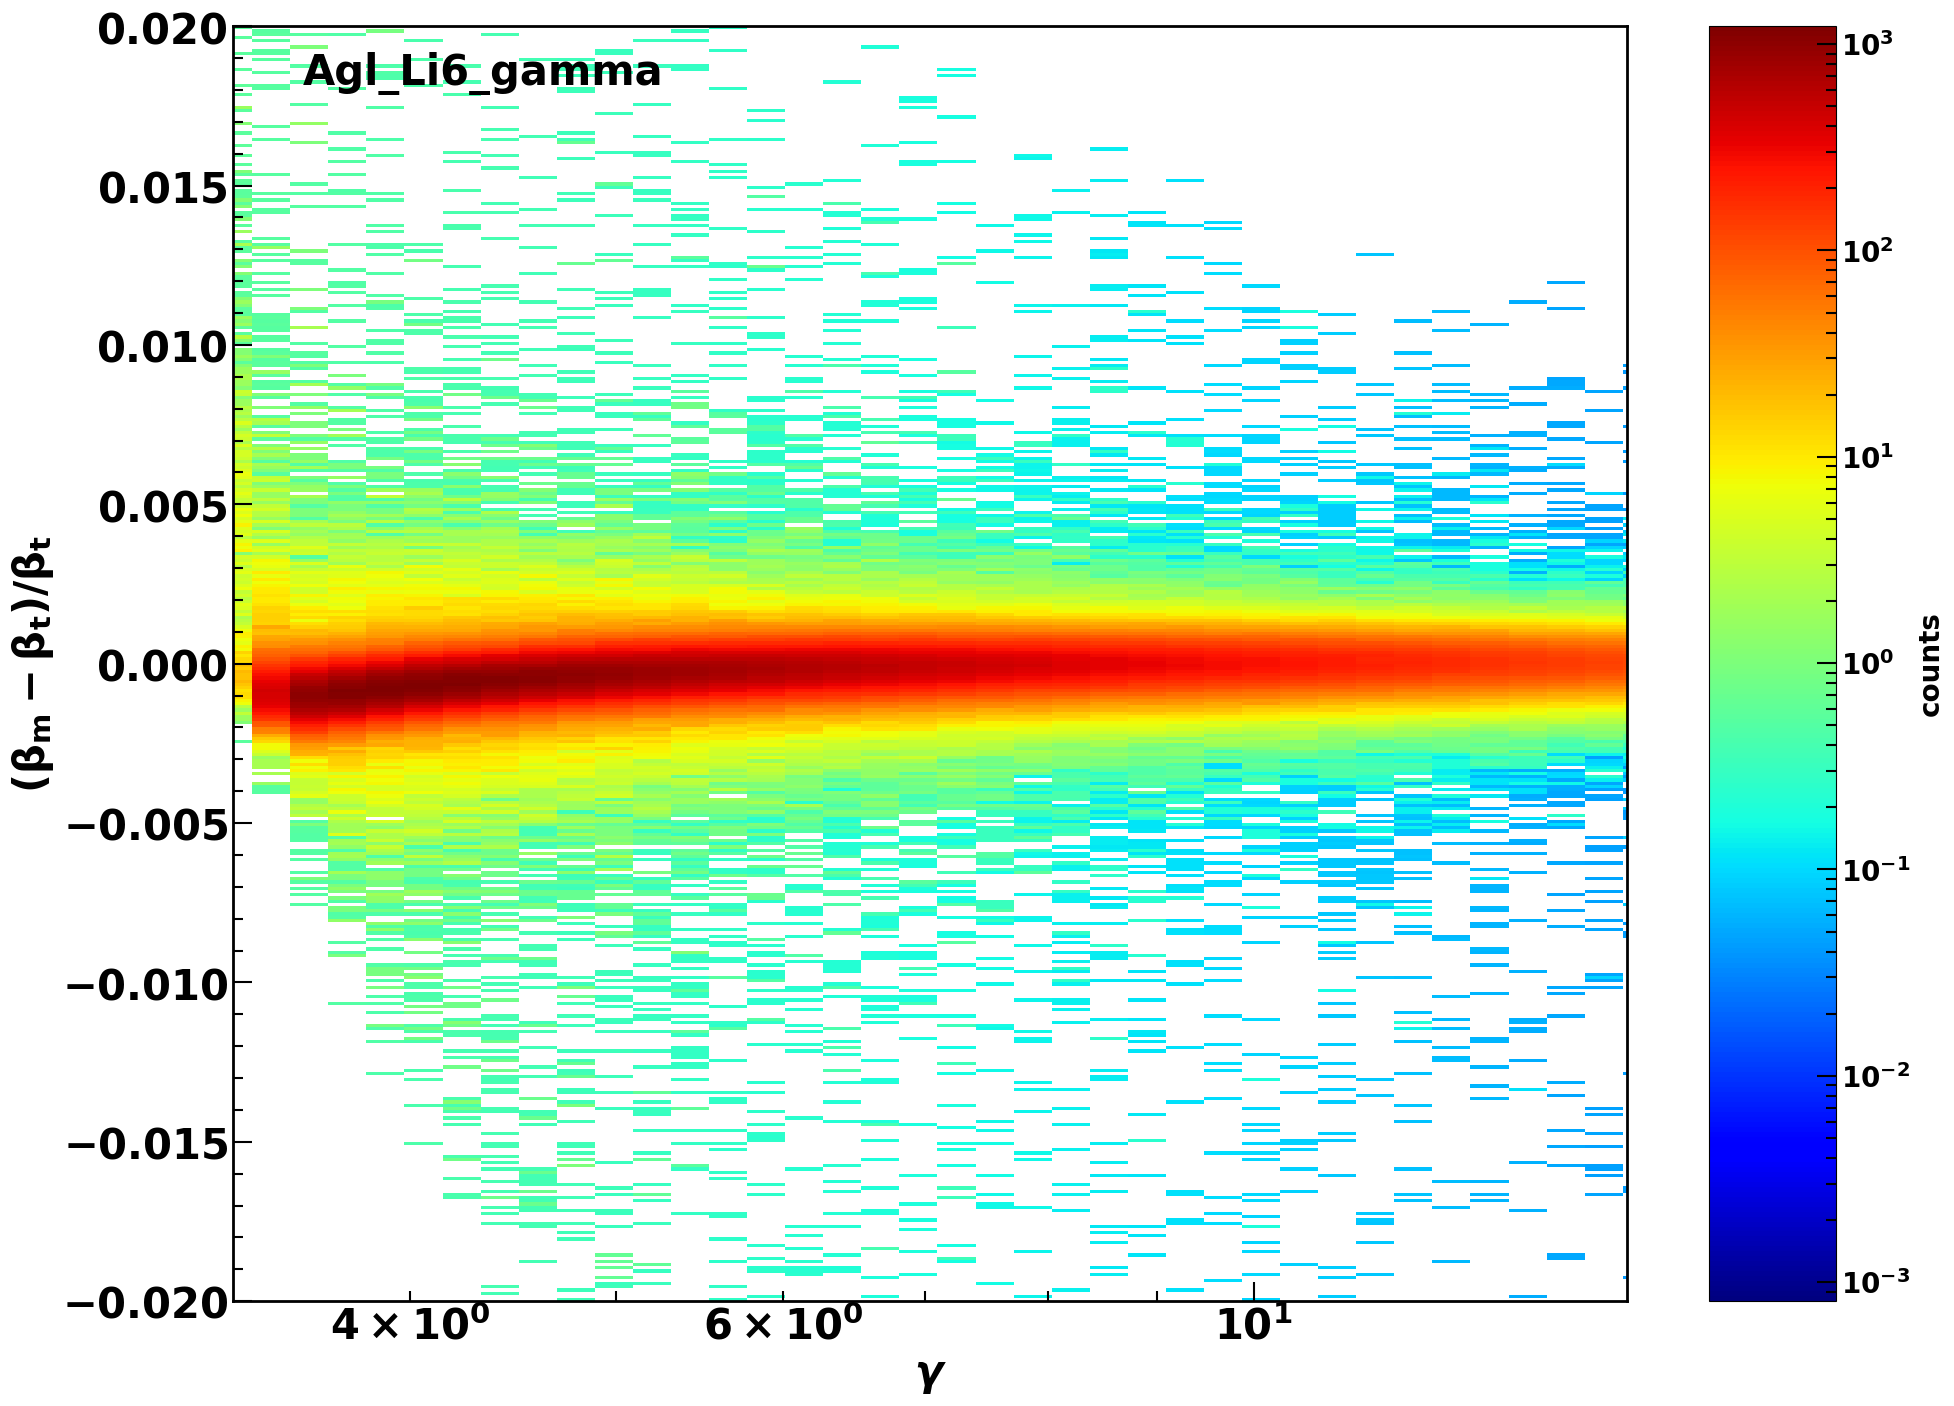

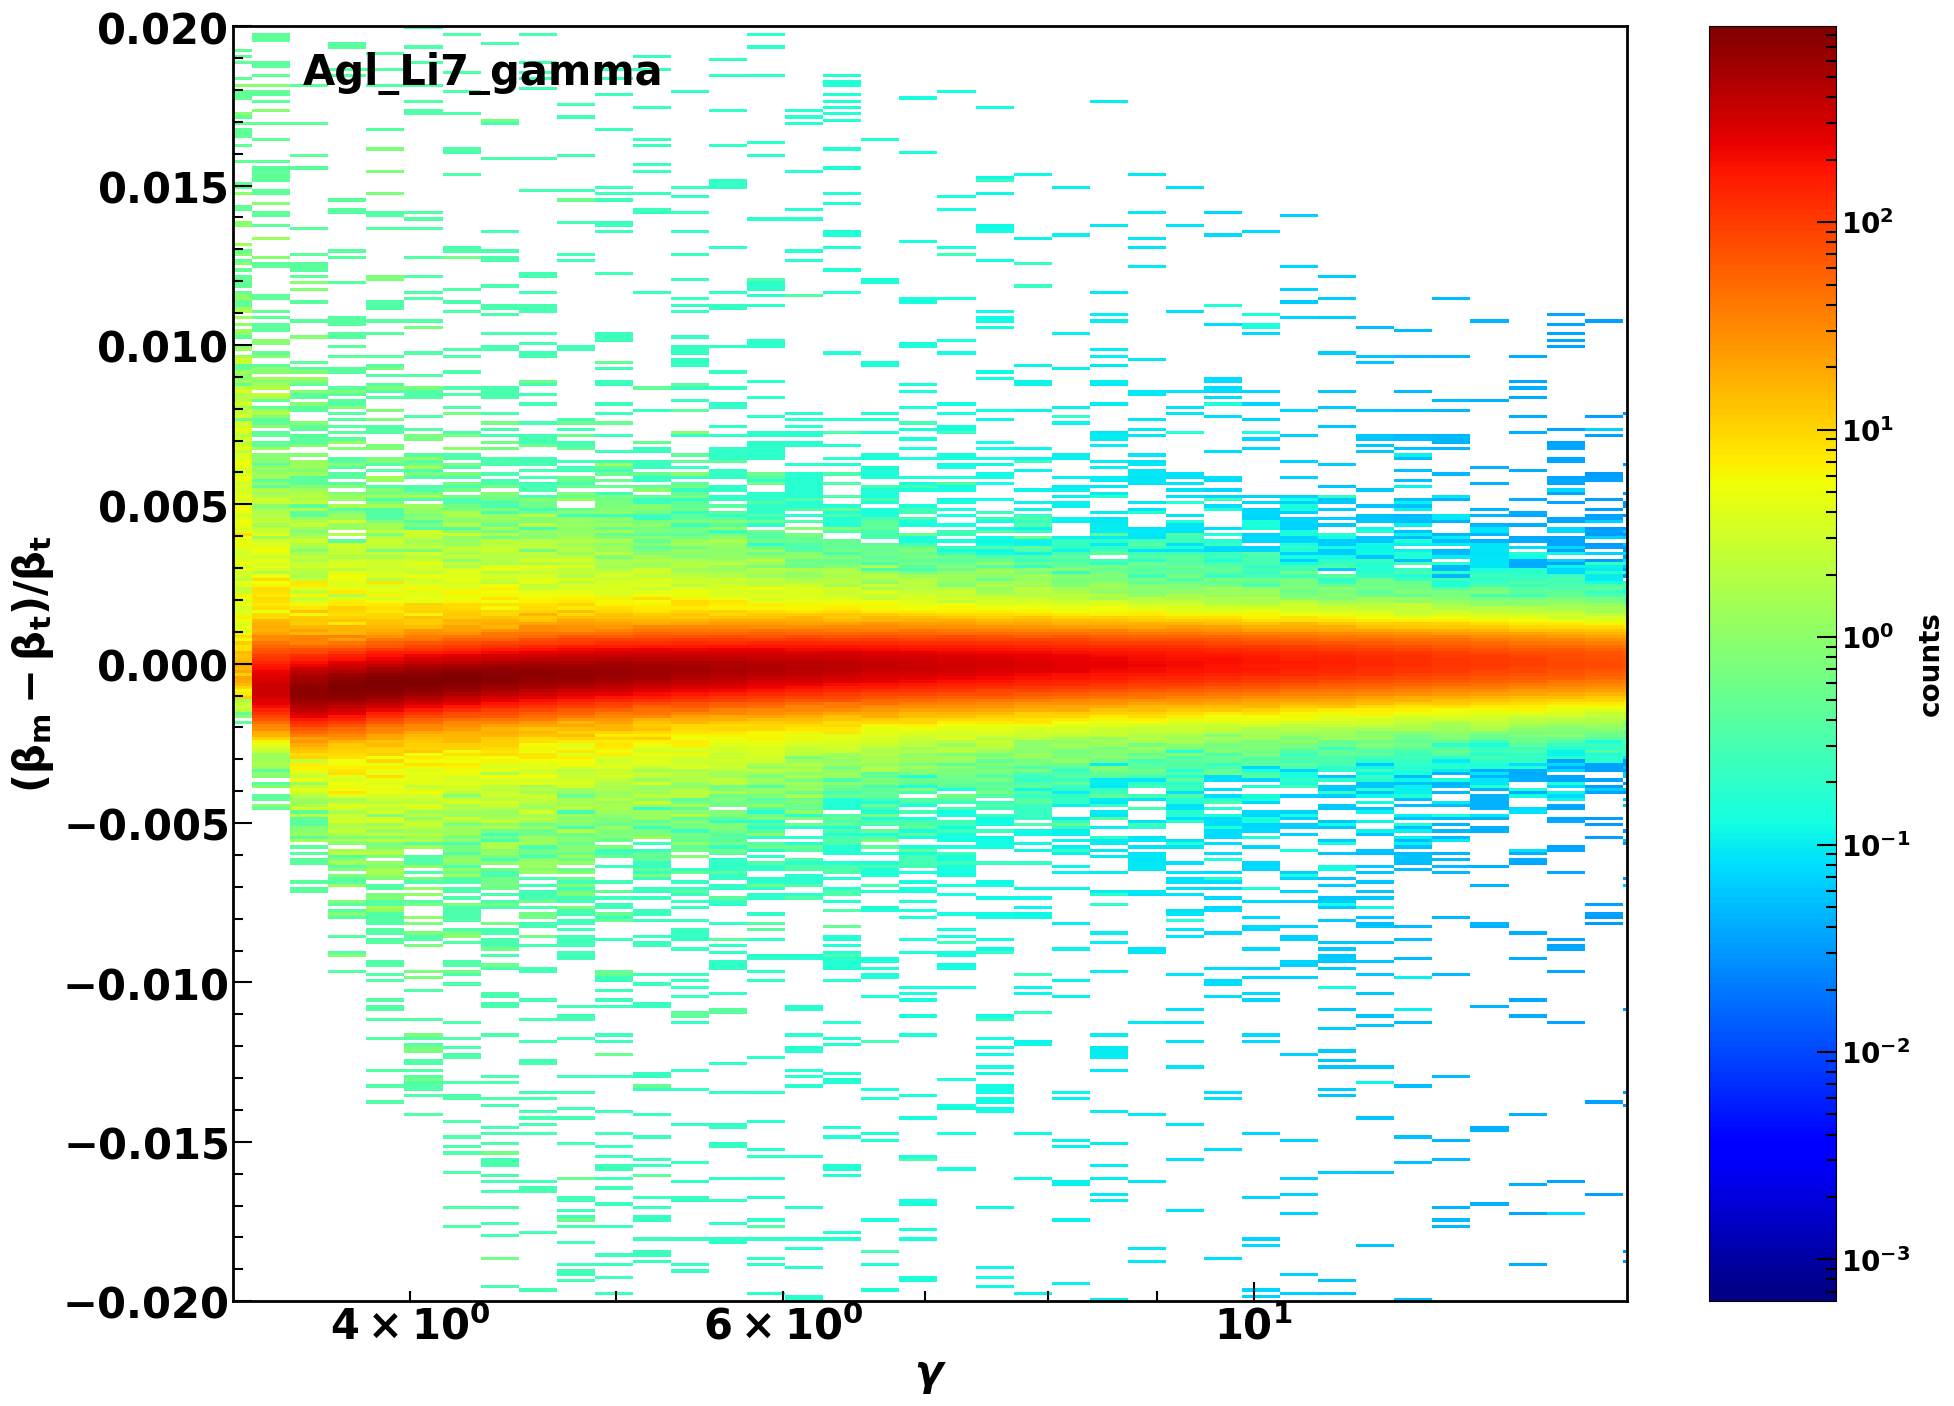

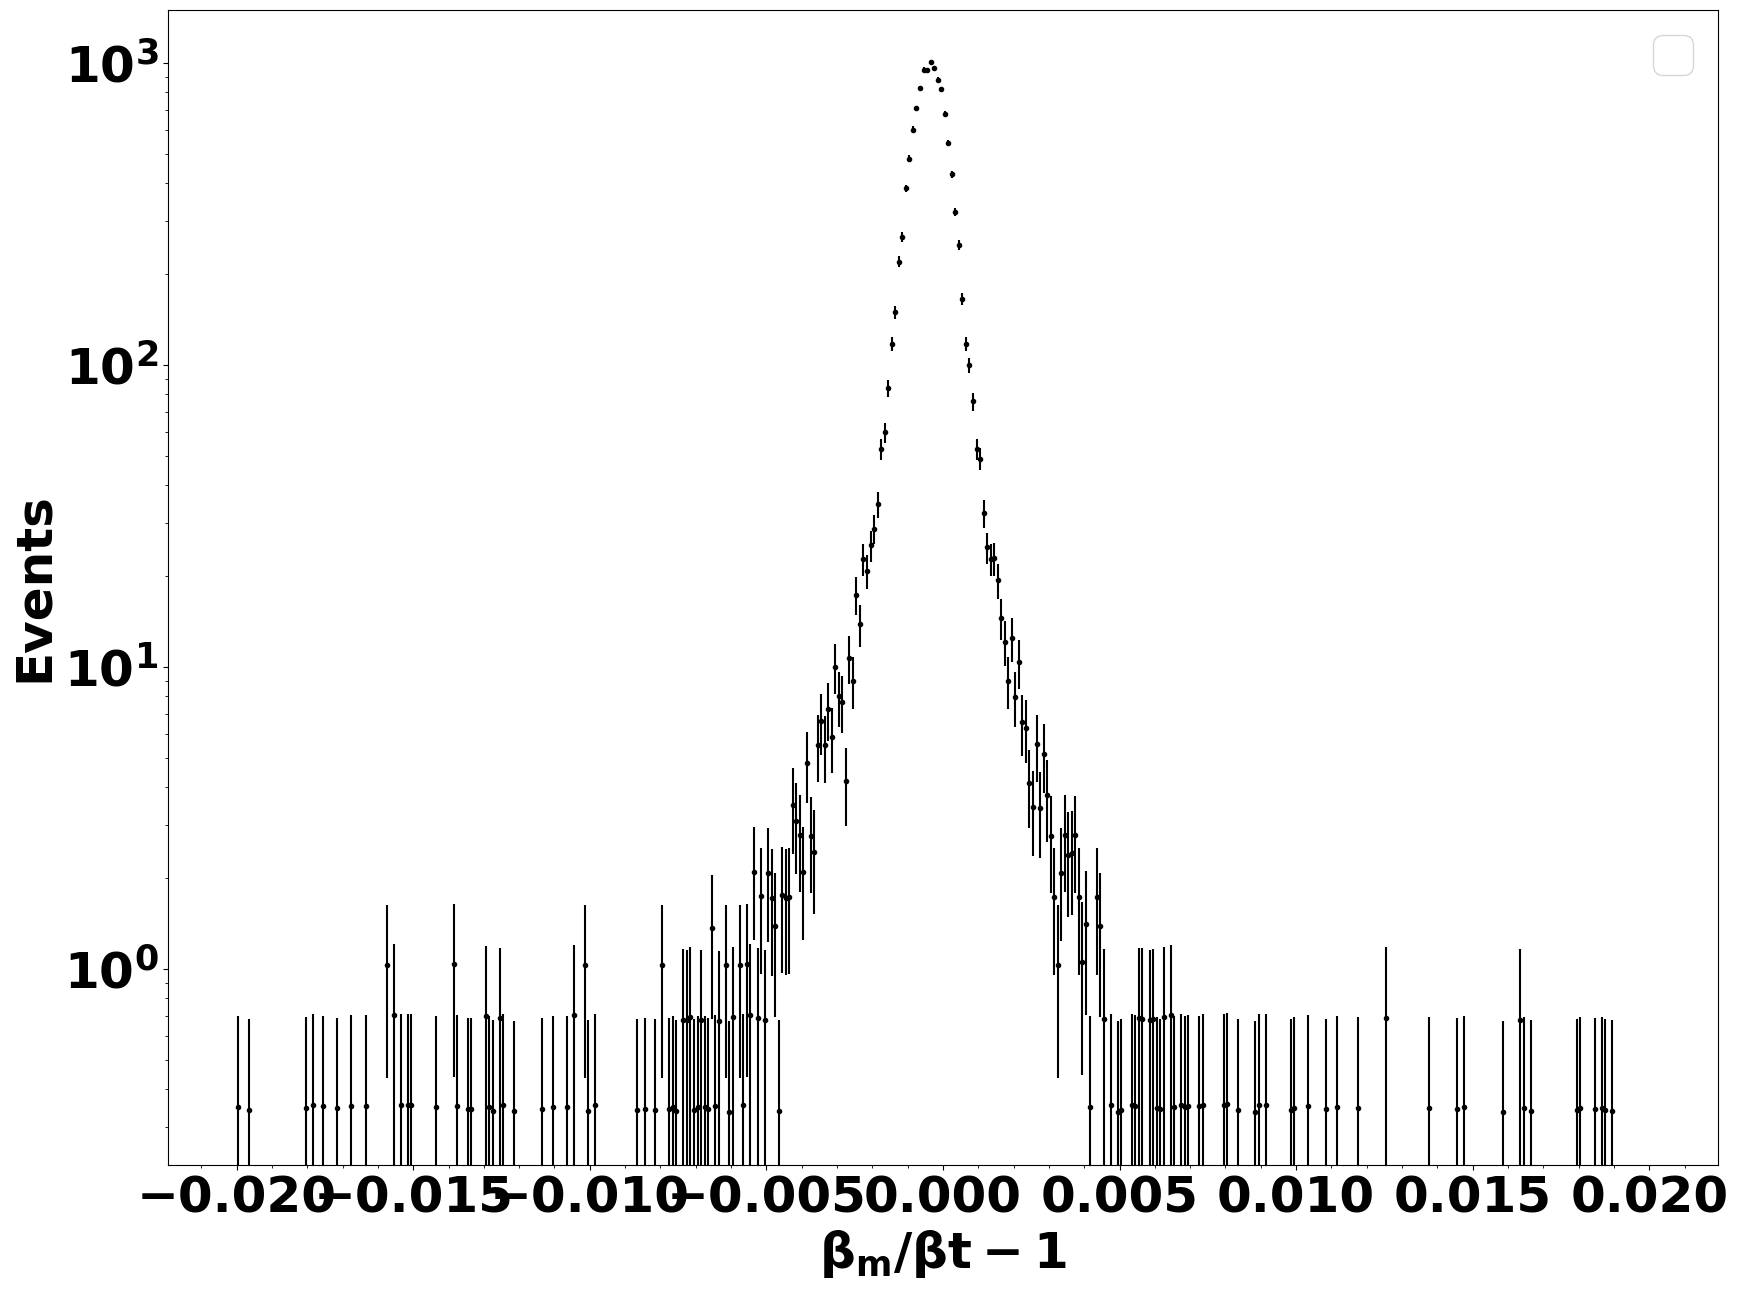

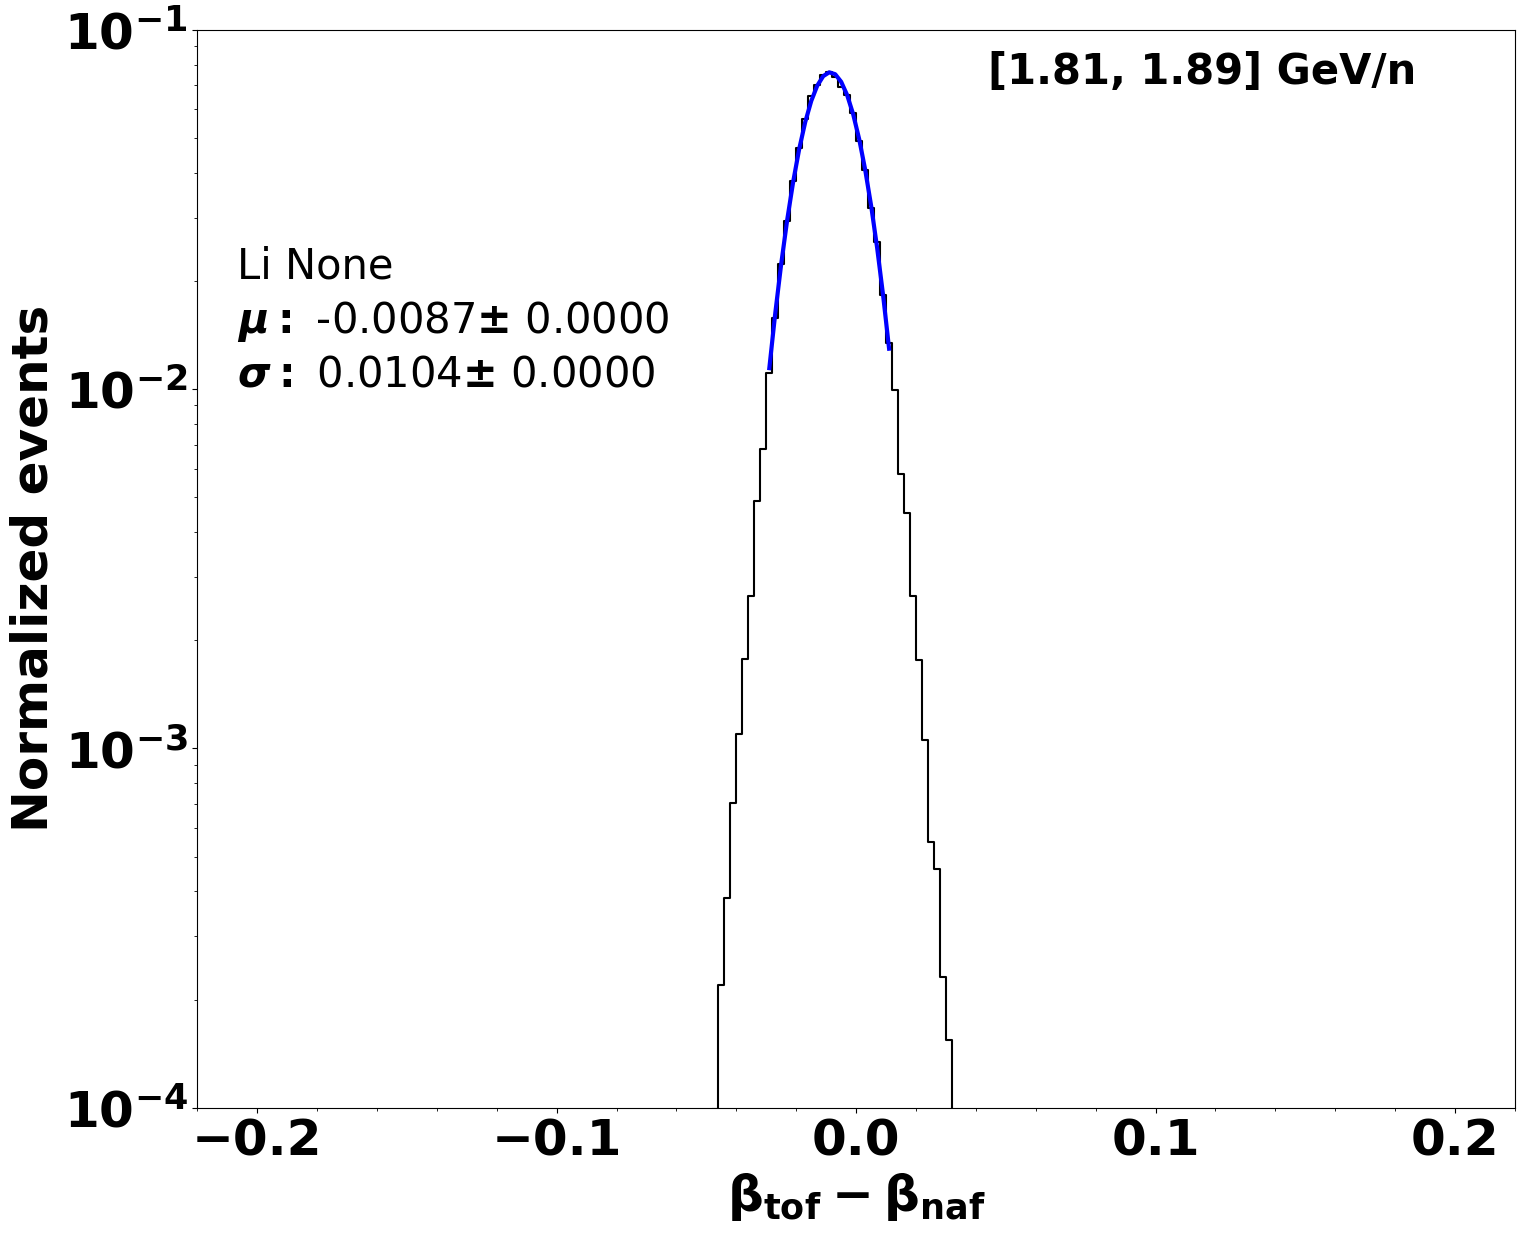

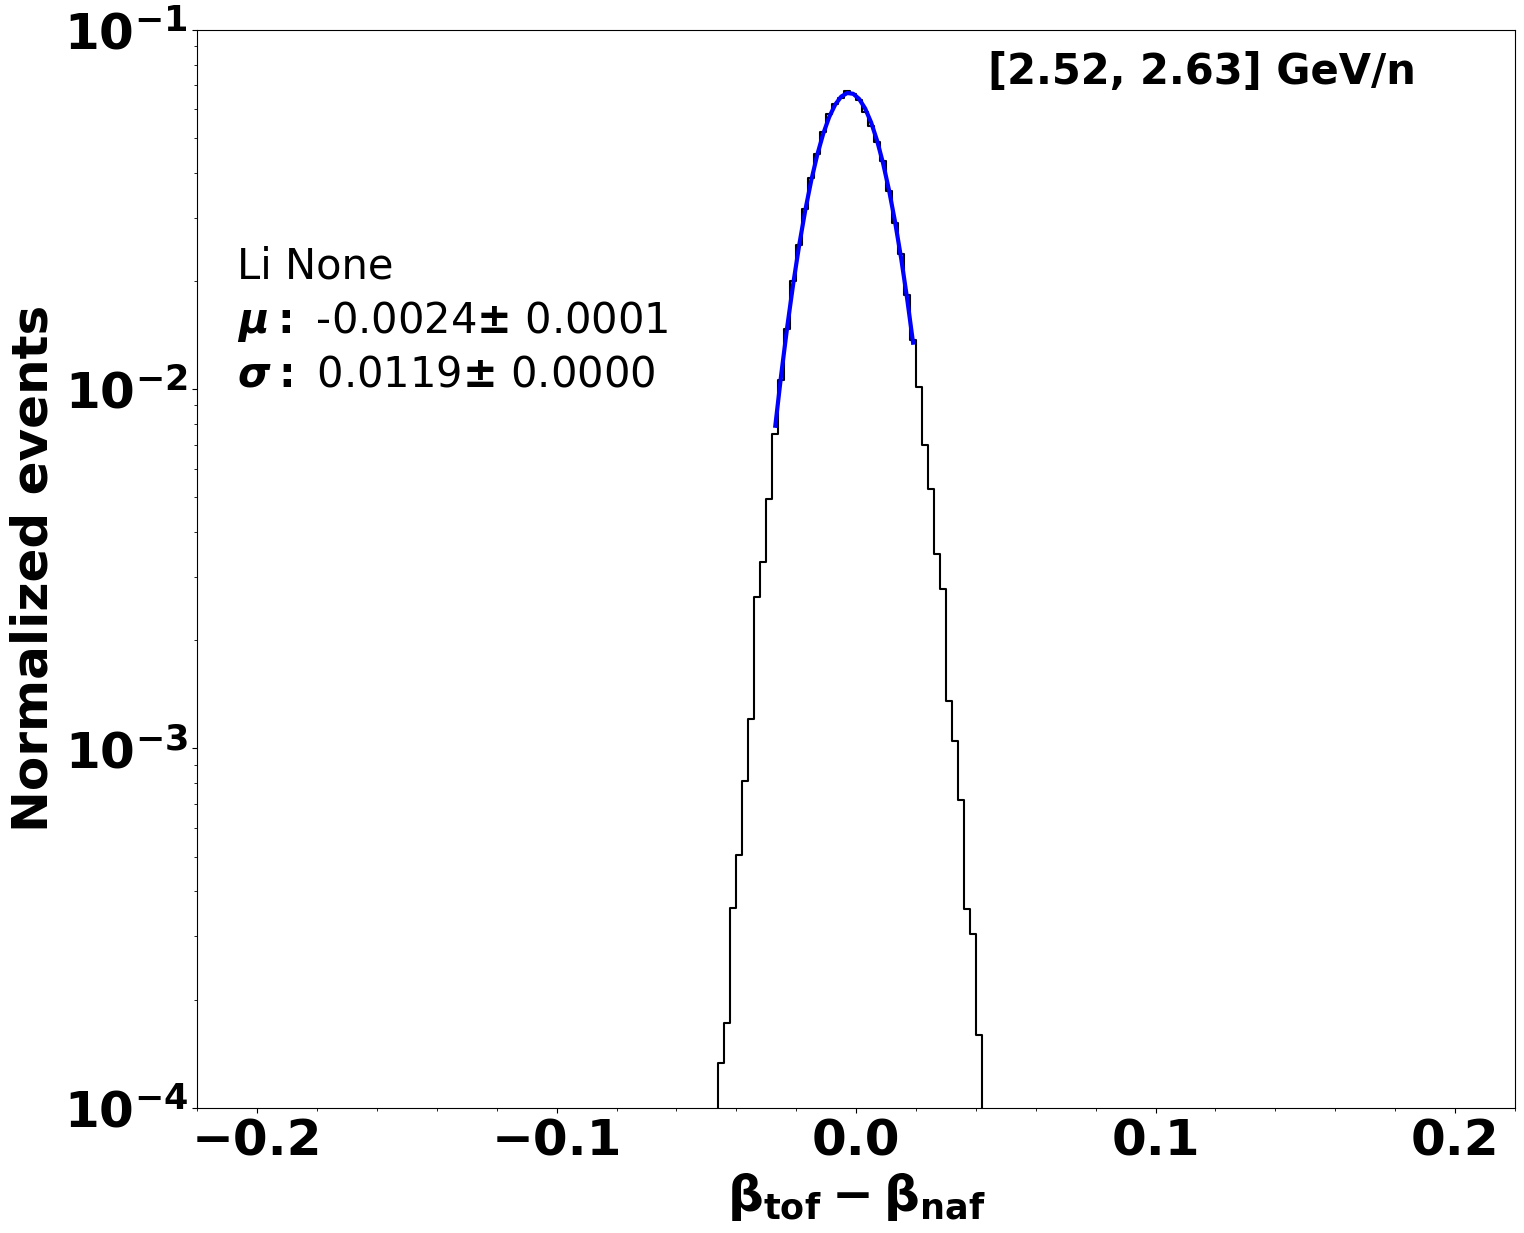

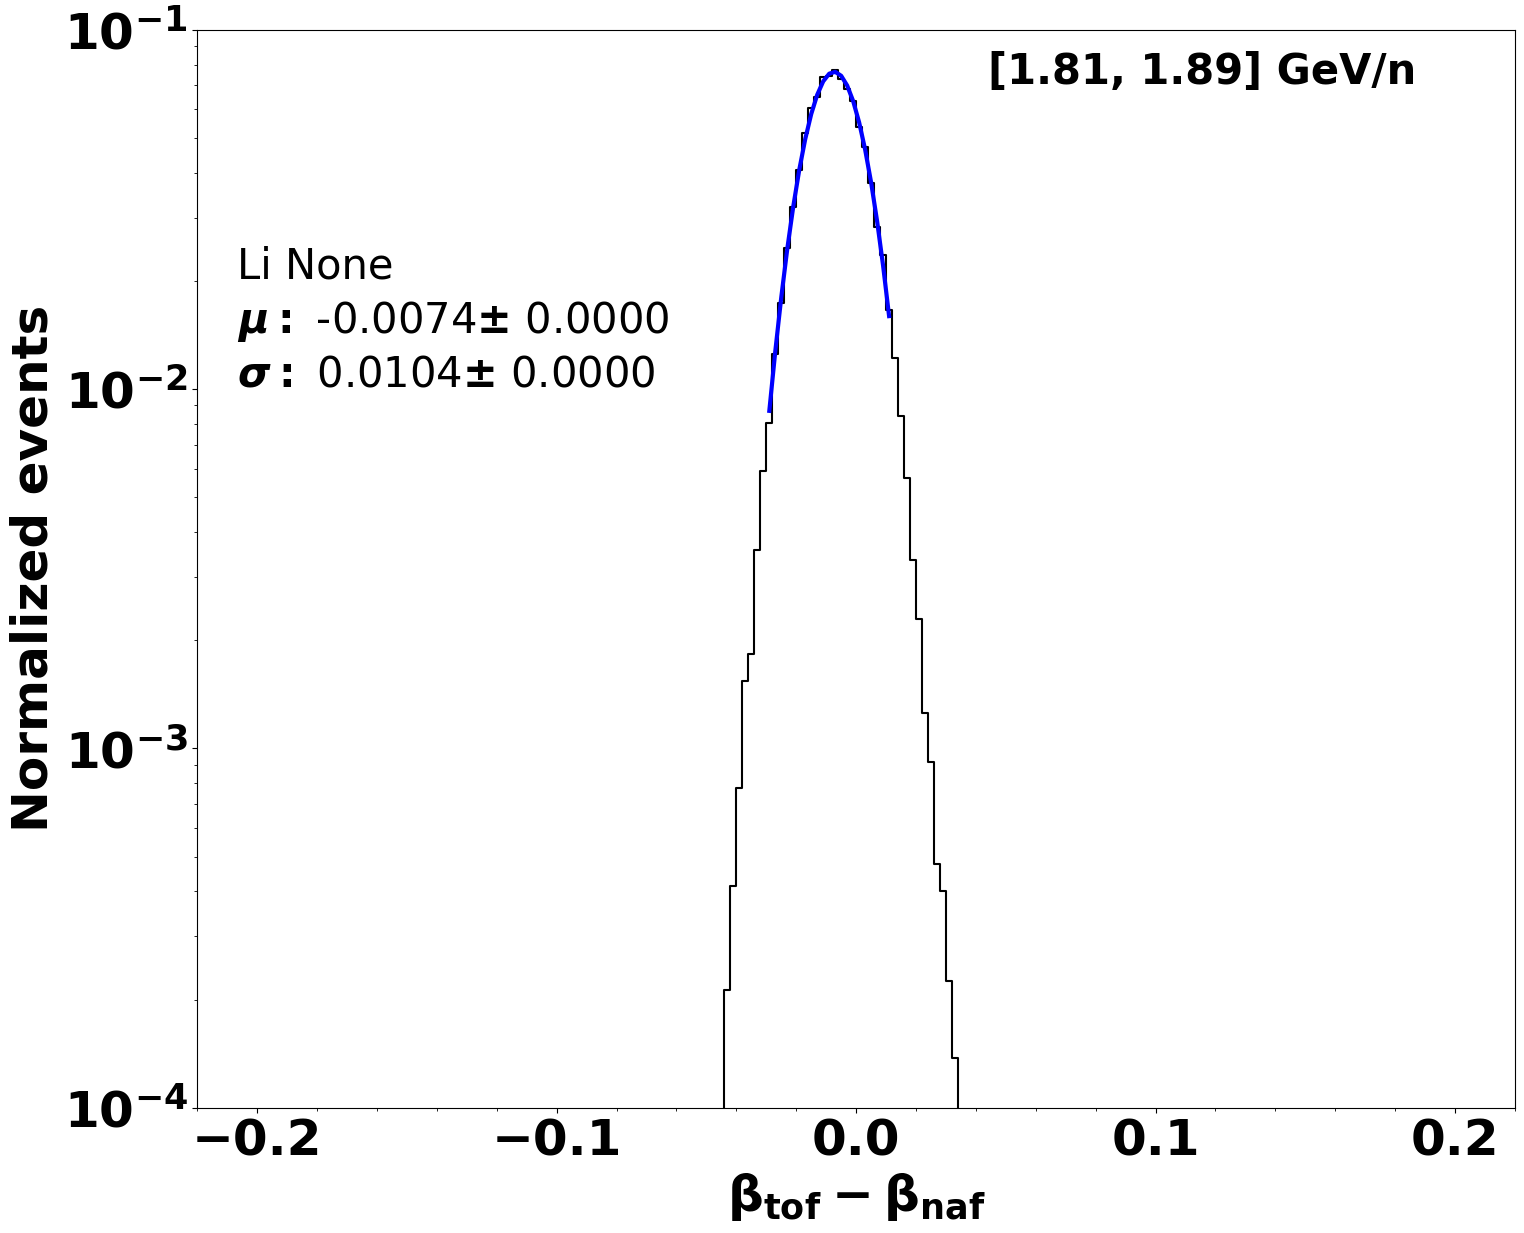

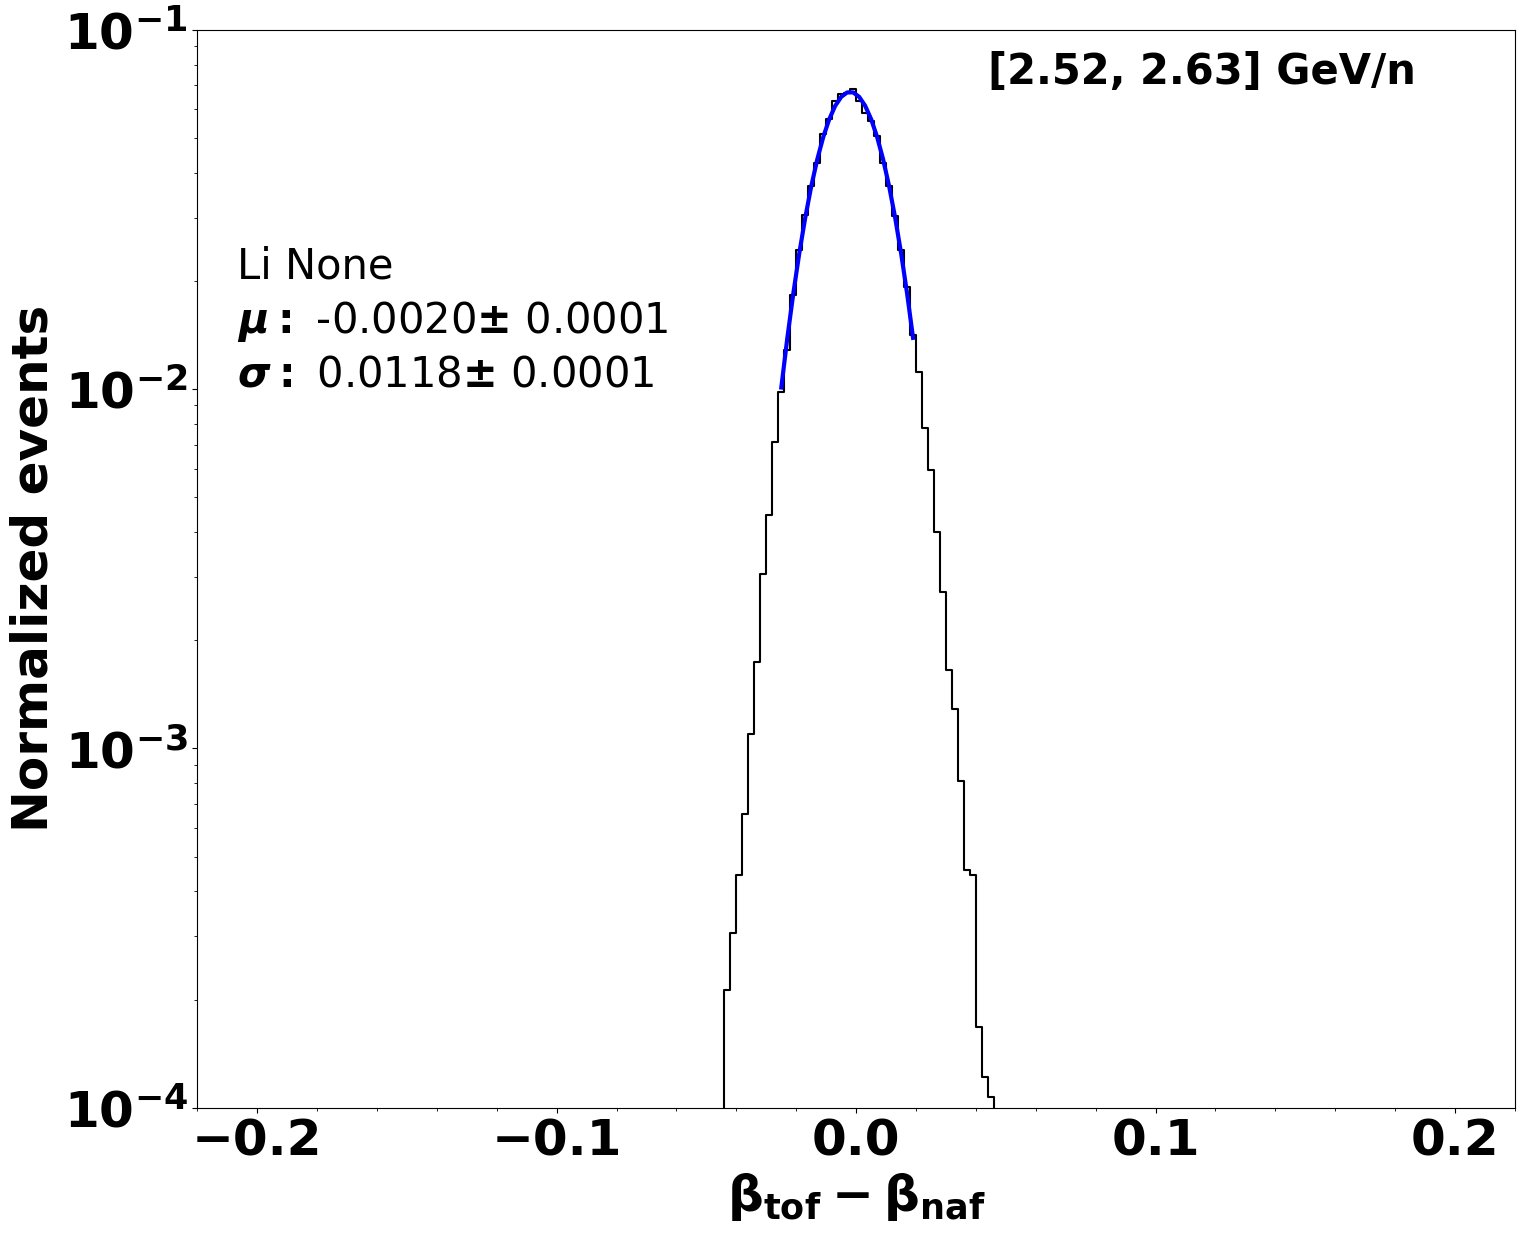

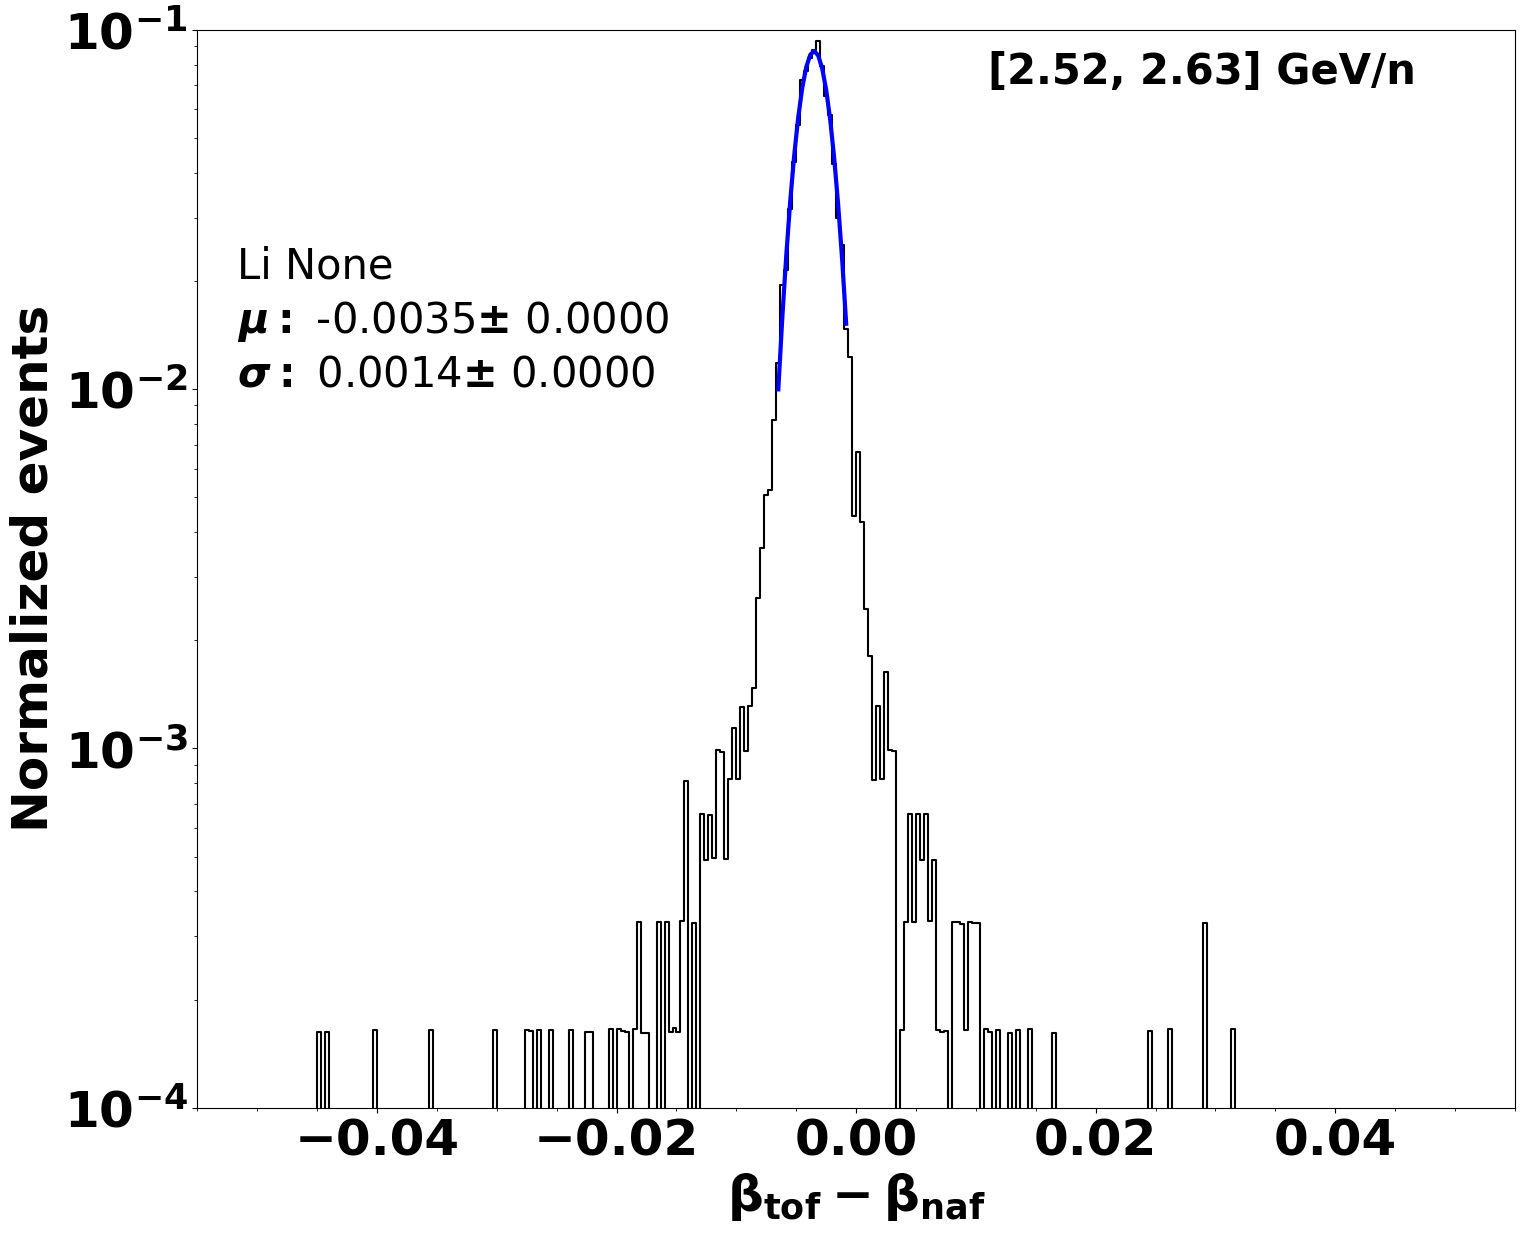

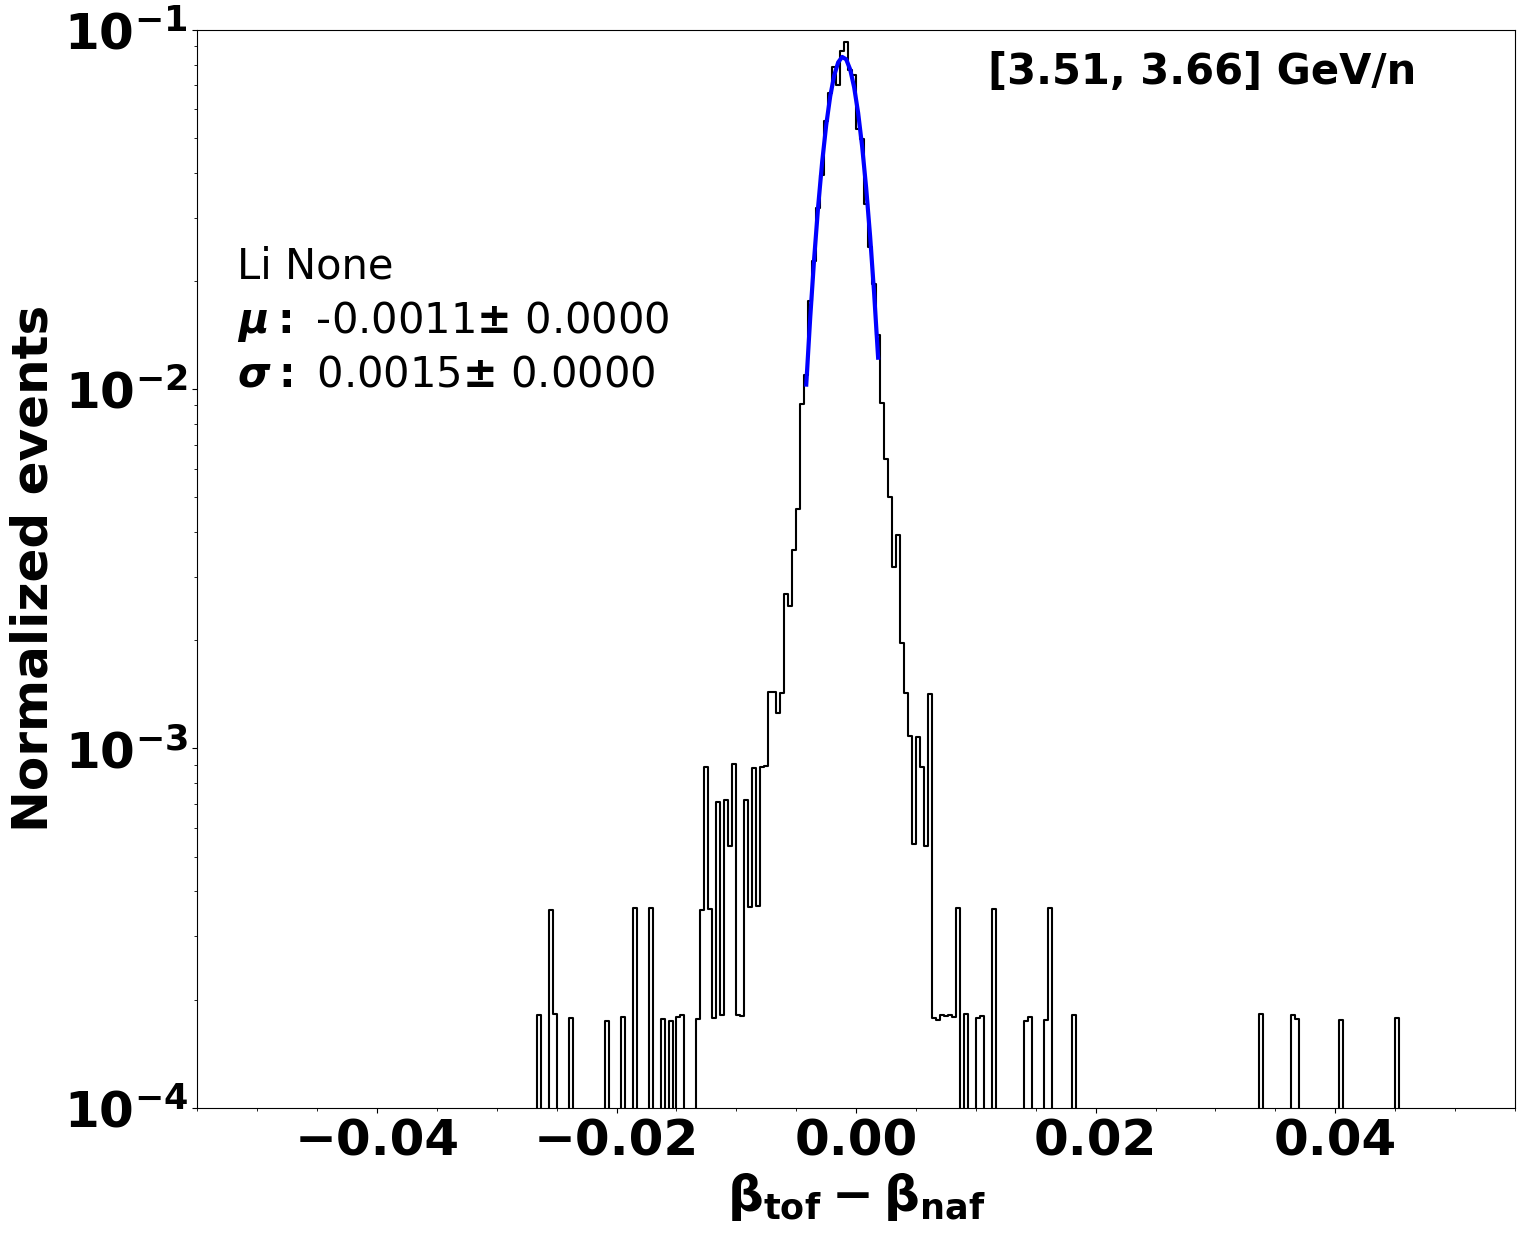

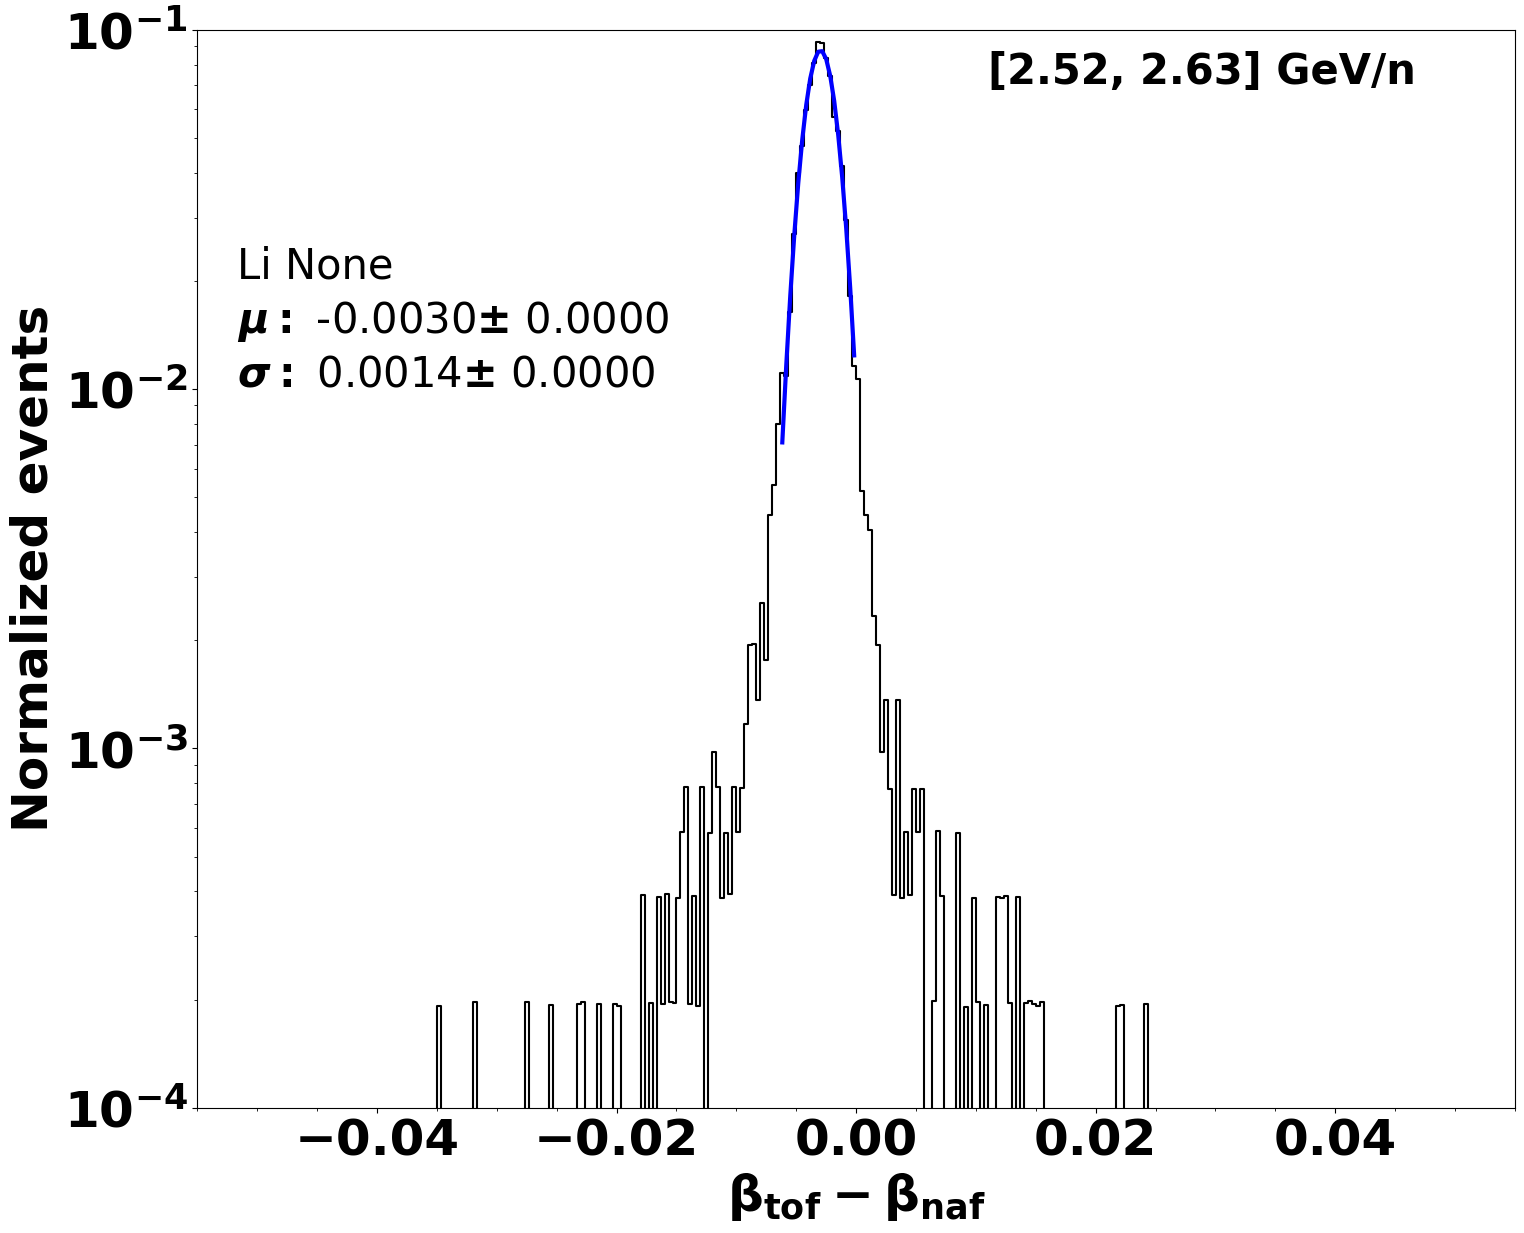

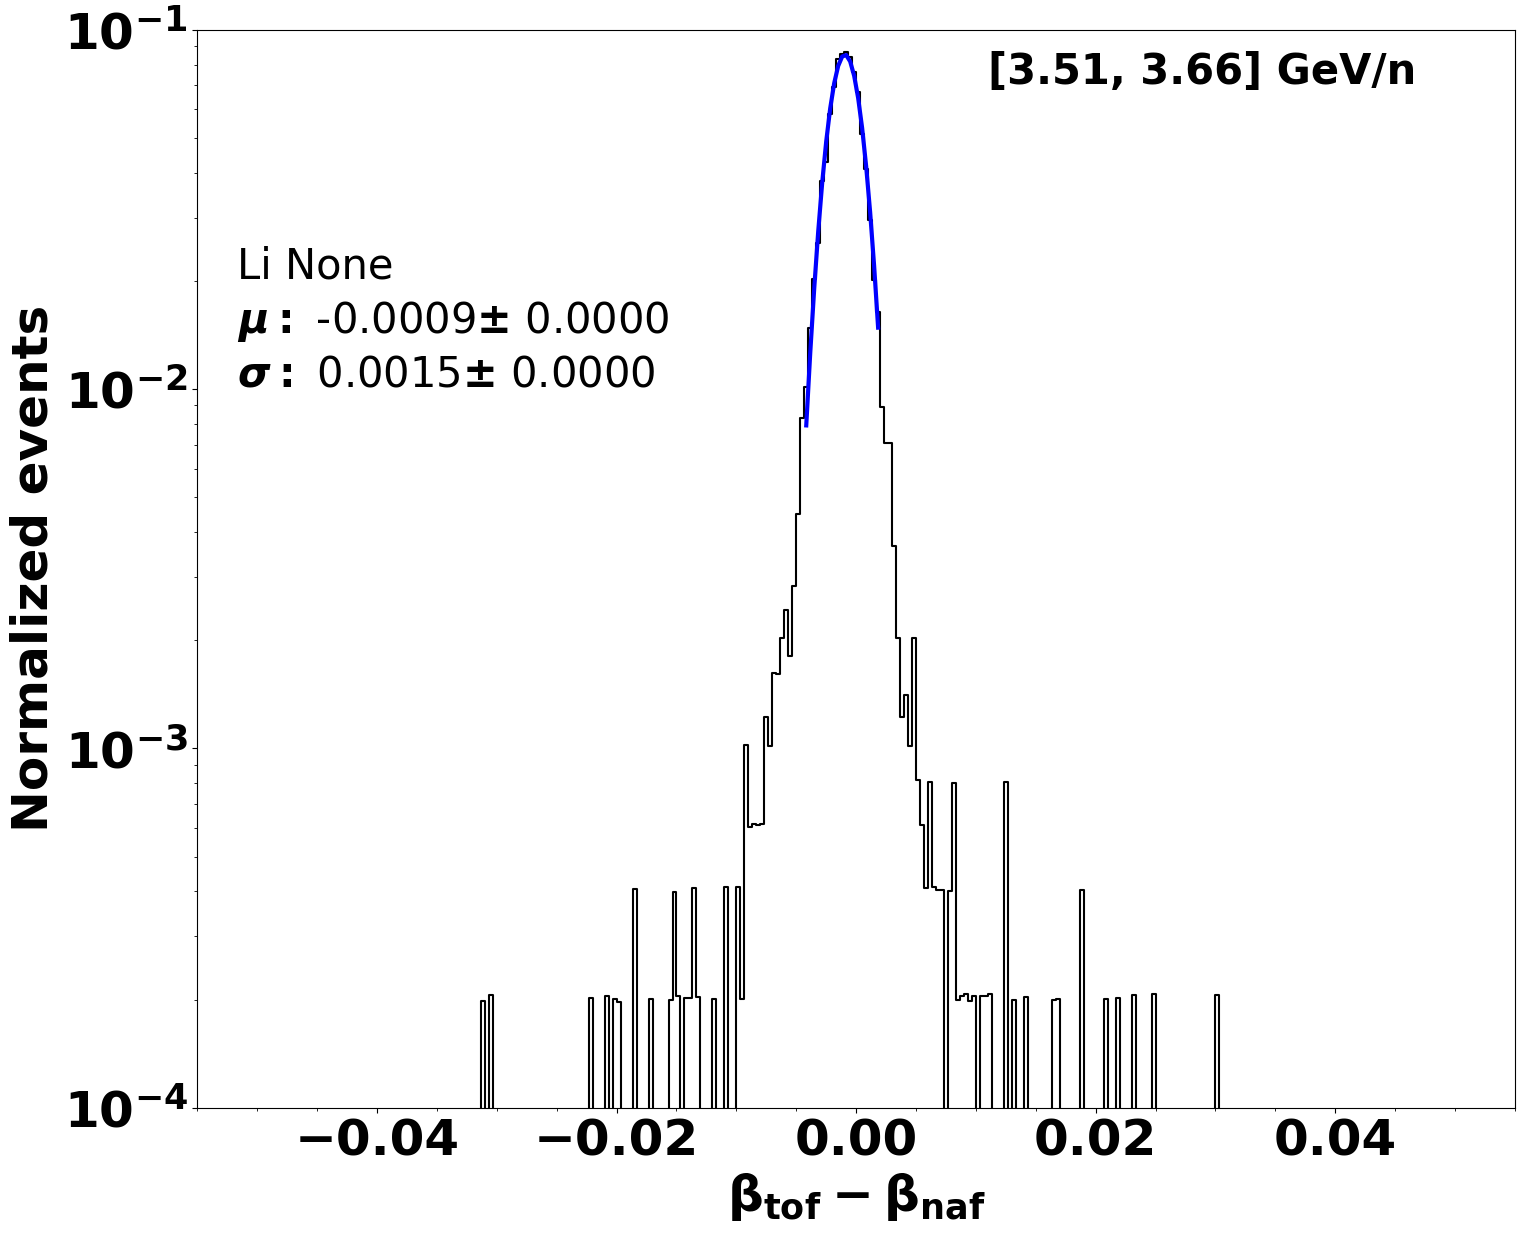

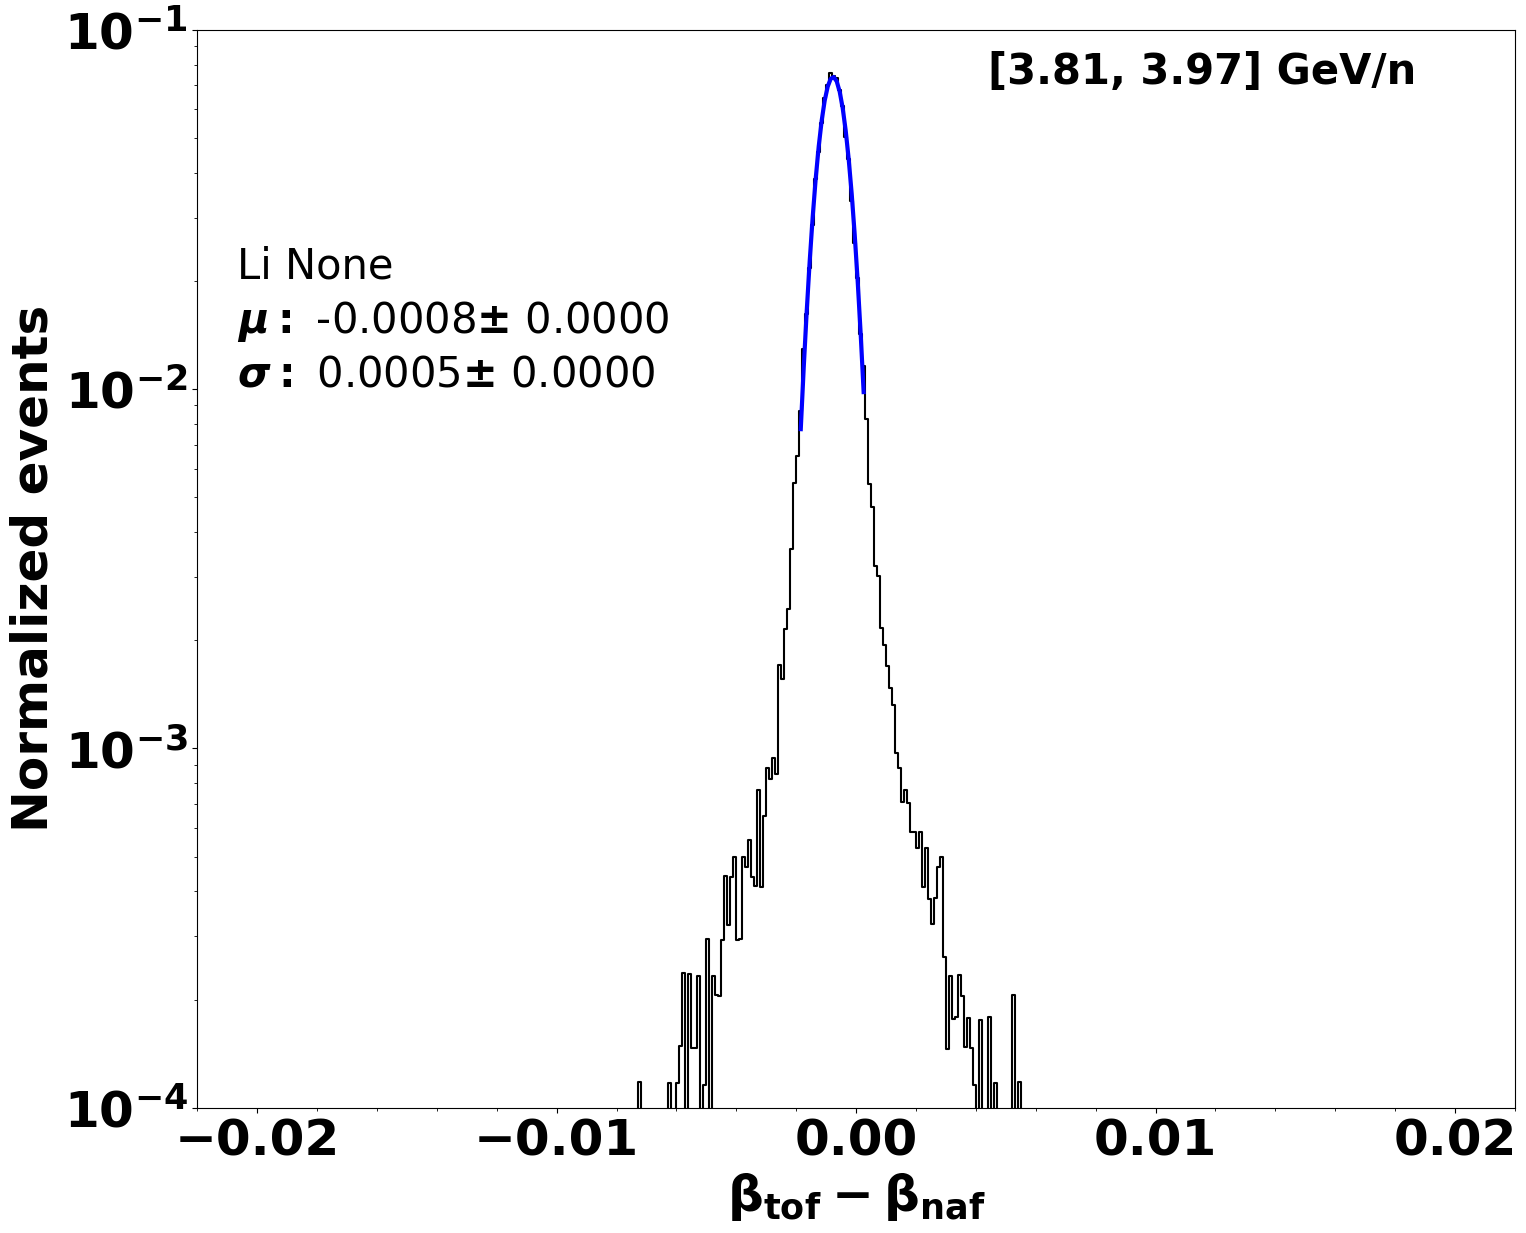

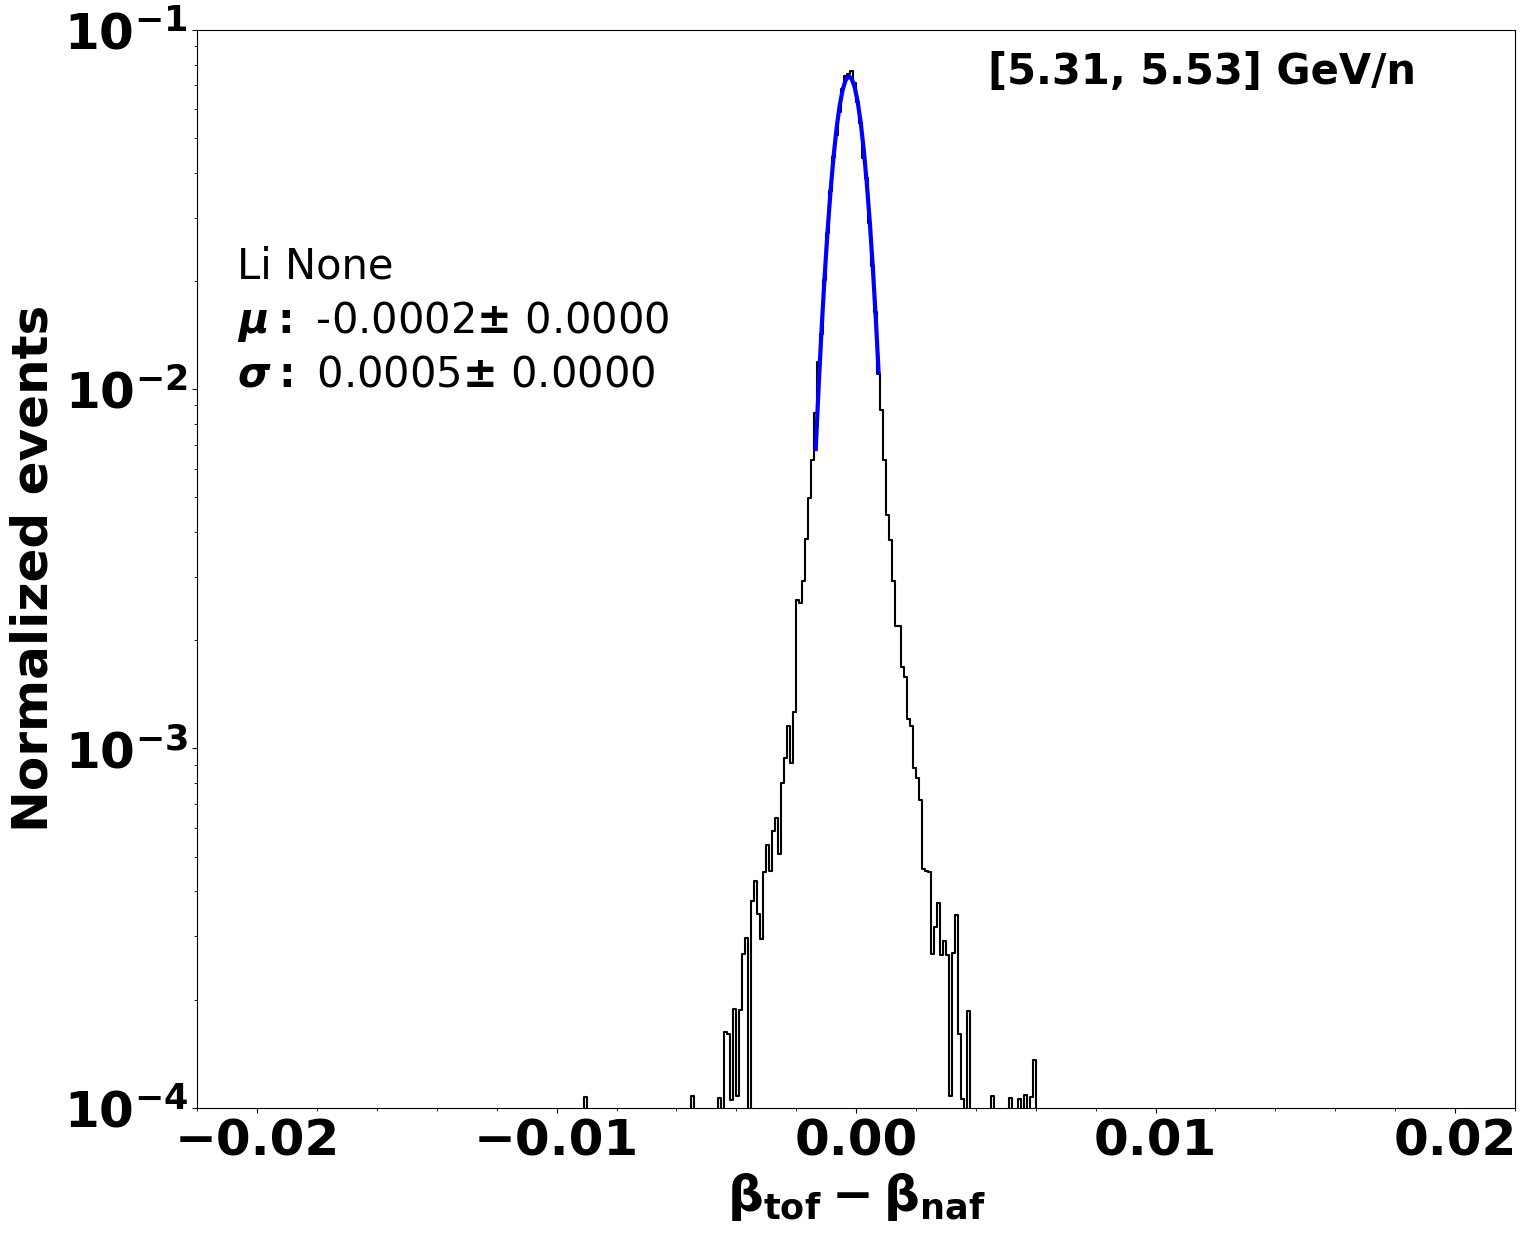

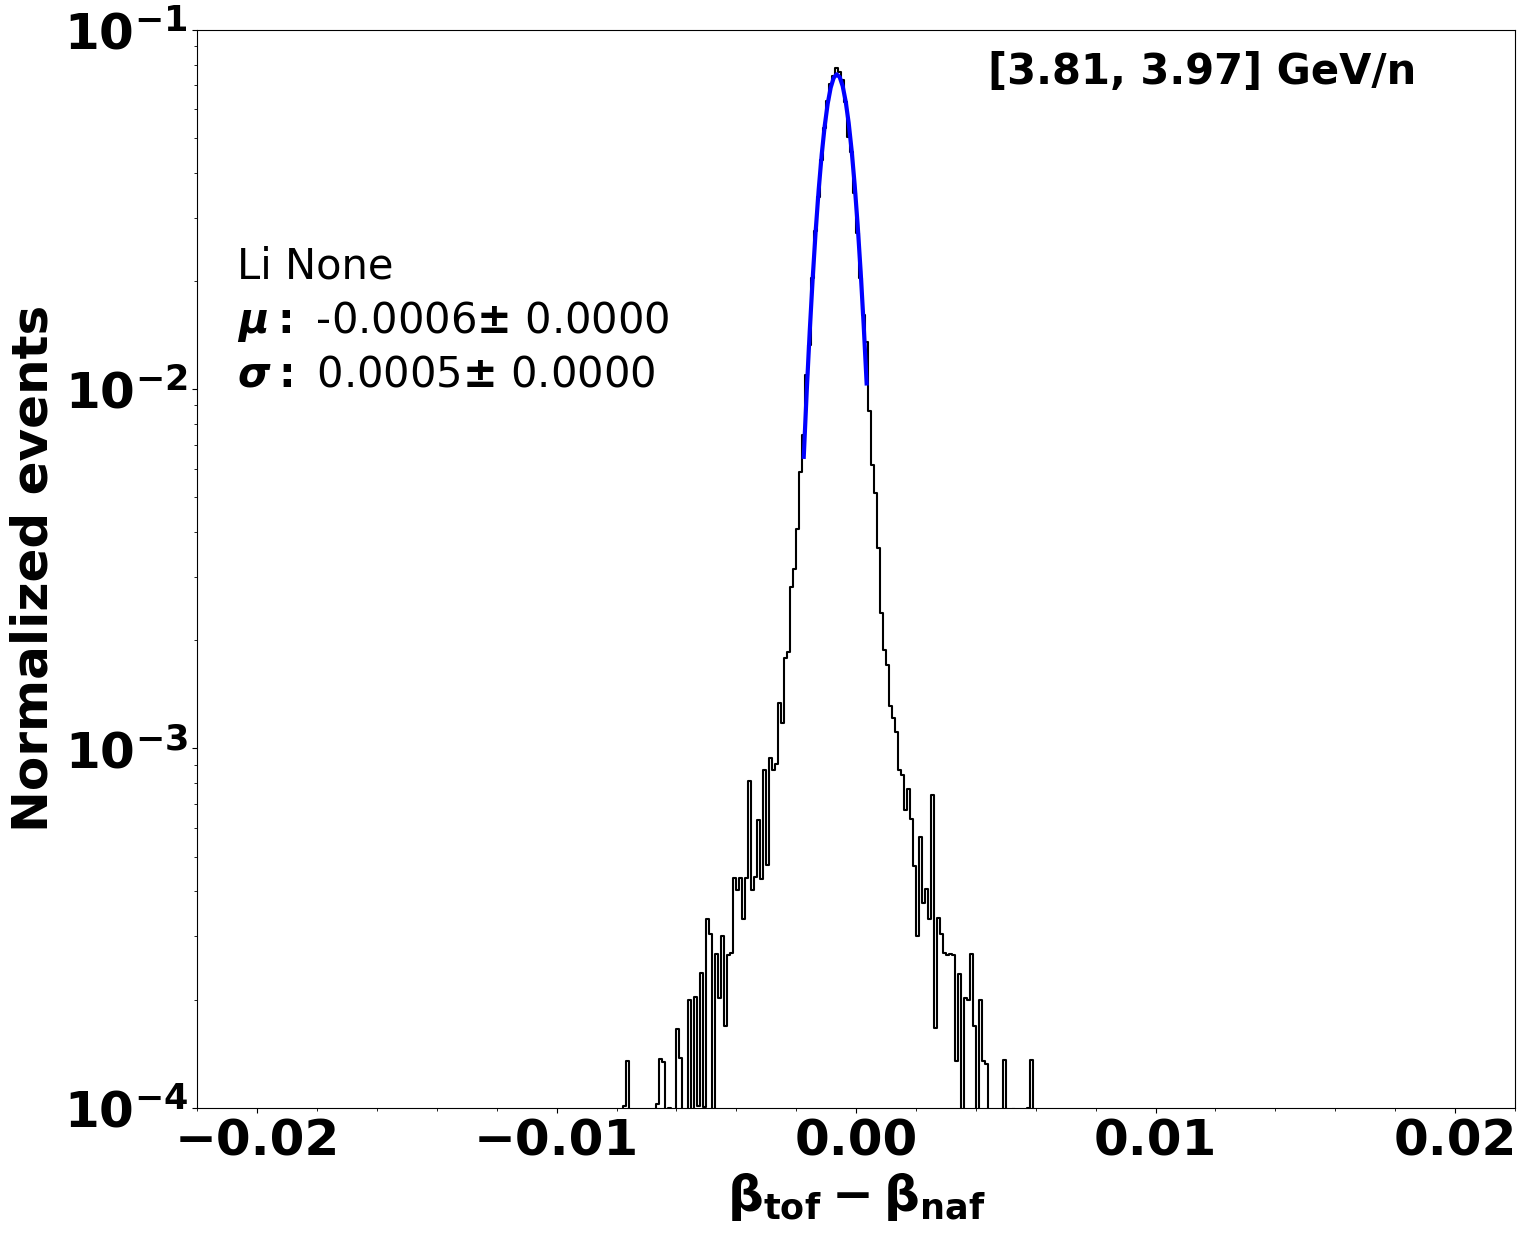

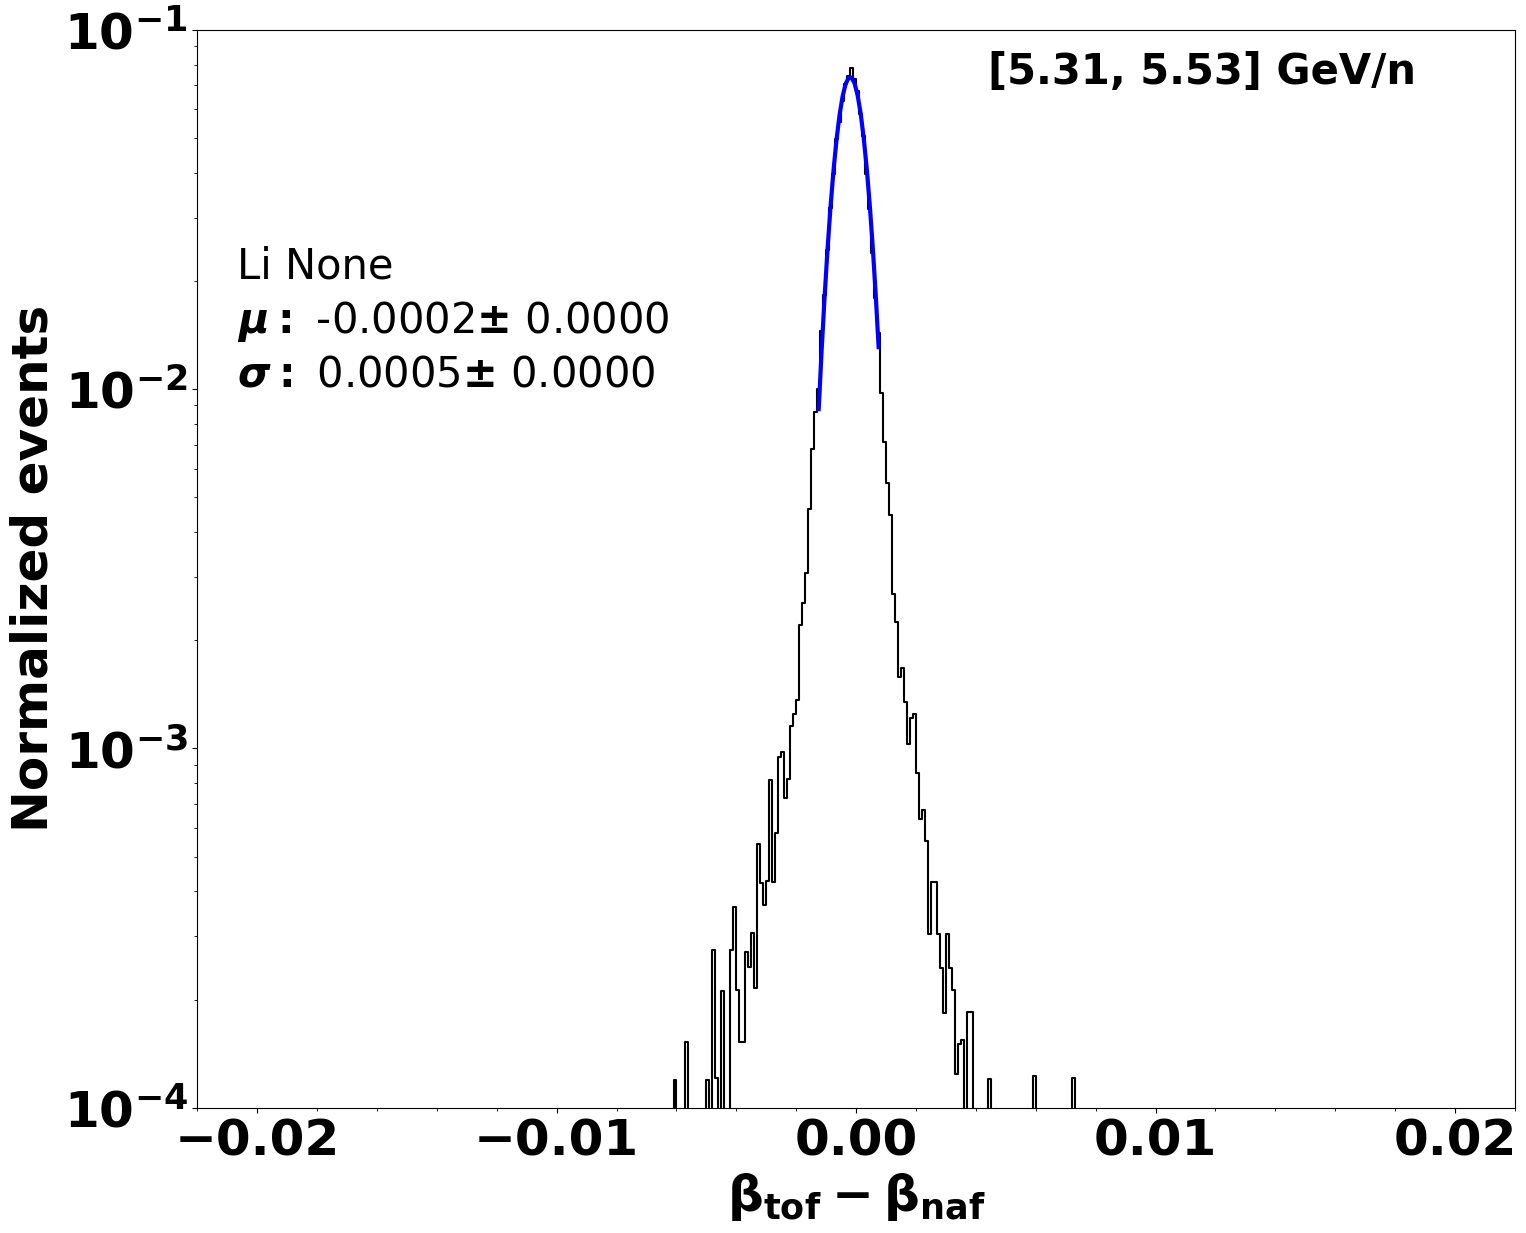

In [29]:
file_beta = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_beta_resolution_untunedBeta.npz'
 
hist2d_gamma = {dec: {} for dec in detectors}
gammalim = {'Tof':[1.6, 5.0], "NaF":[2.0, 10.0], "Agl":[3.3, 15.0]}
graph_mean_betaVsGamma = {dec: {} for dec in detectors}
graph_sigma_betaVsGamma = {dec: {} for dec in detectors}

with np.load(file_beta) as npzfile:
    for dec in detectors:
        for iso in isotopes:
            hist2d_gamma[dec][iso] = WeightedHistogram.from_file(npzfile, f"beta_resolution_{dec}_{iso}")  
            fig = plt.figure(figsize=(20, 15))
            plot = fig.subplots(1, 1) 
            plot2dhist(fig, plot, xbinning=hist2d_gamma[dec][iso].binnings[0].edges[1:-1],
                       ybinning=hist2d_gamma[dec][iso].binnings[1].edges[1:-1],
                       counts=hist2d_gamma[dec][iso].values[1:-1, 1:-1], 
                       xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=True)  
            plot.text(0.05, 0.98, f"{dec}_{iso}_gamma", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=plot.transAxes, color="black", fontweight="bold")          
            plot.set_xlabel(r"$\gamma$", fontsize=30)                                                                                                                                                     
            plot.set_ylabel(r'$\mathrm{(\beta_{m}-\beta_{t})/\beta_{t}}$', fontsize=30)
            plot.set_xscale('log')
            plot.set_xlim(gammalim[dec])
            savefig_tofile(fig, plotdir, f"hist2d_betareso_{dec}_{iso}", show=True)                                                                                                                 
            
for ibin in range(28):
    hist_ibin_gamma = hist2d_gamma['Agl']['Li6'].project(ibin)
print(hist2d_gamma[dec][iso].binnings[0].edges[1:-1][22])
fig = plt.figure(figsize=(20, 15))
plot = fig.subplots(1, 1) 
plot_histogram_1d(plot, hist_ibin_gamma, style="iss", color="black", label="data", scale=None, gamma=None, xlog=False, ylog=True, shade_errors=False)


guessp0 = {'Tof': dict(norm=1000, mu=0.0001, sigma=0.01),
          'NaF': dict(norm=100, mu=-0.001, sigma=0.0012),
          'Agl': dict(norm=500, mu=-0.0008, sigma=0.0006)}
fitrange = {'Tof': [-0.03, 0.03], 'NaF': [-0.02, 0.02], 'Agl': [-0.005, 0.005]}
binrange = {'Tof': [2, 50], 'NaF': [10, 50], 'Agl': [20, 50]}
for dec in detectors:
    for iso in isotopes:
        graph_mean_betaVsGamma[dec][iso], graph_sigma_betaVsGamma[dec][iso] = get_musigma_gausfit(hist2d_gamma[dec][iso], binrange[dec][0], binrange[dec][1], guessp0[dec], fitrange[dec])
        

In [30]:
mass_gev = 0.9314941

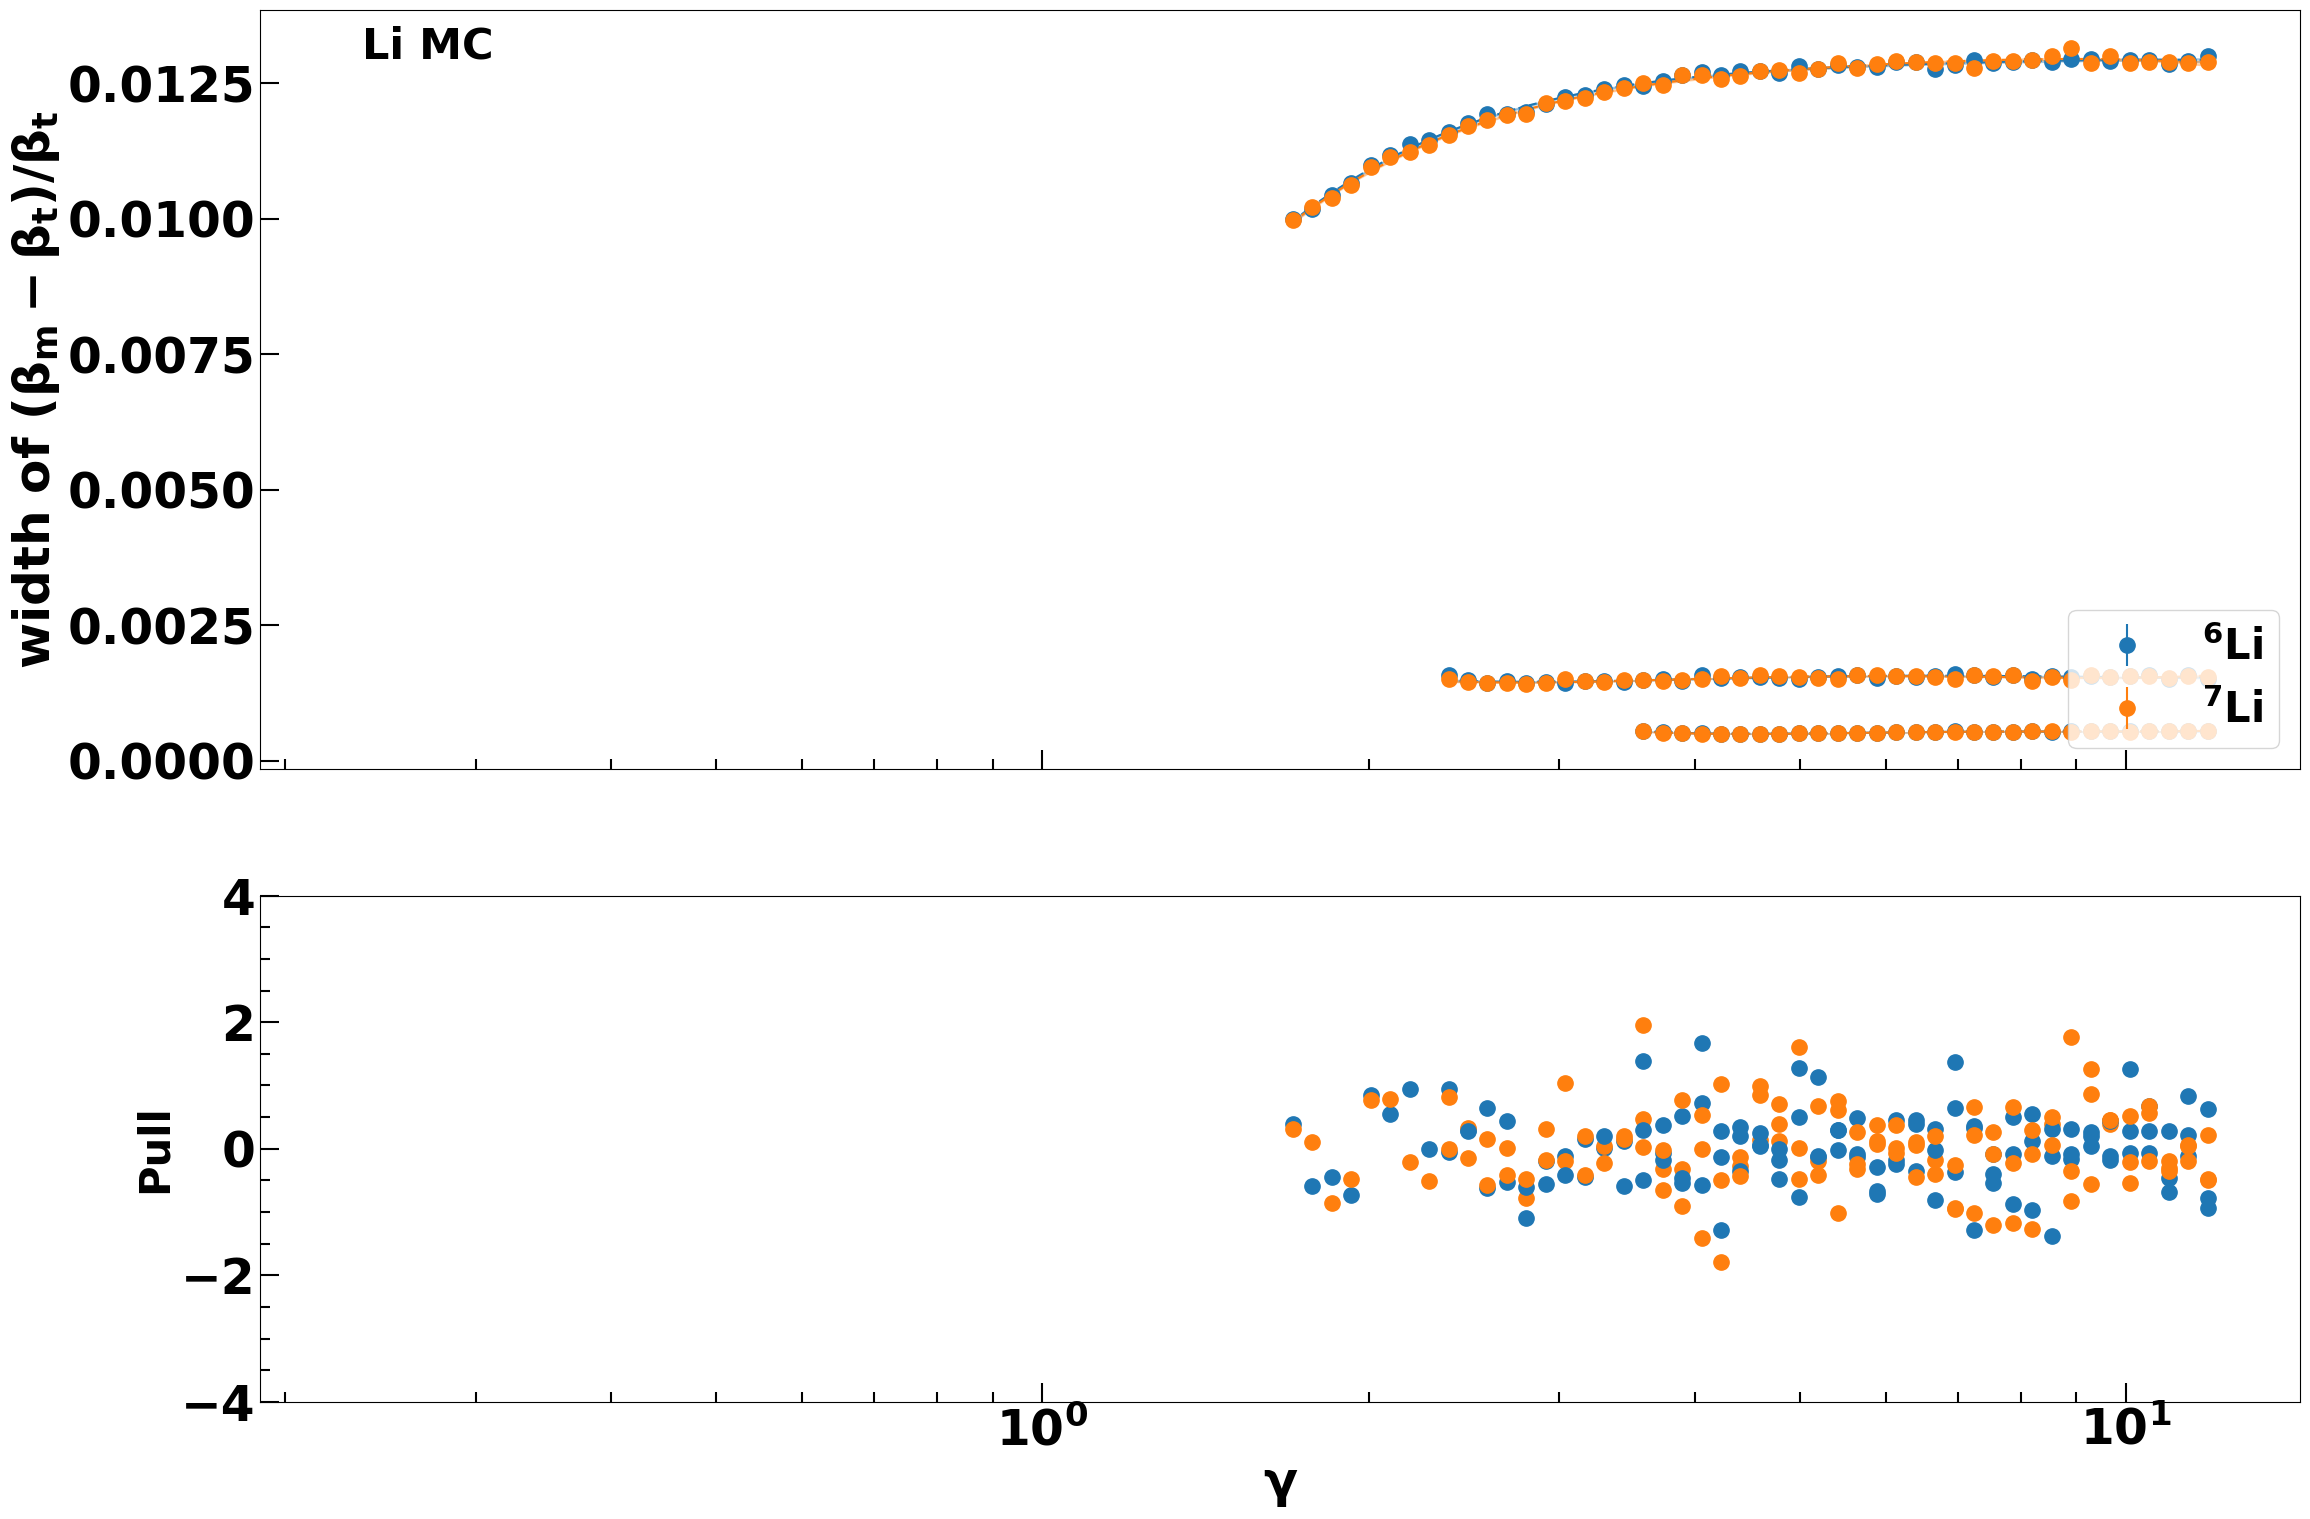

In [31]:
graph_sigam_timegamma = {dec:{} for dec in detectors}

for dec in detectors:
    for iso in isotopes:
        graph_sigam_timegamma[dec][iso] = MGraph(graph_sigma_betaVsGamma[dec][iso].xvalues, graph_sigma_betaVsGamma[dec][iso].xvalues**2 * graph_sigma_betaVsGamma[dec][iso].yvalues, graph_sigma_betaVsGamma[dec][iso].xvalues**2 *graph_sigma_betaVsGamma[dec][iso].yerrs)
        

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                               
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 


dict_polypar = {dec: {} for dec in detectors}
for dec in ['Tof', 'NaF', 'Agl']:
    for iso in isotopes: 
        plot_graph(fig, ax1, graph_sigma_betaVsGamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}' if dec == 'Tof' else None)  
        xval = graph_sigma_betaVsGamma[dec][iso].xvalues 
        popt, pcov = curve_fit(poly, np.log(xval), graph_sigma_betaVsGamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigma_betaVsGamma[dec][iso].yerrs, absolute_sigma=True)
        polypars = uncertainties.correlated_values(popt, pcov) 
        dict_polypar[dec][iso] = polypars
        yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
        yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
        ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
        ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
        graphpull = get_pull_graph(graph_sigma_betaVsGamma[dec][iso], yfit)
        plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

ax1.text(0.05, 0.98, f"{nuclei} MC", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
graph_ratio_betasigma = graph_sigma_betaVsGamma[dec][ISOTOPES[nuclei][0]]/graph_sigma_betaVsGamma[dec][ISOTOPES[nuclei][1]]

#plot_graph(fig, ax2, ratio9to7_Tof, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7_Tof, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
#plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
#ax1.set_ylim([0.00001, 0.001])
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma", show=True) 

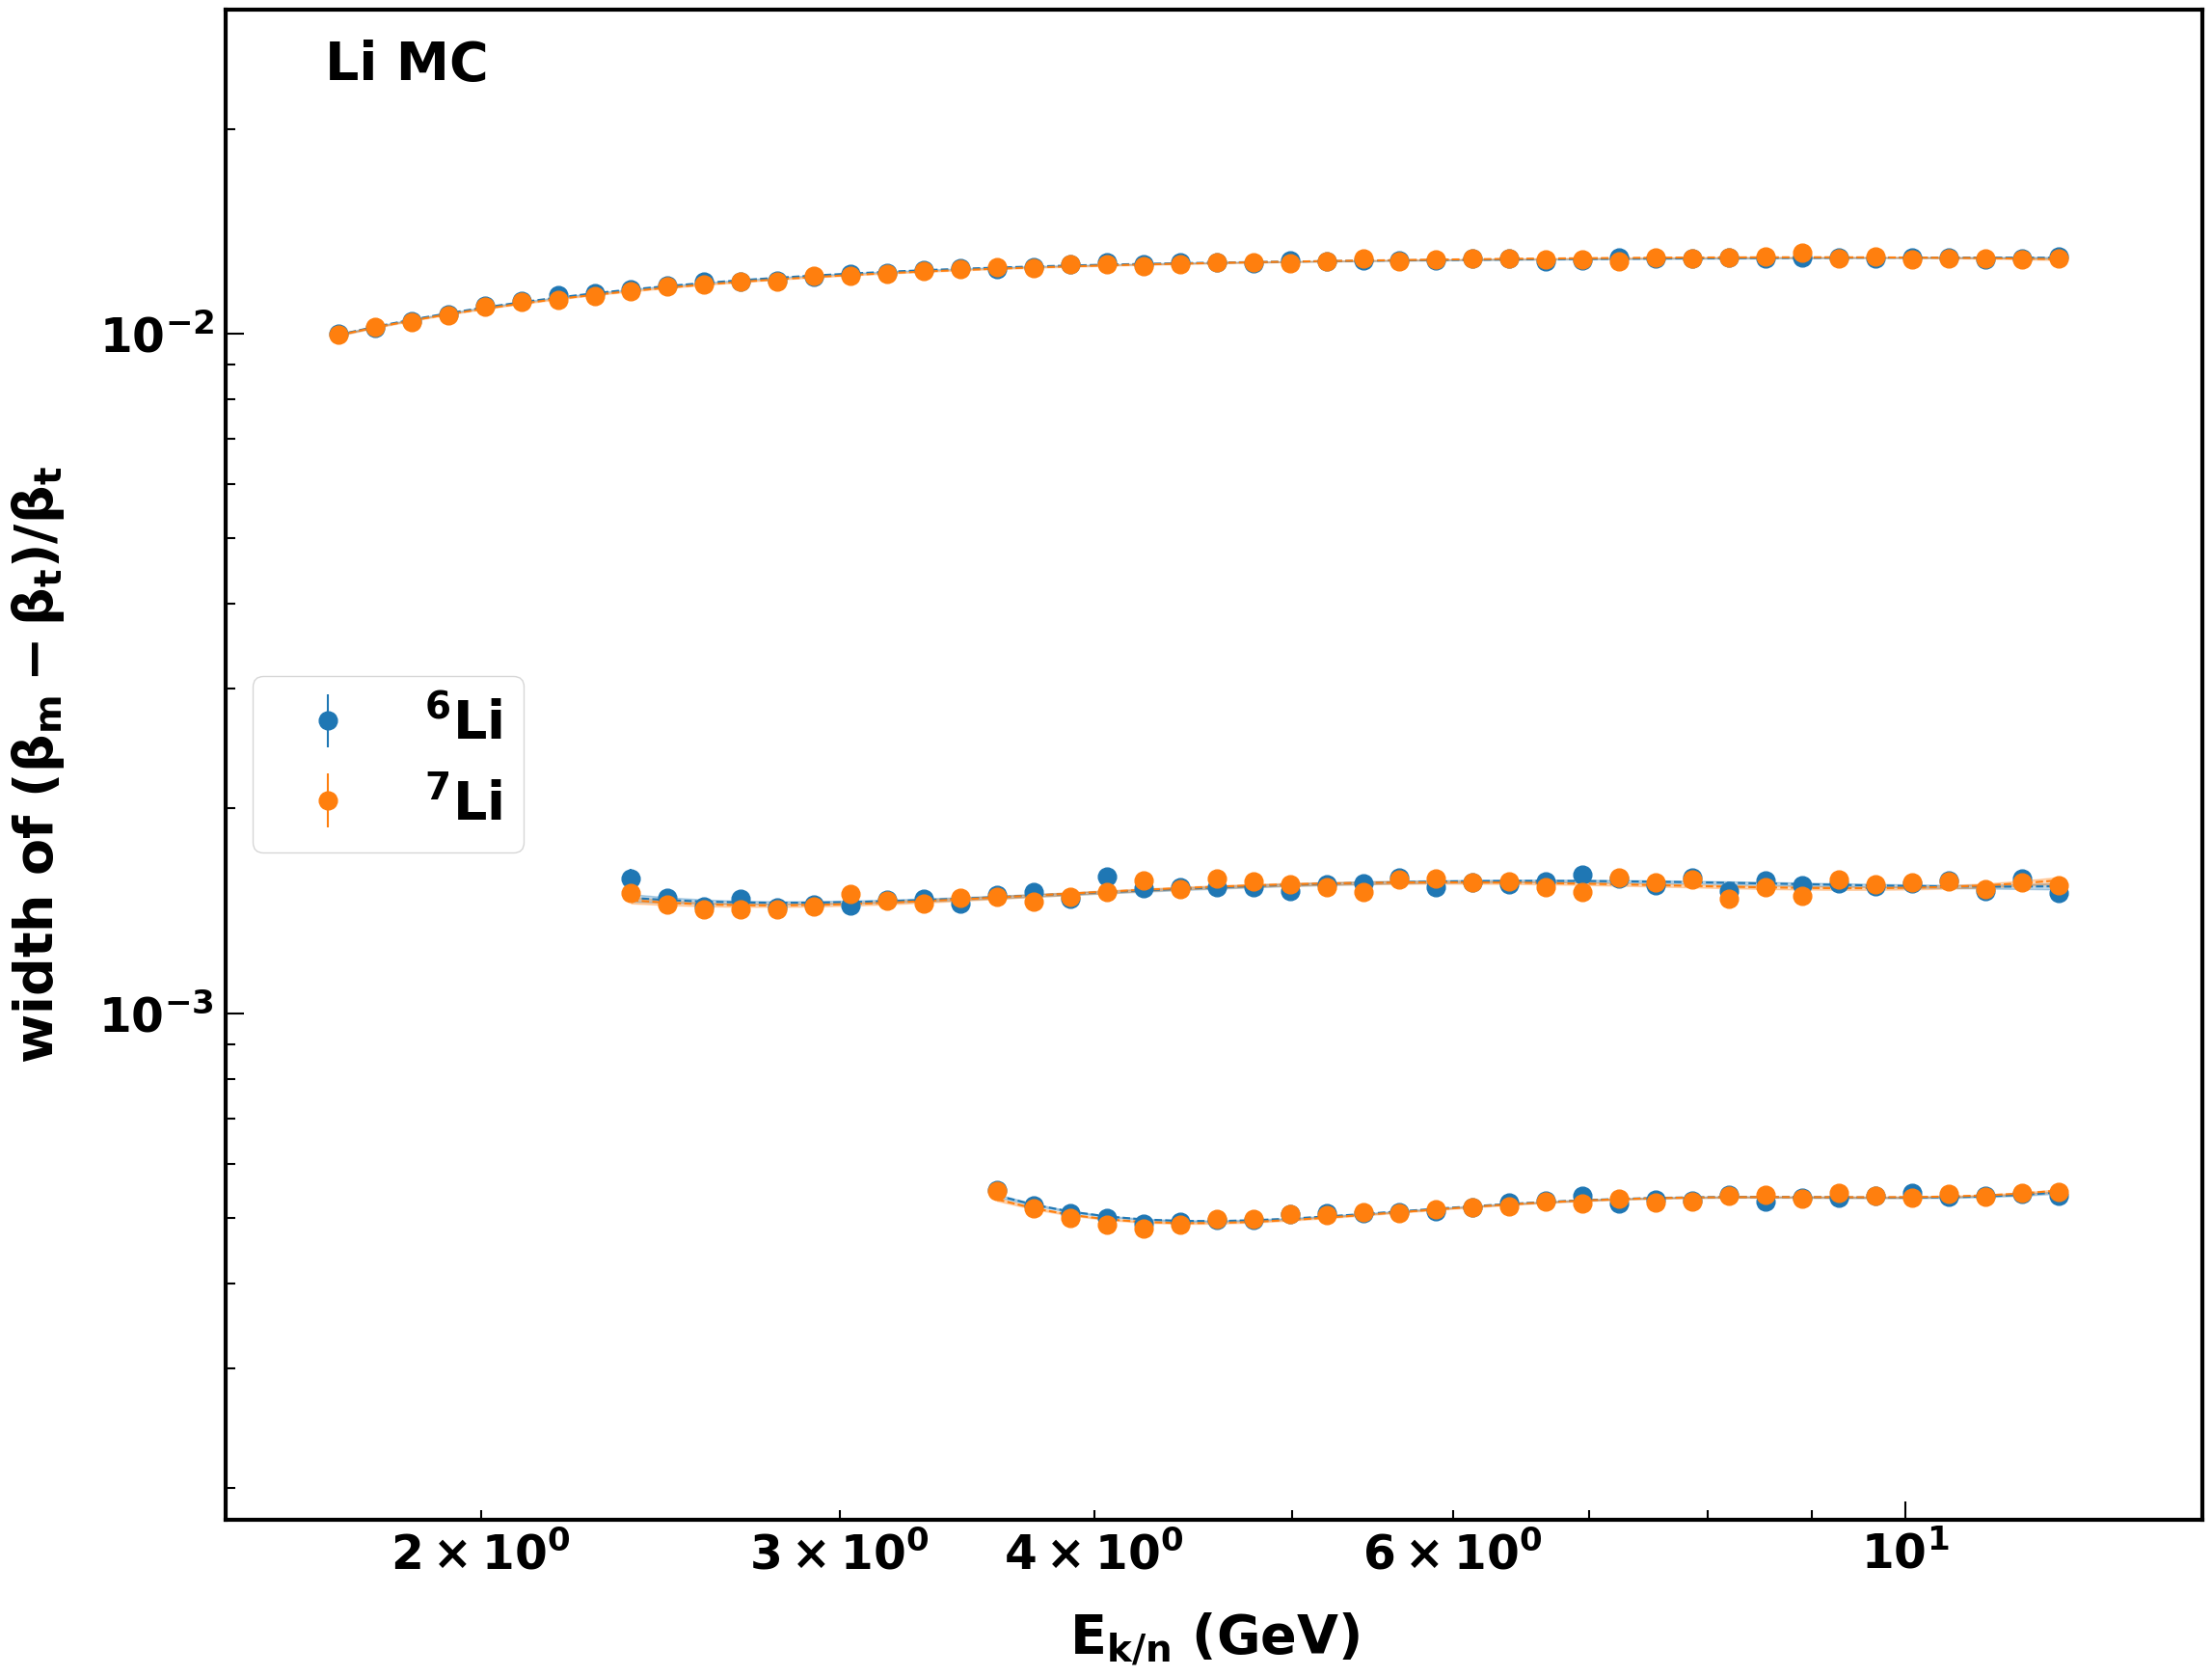

In [32]:
graph_sigam_timegamma = {dec:{} for dec in detectors}

for dec in detectors:
    for iso in isotopes:
        graph_sigam_timegamma[dec][iso] = MGraph(graph_sigma_betaVsGamma[dec][iso].xvalues, graph_sigma_betaVsGamma[dec][iso].xvalues**2 * graph_sigma_betaVsGamma[dec][iso].yvalues, graph_sigma_betaVsGamma[dec][iso].xvalues**2 *graph_sigma_betaVsGamma[dec][iso].yerrs)
        


fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))                                                                                                            
fig.subplots_adjust(left= 0.15, right=0.97, bottom=0.08, top=0.95) 
set_plot_style(ax1)

SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV)}$', r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$', TEXTSIZE, xlimrange=[1.5, 14], ylimrange=[0.00018, 0.03], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=True, setxlog=True)

dict_polypar = {dec: {} for dec in detectors}
for dec in ['Tof', 'NaF', 'Agl']:
    for iso in isotopes: 
        plot_graph(fig, ax1, graph_sigma_betaVsGamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=27, label=f'{ISO_LABELS[iso]}' if dec == 'Tof' else None)  
        xval = graph_sigma_betaVsGamma[dec][iso].xvalues 
        popt, pcov = curve_fit(poly, np.log(xval), graph_sigma_betaVsGamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigma_betaVsGamma[dec][iso].yerrs, absolute_sigma=True)
        polypars = uncertainties.correlated_values(popt, pcov) 
        dict_polypar[dec][iso] = polypars
        yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
        yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
        ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
        ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
        graphpull = get_pull_graph(graph_sigma_betaVsGamma[dec][iso], yfit)
        

ax1.text(0.05, 0.98, f"{nuclei} MC", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
graph_ratio_betasigma = graph_sigma_betaVsGamma[dec][ISOTOPES[nuclei][0]]/graph_sigma_betaVsGamma[dec][ISOTOPES[nuclei][1]]
ax1.legend(loc="center left", fontsize=40) 


savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma_1", show=True) 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


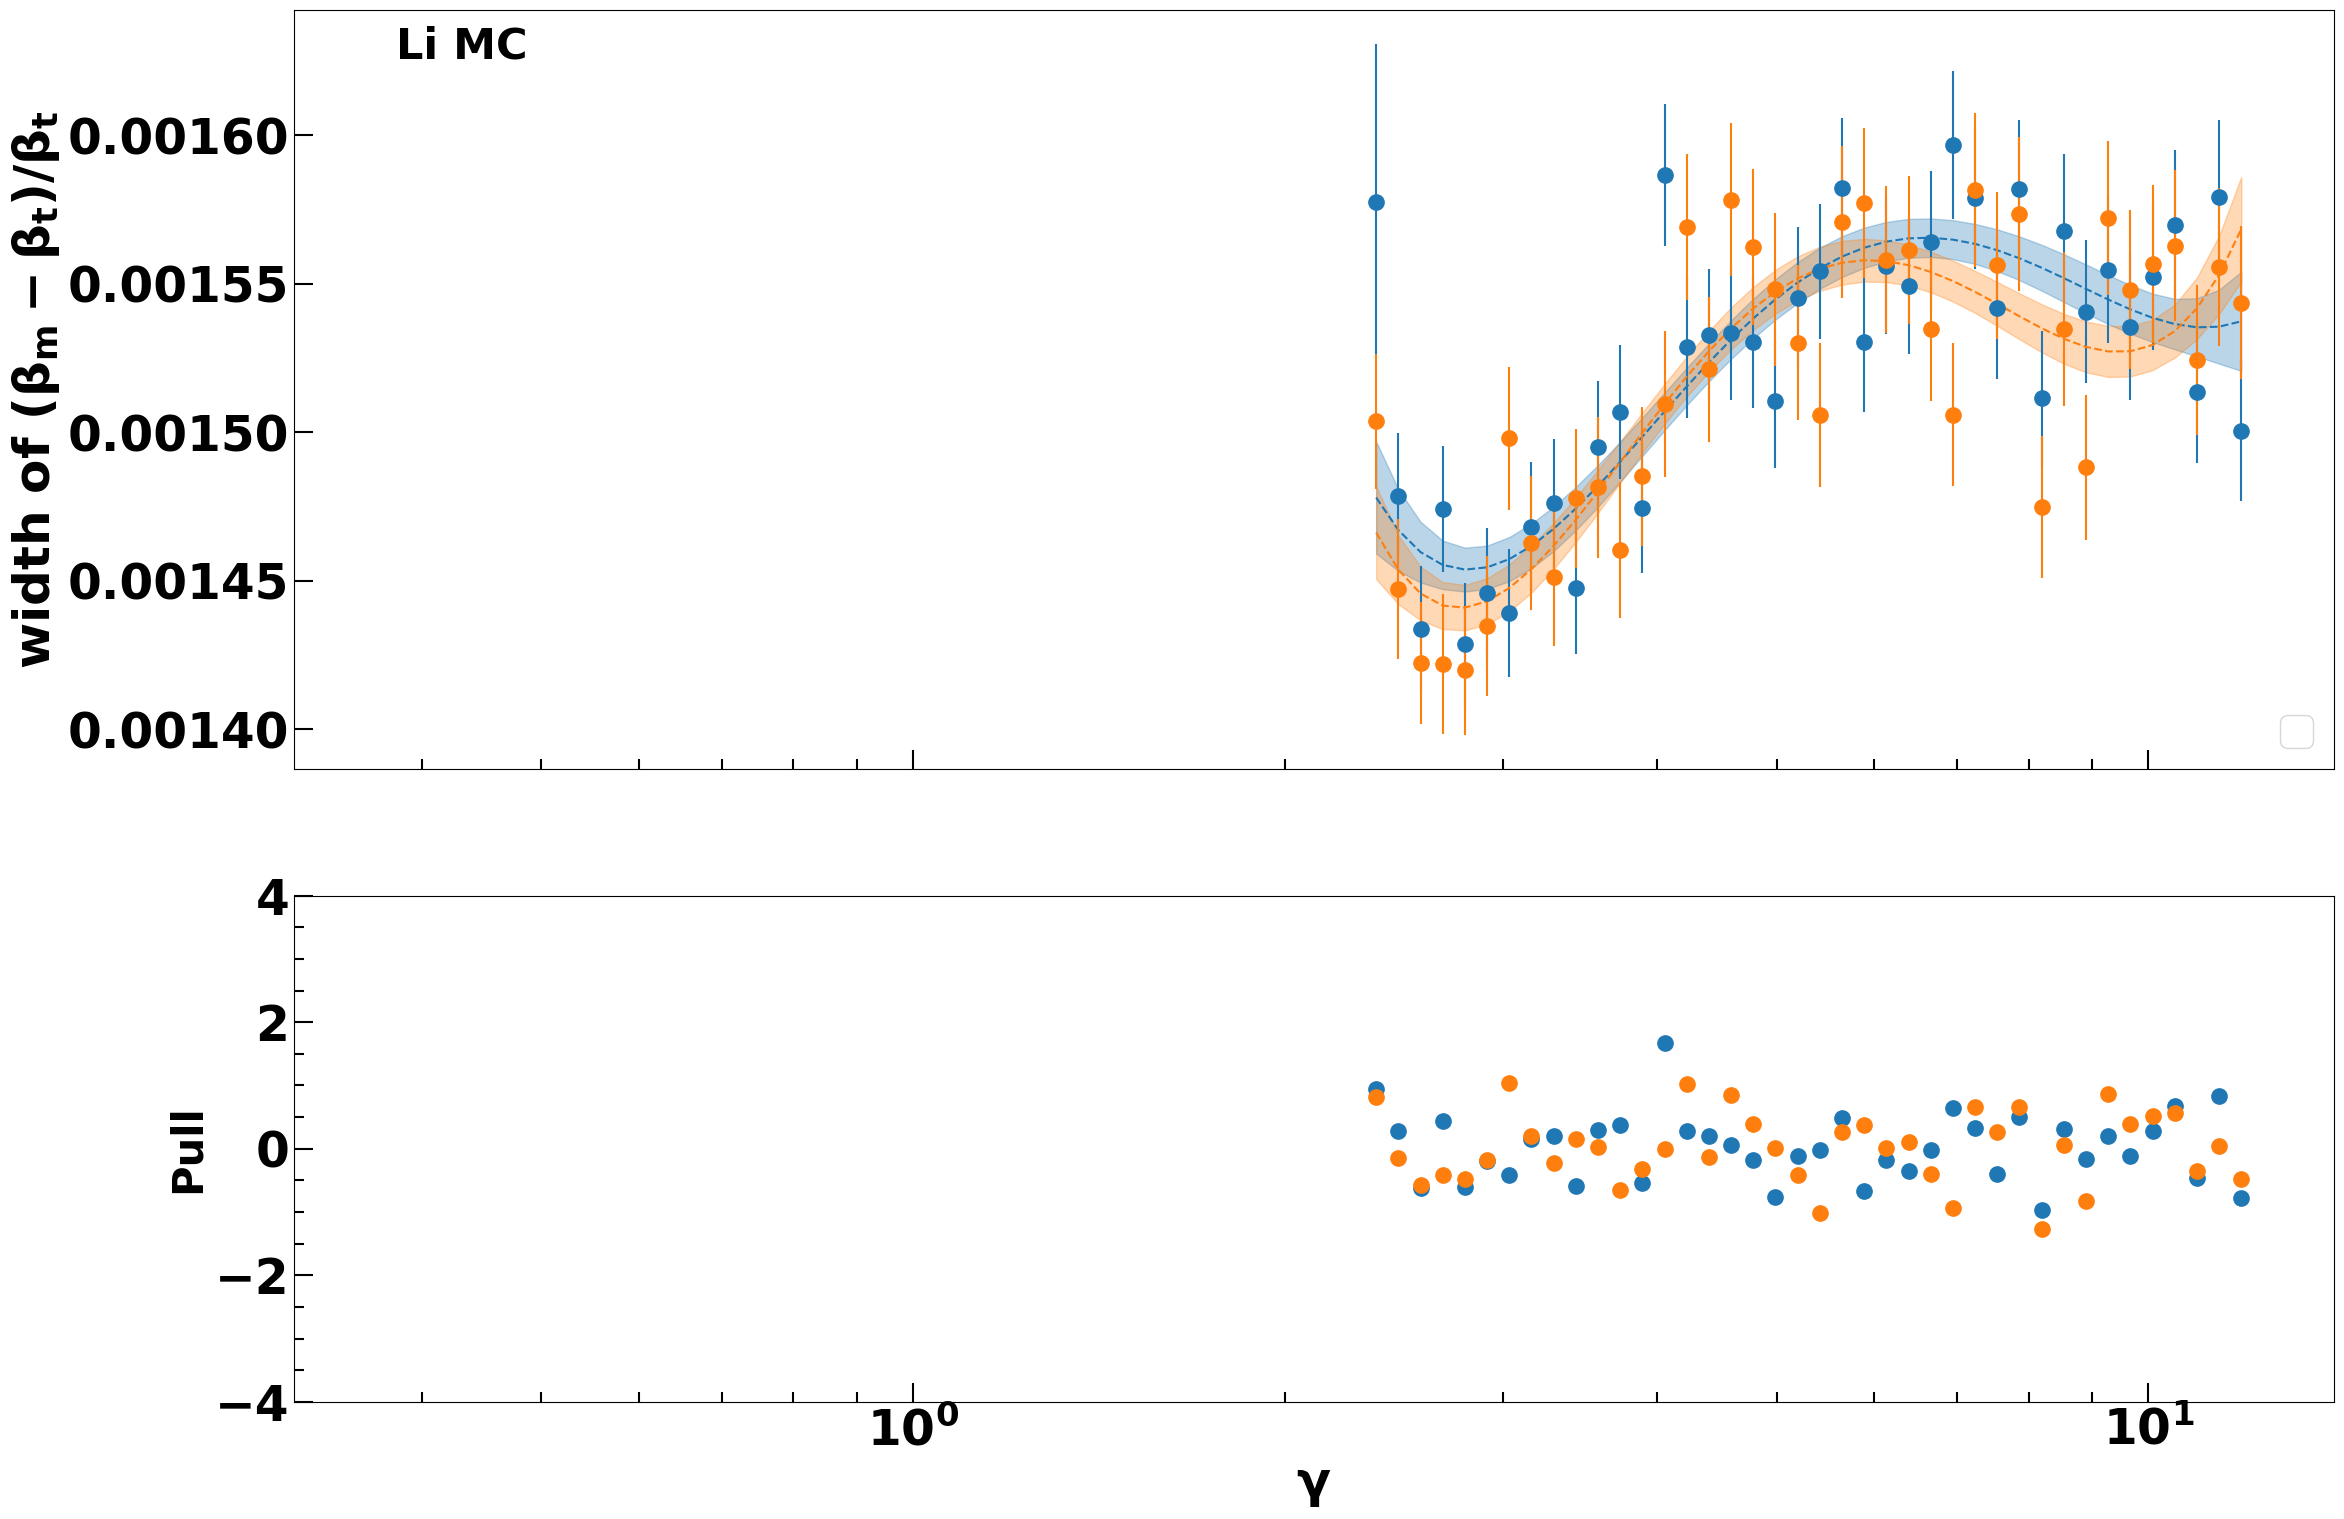

In [15]:
dec = 'NaF'
graph_sigam_timegamma = {dec:{} for dec in detectors}

for dec in detectors:
    for iso in isotopes:
        graph_sigam_timegamma[dec][iso] = MGraph(graph_sigma_betaVsGamma[dec][iso].xvalues, graph_sigma_betaVsGamma[dec][iso].xvalues**2 * graph_sigma_betaVsGamma[dec][iso].yvalues, graph_sigma_betaVsGamma[dec][iso].xvalues**2 *graph_sigma_betaVsGamma[dec][iso].yerrs)
        

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                               
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_NaF = {}
for dec in ['NaF']:
    for iso in isotopes: 
        plot_graph(fig, ax1, graph_sigma_betaVsGamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}' if dec == 'Tof' else None)  
        xval = graph_sigma_betaVsGamma[dec][iso].xvalues 
        popt, pcov = curve_fit(poly, np.log(xval), graph_sigma_betaVsGamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigma_betaVsGamma[dec][iso].yerrs, absolute_sigma=True)
        polypars = uncertainties.correlated_values(popt, pcov) 
        dict_polypar_NaF[iso] = polypars
        yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
        yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
        ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
        ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
        graphpull = get_pull_graph(graph_sigma_betaVsGamma[dec][iso], yfit)
        plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

ax1.text(0.05, 0.98, f"{nuclei} MC", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
graph_ratio_betasigma = graph_sigma_betaVsGamma[dec][ISOTOPES[nuclei][0]]/graph_sigma_betaVsGamma[dec][ISOTOPES[nuclei][1]]

#plot_graph(fig, ax2, ratio9to7_Tof, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7_Tof, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
#plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
#ax1.set_ylim([0.00001, 0.001])
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma", show=True) 

In [16]:
###To be deleted, read the sigma from GAG fitting and plot 

filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/BetaReso/df_betareso_sigma.npz'
df_sigma = np.load(f'{filename}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_betareso_sigma_Tof = dict()
dict_polypar_Tof = dict()
graph_sigam_timegamma_Tof = dict()
for iso in isotopes:
    graph_betareso_sigma_Tof[iso] = MGraph.from_file(df_sigma, f"graph_sigma_Tof_{iso}")
    graph_sigam_timegamma_Tof[iso] = MGraph(graph_betareso_sigma_Tof[iso].xvalues, graph_betareso_sigma_Tof[iso].xvalues**2 * graph_betareso_sigma_Tof[iso].yvalues, graph_betareso_sigma_Tof[iso].xvalues**2 *graph_betareso_sigma_Tof[iso].yerrs)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_betareso_sigma_Tof[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_betareso_sigma_Tof[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_betareso_sigma_Tof[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_betareso_sigma_Tof[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_Tof[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_betareso_sigma_Tof[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

ax1.text(0.05, 0.98, "Be MC Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ratio9to7_Tof = graph_betareso_sigma_Tof['Be9']/graph_betareso_sigma_Tof['Be7']
ratio10to7_Tof = graph_betareso_sigma_Tof['Be10']/graph_betareso_sigma_Tof['Be7']

#plot_graph(fig, ax2, ratio9to7_Tof, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7_Tof, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.006, 0.014])
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma_Tof", show=True) 


FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/LiP8/BetaReso/df_betareso_sigma.npz'

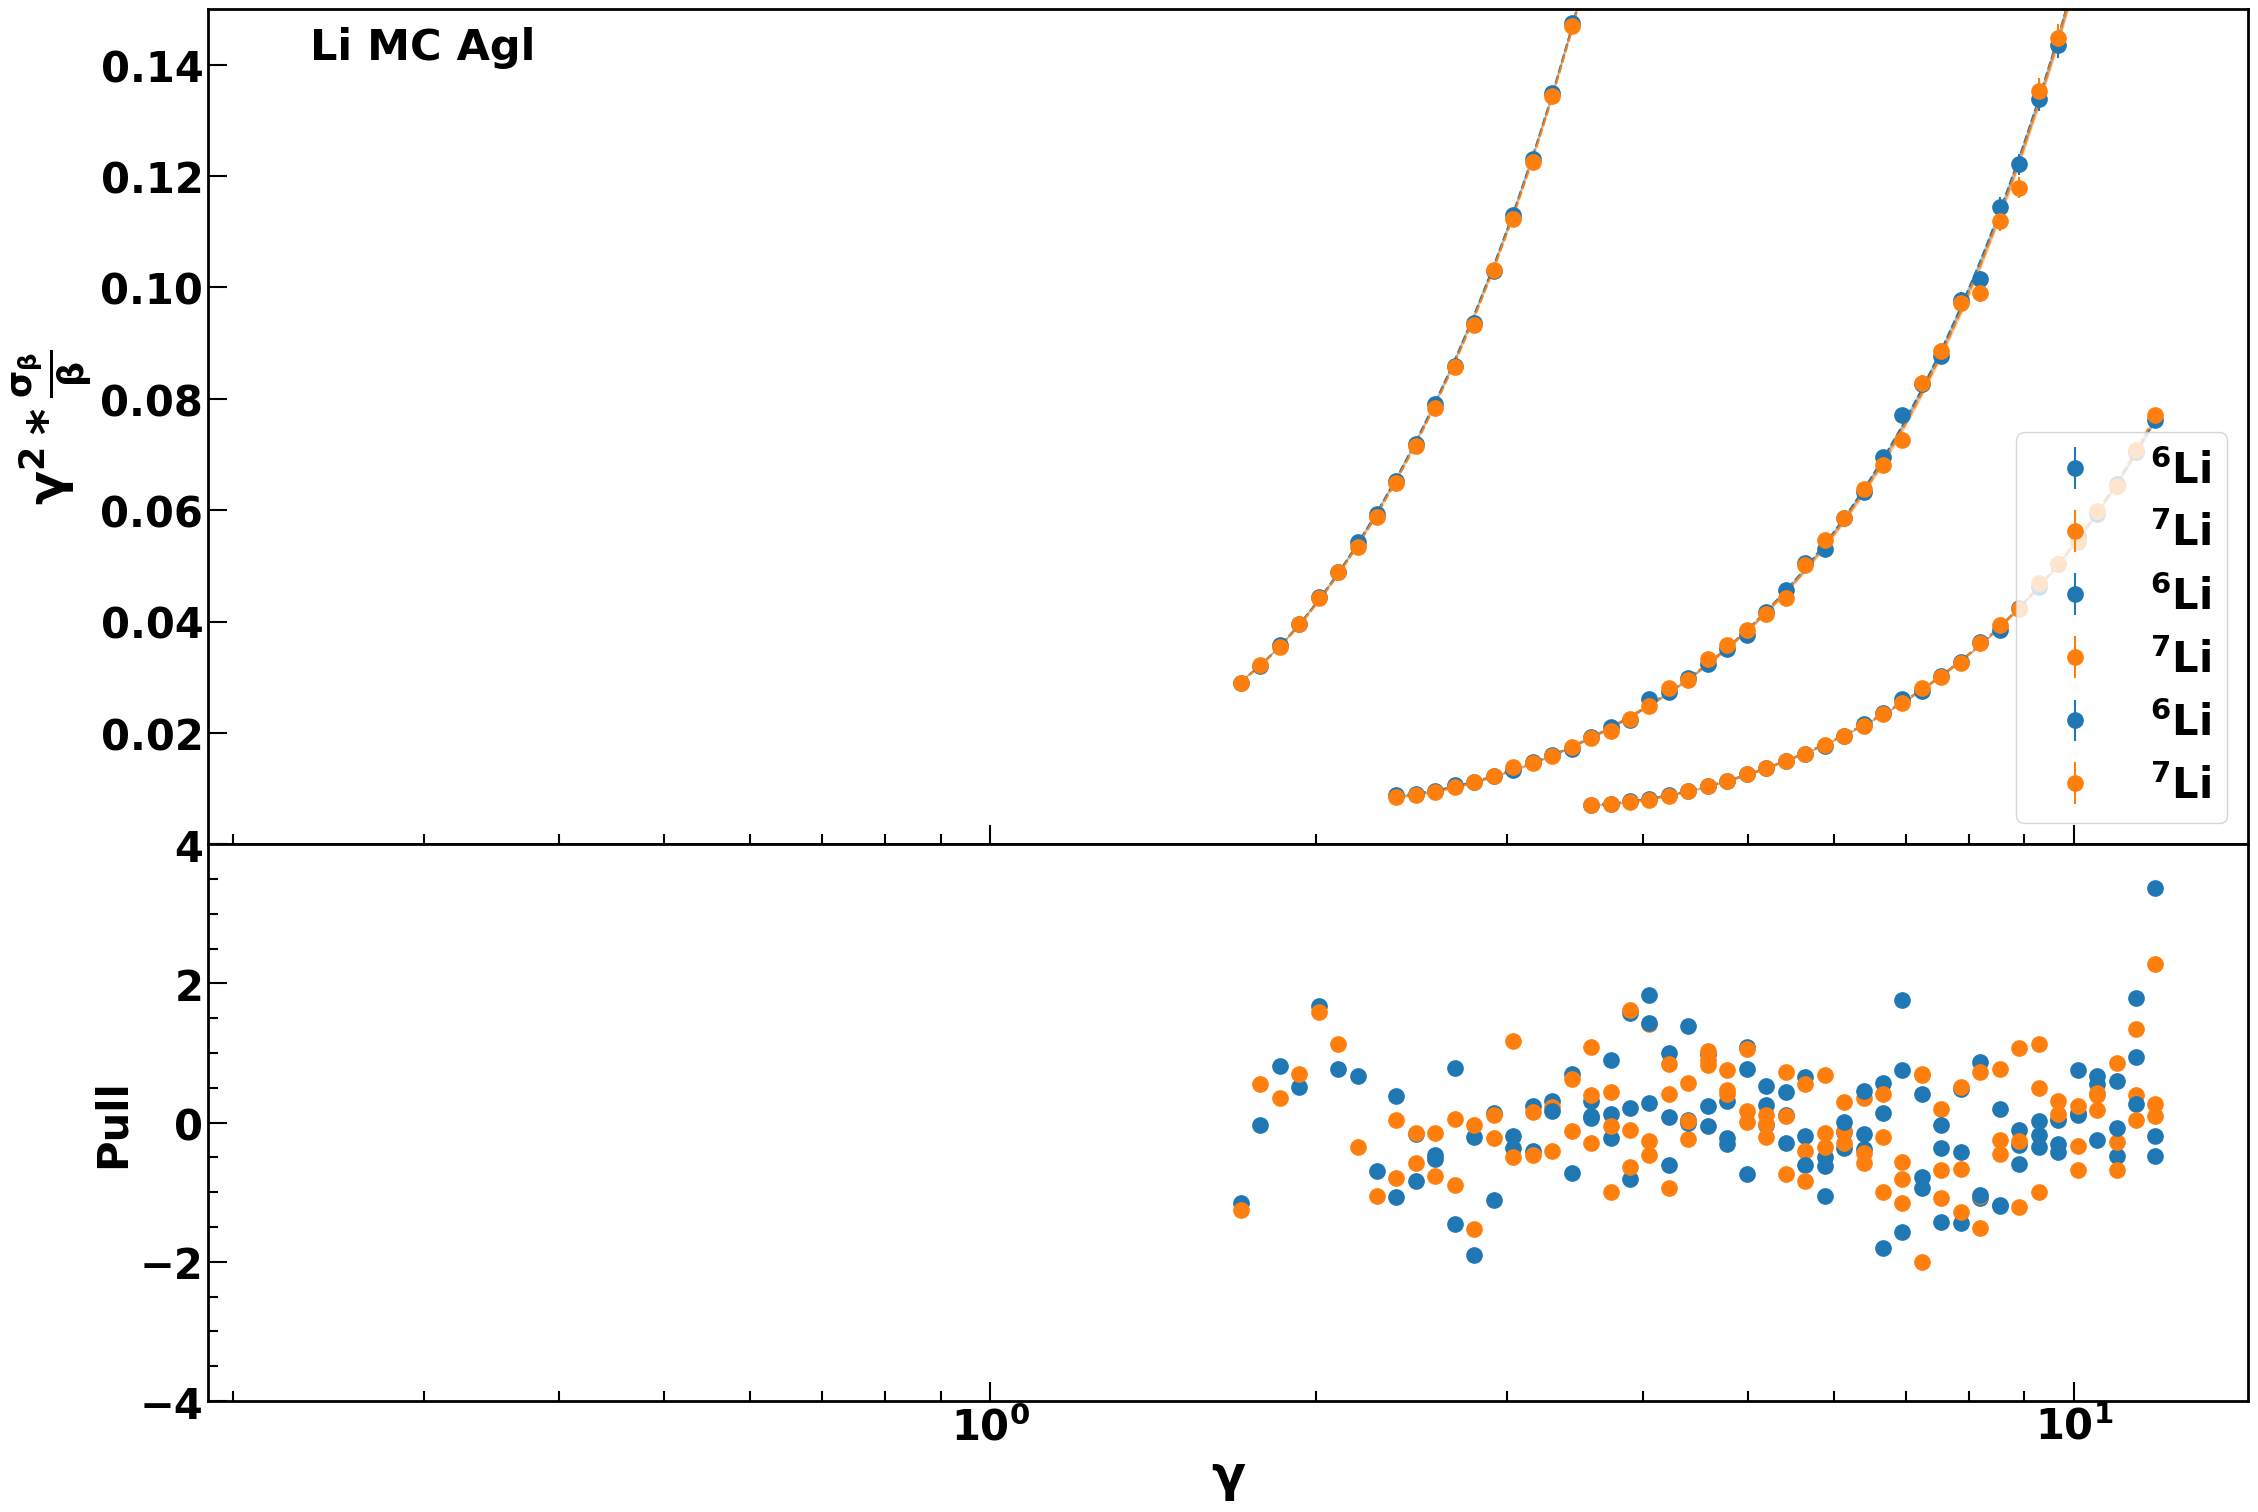

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

dict_polypar_beta = {dec: {} for dec in detectors}
betagamma_ratio = {}
for dec in detectors:
    for iso in isotopes: 
        plot_graph(fig, ax1, graph_sigam_timegamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
        xval = graph_sigam_timegamma[dec][iso].xvalues 
        popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma[dec][iso].yerrs, absolute_sigma=True)
        polypars = uncertainties.correlated_values(popt, pcov) 
        dict_polypar_beta[dec][iso] = polypars
        yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
        yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
        ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
        ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
        graphpull = get_pull_graph(graph_sigam_timegamma[dec][iso], yfit)
        plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

        betagamma_ratio[dec] = graph_sigam_timegamma[dec]['Li6']/graph_sigam_timegamma[dec]['Li7']
 
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.text(0.05, 0.98, f"{nuclei} MC {dec}", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
ax1.set_ylim([0.0, 0.15])
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)

savefig_tofile(fig, plotdir, f"betaterm_vs_gamma_Tof1", show=True) 
#ax1.set_ylim([0.008, 0.011])

/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


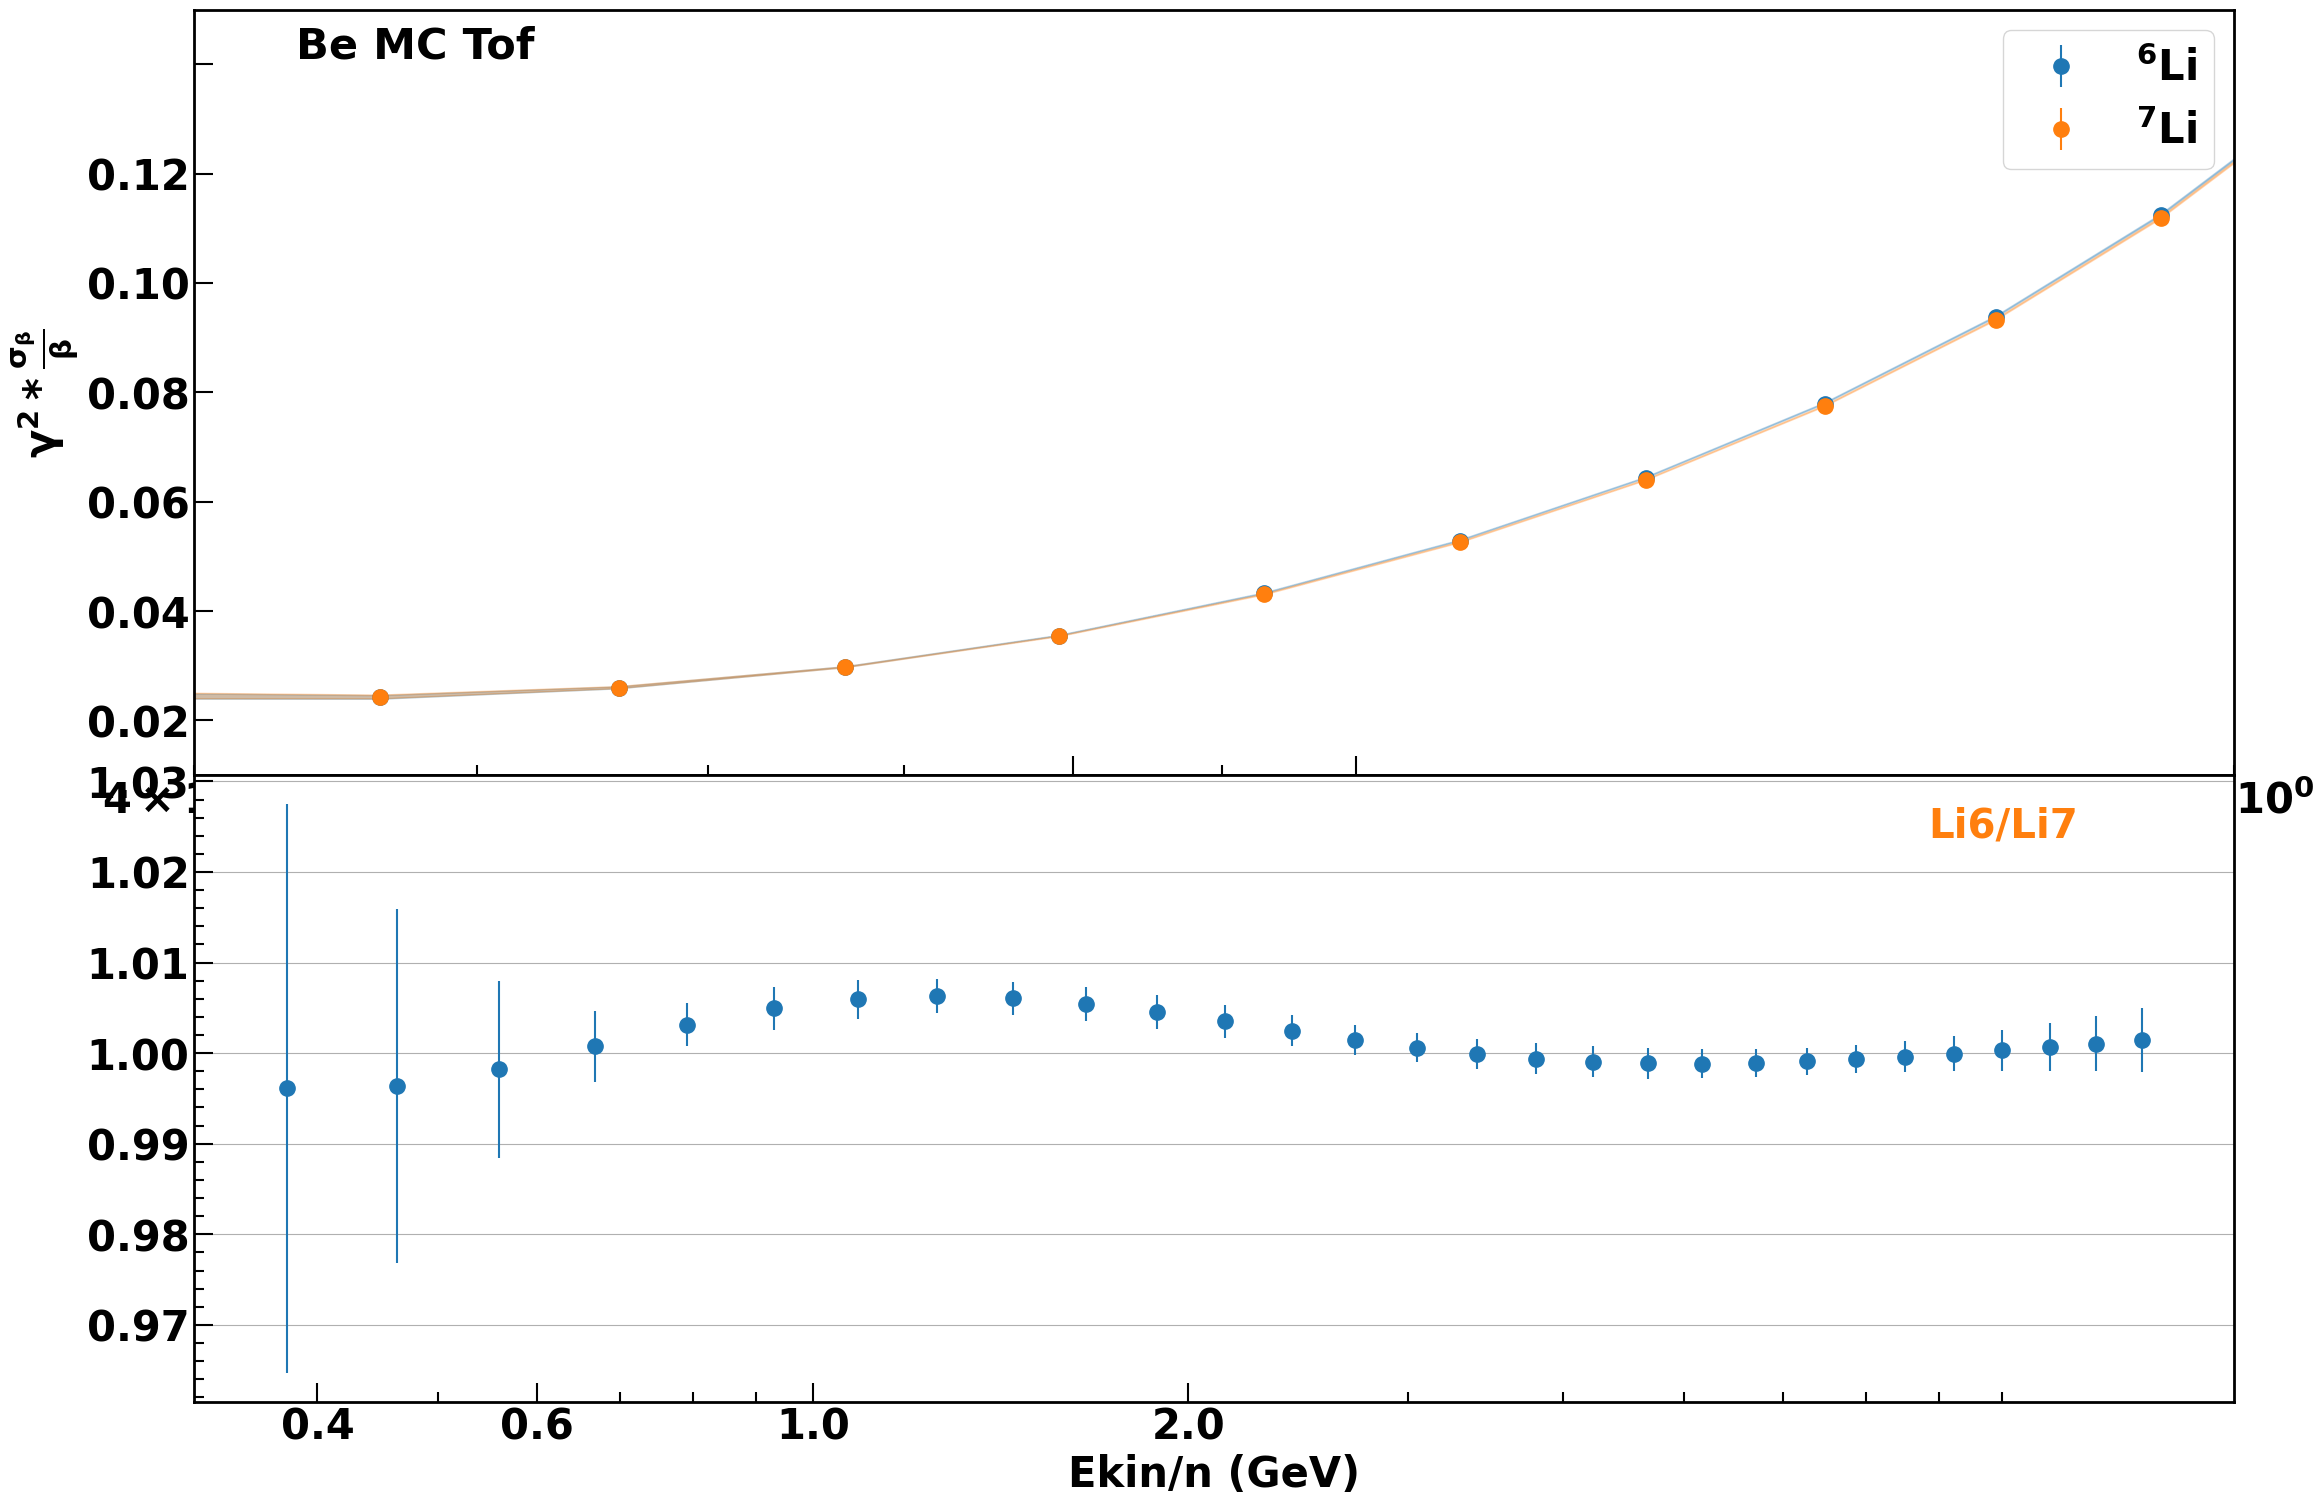

In [34]:
dec = 'Tof'
from tools.constants import MASS_NUCLEON_GEV
def calc_gamma_from_ekin(ekin):                                                                                                                                                                          
    gamma = ekin/MASS_NUCLEON_GEV + 1.0                                                                                                                                                                  
    return gamma  

x_ekin = get_bin_center(fbinning_energy())

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
graph_betaterm_vs_ekin_Tof = dict()
for iso in isotopes:
    xval_gamma = calc_gamma_from_ekin(x_ekin)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval_gamma), dict_polypar_beta[dec][iso], upoly)
    #ax1.plot(x_ekin, yfit, "--",  color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}')
    graph_betaterm_vs_ekin_Tof[iso] = MGraph(x_ekin, yfit, yfit_err)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval_gamma), dict_polypar_beta[dec][iso], upoly)
    ax1.fill_between(x_ekin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    plot_graph(fig, ax1, graph_betaterm_vs_ekin_Tof[iso] , color=ISOTOPES_COLOR[iso],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
graph_ratio_9 = graph_betaterm_vs_ekin_Tof['Li6']/graph_betaterm_vs_ekin_Tof['Li7']
plot_graph(fig, ax2, graph_ratio_9, color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  

ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')                                            
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
#ax1.set_xticks([0.8, 1.0])
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_xscale('log')
ax1.set_ylim([0.01, 0.15])
ax1.set_xlim([0.4, 2.0])
ax2.grid(axis='y')

plt.subplots_adjust(hspace=.0)   
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([0.4, 0.6, 1.0, 2.0]))

ax1.set_xticks(np.array([0.8, 1.0]))
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax1.get_xticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.text(0.85, 0.95, "Li6/Li7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])
ax1.text(0.05, 0.98, "Be MC Tof", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
print(plotdir)
savefig_tofile(fig, plotdir, f"betaterm_vs_ekin_Tof", show=True) 


In [35]:
#To be deleted, read sigma from GAG fitting and plot
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/betareso/df_betareso_sigma.npz'
df_sigma = np.load(f'{filename}')

graph_betasigma_NaF = dict()
dict_polypar_NaF = dict()
graph_sigam_timegamma_NaF = dict()
for iso in isotopes:
    graph_betasigma_NaF[iso] = MGraph.from_file(df_sigma, f"graph_sigma_NaF_{iso}")
    graph_sigam_timegamma_NaF[iso] = MGraph(graph_betasigma_NaF[iso].xvalues, graph_betasigma_NaF[iso].xvalues**2 * graph_betasigma_NaF[iso].yvalues, graph_betasigma_NaF[iso].xvalues**2 *graph_betasigma_NaF[iso].yerrs)
   
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes: 
    plot_graph(fig, ax1, graph_betasigma_NaF[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_betasigma_NaF[iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_betasigma_NaF[iso].yvalues, p0 = 1 / (10 ** np.arange(1, 5)), sigma=graph_betasigma_NaF[iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_NaF[iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_betasigma_NaF[iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  

ax1.text(0.05, 0.98, "Be MC NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ratio9to7 = graph_betasigma_NaF['Be9']/graph_betasigma_NaF['Be7']
ratio10to7 = graph_betasigma_NaF['Be10']/graph_betasigma_NaF['Be7']
#plot_graph(fig, ax2, ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{width~of~(\beta_{m} - \beta_{t})/\beta_{t}}$') 
ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
#ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0008, 0.0015])
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
#ax1.set_ylim([0.0005, 0.001])
print(plotdir)
savefig_tofile(fig, plotdir, f"beta_resolution_vs_gamma_NaF", show=True) 

KeyError: 'graph_sigma_NaF_Li6_xvalues is not a file in the archive'

/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


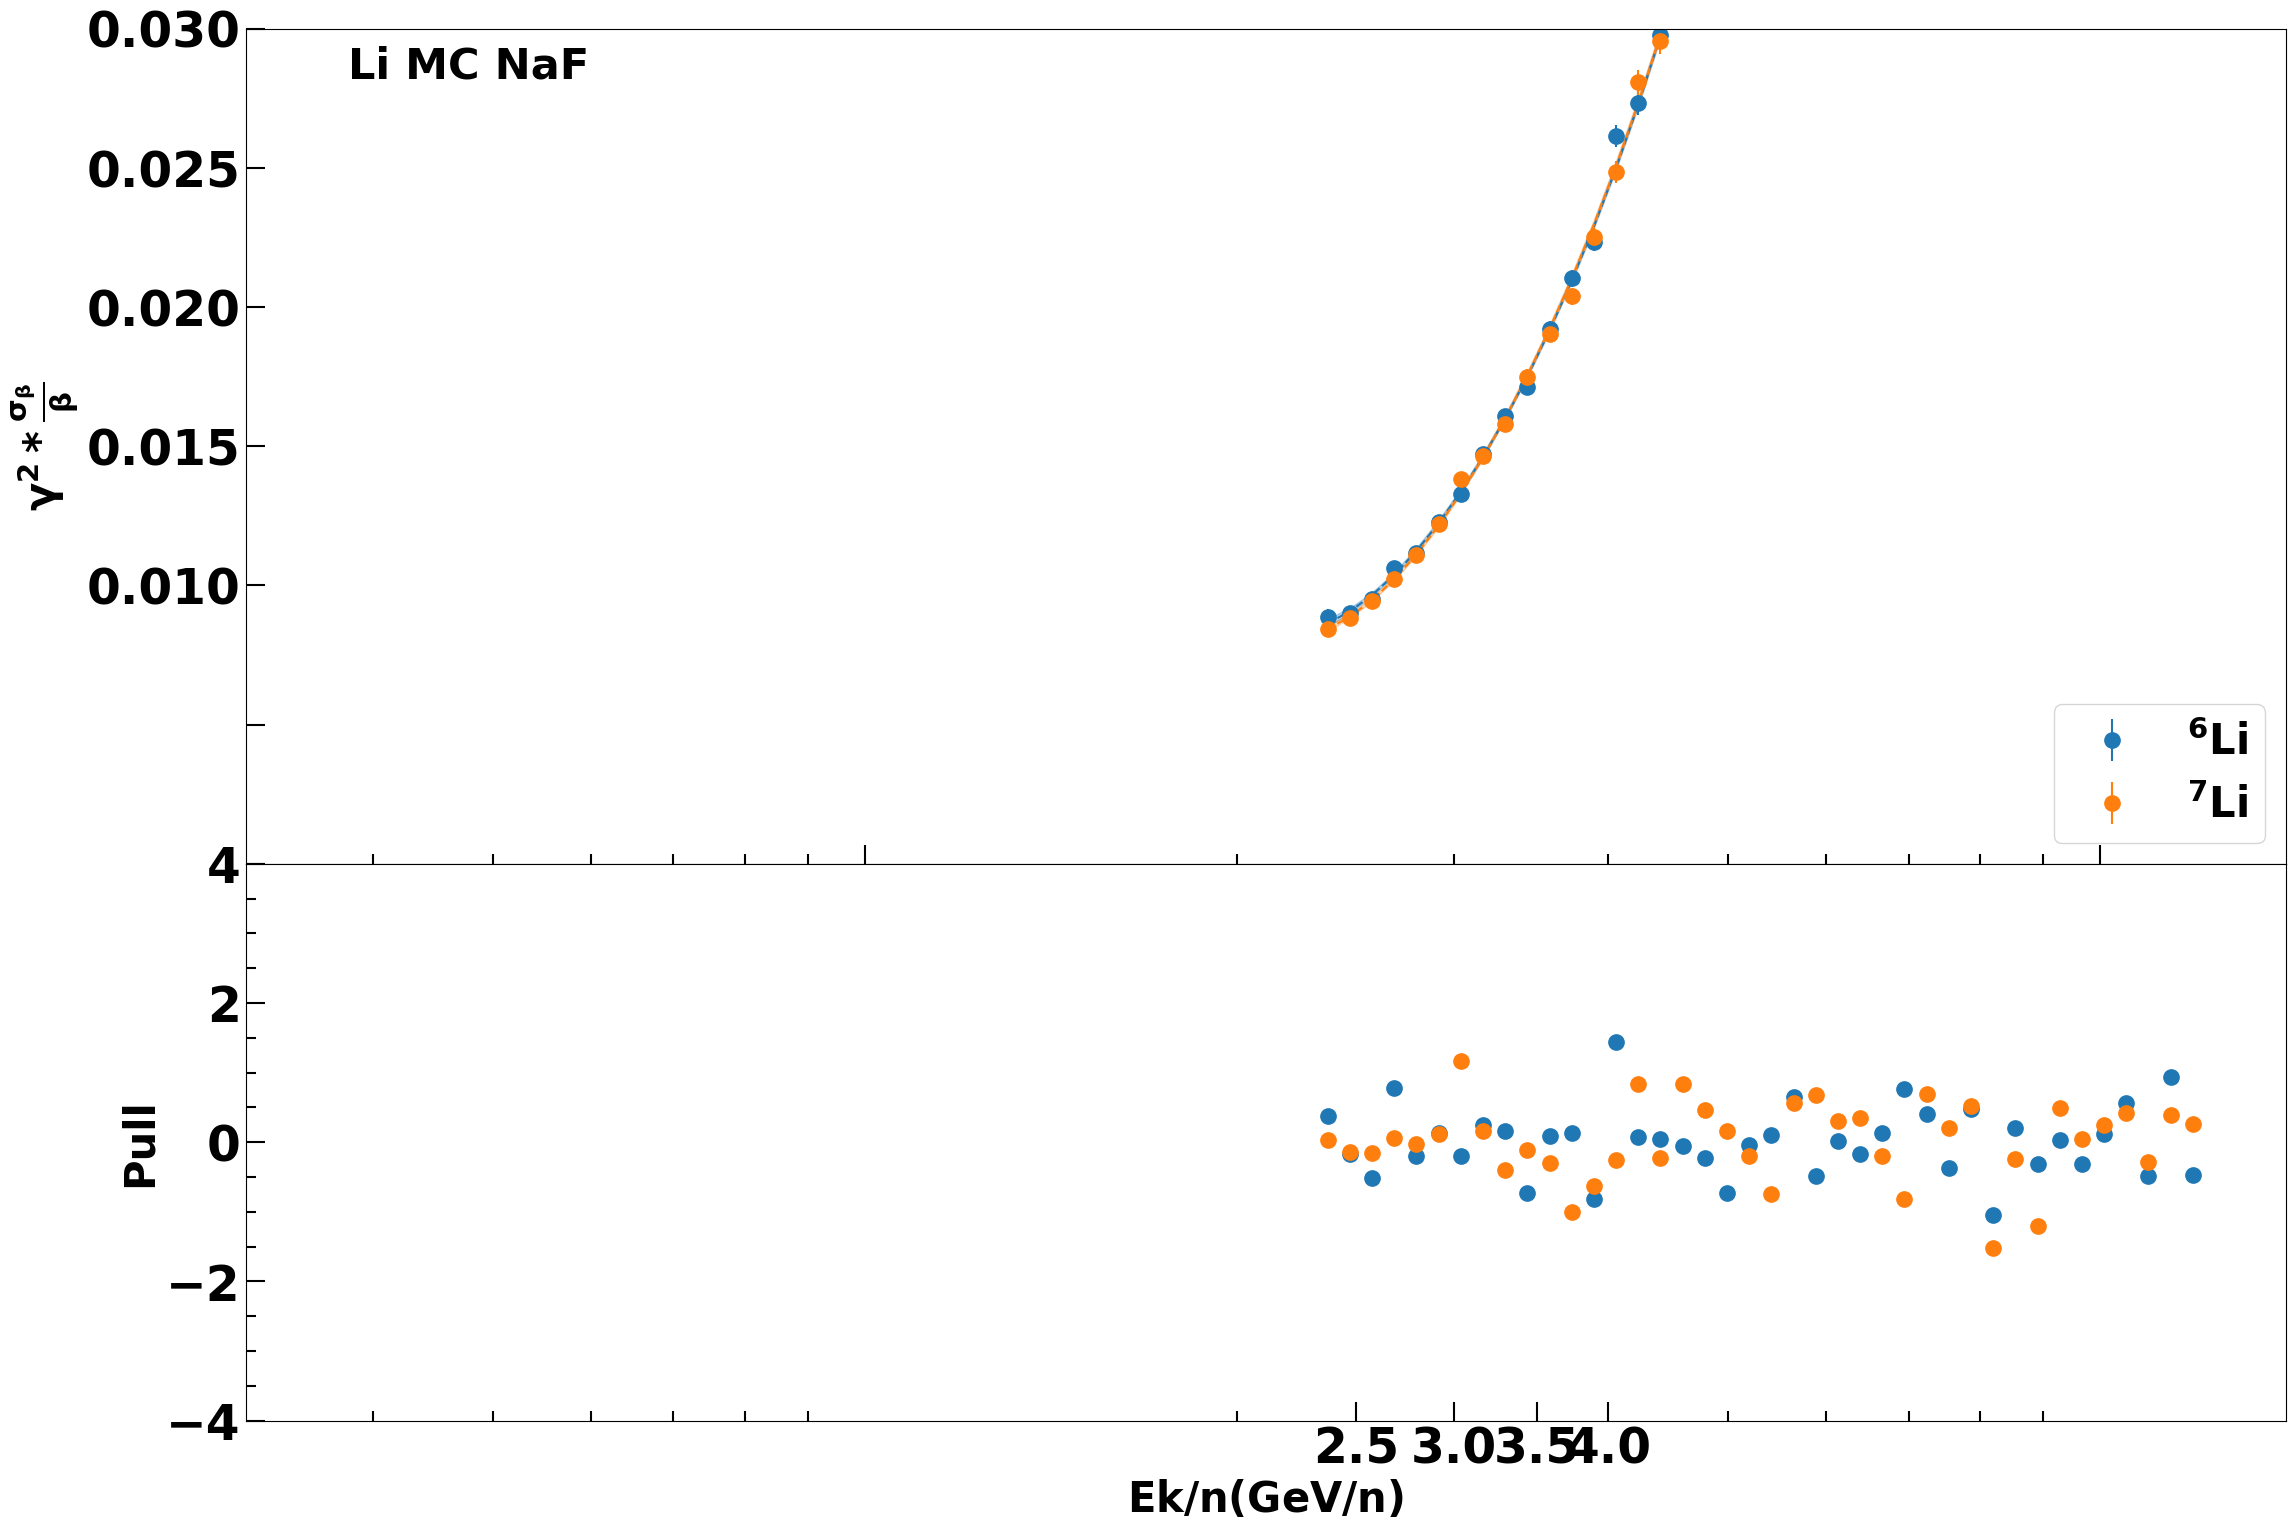

In [20]:
dec = 'NaF'
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_beta_NaF = dict()
for iso in isotopes: 
    plot_graph(fig, ax1, graph_sigam_timegamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_sigam_timegamma[dec][iso].xvalues 

    popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma[dec][iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_beta[dec][iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_sigam_timegamma[dec][iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
betagamma_ratio9to7 = graph_sigam_timegamma[dec]['Li6']/graph_sigam_timegamma[dec]['Li7']

#plot_graph(fig, ax2, betagamma_ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, betagamma_ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')
ax2.set_xlabel(r'$\mathrm{Ek/n (GeV/n)}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
ax1.set_ylim([0.0, 0.03])
ax1.get_yticklabels()[0].set_visible(False)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([2.5, 3.0, 3.5, 4.0]))
ax1.text(0.05, 0.98, f"{nuclei} MC {dec}", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"betaterm_vs_gamma_NaF1", show=True) 
print(plotdir)
#ax1.set_ylim([0.008, 0.011])

[ 3.58434172  3.73566745  3.89338192  4.05775488  4.22906742  4.40761253
  4.59369555  4.78763473  4.98976175  5.20042227  5.41997657  5.64880014
  5.88728432  6.13583694  6.3948831   6.66486582  6.94624681  7.2395073
  7.54514883  7.8636941   8.19568789  8.54169798  8.90231611  9.27815902
  9.66986947 10.07811737 10.50360091 10.94704775 11.40921627 11.89089688]
[ 3.58434172  3.73566745  3.89338192  4.05775488  4.22906742  4.40761253
  4.59369555  4.78763473  4.98976175  5.20042227  5.41997657  5.64880014
  5.88728432  6.13583694  6.3948831   6.66486582  6.94624681  7.2395073
  7.54514883  7.8636941   8.19568789  8.54169798  8.90231611  9.27815902
  9.66986947 10.07811737 10.50360091 10.94704775 11.40921627 11.89089688]
/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


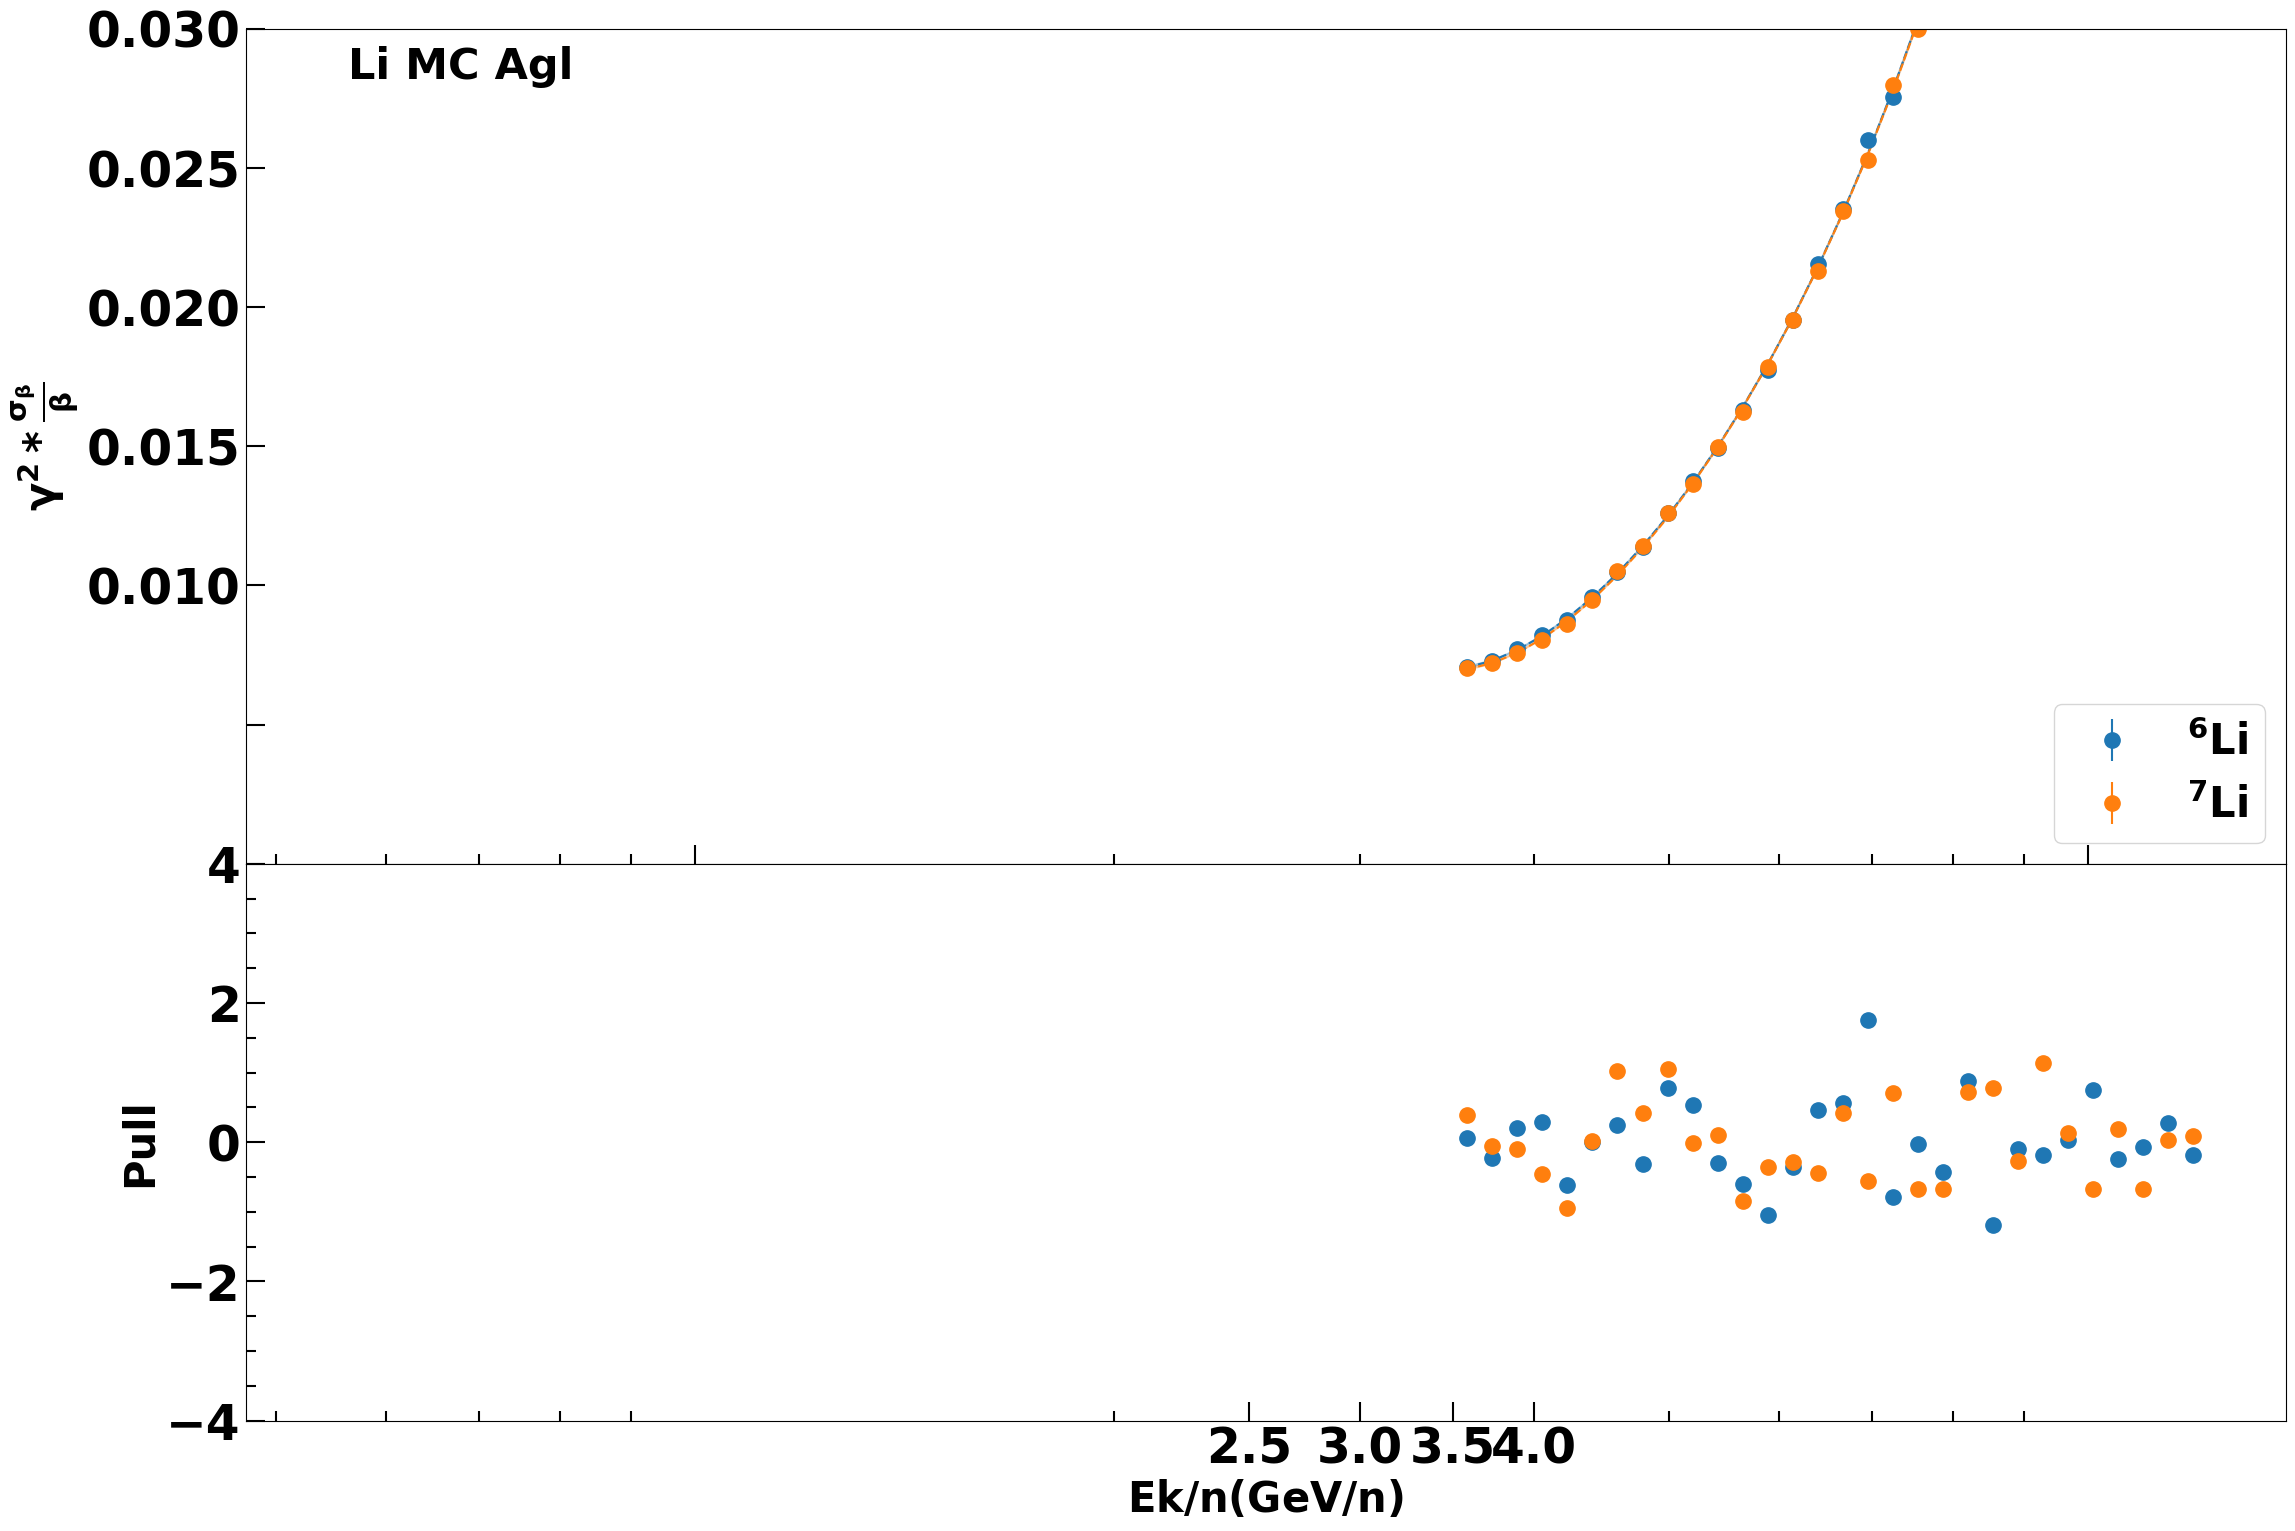

In [36]:
dec = 'Agl'
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_beta_NaF = dict()
for iso in isotopes: 
    plot_graph(fig, ax1, graph_sigam_timegamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_sigam_timegamma[dec][iso].xvalues 
    print(xval)
    popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma[dec][iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_beta[dec][iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    graphpull = get_pull_graph(graph_sigam_timegamma[dec][iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
betagamma_ratio9to7 = graph_sigam_timegamma[dec]['Li6']/graph_sigam_timegamma[dec]['Li7']

#plot_graph(fig, ax2, betagamma_ratio9to7, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, betagamma_ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')
ax2.set_xlabel(r'$\mathrm{Ek/n (GeV/n)}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.set_ylim([-4, 4])
ax1.set_ylim([0.0, 0.03])
ax1.get_yticklabels()[0].set_visible(False)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([2.5, 3.0, 3.5, 4.0]))
ax1.text(0.05, 0.98, f"{nuclei} MC {dec}", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"betaterm_vs_gamma_NaF1", show=True) 
print(plotdir)
#ax1.set_ylim([0.008, 0.011])

[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]
[ 1.40606806  1.49715828  1.60011115  1.7175032   1.84944177  1.99871808
  2.1653858   2.34955229  2.55390141  2.77843316  3.02599244  3.29942412
  3.59878189  3.92401208  4.27795957  4.66357661  5.08080953  5.53261057
  6.02198565  6.54888109  7.12537428  7.73321495  8.37234943  9.07310535
  9.83559005 10.65980353 11.54569213 12.49325583 13.50244097]


Text(0.85, 0.95, 'Li6/Li7')

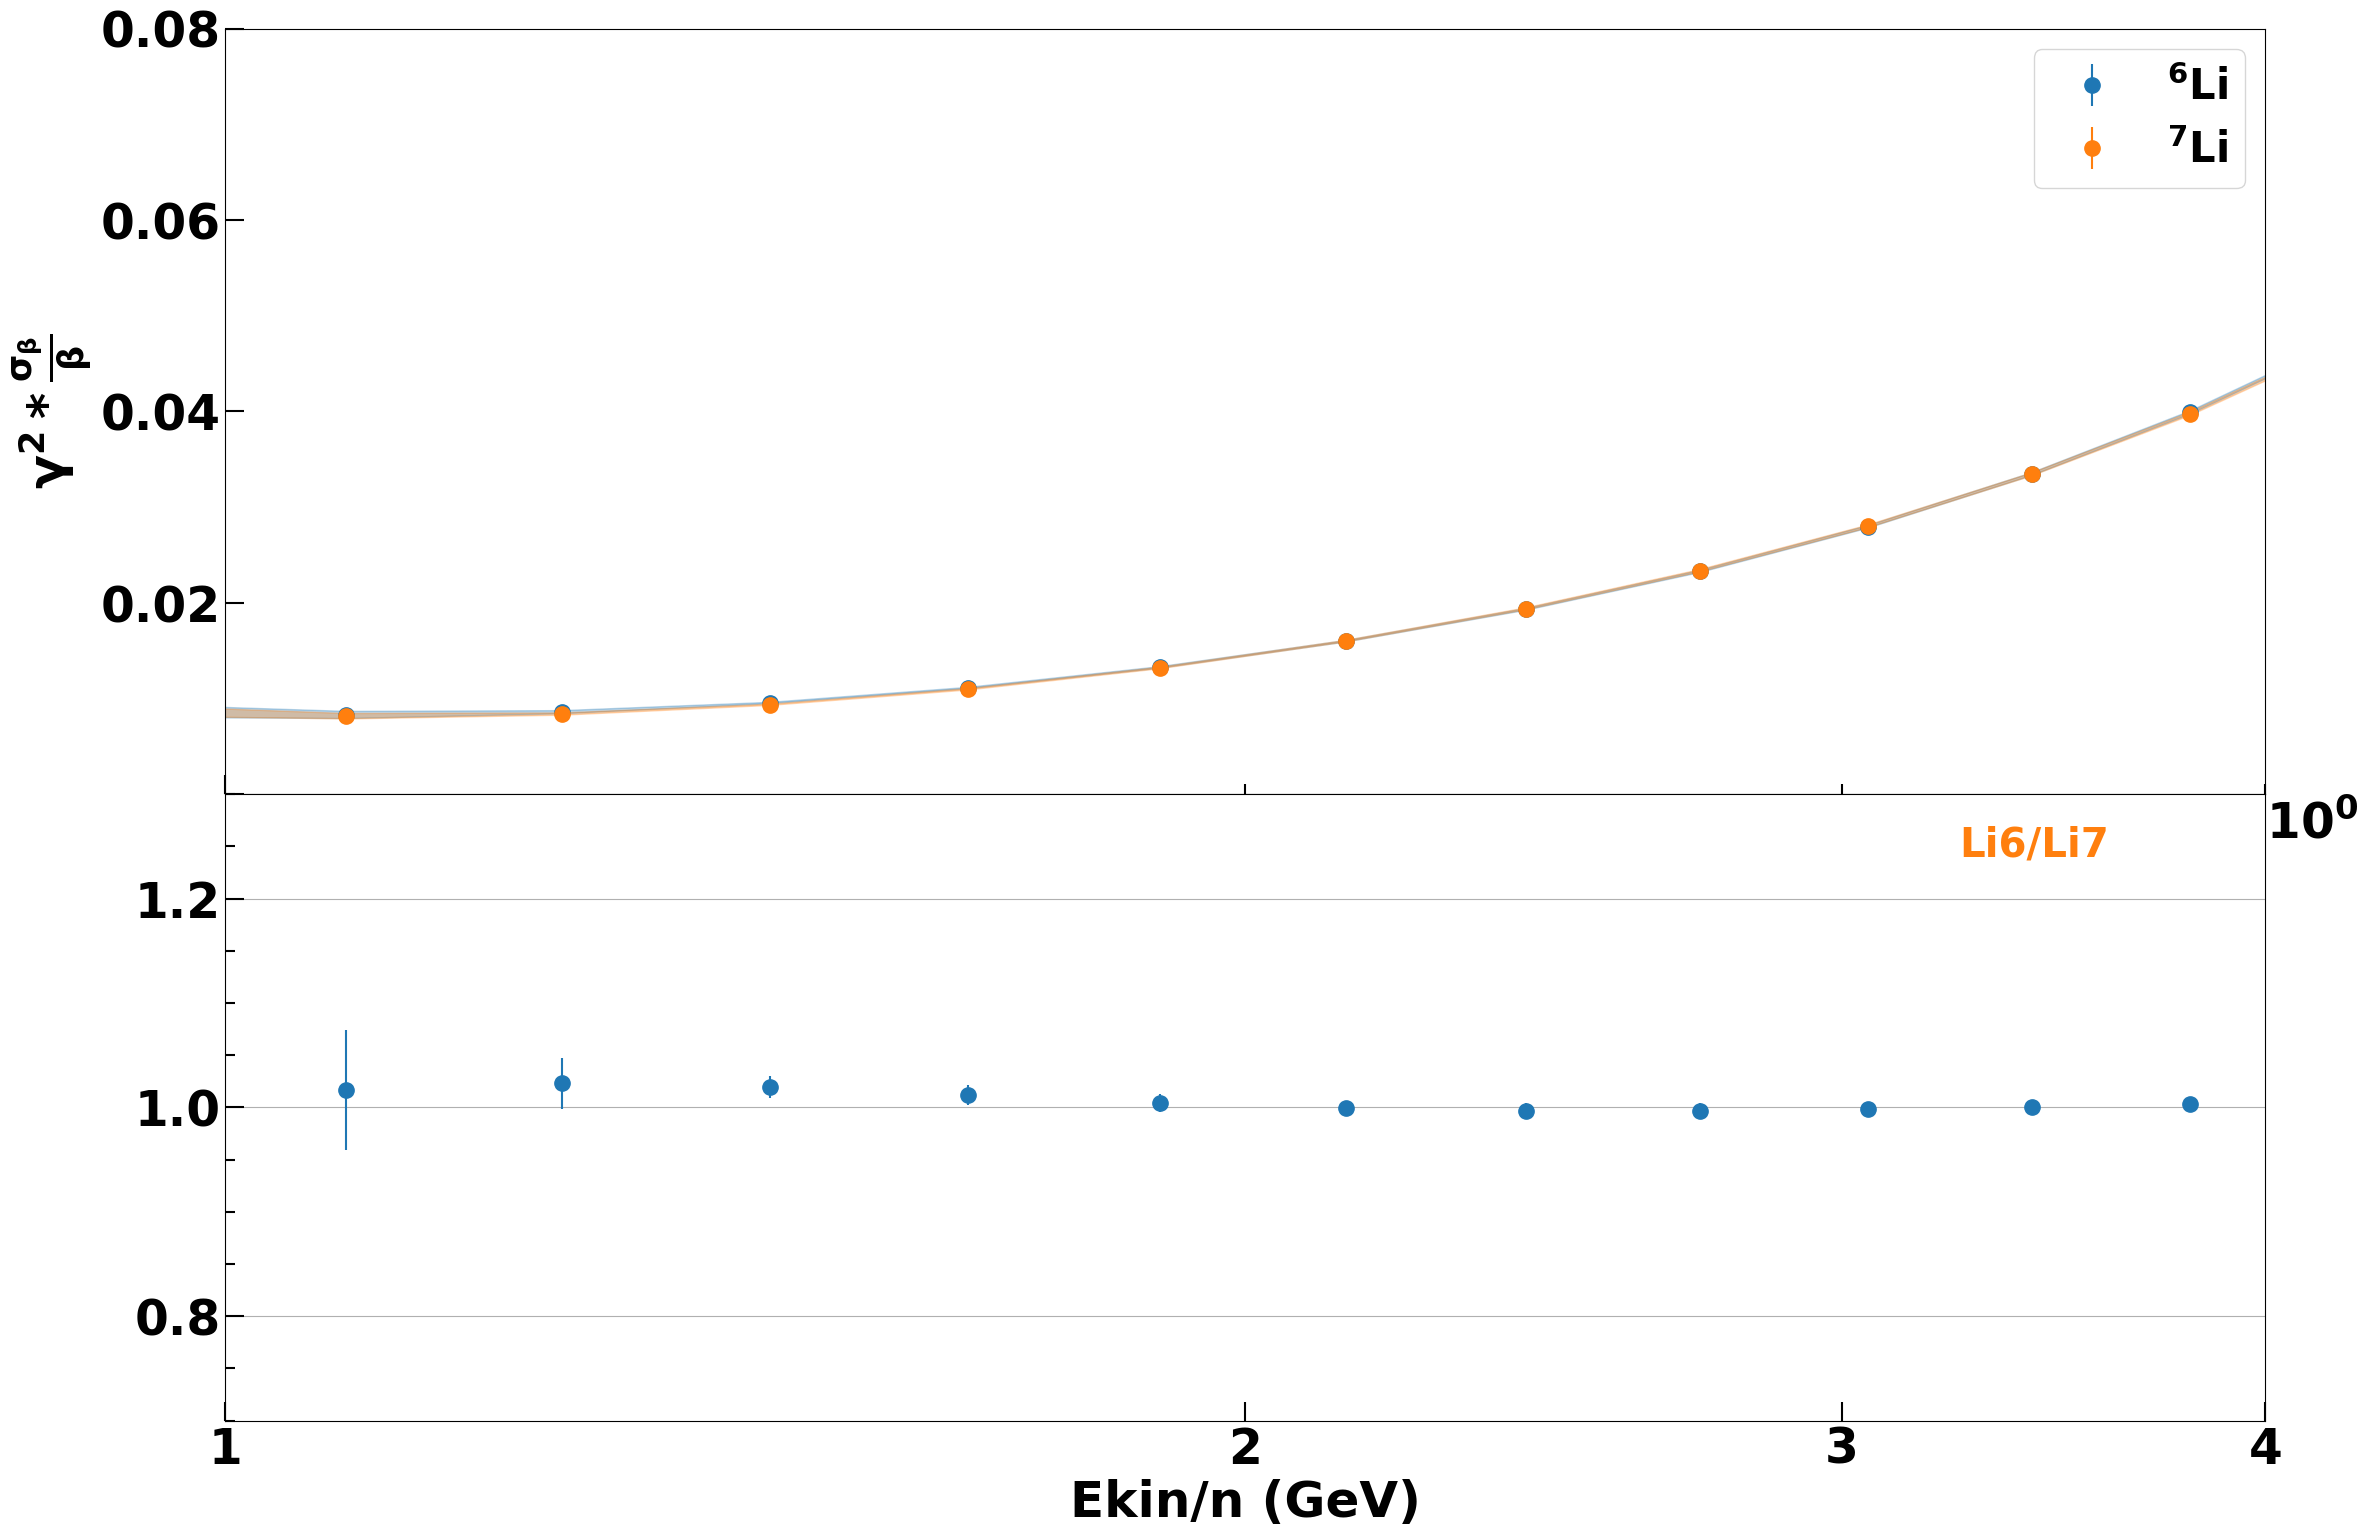

In [37]:
from tools.constants import MASS_NUCLEON_GEV
dec = 'NaF'
def calc_gamma_from_ekin(ekin):                                                                                                                                                                          
    gamma = ekin/MASS_NUCLEON_GEV + 1.0                                                                                                                                                                  
    return gamma  

x_ekin = get_bin_center(fbinning_energy())

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
graph_betaterm_vs_ekin_NaF = dict()
for iso in isotopes:
    xval_gamma = calc_gamma_from_ekin(x_ekin)
    print(xval_gamma)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval_gamma), dict_polypar_beta[dec][iso], upoly)
    #ax1.plot(x_ekin, yfit, "--",  color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}')
    graph_betaterm_vs_ekin_NaF[iso] = MGraph(x_ekin, yfit, yfit_err)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval_gamma), dict_polypar_beta[dec][iso], upoly)
    ax1.fill_between(x_ekin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    plot_graph(fig, ax1, graph_betaterm_vs_ekin_NaF[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
    
graph_ratio = graph_betaterm_vs_ekin_NaF['Li6']/graph_betaterm_vs_ekin_NaF['Li7']

plot_graph(fig, ax2, graph_ratio, color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  

ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')                                            
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0, 0.08])
ax2.set_ylim([0.7, 1.3])
ax1.set_xlim([1.0, 4.0])
ax2.set_xlim([1.0, 4.0])
ax2.grid(axis='y')

plt.subplots_adjust(hspace=.0)   
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([1, 2, 3, 4]))
ax2.text(0.85, 0.95, "Li6/Li7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])

#ax1.text(0.05, 0.98, "Be MC NaF", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

#savefig_tofile(fig, plotdir, f"betaterm_vs_ekin_NaF", show=True) 


/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


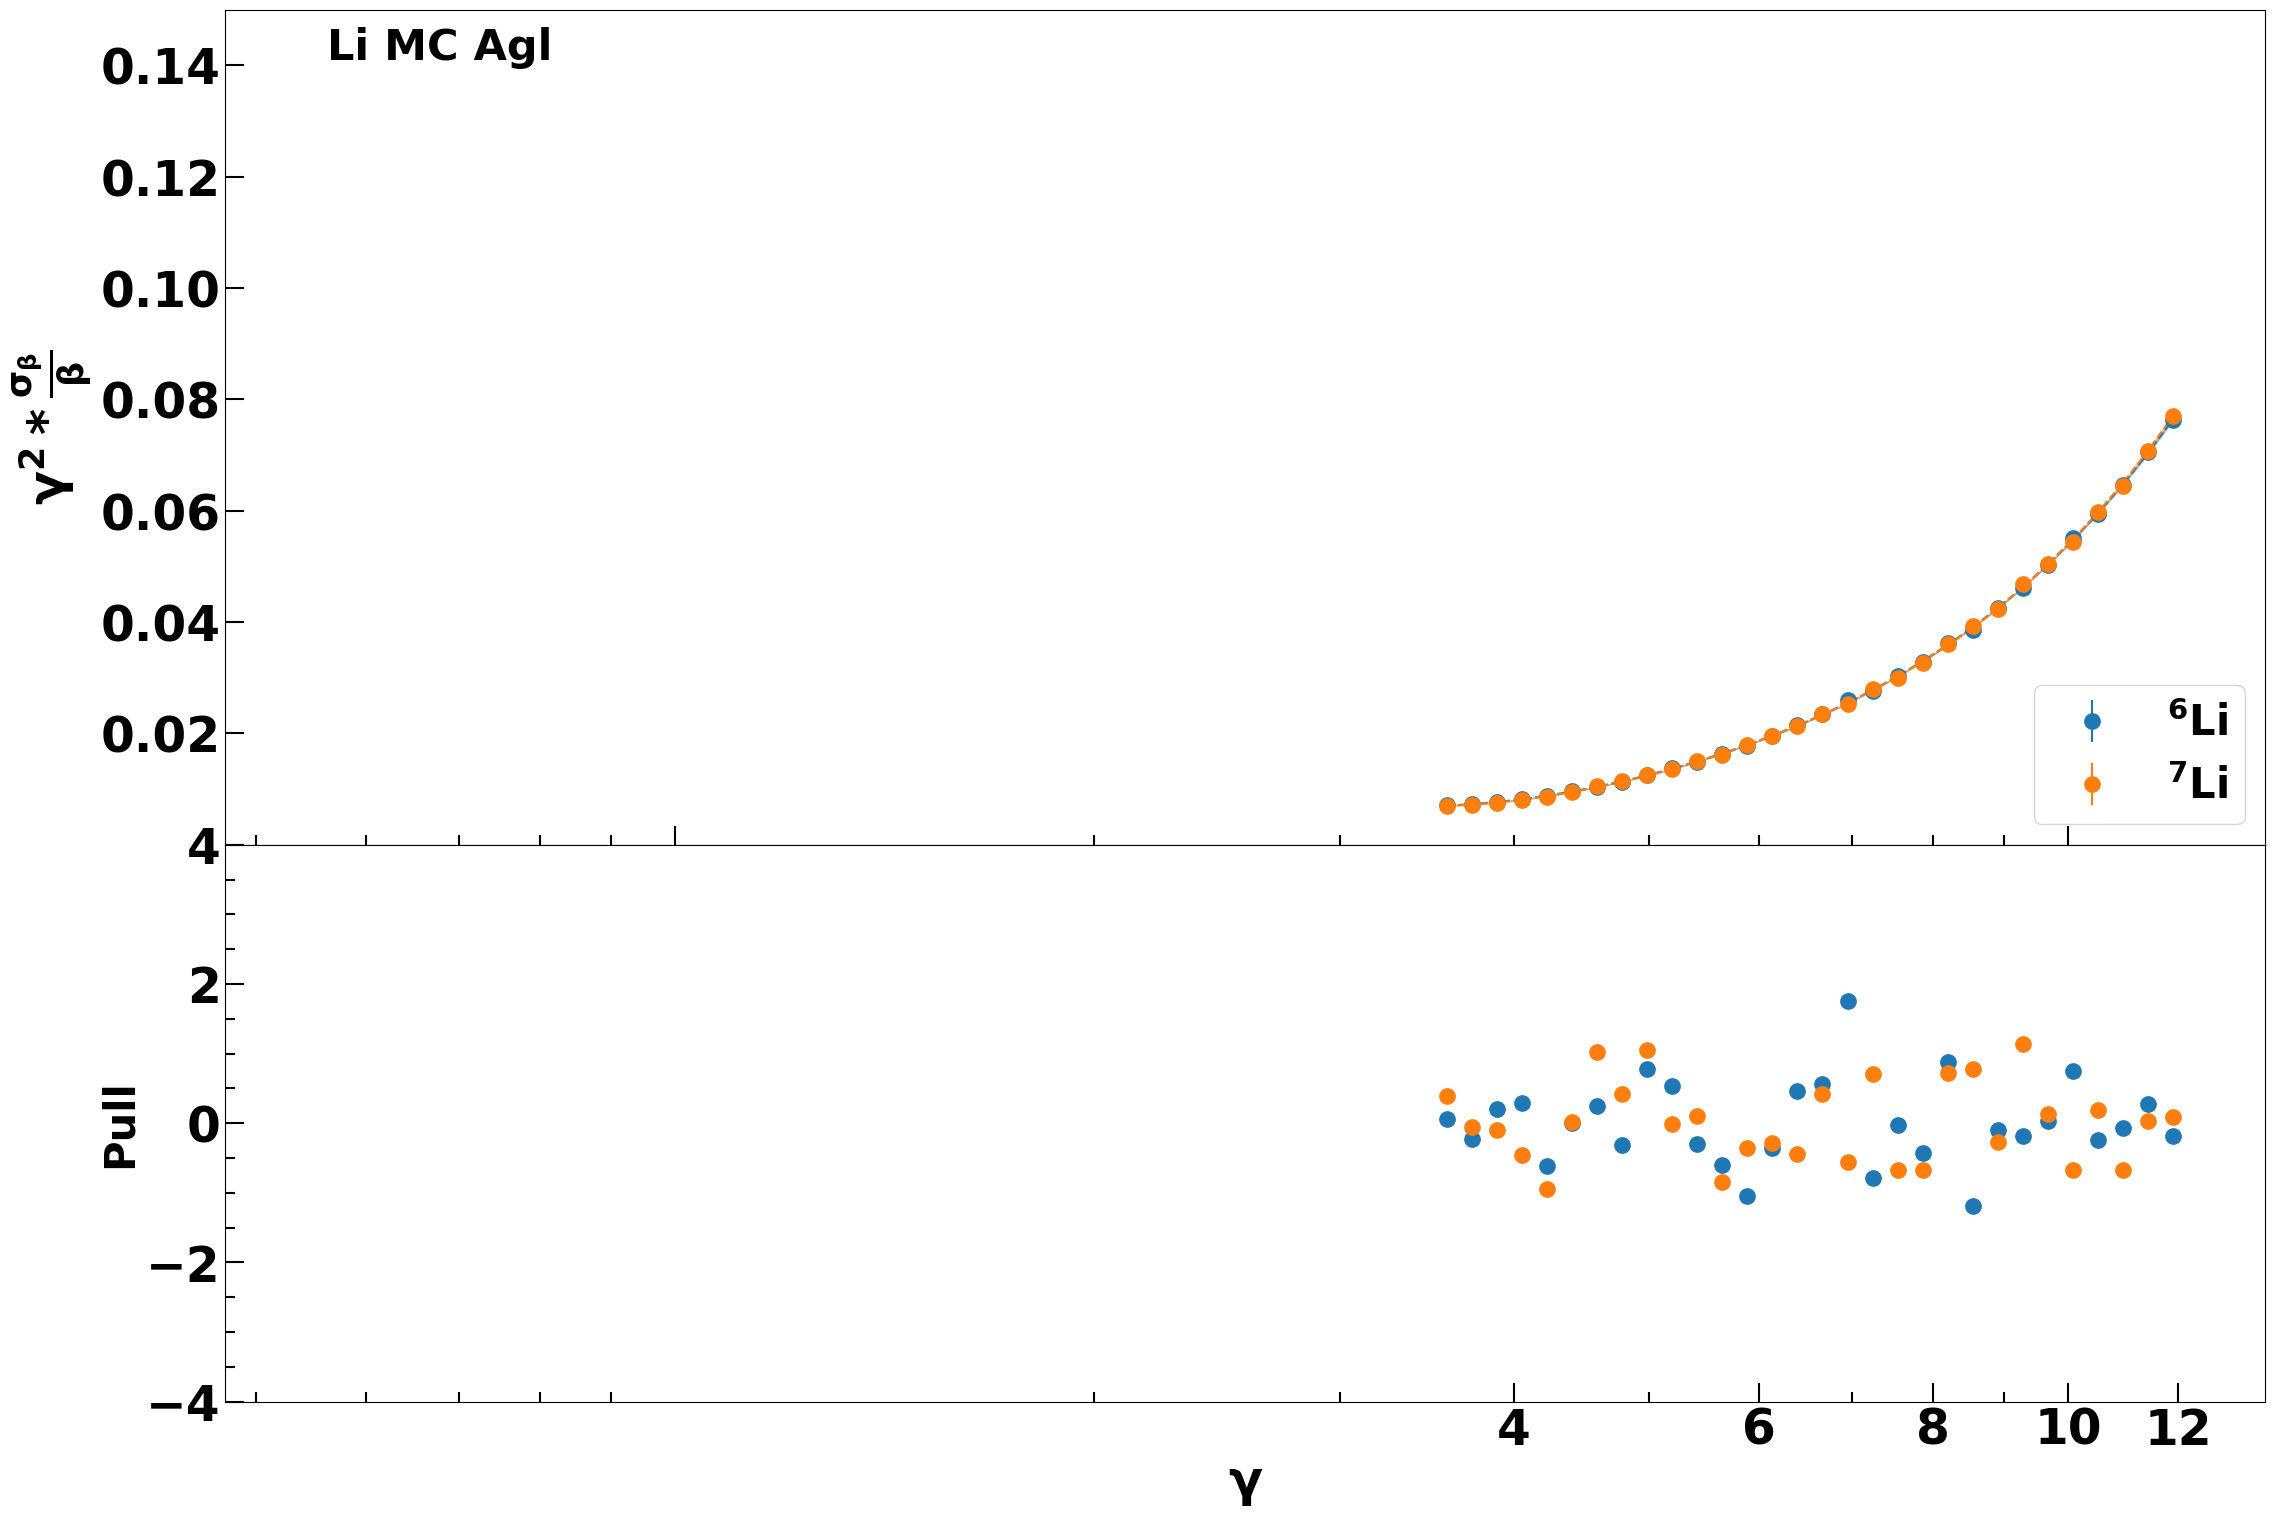

In [38]:
dec = 'Agl'
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
dict_polypar_beta_Agl = dict()
for iso in isotopes: 
    plot_graph(fig, ax1, graph_sigam_timegamma[dec][iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    xval = graph_sigam_timegamma[dec][iso].xvalues 
    popt, pcov = curve_fit(poly, np.log(xval), graph_sigam_timegamma[dec][iso].yvalues, p0 = 1 / (10 ** np.arange(1, 6)), sigma=graph_sigam_timegamma[dec][iso].yerrs, absolute_sigma=True)
    polypars = uncertainties.correlated_values(popt, pcov) 
    dict_polypar_beta[dec][iso] = polypars
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval), polypars, upoly)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval), polypars, upoly) 
    ax1.plot(xval, yfit, "--",  color=ISOTOPES_COLOR[iso])  
    ax1.fill_between(xval, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3) 
    graphpull = get_pull_graph(graph_sigam_timegamma[dec][iso], yfit)
    plot_graph(fig, ax2, graphpull, color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
betagamma_ratio = graph_sigam_timegamma[dec]['Li6']/graph_sigam_timegamma[dec]['Li7']

#plot_graph(fig, ax2, betagamma_ratio, color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be9"]}')  
#plot_graph(fig, ax2, betagamma_ratio10to7, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Be10"]}')  
ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')

ax2.set_xlabel(r'$\mathrm{\gamma}$') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0, 0.15])
ax2.set_ylim([-4, 4])
ax1.text(0.05, 0.98, f"Li MC {dec}", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax2.set_ylabel('Pull', fontsize=FONTSIZE)
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([4, 6, 8, 10, 12]))
print(plotdir)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"betaterm_vs_gamma_Agl1", show=True) 

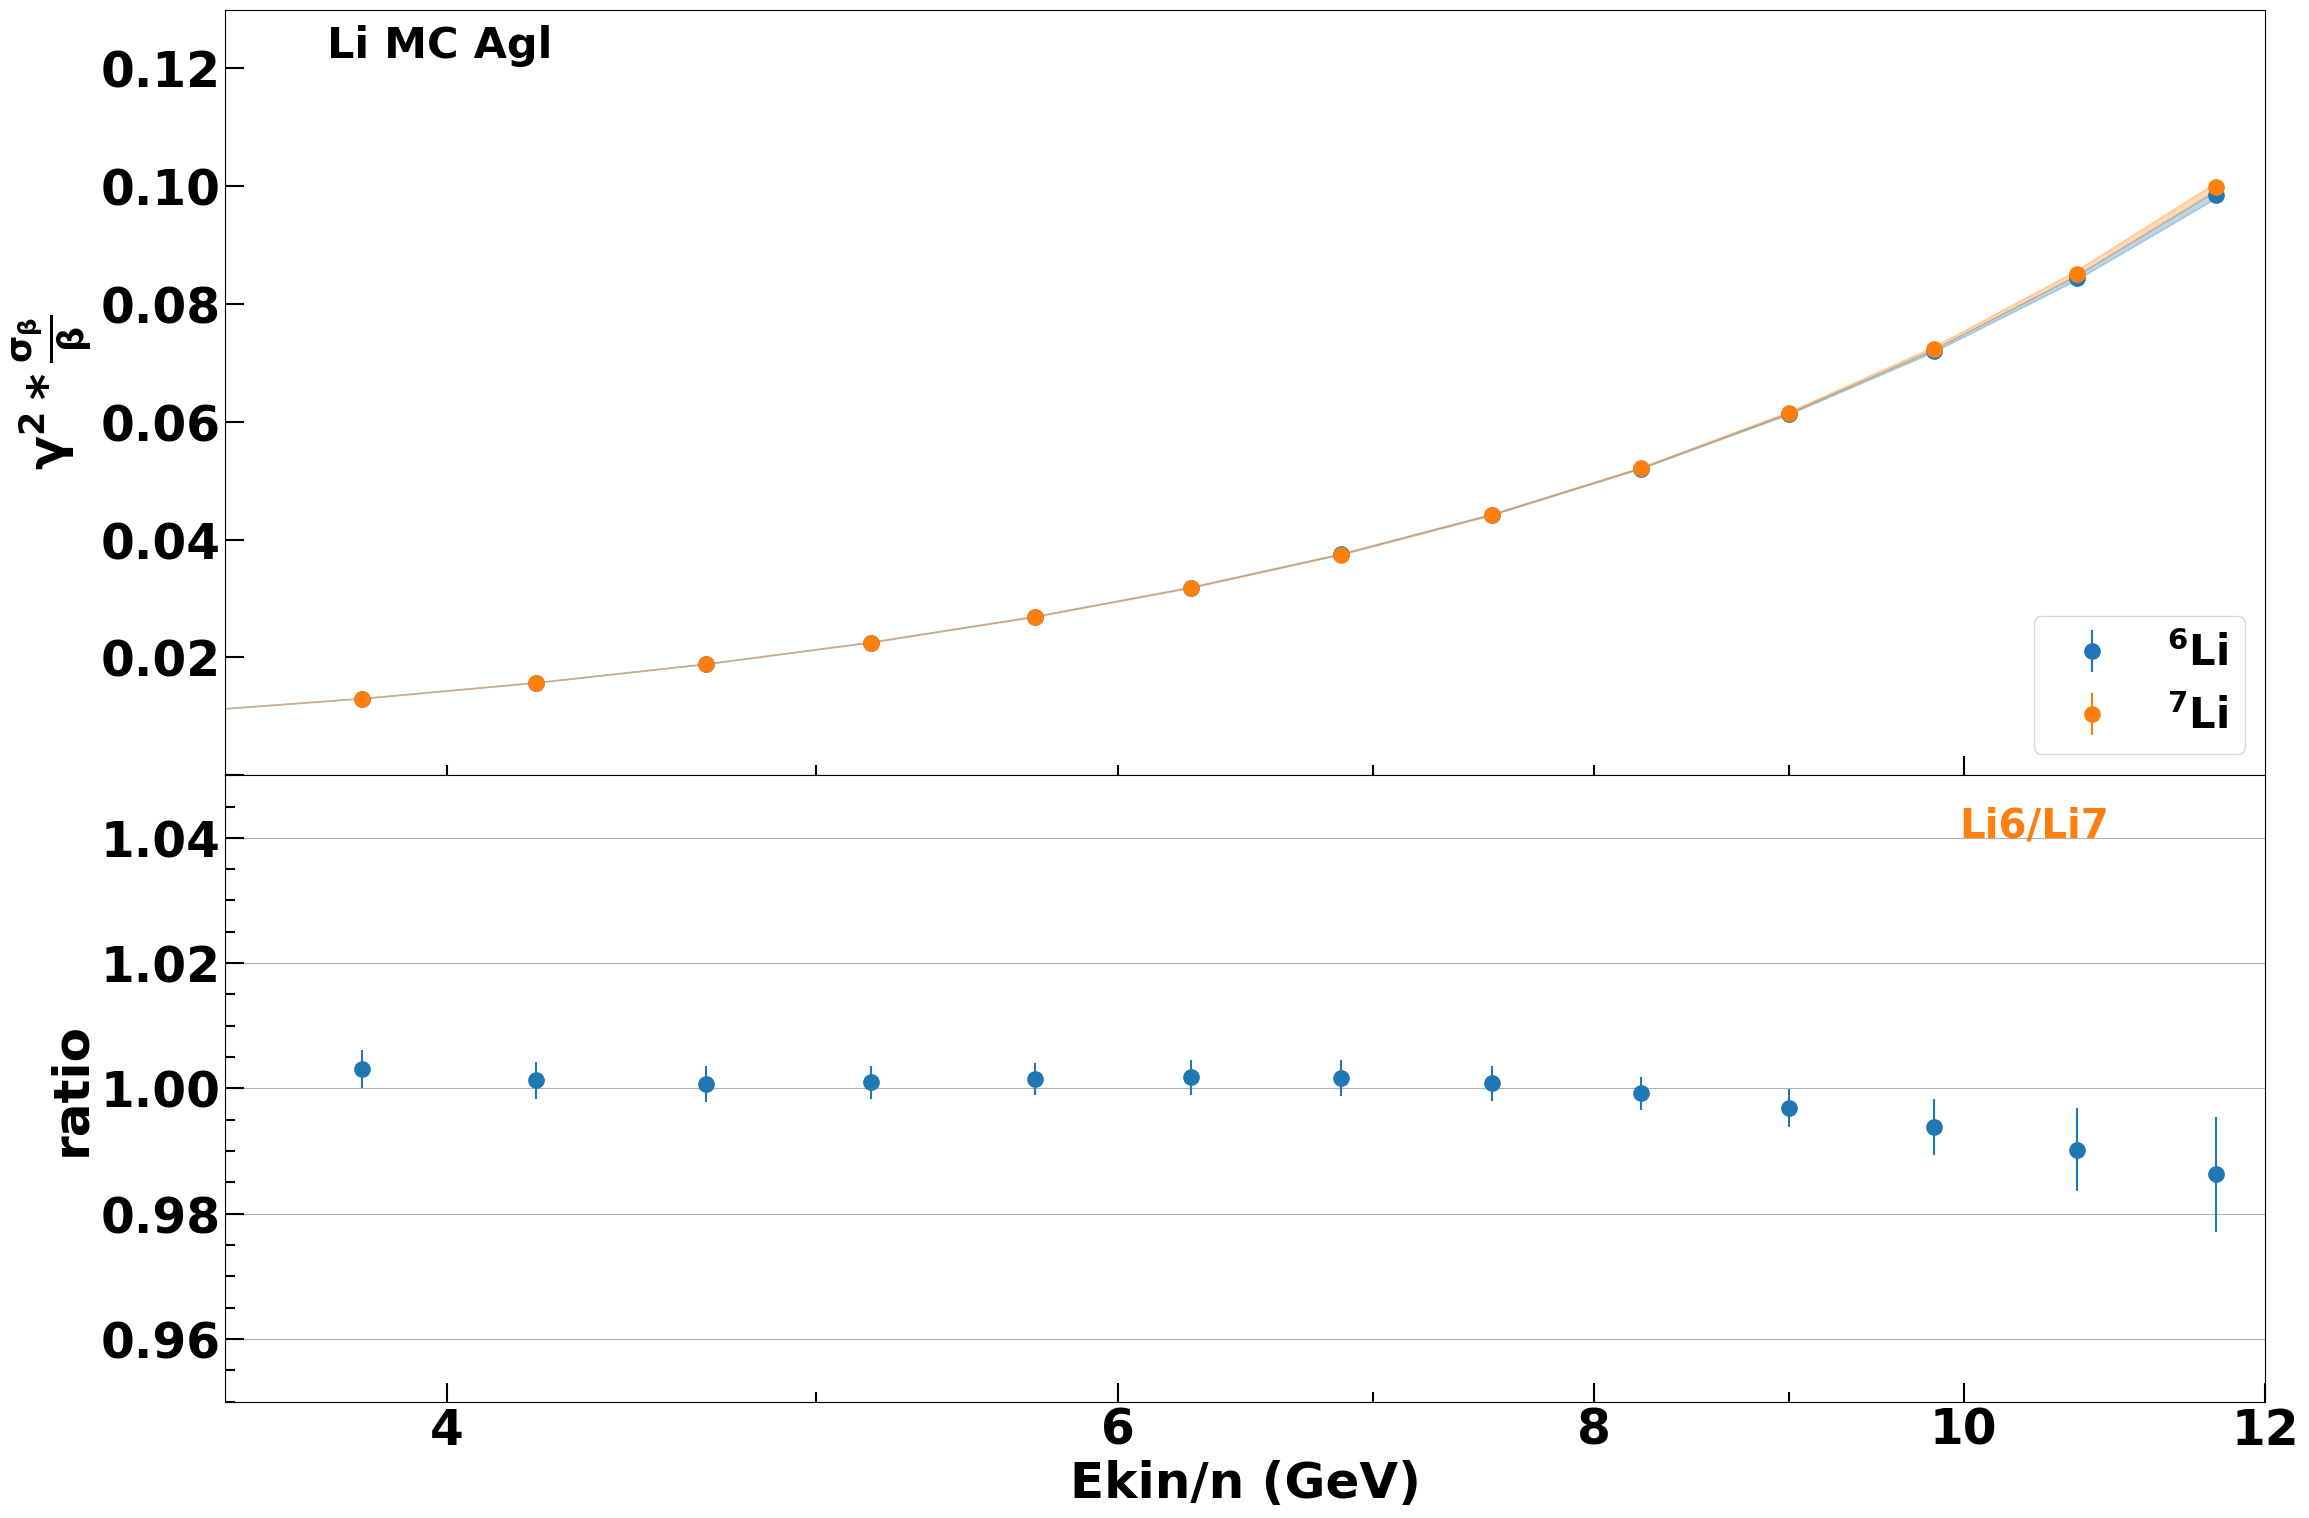

In [39]:
from tools.constants import MASS_NUCLEON_GEV
def calc_gamma_from_ekin(ekin):                                                                                                                                                                          
    gamma = ekin/MASS_NUCLEON_GEV + 1.0                                                                                                                                                                  
    return gamma  

x_ekin = get_bin_center(fbinning_energy())

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
graph_betaterm_vs_ekin_Agl = dict()
for iso in isotopes:
    
    xval_gamma = calc_gamma_from_ekin(x_ekin)
    yfit, yfit_err = get_fitpdf_witherr(np.log(xval_gamma), dict_polypar_beta[dec][iso], upoly)
    #ax1.plot(x_ekin, yfit, "--",  color=ISOTOPES_COLOR[iso], label=f'{ISO_LABELS[iso]}')
    graph_betaterm_vs_ekin_Agl[iso] = MGraph(x_ekin, yfit, yfit_err)
    yfit_lower, yfit_upper = get_fitpdferrorband(np.log(xval_gamma), dict_polypar_beta[dec][iso], upoly)
    ax1.fill_between(x_ekin, yfit_lower, yfit_upper, color=ISOTOPES_COLOR[iso], alpha=0.3)   
    plot_graph(fig, ax1, graph_betaterm_vs_ekin_Agl[iso], color=ISOTOPES_COLOR[iso],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
graph_ratio = graph_betaterm_vs_ekin_Agl['Li6']/graph_betaterm_vs_ekin_Agl['Li7']

plot_graph(fig, ax2, graph_ratio, color=ISOTOPES_COLOR['Li6'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS["Li6"]}')  

ax1.set_ylabel(r'$\mathrm{\gamma^{2}* \frac{\sigma_{\beta}}{\beta}}$')                                            
ax2.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="lower right", fontsize=30) 
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
ax1.set_ylim([0.0, 0.13])
ax2.set_ylim([0.95, 1.05])
ax1.set_xlim([3.5, 12.0])
ax2.set_xlim([3.5, 12.0])

plt.subplots_adjust(hspace=.0)   
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_xticks(np.array([4, 6, 8, 10, 12]))
ax2.text(0.85, 0.95, "Li6/Li7", fontsize=FONTSIZE-1, verticalalignment='top', horizontalalignment='left', transform=ax2.transAxes, color=ISOTOPES_COLOR['Be9'])

ax1.text(0.05, 0.98, f"{nuclei} MC {dec}", fontsize=FONTSIZE+1, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax2.grid(axis='y')
savefig_tofile(fig, plotdir, f"betaterm_vs_ekin_Agl", show=True) 


Tof: mass resolution

In [24]:
def calc_massreso(rigreso, betaterm, limrange):
    sub_rigreso = slice_graph_by_value(rigreso, [limrange[0], limrange[-1]])
    sub_betaterm = slice_graph_by_value(betaterm, [limrange[0], limrange[-1]])
    print(sub_rigreso)
    print(sub_betaterm)
    massreso = np.sqrt(sub_rigreso.yvalues**2 + sub_betaterm.yvalues**2)
    massreso_err = sub_rigreso.yvalues/massreso * sub_rigreso.yerrs + sub_betaterm.yvalues/massreso * sub_betaterm.yerrs
    graph_massreso = MGraph(sub_rigreso.xvalues, massreso, massreso_err)
    return graph_massreso

def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err


xvalues			yvalues			yerrs
0.4631			0.11912575314363644			0.00040000048354192565
0.5589999999999999			0.11446401874689852			0.000179213605265697
0.66835			0.1106832206756918			0.00018161253862367048
0.79125			0.10768393858797669			0.00017167927936107165
0.9302999999999999			0.10531092370395198			0.000145104635059524
1.08555			0.10348054620685457			0.00012766255513079847
1.2570999999999999			0.10210161096881924			0.00012516746101650023
1.44745			0.10107865537011206			0.00012738259581895515
1.6566			0.10034955059937008			0.00012612173047609778
1.8872			0.09985319806929206			0.00012028951521561644


xvalues			yvalues			yerrs
0.4631			0.024207438915613364			0.00032444338505699605
0.5589999999999999			0.025963444483540803			0.00017345440173599587
0.66835			0.029751791962112608			7.849474306729759e-05
0.79125			0.03550919773339975			5.665244544926773e-05
0.9302999999999999			0.04325447657014554			6.96612535847925e-05
1.08555			0.05289954637571412			7.62201999721063e-05
1.2570999999999999			0

[Text(0.01, 0, ''),
 Text(0.1, 0, ''),
 Text(1.0, 0, ''),
 Text(10.0, 0, ''),
 Text(100.0, 0, '')]

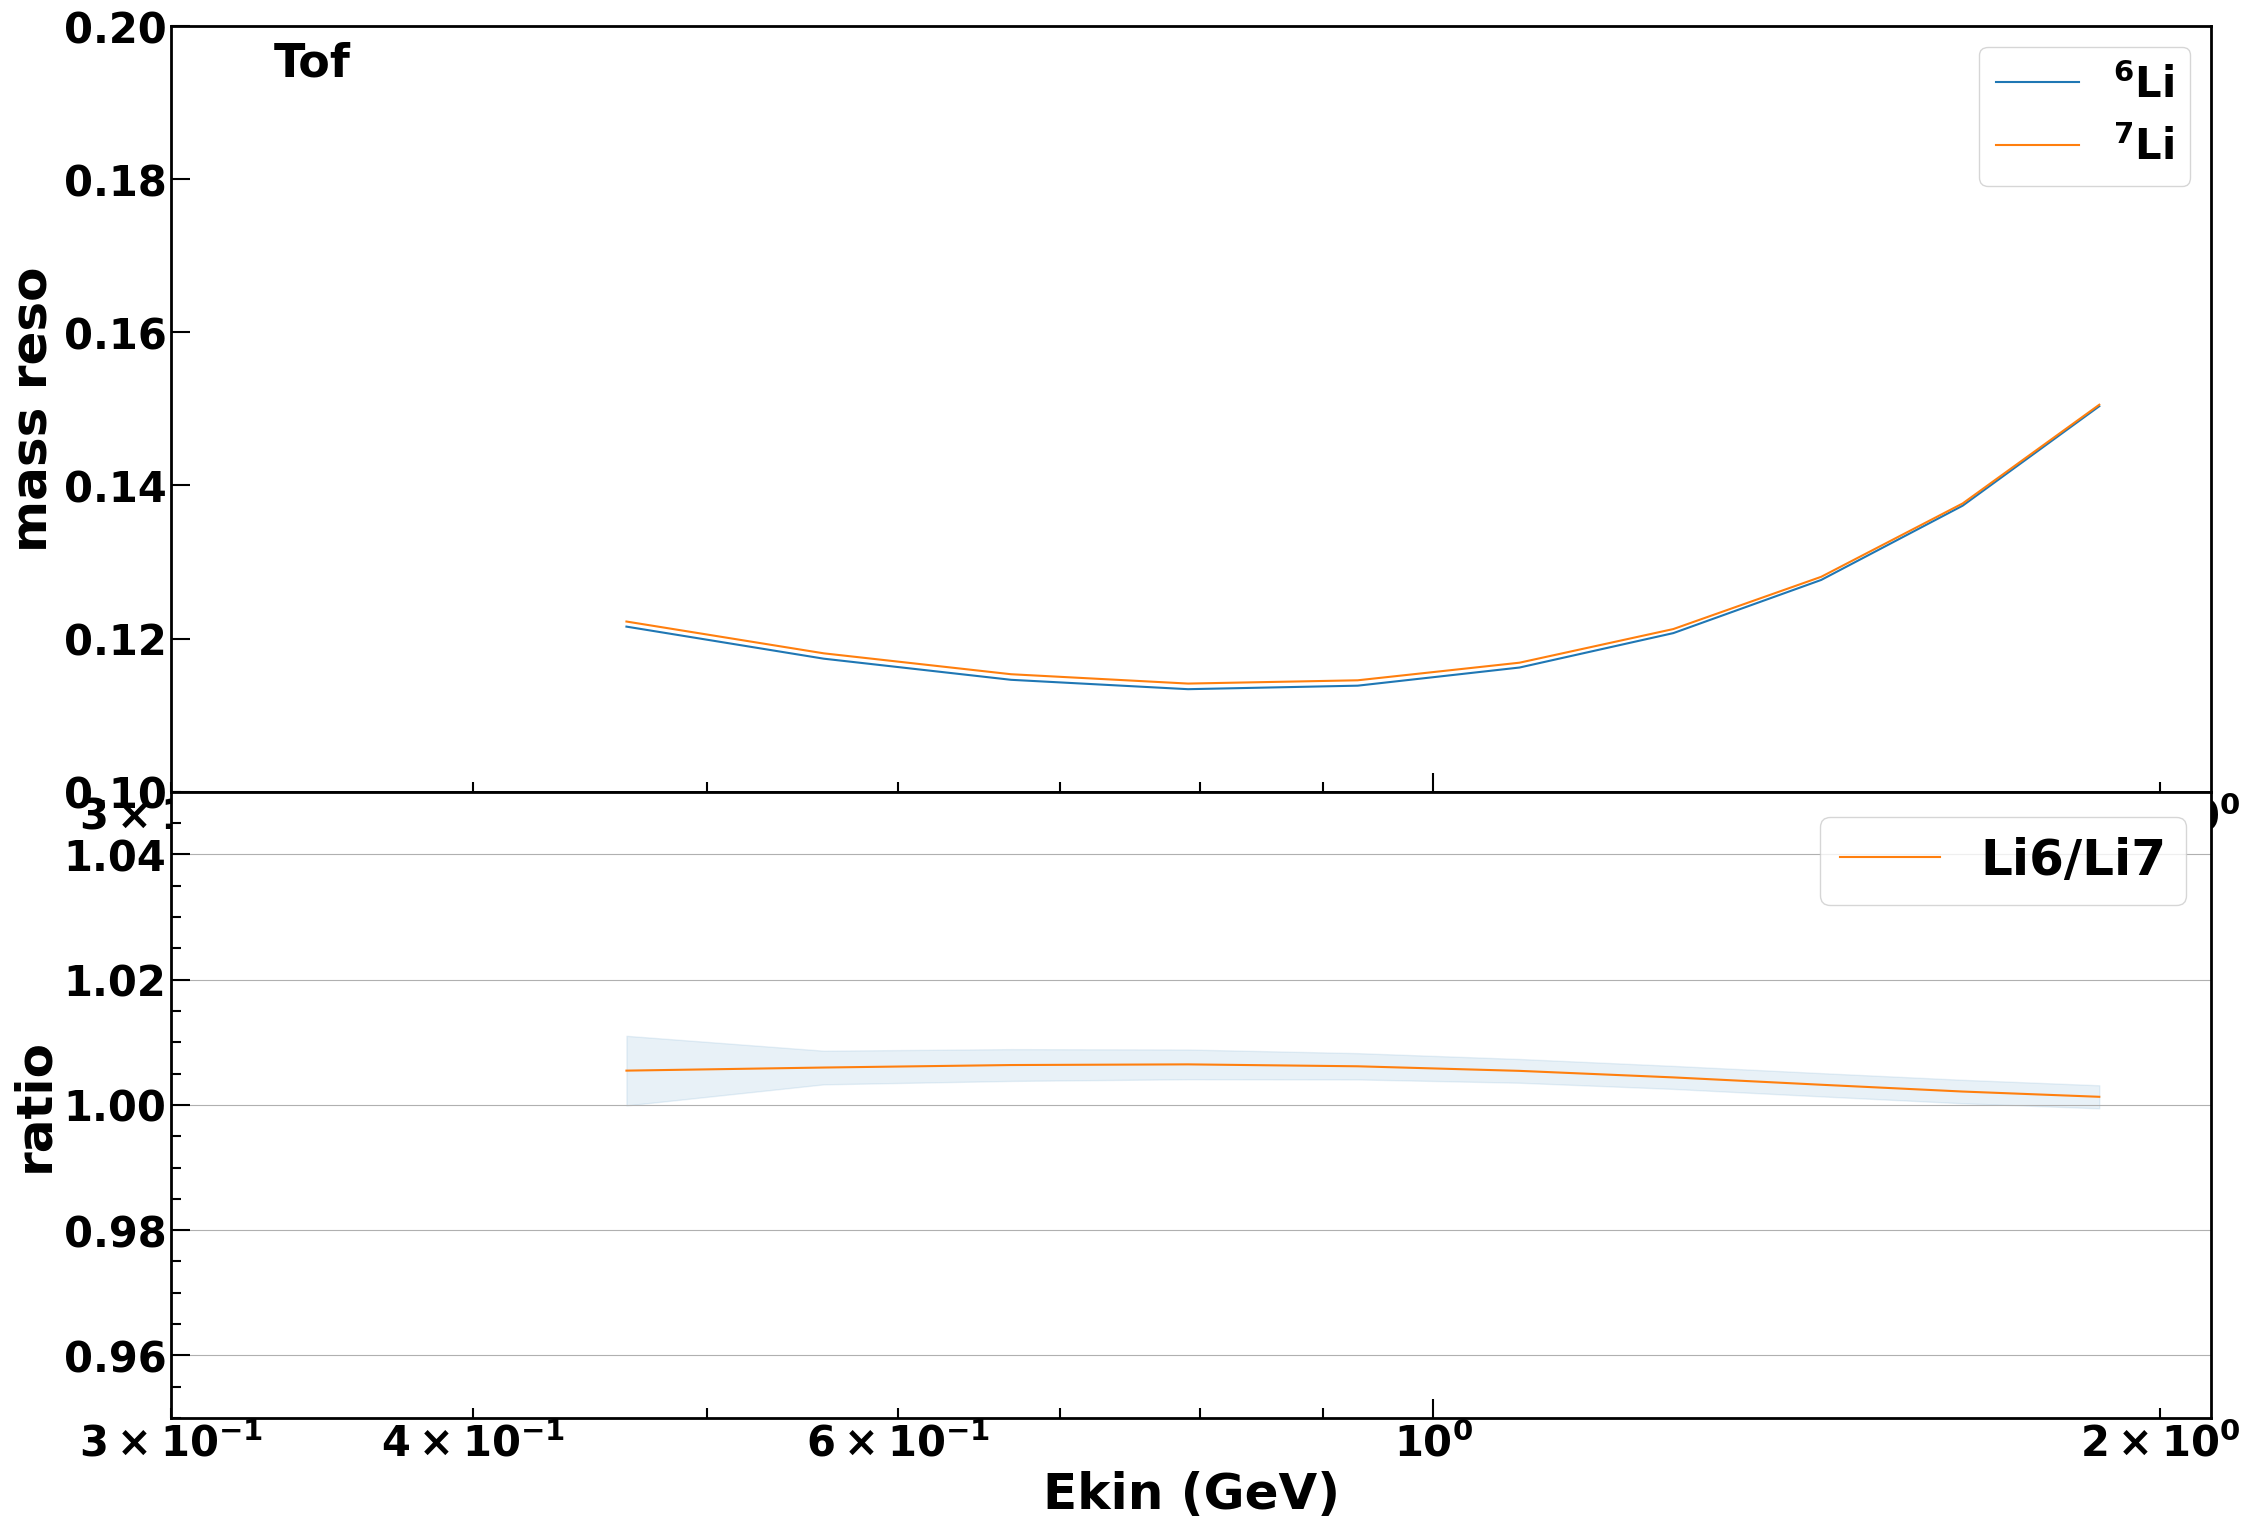

In [25]:
inverse_mass_reso_Tof = dict()
inverse_mass_reso_Tof_err = dict()
graph_inversemass_reso_Tof = dict()

sub_graphfitted_rigreso_sigma = dict()
for iso in isotopes:
    #sub_graphfitted_rigreso_sigma[iso] = slice_graph_by_value(graphfitted_rigreso_sigma[iso], [graph_betaterm_vs_ekin_Tof[iso].xvalues[0], graph_betaterm_vs_ekin_Tof[iso].xvalues[1])
    graph_inversemass_reso_Tof[iso] =  calc_massreso(graphfitted_rigreso_sigma[iso], graph_betaterm_vs_ekin_Tof[iso], [0.46, 2.0])
    
     #= MGraph(graph_betaterm_vs_ekin_Tof[iso].xvalues, inverse_mass_reso_Tof[iso], inverse_mass_reso_Tof_err[iso])
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Tof[iso].xvalues, graph_inversemass_reso_Tof[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    plot_graph(fig, ax1, graph_inversemass_reso_Tof[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
mass_reso_ratio_Tof = graph_inversemass_reso_Tof[isotopes[1]]/graph_inversemass_reso_Tof[isotopes[0]]
#ax2.plot(mass_reso_ratio9_Tof.xvalues, mass_reso_ratio9_Tof.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_Tof.xvalues, mass_reso_ratio10_Tof.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])  
plot_graph(fig, ax2, mass_reso_ratio_Tof, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label='Li6/Li7')  

yratio_low_Tof = mass_reso_ratio_Tof.yvalues - mass_reso_ratio_Tof.yerrs
yratio_up_Tof = mass_reso_ratio_Tof.yvalues + mass_reso_ratio_Tof.yerrs
ax2.fill_between(mass_reso_ratio_Tof.xvalues, yratio_low_Tof, yratio_up_Tof, color=ISOTOPES_COLOR['Li6'], alpha=0.1)  



ax1.set_xlim([0.3, 2.1])
ax2.set_xlim([0.3, 2.1])
ax1.set_ylim([0.1, 0.2])
ax2.set_ylim([0.95, 1.05])
ax2.grid(axis='y')

ax1.set_ylabel('mass reso')                                            
ax2.set_xlabel('Ekin (GeV)') 
ax2.legend()
ax1.legend(loc="upper right", fontsize=30) 

ax1.text(0.05, 0.98, "Tof", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
plt.subplots_adjust(hspace=.0)  
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotfile, f"mass_resolution_tof_line1", show=True)
    


xvalues			yvalues			yerrs
0.79125			0.10768393858797669			0.00017167927936107165
0.9302999999999999			0.10531092370395198			0.000145104635059524
1.08555			0.10348054620685457			0.00012766255513079847
1.2570999999999999			0.10210161096881924			0.00012516746101650023
1.44745			0.10107865537011206			0.00012738259581895515
1.6566			0.10034955059937008			0.00012612173047609778
1.8872			0.09985319806929206			0.00012028951521561644
2.1419			0.09954518872418787			0.00011297208607814465
2.42075			0.09939296216933224			0.00010832555674451237
2.7237			0.09936791606551611			0.00010840372334167223
3.0534			0.09944759096551747			0.0001118912567574332
3.4126000000000003			0.09961700917350053			0.0001157595664796286
3.8012500000000005			0.09986484462500747			0.00011750383169957964
4.2221			0.10018527953799844			0.00011638525672532575
4.67795			0.10057658893351362			0.00011360474221514478
5.16875			0.10103756146720655			0.00011195078380626732
5.70575			0.10158076973505188			0.00011445320301533391
6.27

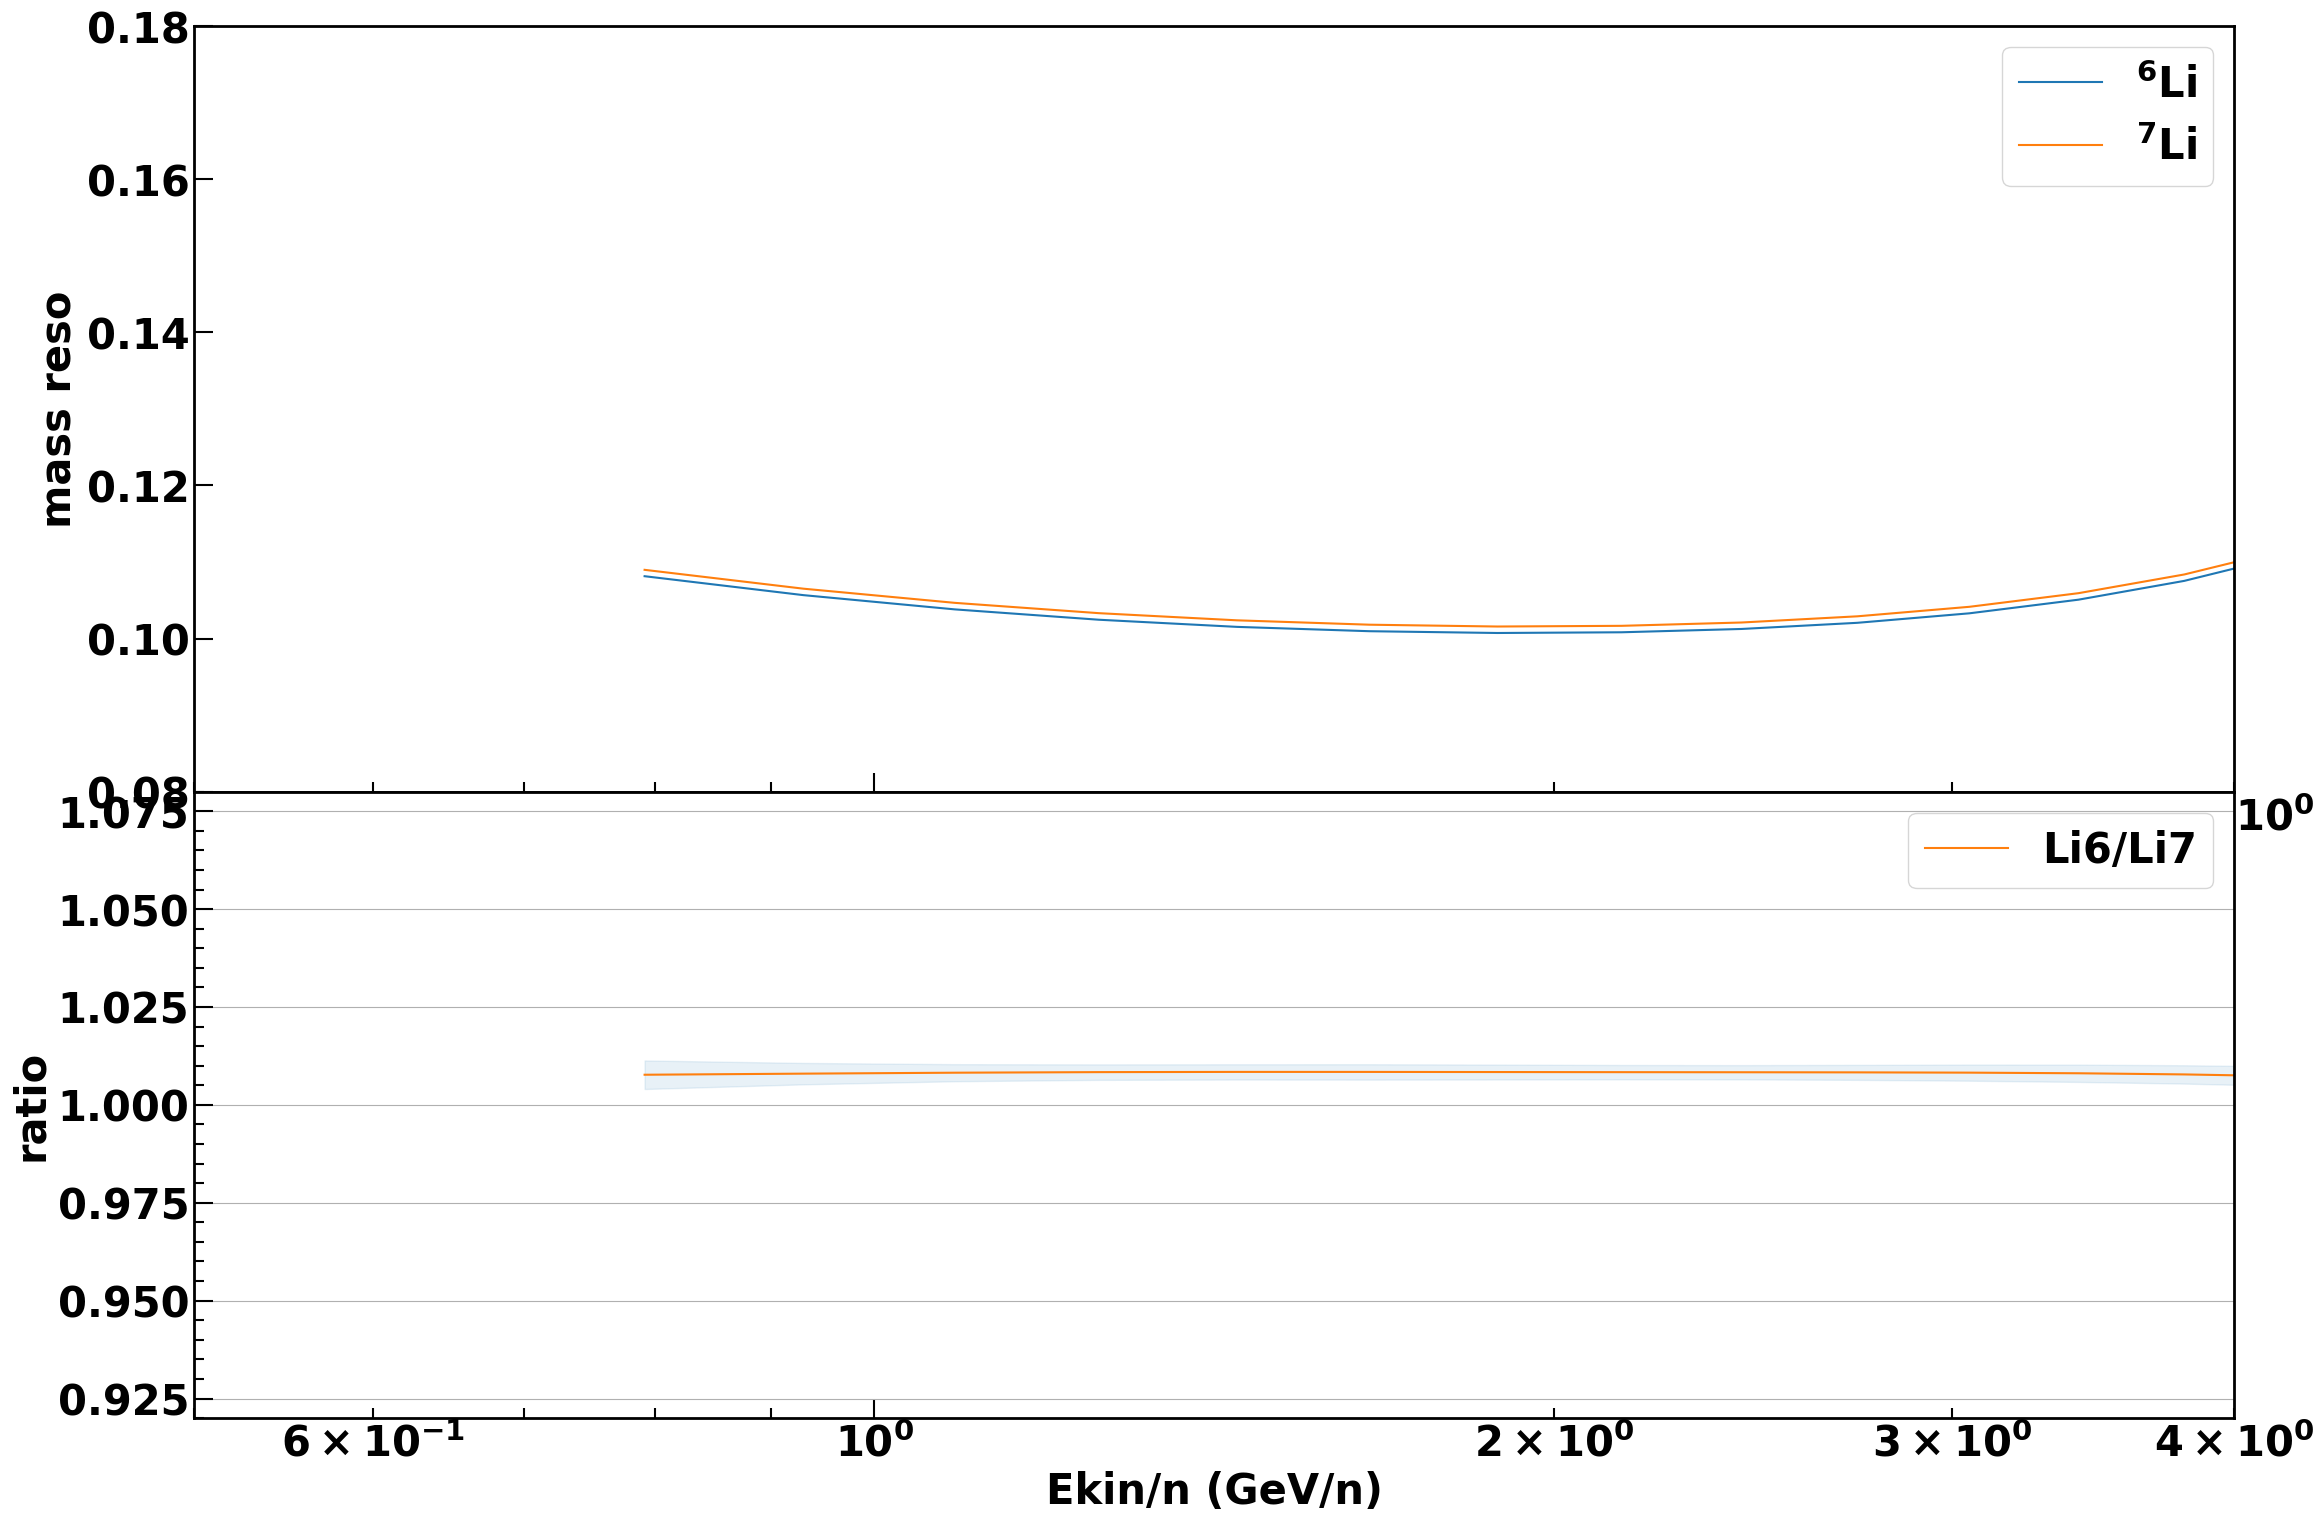

In [26]:
inverse_mass_reso_NaF = dict()
inverse_mass_reso_NaF_err = dict()
graph_inversemass_reso_NaF = dict()

sub_graphfitted_rigreso_sigma = dict()
for iso in isotopes:
    #sub_graphfitted_rigreso_sigma[iso] = slice_graph_by_value(graphfitted_rigreso_sigma[iso], [graph_betaterm_vs_ekin_NaF[iso].xvalues[0], graph_betaterm_vs_ekin_NaF[iso].xvalues[1])
    graph_inversemass_reso_NaF[iso] =  calc_massreso(graphfitted_rigreso_sigma[iso], graph_betaterm_vs_ekin_NaF[iso], [0.8, 6.0])
    
     #= MGraph(graph_betaterm_vs_ekin_NaF[iso].xvalues, inverse_mass_reso_NaF[iso], inverse_mass_reso_NaF_err[iso])
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_NaF[iso].xvalues, graph_inversemass_reso_NaF[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    plot_graph(fig, ax1, graph_inversemass_reso_NaF[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
mass_reso_ratio_NaF = graph_inversemass_reso_NaF[isotopes[1]]/graph_inversemass_reso_NaF[isotopes[0]]
#ax2.plot(mass_reso_ratio9_NaF.xvalues, mass_reso_ratio9_NaF.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_NaF.xvalues, mass_reso_ratio10_NaF.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])  
plot_graph(fig, ax2, mass_reso_ratio_NaF, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label='Li6/Li7')  

yratio_low_NaF = mass_reso_ratio_NaF.yvalues - mass_reso_ratio_NaF.yerrs
yratio_up_NaF = mass_reso_ratio_NaF.yvalues + mass_reso_ratio_NaF.yerrs
ax2.fill_between(mass_reso_ratio_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=ISOTOPES_COLOR['Li6'], alpha=0.1)  


ax1.set_xlim([0.5, 4.0])
ax2.set_xlim([0.5, 4.0])
ax1.set_ylim([0.08, 0.18])
ax2.set_ylim([0.92, 1.08])
ax2.grid(axis='y')
ax1.set_ylabel('mass reso')                                            
ax2.set_xlabel('Ekin/n (GeV/n)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0) 

set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
ax2.legend()

#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_NaFile(fig, plotfile, f"mass_resolution_NaF_line1", show=True)
    


xvalues			yvalues			yerrs
3.0534			0.09944759096551747			0.0001118912567574332
3.4126000000000003			0.09961700917350053			0.0001157595664796286
3.8012500000000005			0.09986484462500747			0.00011750383169957964
4.2221			0.10018527953799844			0.00011638525672532575
4.67795			0.10057658893351362			0.00011360474221514478
5.16875			0.10103756146720655			0.00011195078380626732
5.70575			0.10158076973505188			0.00011445320301533391
6.27195			0.10219202944597458			0.00012186926166767023
6.8673			0.10287387206548597			0.00013168630963457576
7.5200499999999995			0.10366497125382876			0.00014019157365184362
8.2303			0.104575334480636			0.00014335428902145995
8.99805			0.10561542397623705			0.00014097742084417532
9.82325			0.1067959027630844			0.00014507900008387697
10.7059			0.10812747285686639			0.00018654972225907657
11.64595			0.1096204651350722			0.00028993961999669625


xvalues			yvalues			yerrs
3.0534			0.009021221842636346			2.3466525310360283e-05
3.4126000000000003			0.010776745849366665

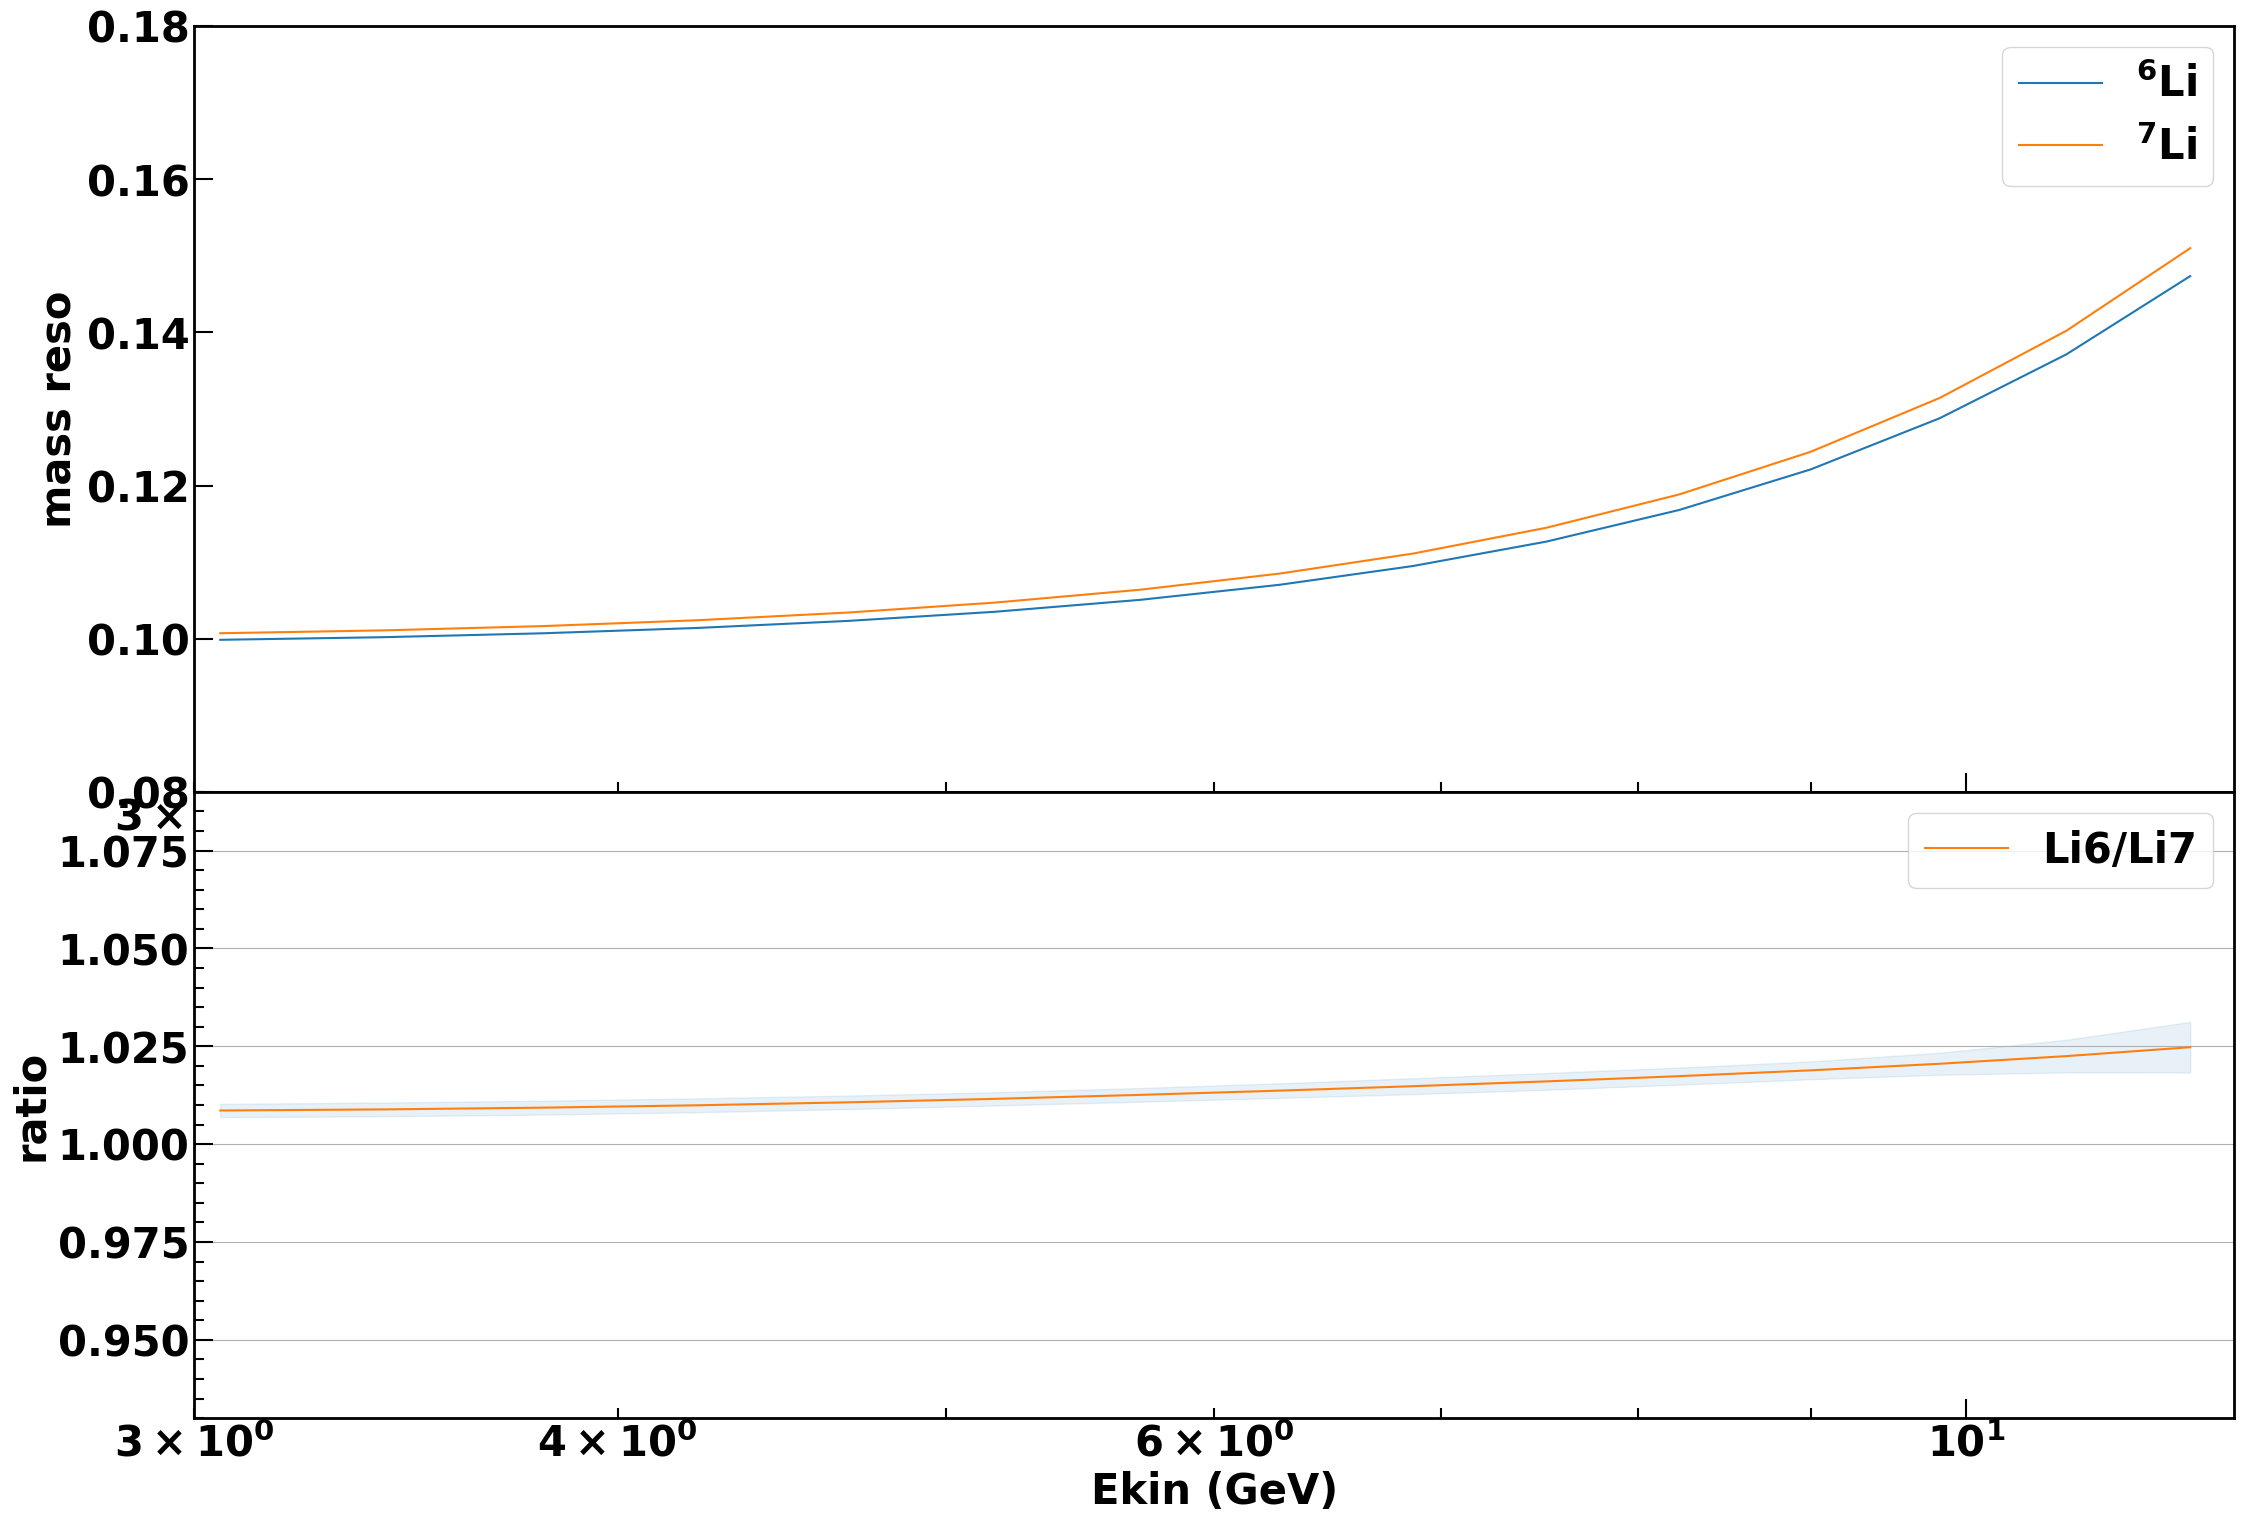

In [45]:
inverse_mass_reso_Agl = dict()
inverse_mass_reso_Agl_err = dict()
graph_inversemass_reso_Agl = dict()

sub_graphfitted_rigreso_sigma = dict()
for iso in isotopes:
    #sub_graphfitted_rigreso_sigma[iso] = slice_graph_by_value(graphfitted_rigreso_sigma[iso], [graph_betaterm_vs_ekin_Agl[iso].xvalues[0], graph_betaterm_vs_ekin_Agl[iso].xvalues[1])
    graph_inversemass_reso_Agl[iso] =  calc_massreso(graphfitted_rigreso_sigma[iso], graph_betaterm_vs_ekin_Agl[iso], [3.0, 12.0])
    
     
    
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.55, 0.45]}, figsize=(24, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    plot_graph(fig, ax1, graph_inversemass_reso_Agl[iso], color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label=f'{ISO_LABELS[iso]}')  
    
mass_reso_ratio_Agl = graph_inversemass_reso_Agl[isotopes[1]]/graph_inversemass_reso_Agl[isotopes[0]]
#ax2.plot(mass_reso_ratio9_Agl.xvalues, mass_reso_ratio9_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be9'])  
#ax2.plot(mass_reso_ratio10_Agl.xvalues, mass_reso_ratio10_Agl.yvalues, "--",  color=ISOTOPES_COLOR['Be10'])  
plot_graph(fig, ax2, mass_reso_ratio_Agl, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=True, ylog=False, scale=None, markersize=22, label='Li6/Li7')  

yratio_low_Agl = mass_reso_ratio_Agl.yvalues - mass_reso_ratio_Agl.yerrs
yratio_up_Agl = mass_reso_ratio_Agl.yvalues + mass_reso_ratio_Agl.yerrs
ax2.fill_between(mass_reso_ratio_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=ISOTOPES_COLOR['Li6'], alpha=0.1)  


ax1.set_xlim([3, 12.0])
ax2.set_xlim([3, 12.0])
ax1.set_ylim([0.08, 0.18])
ax2.set_ylim([0.93, 1.09])
ax2.grid(axis='y')
ax1.set_ylabel('mass reso')                                            
ax2.set_xlabel('Ekin (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0) 
set_plot_defaultstyle(ax1)
set_plot_defaultstyle(ax2)
ax2.set_ylabel('ratio')
ax1.set_xticklabels([])
ax2.legend()

#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_Aglile(fig, plotfile, f"mass_resolution_Agl_line1", show=True)
    

/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL
dict_items([('Tof', {'Li7': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7f4a007556f0>}), ('NaF', {'Li7': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7f4a007574c0>}), ('Agl', {'Li7': <scipy.interpolate._fitpack2.LSQUnivariateSpline object at 0x7f4a00757730>})])


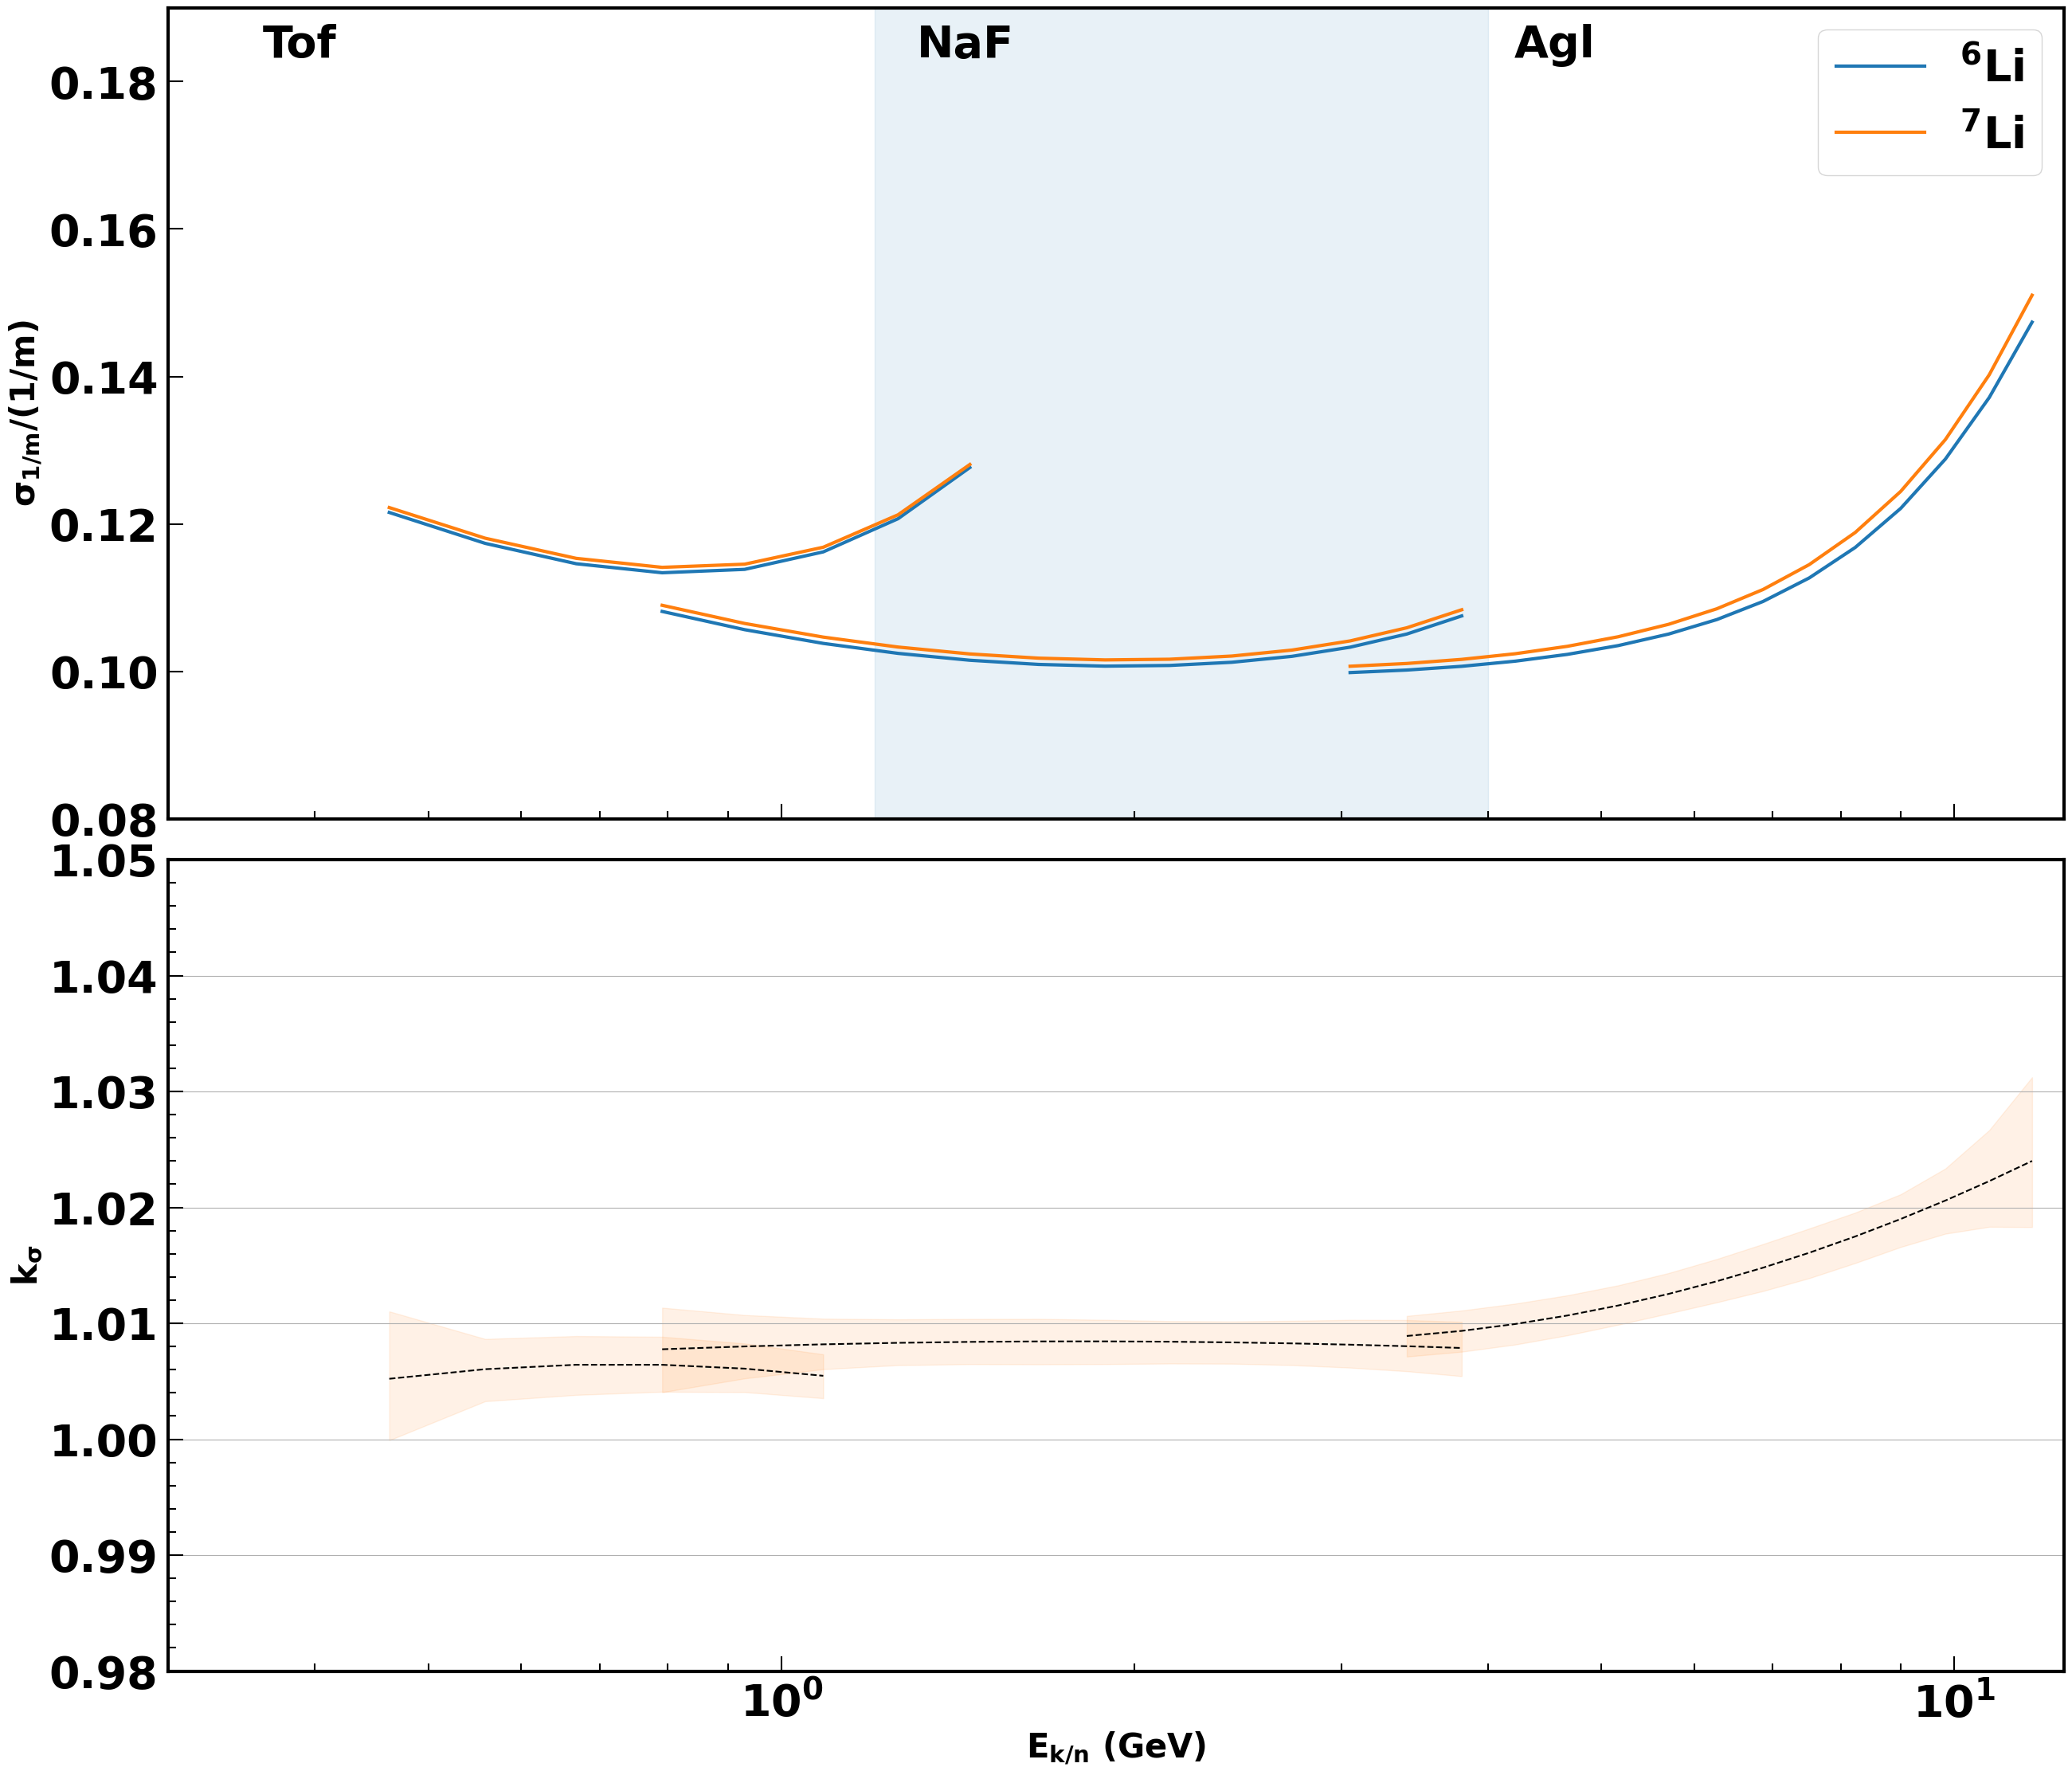

In [46]:
from tools.graphs import slice_graph_by_value
from tools.constants import ANALYSIS_RANGE_EKIN
def GetFitPolyPars(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
    return popt

energy_range = {"Tof": [0.3, 1.1], "NaF": np.array([0.8, 3.8]), "Agl": np.array([3.5, 12])}

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(28, 24))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 


for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    sub_graph_massreso_Agl = slice_graph_by_value(graph_inversemass_reso_Agl[iso], np.array([3.0, 12]))
    sub_graph_massreso_NaF = slice_graph_by_value(graph_inversemass_reso_NaF[iso], np.array([0.8, 3.8]))
    sub_graph_massreso_Tof = slice_graph_by_value(graph_inversemass_reso_Tof[iso], np.array([0.3, 1.5]))
    plot_graph(fig, ax1, sub_graph_massreso_Agl, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=25, label=f'{ISO_LABELS[iso]}', linewidth=3)
    plot_graph(fig, ax1, sub_graph_massreso_NaF, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=20, linewidth=3)  
    plot_graph(fig, ax1, sub_graph_massreso_Tof, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=15, linewidth=3)  

sub_mass_reso_ratio_Agl = slice_graph_by_value(mass_reso_ratio_Agl, energy_range['Agl'])
sub_mass_reso_ratio_NaF = slice_graph_by_value(mass_reso_ratio_NaF, energy_range['NaF'])
sub_mass_reso_ratio_Tof = slice_graph_by_value(mass_reso_ratio_Tof, energy_range['Tof'])

#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_Agl, energy_range['Agl']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=24, label='Be9/Be7')  
#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_NaF, energy_range['NaF']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_Tof, energy_range['Tof']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=15)  

ax1.text(0.05, 0.98, "Tof", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.395, 0.98, "NaF", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.71, 0.98, "Agl", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")


yratio_low_Agl = sub_mass_reso_ratio_Agl.yvalues - sub_mass_reso_ratio_Agl.yerrs
yratio_up_Agl = sub_mass_reso_ratio_Agl.yvalues + sub_mass_reso_ratio_Agl.yerrs
ax2.fill_between(sub_mass_reso_ratio_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_NaF = sub_mass_reso_ratio_NaF.yvalues - sub_mass_reso_ratio_NaF.yerrs
yratio_up_NaF = sub_mass_reso_ratio_NaF.yvalues + sub_mass_reso_ratio_NaF.yerrs
ax2.fill_between(sub_mass_reso_ratio_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Tof = sub_mass_reso_ratio_Tof.yvalues - sub_mass_reso_ratio_Tof.yerrs
yratio_up_Tof = sub_mass_reso_ratio_Tof.yvalues + sub_mass_reso_ratio_Tof.yerrs

ax2.fill_between(sub_mass_reso_ratio_Tof.xvalues, yratio_low_Tof, yratio_up_Tof, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  
ax1.fill_betweenx(np.linspace(0.06, 0.2, 100), ANALYSIS_RANGE_EKIN['NaF'][0], ANALYSIS_RANGE_EKIN['NaF'][1], alpha=0.1, color='tab:blue') 

ax1.set_xlim([0.3, 12.4])
ax2.set_xlim([0.3, 12.4])
ax1.set_ylim([0.08, 0.19])
ax2.set_ylim([0.98, 1.05])
ax2.set_xscale('log')
ax2.grid(axis='y')
ax1.set_ylabel(r'$\mathrm{\sigma_{1/m}/(1/m)}$')  
ax2.set_ylabel(r'$\mathrm{k_{\sigma}}$')  
ax2.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV)}$') 
ax1.legend(loc='upper right', fontsize=40) 
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.05) 

set_plot_style(ax1)
set_plot_style(ax2)
spline_ksig_factor = {dec: {} for dec in detectors}
graph_ksig_low = {}
graph_ksig_up = {}

p0_dec = [1.0, 0.1, 0.1]
dict_polypars_sigfactor = {dec: {} for dec in detectors}
sub_mass_reso_ratio = {'Tof': sub_mass_reso_ratio_Tof, 'NaF': sub_mass_reso_ratio_NaF, 'Agl':  sub_mass_reso_ratio_Agl}
iso = 'Li7'
for dec in detectors:
    popt = GetFitPolyPars(sub_mass_reso_ratio[dec], p0_dec, withsigma=True)
    dict_polypars_sigfactor[dec][iso] = popt
    ax2.plot(sub_mass_reso_ratio[dec].xvalues, poly(np.log(sub_mass_reso_ratio[dec].xvalues), *popt), '--', color='black')
    graph_ksig_low[dec], graph_ksig_up[dec] = getgraph_errband(sub_mass_reso_ratio[dec], p0_dec, withsig=False)
    spline_ksig_factor[dec][iso] = get_uncertainty_spline(graph_ksig_low[dec], graph_ksig_up[dec])
    
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
print(plotdir)
savefig_tofile(fig, plotdir, f"mass_resolution_Li", show=True)

with open('/home/manbing/Documents/Data/data_LiP8/spline_ksig_uncertainty.pickle', 'wb') as file:
    pickle.dump(spline_ksig_factor, file)
with open('/home/manbing/Documents/Data/data_LiP8/spline_ksig_uncertainty.pickle', 'rb') as file:
    loadfile1 = pickle.load(file)
    print(loadfile1.items())
    
with open('/home/manbing/Documents/Data/data_LiP8/polypars_sigfactor.pickle', 'wb') as file:
    pickle.dump(dict_polypars_sigfactor, file)




   

 


/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


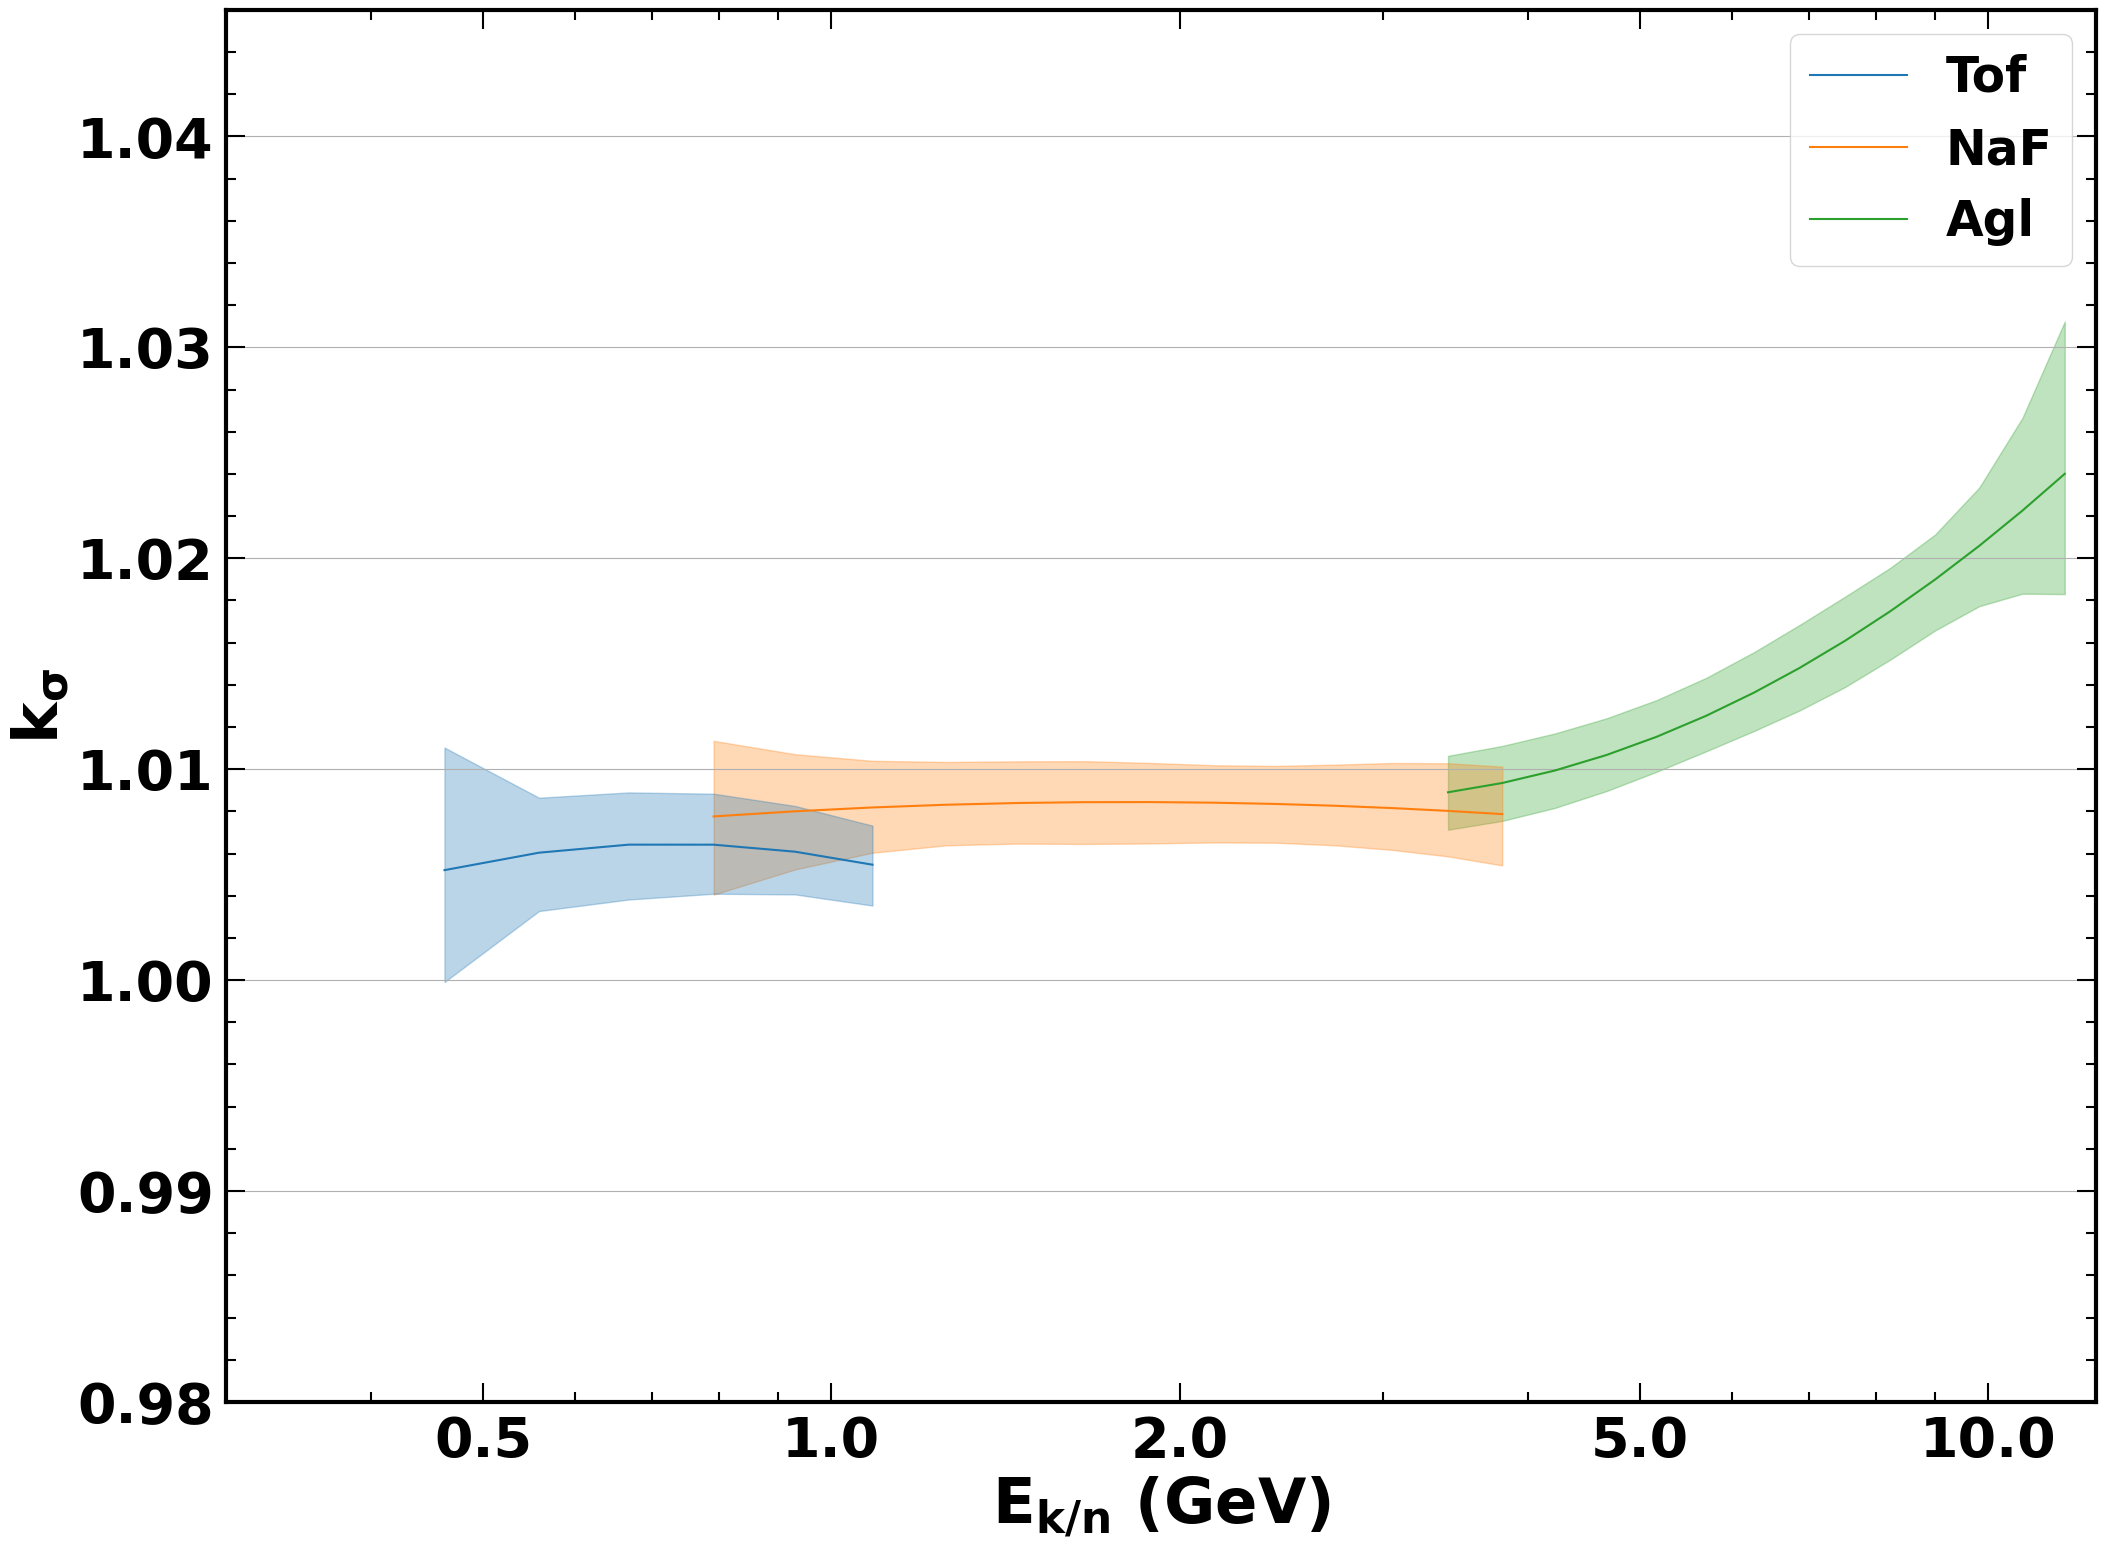

In [60]:
from tools.graphs import slice_graph_by_value
from tools.constants import ANALYSIS_RANGE_EKIN
def GetFitPolyPars(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
    return popt

energy_range = {"Tof": [0.3, 1.1], "NaF": np.array([0.8, 3.8]), "Agl": np.array([3.5, 12])}


fig, ax2 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                               
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    sub_graph_massreso_Agl = slice_graph_by_value(graph_inversemass_reso_Agl[iso], np.array([3.0, 12]))
    sub_graph_massreso_NaF = slice_graph_by_value(graph_inversemass_reso_NaF[iso], np.array([0.8, 3.8]))
    sub_graph_massreso_Tof = slice_graph_by_value(graph_inversemass_reso_Tof[iso], np.array([0.3, 1.5]))
    

sub_mass_reso_ratio_Agl = slice_graph_by_value(mass_reso_ratio_Agl, energy_range['Agl'])
sub_mass_reso_ratio_NaF = slice_graph_by_value(mass_reso_ratio_NaF, energy_range['NaF'])
sub_mass_reso_ratio_Tof = slice_graph_by_value(mass_reso_ratio_Tof, energy_range['Tof'])

#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_Agl, energy_range['Agl']), color=DETECTOR_COLOR['Agl'],  style="EP", xlog=True, ylog=False, scale=None, markersize=24, label='Be9/Be7')  
#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_NaF, energy_range['NaF']), color=DETECTOR_COLOR['NaF'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_Tof, energy_range['Tof']), color=DETECTOR_COLOR['Tof'],  style="EP", xlog=True, ylog=False, scale=None, markersize=15)  

ax1.text(0.05, 0.98, "Tof", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.395, 0.98, "NaF", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.71, 0.98, "Agl", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")



yratio_low_Agl = sub_mass_reso_ratio_Agl.yvalues - sub_mass_reso_ratio_Agl.yerrs
yratio_up_Agl = sub_mass_reso_ratio_Agl.yvalues + sub_mass_reso_ratio_Agl.yerrs
ax2.fill_between(sub_mass_reso_ratio_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=DETECTOR_COLOR['Agl'], alpha=0.3)  

yratio_low_NaF = sub_mass_reso_ratio_NaF.yvalues - sub_mass_reso_ratio_NaF.yerrs
yratio_up_NaF = sub_mass_reso_ratio_NaF.yvalues + sub_mass_reso_ratio_NaF.yerrs
ax2.fill_between(sub_mass_reso_ratio_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=DETECTOR_COLOR['NaF'], alpha=0.3)  

yratio_low_Tof = sub_mass_reso_ratio_Tof.yvalues - sub_mass_reso_ratio_Tof.yerrs
yratio_up_Tof = sub_mass_reso_ratio_Tof.yvalues + sub_mass_reso_ratio_Tof.yerrs
ax2.fill_between(sub_mass_reso_ratio_Tof.xvalues, yratio_low_Tof, yratio_up_Tof, color=DETECTOR_COLOR['Tof'], alpha=0.3)  
#ax1.fill_betweenx(np.linspace(0.06, 0.2, 100), ANALYSIS_RANGE_EKIN['NaF'][0], ANALYSIS_RANGE_EKIN['NaF'][1], alpha=0.1, color='tab:blue') 

ax2.set_xlim([0.3, 12.4])
ax2.set_ylim([0.98, 1.046])
ax2.set_xscale('log')
ax2.grid(axis='y') 
ax2.set_ylabel(r'$\mathrm{k_{\sigma}}$')  
ax2.set_xlabel(r'$\mathrm{E_{k/n} \ (GeV)}$') 


set_plot_style(ax2)
spline_ksig_factor = {dec: {} for dec in detectors}
graph_ksig_low = {}
graph_ksig_up = {}

p0_dec = [1.0, 0.1, 0.1]
dict_polypars_sigfactor = {dec: {} for dec in detectors}
sub_mass_reso_ratio = {'Tof': sub_mass_reso_ratio_Tof, 'NaF': sub_mass_reso_ratio_NaF, 'Agl':  sub_mass_reso_ratio_Agl}
iso = 'Li7'
for dec in detectors:
    popt = GetFitPolyPars(sub_mass_reso_ratio[dec], p0_dec, withsigma=True)
    dict_polypars_sigfactor[dec][iso] = popt
    ax2.plot(sub_mass_reso_ratio[dec].xvalues, poly(np.log(sub_mass_reso_ratio[dec].xvalues), *popt), '-', color=DETECTOR_COLOR[dec], label=f'{dec}')
    graph_ksig_low[dec], graph_ksig_up[dec] = getgraph_errband(sub_mass_reso_ratio[dec], p0_dec, withsig=False)
    spline_ksig_factor[dec][iso] = get_uncertainty_spline(graph_ksig_low[dec], graph_ksig_up[dec])
 
ax2.legend(loc='upper right', fontsize=35) 

#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
print(plotdir)

ax2.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
savefig_tofile(fig, plotdir, f"ksigma_Li", show=True)




   

 


/home/manbing/Documents/lithiumanalysis/slides/plots/Get_LiBoron_MassResolutions_KorrGBL


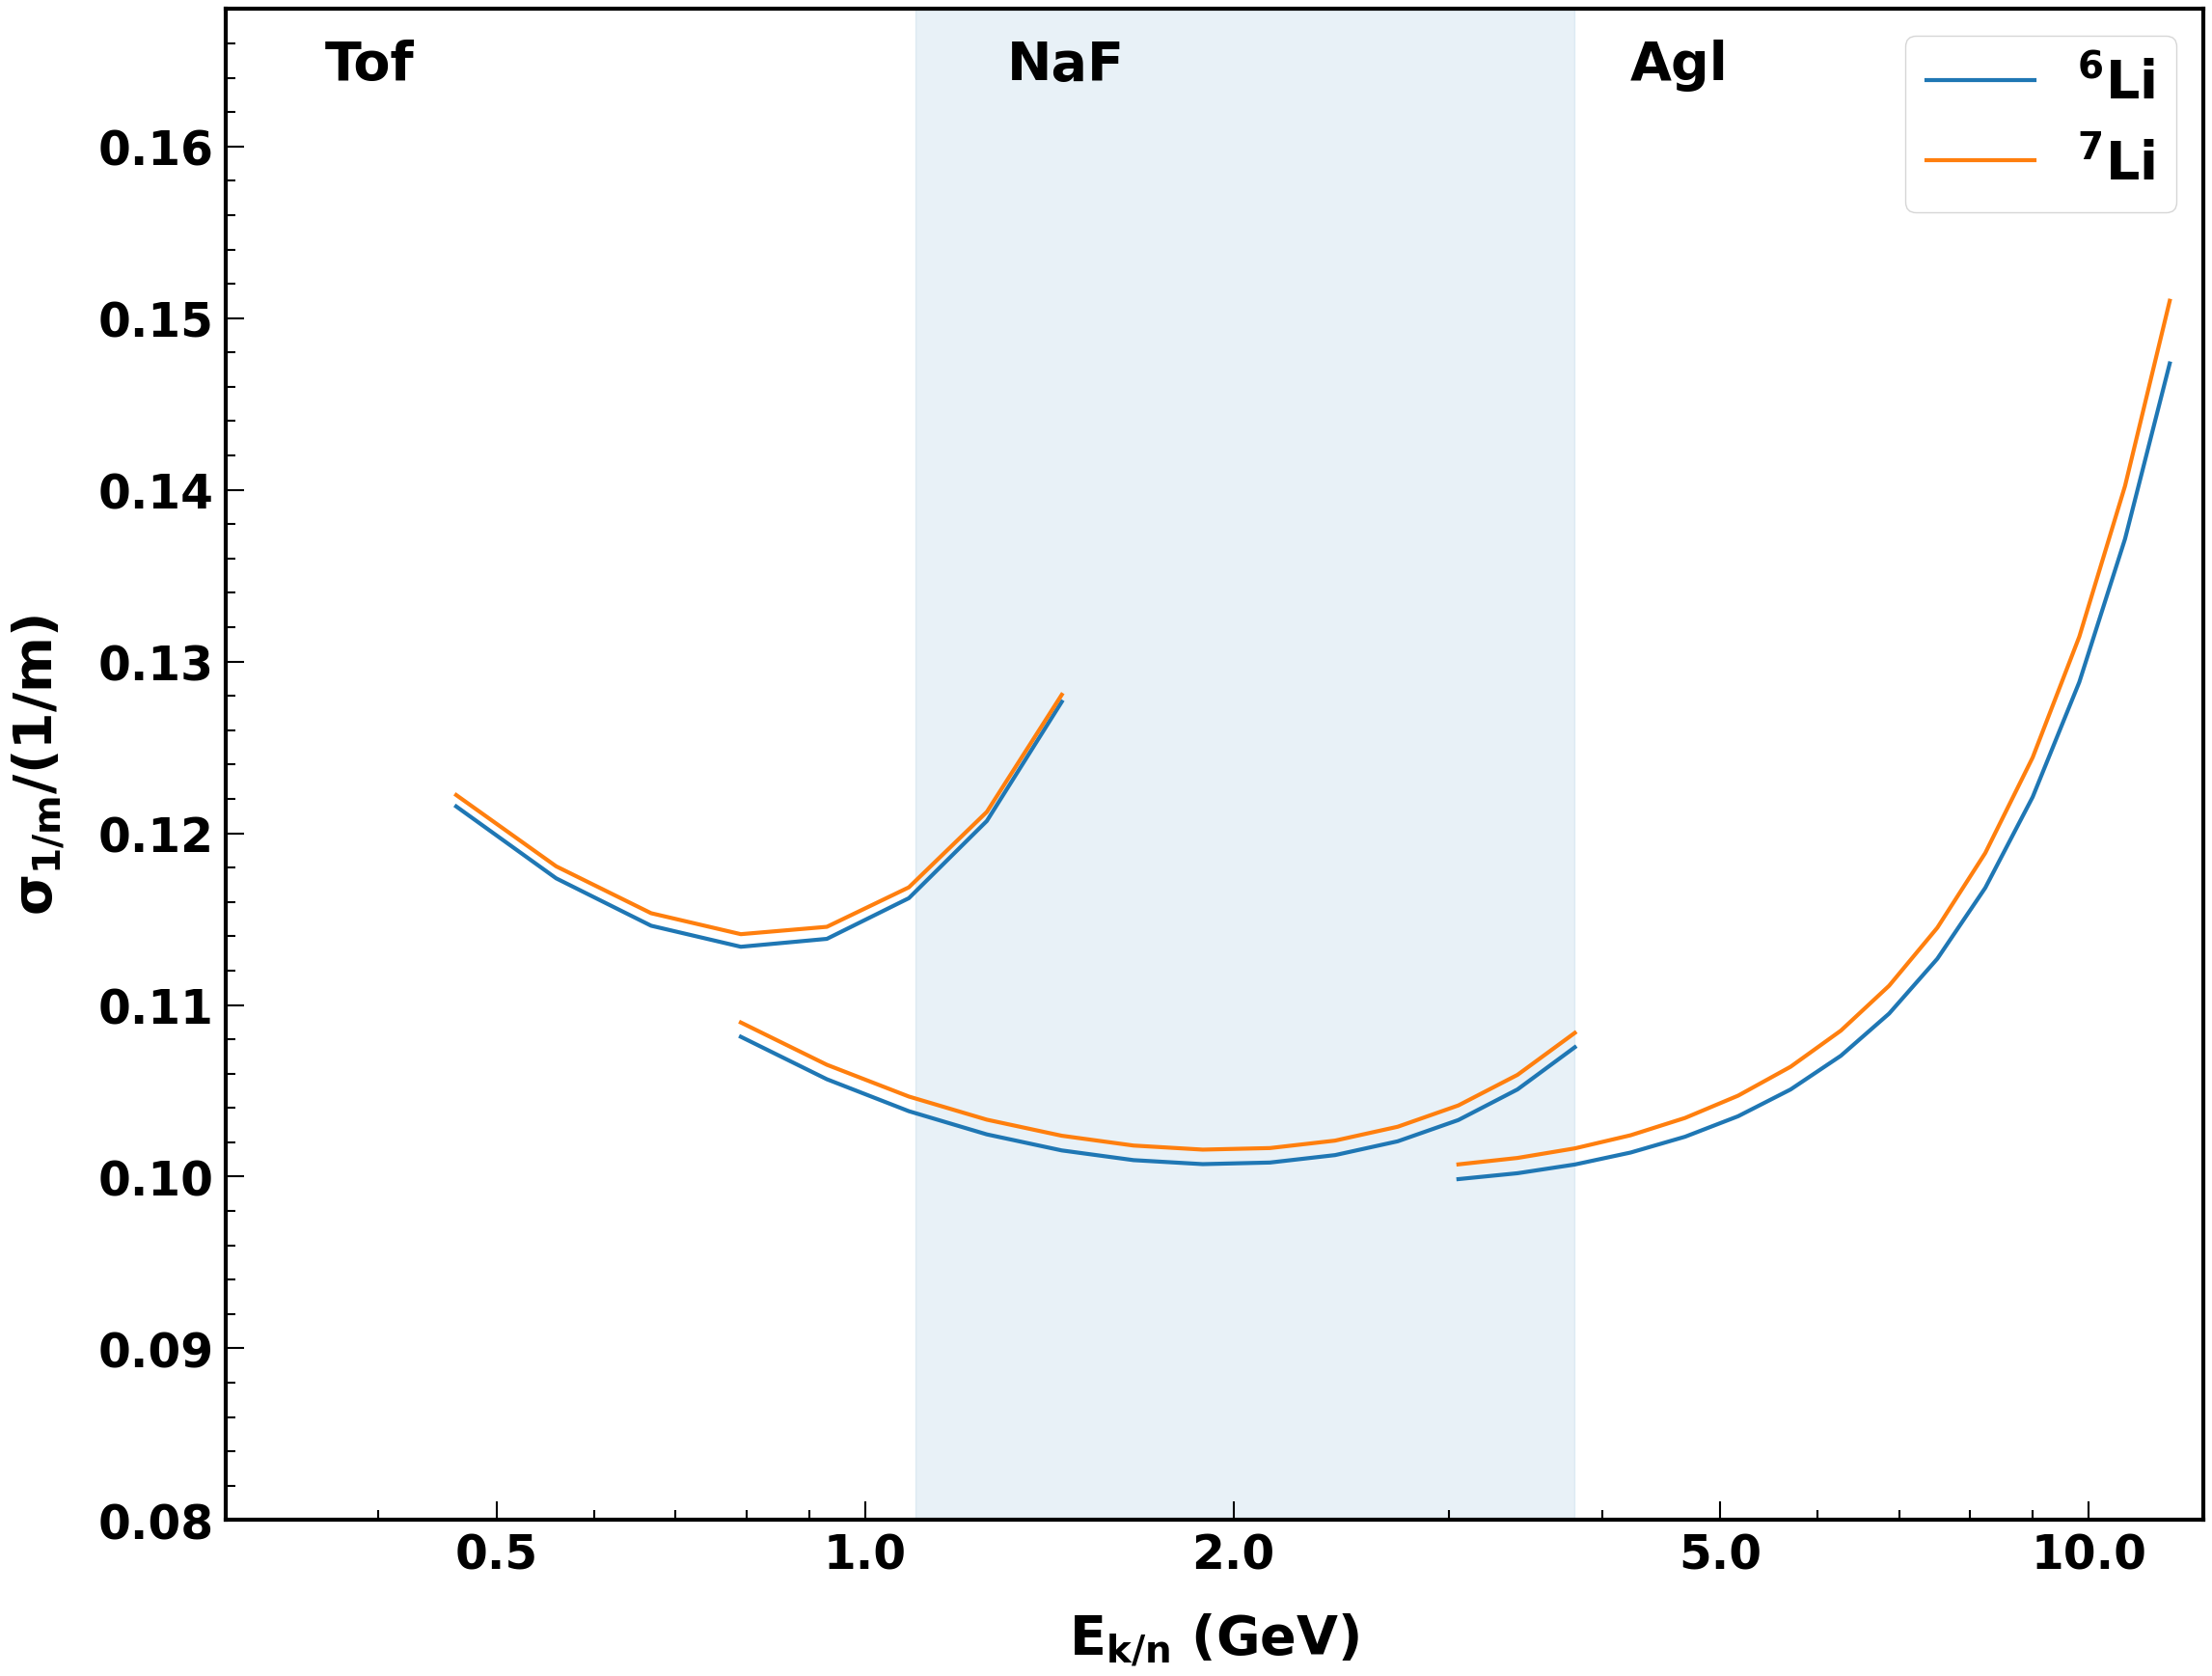

In [48]:
from tools.graphs import slice_graph_by_value
from tools.constants import ANALYSIS_RANGE_EKIN
def GetFitPolyPars(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
    return popt

energy_range = {"Tof": [0.3, 1.1], "NaF": np.array([0.8, 3.8]), "Agl": np.array([3.5, 12])}

fig, ax1 = plt.subplots(1, 1, figsize=(25, 18))                                                                                                            
fig.subplots_adjust(left= 0.15, right=0.97, bottom=0.08, top=0.95) 
set_plot_style(ax1)

for iso in isotopes:
    #ax1.plot(graph_inversemass_reso_Agl[iso].xvalues, graph_inversemass_reso_Agl[iso].yvalues, "--",  color=ISOTOPES_COLOR[iso])  
    sub_graph_massreso_Agl = slice_graph_by_value(graph_inversemass_reso_Agl[iso], np.array([3.0, 12]))
    sub_graph_massreso_NaF = slice_graph_by_value(graph_inversemass_reso_NaF[iso], np.array([0.8, 3.8]))
    sub_graph_massreso_Tof = slice_graph_by_value(graph_inversemass_reso_Tof[iso], np.array([0.3, 1.5]))
    plot_graph(fig, ax1, sub_graph_massreso_Agl, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=25, label=f'{ISO_LABELS[iso]}', linewidth=3)
    plot_graph(fig, ax1, sub_graph_massreso_NaF, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=20, linewidth=3)  
    plot_graph(fig, ax1, sub_graph_massreso_Tof, color=ISOTOPES_COLOR[iso],  style="hist", xlog=True, ylog=False, scale=None, markersize=15, linewidth=3)  

sub_mass_reso_ratio_Agl = slice_graph_by_value(mass_reso_ratio_Agl, energy_range['Agl'])
sub_mass_reso_ratio_NaF = slice_graph_by_value(mass_reso_ratio_NaF, energy_range['NaF'])
sub_mass_reso_ratio_Tof = slice_graph_by_value(mass_reso_ratio_Tof, energy_range['Tof'])

#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_Agl, energy_range['Agl']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=24, label='Be9/Be7')  
#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_NaF, energy_range['NaF']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=22)  
#plot_graph(fig, ax2, slice_graph_by_value(mass_reso_ratio_Tof, energy_range['Tof']), color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=True, ylog=False, scale=None, markersize=15)  

ax1.text(0.05, 0.98, "Tof", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.395, 0.98, "NaF", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
ax1.text(0.71, 0.98, "Agl", fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")



SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV)}$', r'$\mathrm{\sigma_{1/m}/(1/m)}$', TEXTSIZE, xlimrange=[0.3, 12.4], ylimrange=[0.08, 0.168], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)
ax1.fill_betweenx(np.linspace(0.06, 0.2, 100), ANALYSIS_RANGE_EKIN['NaF'][0]-0.1, ANALYSIS_RANGE_EKIN['NaF'][1]-0.2, alpha=0.1, color='tab:blue') 
ax1.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())    
ax1.legend(fontsize=40) 
print(plotdir)
savefig_tofile(fig, plotdir, f"Li_mass_resolution", show=True)

NameError: name 'mass_reso_ratio9_NaF' is not defined

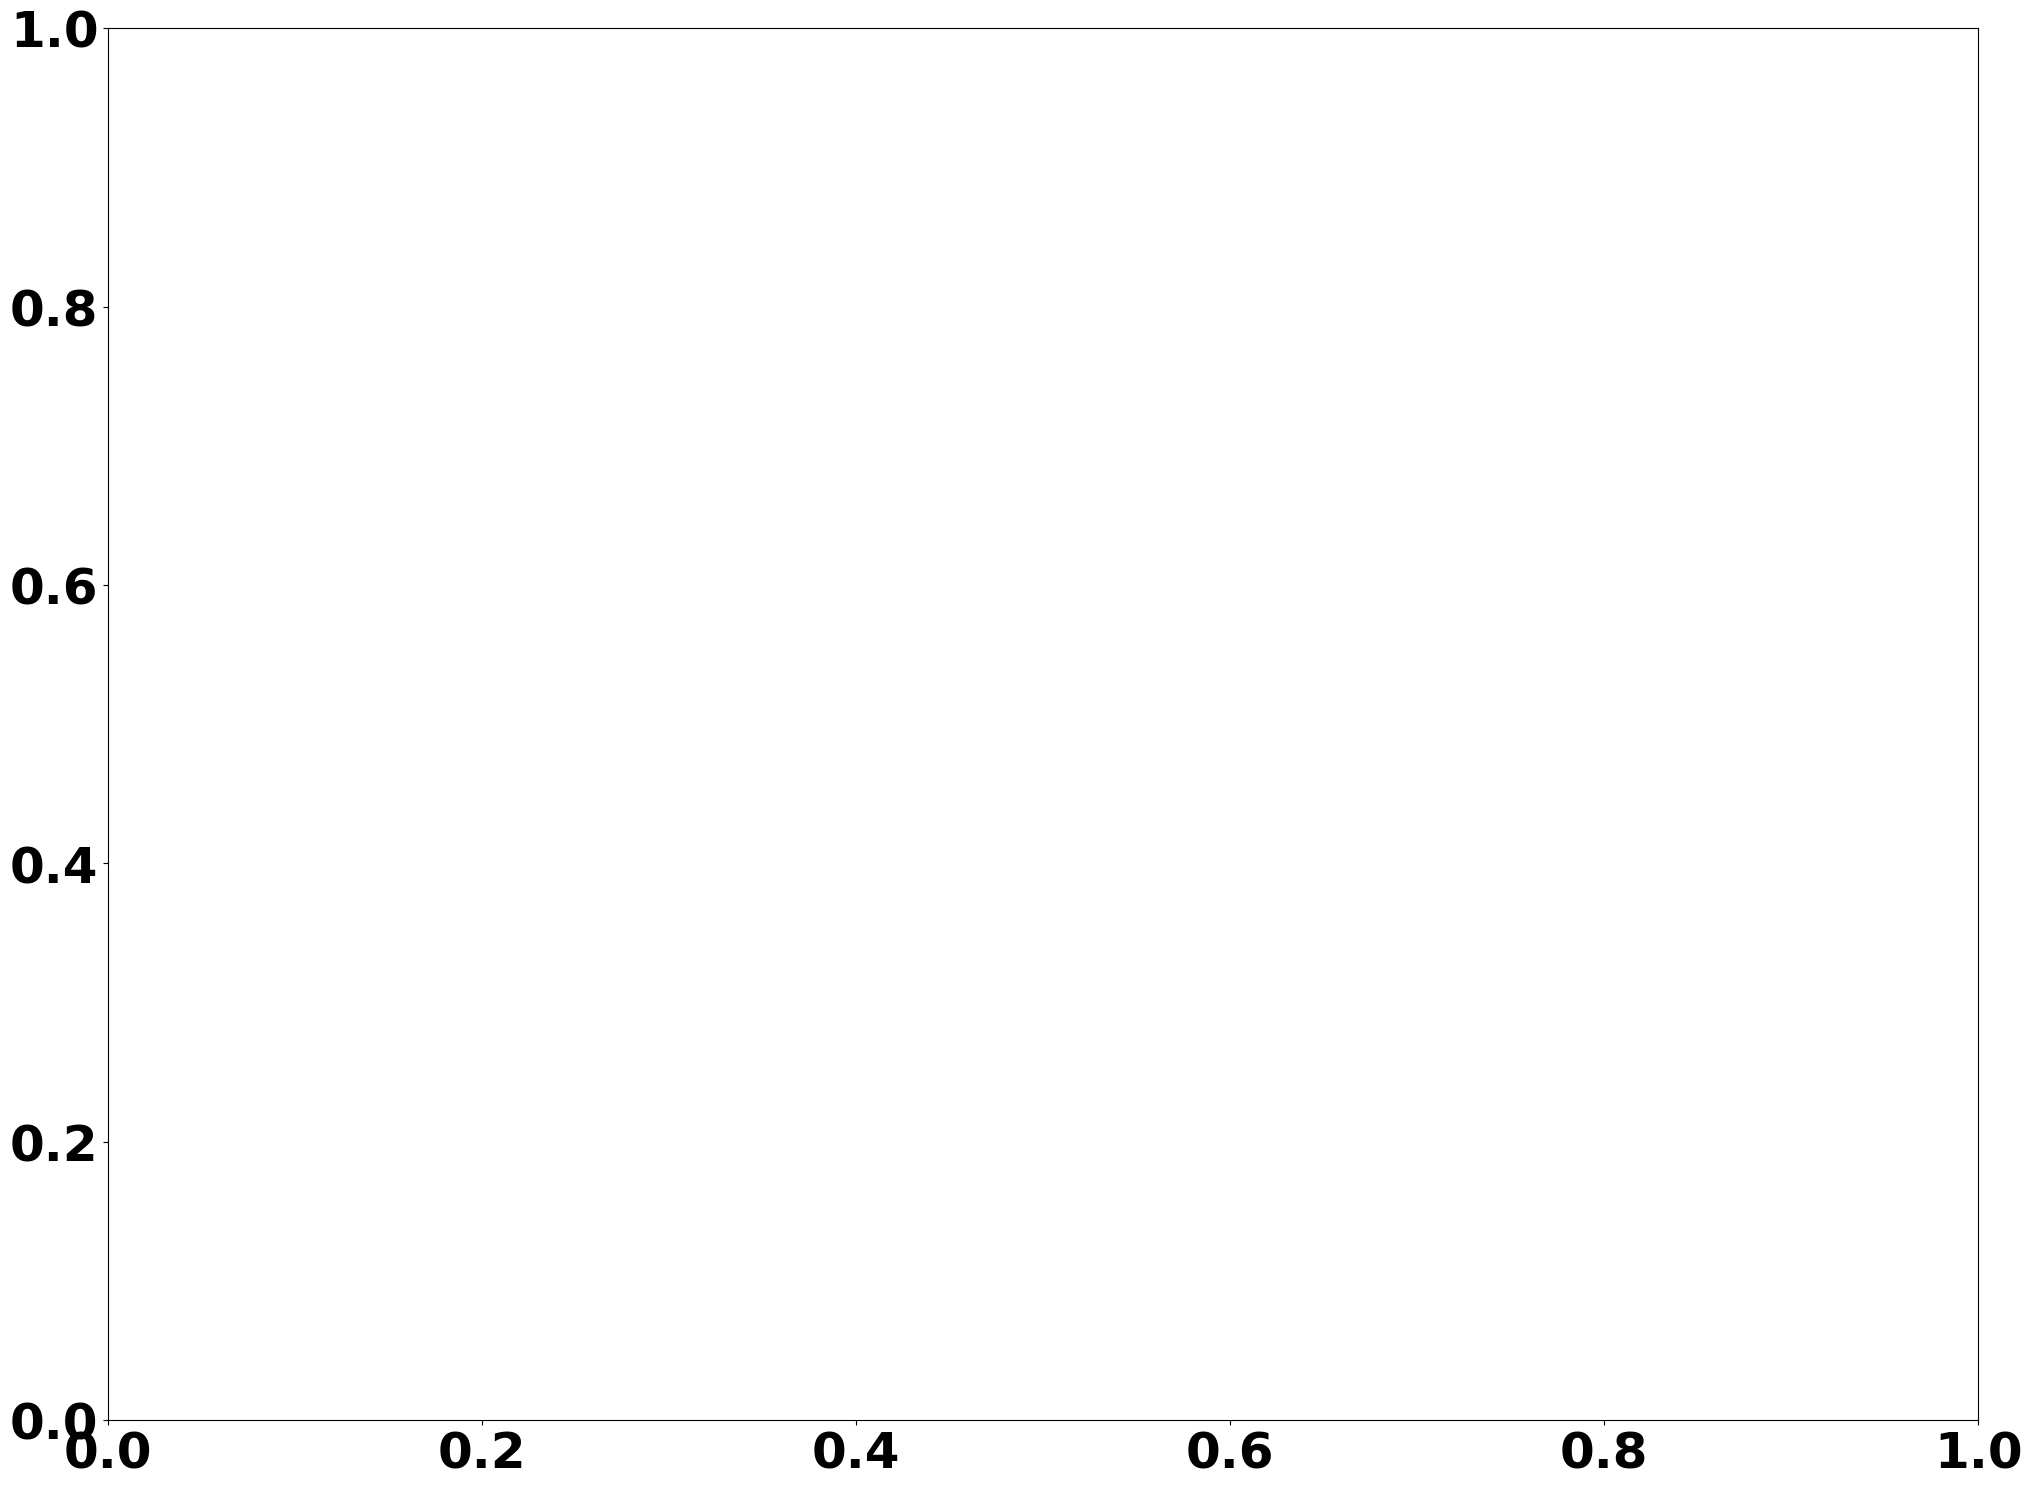

In [40]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

graph_ratiobe9_NaF = scale_graph(mass_reso_ratio9_NaF, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
graph_ratiobe10_NaF = scale_graph(mass_reso_ratio10_NaF,  ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])

plot_graph(fig, ax1, graph_ratiobe9_NaF, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m9')  
plot_graph(fig, ax1, graph_mass_sigma_9to7['NaF'], color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be9}/\sigma_{p, be7}}$')  
plot_graph(fig, ax1, graph_ratiobe10_NaF, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m10')  
plot_graph(fig, ax1, graph_mass_sigma_10to7['NaF'], color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be10}/\sigma_{p, be7}}$')  

popt9, pcov9 = curve_fit(poly, np.log(graph_ratiobe9_NaF.xvalues), graph_ratiobe9_NaF.yvalues, p0 = [1.0, 0.1, 0.1])
popt10, pcov10 = curve_fit(poly, np.log(graph_ratiobe10_NaF.xvalues), graph_ratiobe10_NaF.yvalues, p0 = [1.0, 0.1, 0.1])

print('NaFBe9', popt9)
print('NaFBe10', popt10)

yratio_low_NaF = (graph_ratiobe9_NaF.yvalues - graph_ratiobe9_NaF.yerrs) * 0.999
yratio_up_NaF = (graph_ratiobe9_NaF.yvalues + graph_ratiobe9_NaF.yerrs) * 1.001
ax1.fill_between(graph_ratiobe9_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_NaF10 = (graph_ratiobe10_NaF.yvalues - graph_ratiobe10_NaF.yerrs) * 0.999
yratio_up_NaF10 = (graph_ratiobe10_NaF.yvalues + graph_ratiobe10_NaF.yerrs) * 1.001
ax1.fill_between(graph_ratiobe10_NaF.xvalues, yratio_low_NaF10, yratio_up_NaF10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([0.8, 4.0])
ax1.set_ylim([0.65, 0.85])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin (GeV)') 
ax1.legend(loc="upper right", fontsize=30) 
ax1.text(0.05, 0.98, "NaF", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m}}$ ratio')
ax1.set_xticklabels([])
set_plot_defaultstyle(ax1)
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, f"mass_resolution_ratio_comfit_NaF1", show=True)

NameError: name 'mass_reso_ratio9_NaF' is not defined

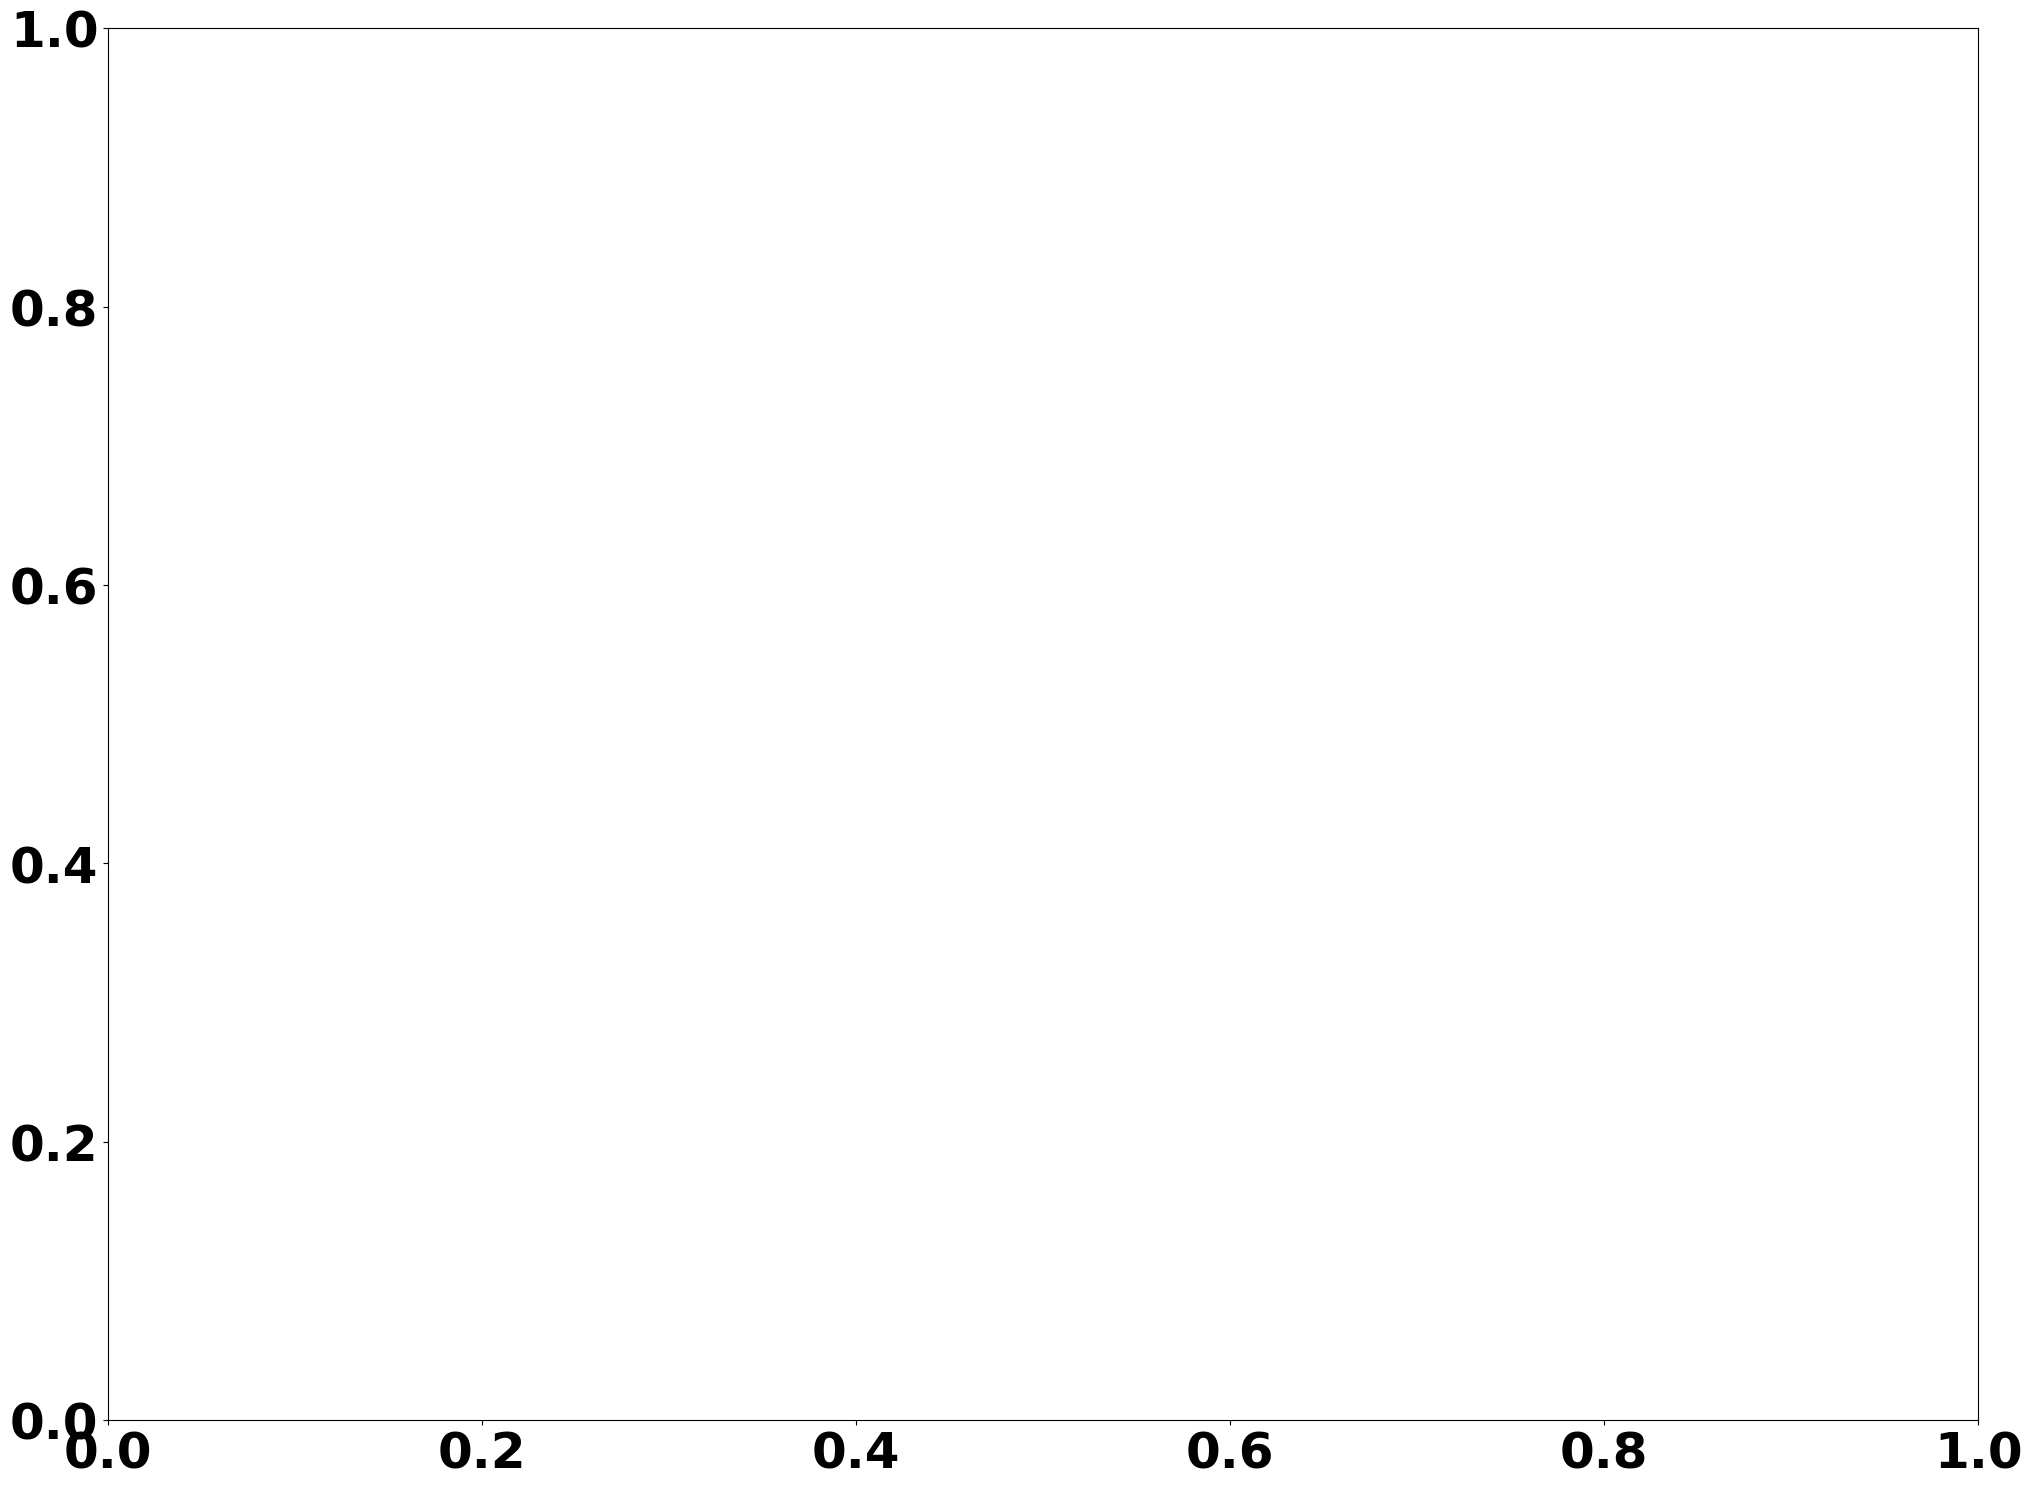

In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 


graph_ratiobe9_NaF = scale_graph(mass_reso_ratio9_NaF, 1)
graph_ratiobe10_NaF = scale_graph(mass_reso_ratio10_NaF, 1)
graph_mass_sigma_9to7_NaFcorr  = scale_graph(graph_mass_sigma_9to7['NaF'], ISOTOPES_MASS['Be9']/ ISOTOPES_MASS['Be7'] * 0.996)
graph_mass_sigma_10to7_NaFcorr  = scale_graph(graph_mass_sigma_10to7['NaF'], ISOTOPES_MASS['Be10']/ ISOTOPES_MASS['Be7'] * 0.996)

plot_graph(fig, ax1, graph_ratiobe9_NaF, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{k_{\sigma 9}}$')  
plot_graph(fig, ax1, graph_mass_sigma_9to7_NaFcorr, color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{{^9{{Be}} }}$ MC Reconstructed')  
plot_graph(fig, ax1, graph_ratiobe10_NaF, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{k_{\sigma 10}}$')  
plot_graph(fig, ax1, graph_mass_sigma_10to7_NaFcorr, color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{{^{{10}}{{Be}} }}$ MC Reconstructed') 

#popt9, pcov9 = curve_fit(poly, np.log(graph_ratiobe9_NaF.xvalues), graph_ratiobe9_NaF.yvalues, p0 = [1.0, 0.1, 0.1], sigma=graph_ratiobe9_NaF.yerrs, absolute_sigma=True)
#popt10, pcov10 = curve_fit(poly, np.log(graph_ratiobe10_NaF.xvalues), graph_ratiobe10_NaF.yvalues, p0 = [1.0, 0.1, 0.1], sigma=graph_ratiobe10_NaF.yerrs, absolute_sigma=True)
popt9, pcov9 = curve_fit(poly, np.log(graph_ratiobe9_NaF.xvalues), graph_ratiobe9_NaF.yvalues, p0 = [1.0, 0.1, 0.1])
popt10, pcov10 = curve_fit(poly, np.log(graph_ratiobe10_NaF.xvalues), graph_ratiobe10_NaF.yvalues, p0 = [1.0, 0.1, 0.1])

print('NaFBe9', popt9)
print('NaFBe10', popt10)

#ax1.plot(graph_ratiobe9_NaF.xvalues, poly(np.log(graph_ratiobe9_NaF.xvalues), *popt9), '--')
#ax1.plot(graph_ratiobe10_NaF.xvalues, poly(np.log(graph_ratiobe10_NaF.xvalues), *popt10), '--')

yratio_low_NaF = graph_ratiobe9_NaF.yvalues - graph_ratiobe9_NaF.yerrs
yratio_up_NaF = graph_ratiobe9_NaF.yvalues +  graph_ratiobe9_NaF.yerrs

ax1.fill_between(graph_ratiobe9_NaF.xvalues, yratio_low_NaF, yratio_up_NaF, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_NaF10 = graph_ratiobe10_NaF.yvalues - 1.0 *graph_ratiobe10_NaF.yerrs
yratio_up_NaF10 = graph_ratiobe10_NaF.yvalues + 1.0 *graph_ratiobe10_NaF.yerrs
ax1.fill_between(graph_ratiobe10_NaF.xvalues, yratio_low_NaF10, yratio_up_NaF10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([0.9, 4.0])
ax1.set_ylim([0.95, 1.08])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin/n (GeV)', fontsize=50) 
ax1.legend(loc="lower right", fontsize=45) 
#ax1.set_xscale('log')
ax1.set_ylabel(r'$\mathrm{k_{\sigma}}$', fontsize=50)
#ax1.set_xticklabels([3.0, 4.0, 6.0, 10.0])
set_plot_defaultstyle(ax1)
#ax1.set_xticks([3, 4, 10]) 
ax1.text(0.05, 0.98, "NaF, Rigidity: GBL", fontsize=45, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")

#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
savefig_tofile(fig, plotdir, f"sigma_korrfactor_NaF_be9P8", show=True)

Text(0.05, 0.98, 'Aerogel')

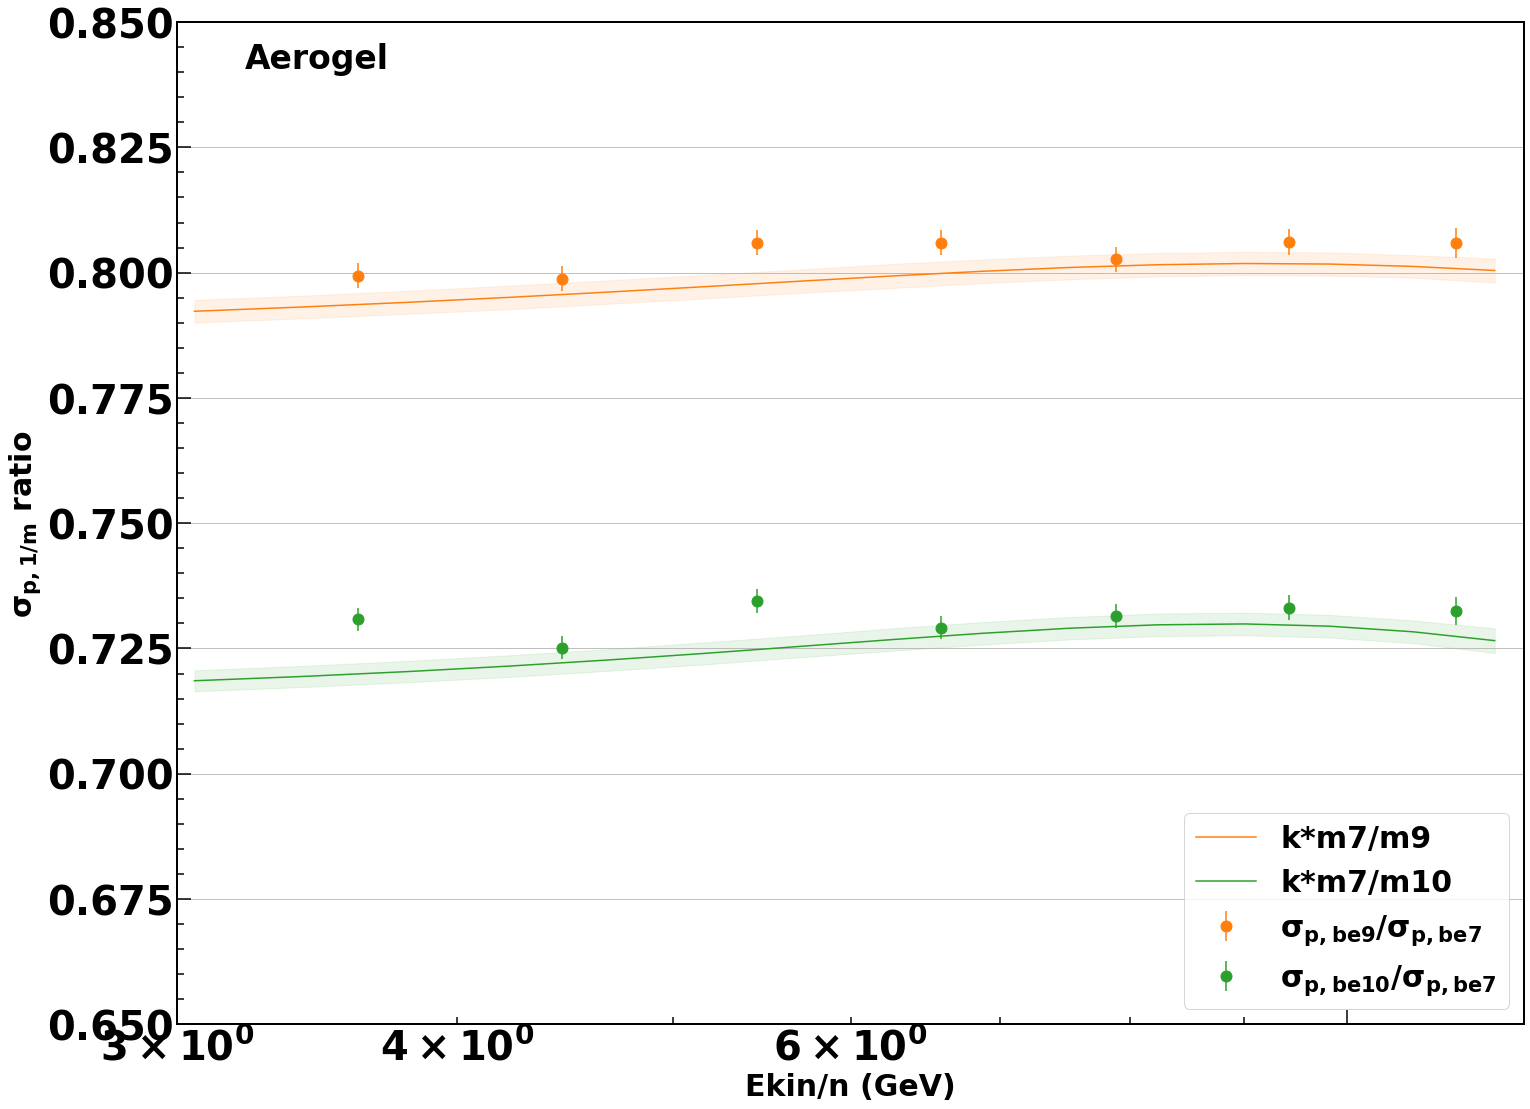

In [76]:
fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                            
fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 

graph_ratiobe9_Agl = scale_graph(mass_reso_ratio9_Agl, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
graph_ratiobe10_Agl = scale_graph(mass_reso_ratio10_Agl, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
plot_graph(fig, ax1, graph_ratiobe9_Agl, color=ISOTOPES_COLOR['Be9'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m9')  
plot_graph(fig, ax1, graph_mass_sigma_9to7['Agl'], color=ISOTOPES_COLOR['Be9'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be9}/\sigma_{p, be7}}$')  
plot_graph(fig, ax1, graph_ratiobe10_Agl, color=ISOTOPES_COLOR['Be10'],  style="hist", xlog=False, ylog=False, scale=None, markersize=22, label=f'k*m7/m10')  
plot_graph(fig, ax1, graph_mass_sigma_10to7['Agl'], color=ISOTOPES_COLOR['Be10'],  style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r'$\mathrm{\sigma_{p,be10}/\sigma_{p, be7}}$')  
yratio_low_Agl = graph_ratiobe9_Agl.yvalues - graph_ratiobe9_Agl.yerrs
yratio_up_Agl = graph_ratiobe9_Agl.yvalues + graph_ratiobe9_Agl.yerrs
ax1.fill_between(graph_ratiobe9_Agl.xvalues, yratio_low_Agl, yratio_up_Agl, color=ISOTOPES_COLOR['Be9'], alpha=0.1)  

yratio_low_Agl10 = graph_ratiobe10_Agl.yvalues - graph_ratiobe10_Agl.yerrs
yratio_up_Agl10 = graph_ratiobe10_Agl.yvalues + graph_ratiobe10_Agl.yerrs
ax1.fill_between(graph_ratiobe10_Agl.xvalues, yratio_low_Agl10, yratio_up_Agl10, color=ISOTOPES_COLOR['Be10'], alpha=0.1)  
ax1.set_xlim([3.0, 12.0])
ax1.set_ylim([0.65, 0.85])
ax1.grid(axis='y')                                         
ax1.set_xlabel('Ekin/n (GeV)') 
ax1.legend(loc="lower right", fontsize=30) 
ax1.set_xscale('log')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m}}$ ratio')
ax1.set_xticklabels([])
set_plot_defaultstyle(ax1)
ax1.text(0.05, 0.98, "Aerogel", fontsize=FONTSIZE+3, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black")
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410/'
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate04102023/plots_0410'
#savefig_tofile(fig, plotdir, f"mass_resolution_ratio_comfit_Agl1", show=True)

In [77]:
tick_length = 14                                                                                         
tick_width=1.5                                                                                           
tick_labelsize = 40                                                                                      
legendfontsize = 40                                                                                      
textfontsize = 45                                                                                       
marker_size = 30      
def set_plot_defaultstyle(plot):                                                                         
    plt.rcParams["font.weight"] = "bold"                                                                 
    plt.rcParams["axes.labelweight"] = "bold"                                                            
    plt.rcParams['font.size']= FONTSIZE                                                                  
    plt.rcParams['xtick.top'] = False                                                                    
    plt.rcParams['ytick.right'] = False                                                                  
    plot.tick_params(axis='both', which="major",direction='in', length=tick_length, width=tick_width, labelsize=tick_labelsize)                                                                                  
    plot.tick_params(axis='both', which="minor",direction='in', length=tick_length/2.0, width=tick_width, labelsize=tick_labelsize)                                                                              
    for axis in ['top','bottom','left','right']:                                                                                                                                                        
        plot.spines[axis].set_linewidth(2)                                                               
    plt.minorticks_on()      

In [44]:
from tools.graphs import scale_graph
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitAll/df_sigma_ratio_sigma.npz'
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23/df_ratio_sigma_iter2.npz'
filename11 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio11 = np.load(f'{filename11}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
for dec in detectors:
    if dec == 'Tof':
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_10to7_{dec}")
    else:
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
        
        

#graph_mass_sigma_9to7['NaF'] = scale_graph(graph_mass_sigma_9to7['NaF'], 0.998)
#graph_mass_sigma_9to7['Agl'] = scale_graph(graph_mass_sigma_9to7['Agl'], 0.998)
#graph_mass_sigma_10to7['NaF'] = scale_graph(graph_mass_sigma_10to7['NaF'], 0.999)
#graph_mass_sigma_10to7['Agl'] = scale_graph(graph_mass_sigma_10to7['Agl'], 0.999)      
from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
    if dec =="Tof":
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\sigma_{p,be7}/\sigma_{p, be9}}$")
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="$\mathrm{\sigma_{p,be7}/\sigma_{p, be10}}$")
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    else:                                                                                                            
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")       
ax1.set_ylim([0.6, 0.85])
                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                       
ax1.get_yticklabels()[0].set_visible(False)                                                                                                                                                      
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

#ax1.plot(sub_mass_reso_ratio9_Tof.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Tof.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_NaF.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_NaF.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_Agl.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Agl.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio10_Tof.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Tof.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_NaF.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_NaF.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_Agl.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Agl.yvalues, "-", color='tab:green')

graphratio9 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio9_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio9_NaF, [1.2, 3.0]))
graphratio9 = concatenate_graphs(graphratio9, slice_graph_by_value(sub_mass_reso_ratio9_Agl, [3.0, 12]))
popt9, pcov9 = curve_fit(poly, np.log(graphratio9.xvalues), graphratio9.yvalues, p0 = [1.0, 1.0, 1.0, 1.0])
print(popt9)

yfit_ratiobe9 = poly(np.log(graphratio9.xvalues), *popt9)
print(yfit_ratiobe9)
yfit_ratiobe9[0:14] = 1.0
print(yfit_ratiobe9)
ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * yfit_ratiobe9, "-", color='tab:orange', label='k*m7/m9')
#ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * graphratio9.yvalues, "-", color='tab:orange', label='k*m7/m9')
                                 
graphratio10 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio10_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio10_NaF, [1.2, 3.0]))
graphratio10 = concatenate_graphs(graphratio10, slice_graph_by_value(sub_mass_reso_ratio10_Agl, [3.0, 12]))

popt10, pcov10 = curve_fit(poly, np.log(graphratio10.xvalues), graphratio10.yvalues, p0 = [1.0, 1.0, 1.0, 1.0, 1.0])
print(popt10)
yfit_ratiobe10 = poly(np.log(graphratio10.xvalues), *popt10)
yfit_ratiobe10[0:14] = 1.0
print(yfit_ratiobe10)

ax1.plot(graphratio10.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'] * yfit_ratiobe10, "-", color=ISOTOPES_COLOR['Be10'], label='k*m7/m10')
#ax1.plot(graphratio10.xvalues, 7.0/10.0 *  graphratio10.yvalues, "-", color='tab:green', label='k*m7/m10')
                                 
#ax1.axhline(y=7.0/9.0, color='orange', linestyle='--')  
#ax1.axhline(y=7.0/10.0, color='green', linestyle='--')  
#label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
#label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
#legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
#ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
savefig_tofile(fig, plotdir, 'mass_sigmap_isoratio', 1)


FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

In [45]:
from tools.graphs import scale_graph
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitAll/df_sigma_ratio_sigma.npz'
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23/df_ratio_sigma_iter2.npz'
filename11 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio11 = np.load(f'{filename11}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
for dec in detectors:
    if dec == 'Tof':
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio11, f"graph_mass_sigma_10to7_{dec}")
    else:
        graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
        graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
        
        

#graph_mass_sigma_9to7['NaF'] = scale_graph(graph_mass_sigma_9to7['NaF'], 0.998)
#graph_mass_sigma_9to7['Agl'] = scale_graph(graph_mass_sigma_9to7['Agl'], 0.998)
#graph_mass_sigma_10to7['NaF'] = scale_graph(graph_mass_sigma_10to7['NaF'], 0.999)
#graph_mass_sigma_10to7['Agl'] = scale_graph(graph_mass_sigma_10to7['Agl'], 0.999)      
from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
    if dec =="Tof":
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\sigma_{p,be7}/\sigma_{p, be9}}$")
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="$\mathrm{\sigma_{p,be7}/\sigma_{p, be10}}$")
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    else:                                                                                                            
        plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")       
ax1.set_ylim([0.6, 0.85])
                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                       
ax1.get_yticklabels()[0].set_visible(False)                                                                                                                                                      
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

#ax1.plot(sub_mass_reso_ratio9_Tof.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Tof.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_NaF.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_NaF.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio9_Agl.xvalues, 7.0/9.0 *  sub_mass_reso_ratio9_Agl.yvalues, "-", color='tab:orange')
#ax1.plot(sub_mass_reso_ratio10_Tof.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Tof.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_NaF.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_NaF.yvalues, "-", color='tab:green')
#ax1.plot(sub_mass_reso_ratio10_Agl.xvalues, 7.0/10.0 *  sub_mass_reso_ratio10_Agl.yvalues, "-", color='tab:green')

graphratio9 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio9_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio9_NaF, [1.2, 3.0]))
graphratio9 = concatenate_graphs(graphratio9, slice_graph_by_value(sub_mass_reso_ratio9_Agl, [3.0, 12]))
popt9, pcov9 = curve_fit(poly, np.log(graphratio9.xvalues), graphratio9.yvalues, p0 = [1.0, 1.0, 1.0, 1.0])
print(popt9)

yfit_ratiobe9 = poly(np.log(graphratio9.xvalues), *popt9)
print(yfit_ratiobe9)
yfit_ratiobe9[0:13] = 1.0
print(yfit_ratiobe9)
ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * yfit_ratiobe9, "-", color='tab:orange', label='k*m7/m9')
#ax1.plot(graphratio9.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * graphratio9.yvalues, "-", color='tab:orange', label='k*m7/m9')
                                 
graphratio10 = concatenate_graphs(slice_graph_by_value(sub_mass_reso_ratio10_Tof, [0.3, 1.0]), slice_graph_by_value(sub_mass_reso_ratio10_NaF, [1.2, 3.0]))
graphratio10 = concatenate_graphs(graphratio10, slice_graph_by_value(sub_mass_reso_ratio10_Agl, [3.0, 12]))

popt10, pcov10 = curve_fit(poly, np.log(graphratio10.xvalues), graphratio10.yvalues, p0 = [1.0, 1.0, 1.0, 1.0, 1.0])
print(popt10)
yfit_ratiobe10 = poly(np.log(graphratio10.xvalues), *popt10)
yfit_ratiobe10[0:13] = 1.0
print(yfit_ratiobe10)

ax1.plot(graphratio10.xvalues, ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'] * yfit_ratiobe10, "-", color=ISOTOPES_COLOR['Be10'], label='k*m7/m10')
#ax1.plot(graphratio10.xvalues, 7.0/10.0 *  graphratio10.yvalues, "-", color='tab:green', label='k*m7/m10')
                                 
#ax1.axhline(y=7.0/9.0, color='orange', linestyle='--')  
#ax1.axhline(y=7.0/10.0, color='green', linestyle='--')  
#label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
#label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
#legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
#ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
savefig_tofile(fig, plotdir, 'mass_sigmap_isoratio', 1)


FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v11/df_ratio_sigma_iter2.npz'

In [45]:
with open('/home/manbing/Documents/lithiumanalysis/scripts/plots/rigfit_17/spline.pkl', 'rb') as f:
    spline_loaded = pickle.load(f)

#xvalues = np.array([0.37825, 0.4631, 0.559, 0.66835, 0.79125, 0.9303, 1.08555, 1.2571, 1.44745, 1.6566,  1.8872, 2.1419,  2.42075, 2.7237,  3.05343.4126,  3.80125, 4.2221,  4.67795, 5.16875, 5.70575, 6.27195, 6.8673, 7.52005, 8.2303, 8.99805, 9.82325])
xvalues = get_bin_center(fbinning_energy())
sp_kcorr9 = spline_loaded['spline9']
sp_kcorr10 = spline_loaded['spline10']
expected9 = sp_kcorr9(np.log(xvalues)) * 7.0/9.0
expected10 = sp_kcorr10(np.log(xvalues)) *7.0/10
#ax1.plot(xvalues, expected9, "-", color=ISOTOPES_COLOR['Be9'], label="ref k*m7/m9")
#ax1.plot(xvalues, expected10, "-", color=ISOTOPES_COLOR['Be10'], label='ref k*m7/m9')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=25)